# Set up

In [ ]:
pip install GPUtil

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

import GPUtil

def get_gpu_memory():
    GPUs = GPUtil.getGPUs()
    if len(GPUs) == 0:
        return 0
    return GPUs[0].memoryTotal, GPUs[0].memoryUsed, GPUs[0].memoryFree

gpu_total, gpu_used, gpu_free = get_gpu_memory()
print(f"Total GPU memory: {gpu_total:.1f}GB")
print(f"Used GPU memory: {gpu_used:.1f}GB")
print(f"Free GPU memory: {gpu_free:.1f}GB")

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
Total GPU memory: 40960.0GB
Used GPU memory: 2.0GB
Free GPU memory: 40511.0GB


In [ ]:
!pip install --extra-index-url https://download.pytorch.org/whl/cu116 torch==1.12.1 torchvision==0.13.1

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


In [ ]:
!pip install einops transformers

In [ ]:
!pip install timm==0.5.4

In [ ]:
!pip install wandb

In [ ]:
!pip install omegaconf==2.1.1 tqdm==4.64.0

In [ ]:
!pip install pytorch_lightning torchmetrics==0.11.4 torchtext==0.13.1

In [ ]:
!pip install kornia

In [ ]:
import torch
import numpy as np
import os
import math, sys
from math import inf
import time

from torch.utils.data import Dataset

from scipy import interpolate
from einops import rearrange
import json
import csv
import torch
from pathlib import Path
import torchvision.transforms as transforms
from scipy.interpolate import interp1d
from typing import Callable, Optional, Tuple, Union
from natsort import natsorted
from glob import glob
import pickle

from torch.nn import Identity

import os

from transformers import AutoProcessor

from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
import argparse
import timm.optim.optim_factory as optim_factory
import datetime
import matplotlib.pyplot as plt
import wandb
import copy
import importlib

from timm.models.vision_transformer import Block

from omegaconf import OmegaConf
import torch.nn as nn
from einops import rearrange, repeat
from torchvision.utils import make_grid
import torch.nn.functional as F

from tqdm import tqdm
from functools import partial

from PIL import Image, ImageDraw, ImageFont

from collections import abc
import multiprocessing as mp
from threading import Thread
from queue import Queue

from einops import rearrange, repeat, reduce
from transformers import CLIPTokenizer, CLIPTextModel, AutoProcessor, CLIPVisionModel, CLIPVisionModelWithProjection
import kornia

from inspect import isfunction
import pytorch_lightning as pl
from contextlib import contextmanager
from packaging import version
from torch.optim.lr_scheduler import LambdaLR
from torch import einsum
# from taming.modules.vqvae.quantize import VectorQuantizer2 as VectorQuantizer

from os import get_inheritable
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.models import ViT_H_14_Weights, vit_h_14
from torchmetrics.functional import accuracy

from collections import namedtuple

from abc import abstractmethod
from typing import Iterable

import torch as th

from pytorch_lightning.utilities import rank_zero_only

# Load and config dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/Shareddrives/EEG/"

In [ ]:
%cd /content/drive/Shareddrives/EEG/

/content/drive/Shareddrives/EEG


In [ ]:
sys.path.append('/content/drive/Shareddrives/EEG/')

In [ ]:
sys.path.append('/content/drive/Shareddrives/EEG/dc_ldm/models/diffusion')

In [ ]:
eeg_data = np.load('/content/drive/Shareddrives/EEG/Data/eeg/eeg/0.npy')

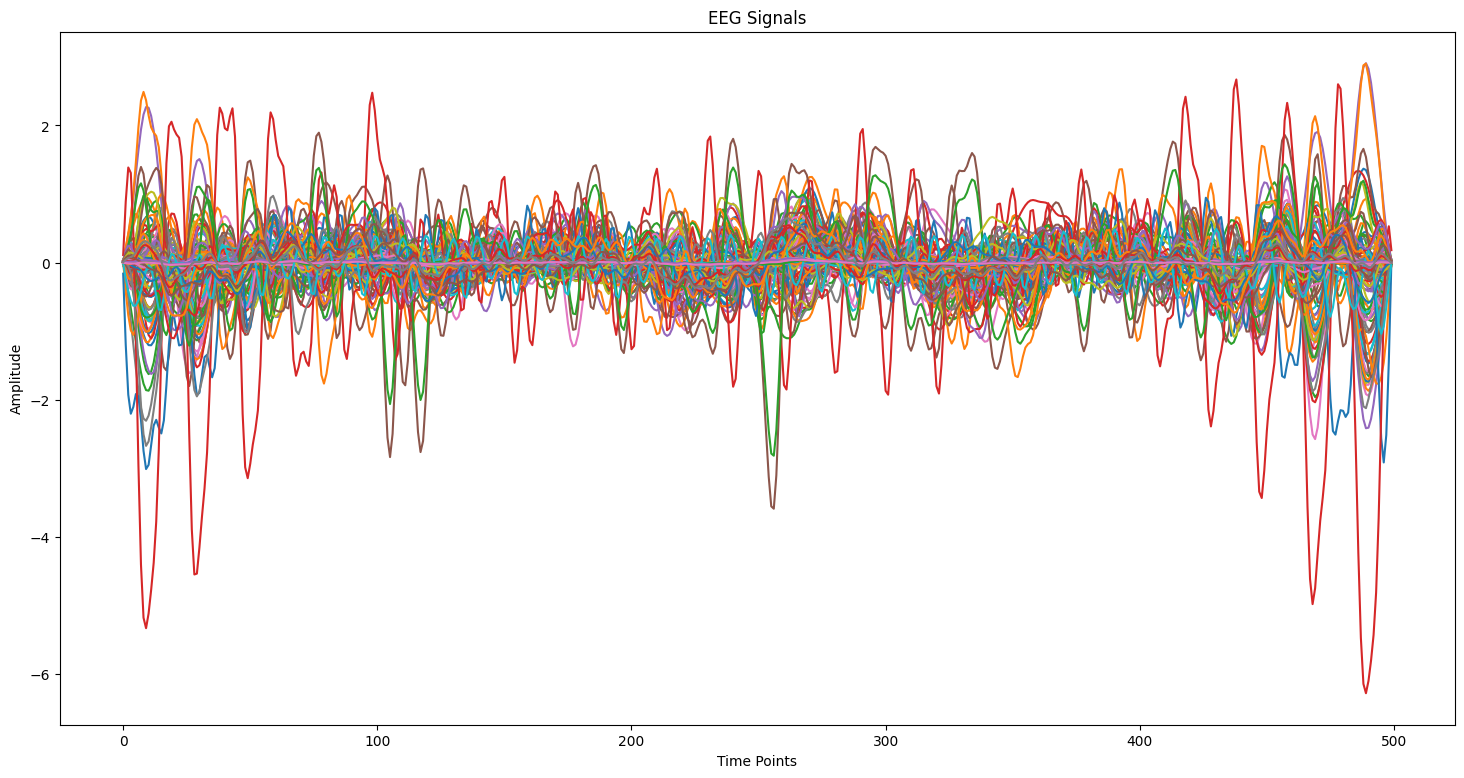

In [ ]:
plt.figure(figsize=(18, 9))
for i, channel in enumerate(eeg_data):
    plt.plot(channel, label=f'Channel {i+1}')

plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.title('EEG Signals')
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(eeg_data))
# plt.tight_layout()
plt.show()

In [ ]:
from config import *
from config import Config_Generative_Model

from eval_metrics import psm_wrapper

In [ ]:
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/Shareddrives/EEG/', '/content/drive/Shareddrives/EEG/dc_ldm/models/diffusion']


In [ ]:
import eval_metrics

In [ ]:
eeg_data = torch.load('/content/drive/Shareddrives/EEG/Data/eeg_5_95_std.pth')

In [ ]:
# dataset = eeg_data['dataset']

# # Define a base path to save
# base_save_path = "./Data/eeg/"

# # Loop through all items in the dataset
# for idx, tensor_item in enumerate(dataset):

#     # Loop over all attributes in the tensor_item
#     for key, value in tensor_item.items():

#         # Construct the subfolder path based on the attribute
#         subfolder_path = os.path.join(base_save_path, key)

#         # Check if the subfolder exists, if not, create it
#         if not os.path.exists(subfolder_path):
#             os.makedirs(subfolder_path)

#         # If the value is a torch.Tensor, convert it to a numpy array
#         if isinstance(value, torch.Tensor):
#             ndarray = value.numpy()
#             try:
#               np.save(f"{subfolder_path}/{idx}.npy", ndarray)
#             except Exception as e:
#               print(f"Error saving file at index {idx}: {e}")
#         #else:
#             # If the value is not a tensor, simply save it as it is
#             #try:
#             #  np.save(f"{subfolder_path}/{idx}.npy", np.array(value))
#             #except Exception as e:
#             #  print(f"Error saving file at index {idx}: {e}")

In [ ]:
# # Path to the directory
# dir_path = './Data/eeg/eeg/'

# # List all files in the directory
# files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

# # Print the number of files
# print(f"There are {len(files)} files in the directory.")

## Dataset

In [ ]:
def identity(x):
    return x
def pad_to_patch_size(x, patch_size):
    assert x.ndim == 2
    return np.pad(x, ((0,0),(0, patch_size-x.shape[1]%patch_size)), 'wrap')

def pad_to_length(x, length):
    assert x.ndim == 3
    assert x.shape[-1] <= length
    if x.shape[-1] == length:
        return x

    return np.pad(x, ((0,0),(0,0), (0, length - x.shape[-1])), 'wrap')

def normalize(x, mean=None, std=None):
    mean = np.mean(x) if mean is None else mean
    std = np.std(x) if std is None else std
    return (x - mean) / (std * 1.0)

def process_voxel_ts(v, p, t=8):
    '''
    v: voxel timeseries of a subject. (1200, num_voxels)
    p: patch size
    t: time step of the averaging window for v. Kamitani used 8 ~ 12s
    return: voxels_reduced. reduced for the alignment of the patch size (num_samples, num_voxels_reduced)

    '''
    # average the time axis first
    num_frames_per_window = t // 0.75 # ~0.75s per frame in HCP
    v_split = np.array_split(v, len(v) // num_frames_per_window, axis=0)
    v_split = np.concatenate([np.mean(f,axis=0).reshape(1,-1) for f in v_split],axis=0)
    # pad the num_voxels
    # v_split = np.concatenate([v_split, np.zeros((v_split.shape[0], p - v_split.shape[1] % p))], axis=-1)
    v_split = pad_to_patch_size(v_split, p)
    v_split = normalize(v_split)
    return v_split

def augmentation(data, aug_times=2, interpolation_ratio=0.5):
    '''
    data: num_samples, num_voxels_padded
    return: data_aug: num_samples*aug_times, num_voxels_padded
    '''
    num_to_generate = int((aug_times-1)*len(data))
    if num_to_generate == 0:
        return data
    pairs_idx = np.random.choice(len(data), size=(num_to_generate, 2), replace=True)
    data_aug = []
    for i in pairs_idx:
        z = interpolate_voxels(data[i[0]], data[i[1]], interpolation_ratio)
        data_aug.append(np.expand_dims(z,axis=0))
    data_aug = np.concatenate(data_aug, axis=0)

    return np.concatenate([data, data_aug], axis=0)

def interpolate_voxels(x, y, ratio=0.5):
    ''''
    x, y: one dimension voxels array
    ratio: ratio for interpolation
    return: z same shape as x and y

    '''
    values = np.stack((x,y))
    points = (np.r_[0, 1], np.arange(len(x)))
    xi = np.c_[np.full((len(x)), ratio), np.arange(len(x)).reshape(-1,1)]
    z = interpolate.interpn(points, values, xi)
    return z

def img_norm(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
    img = torch.tensor(img)
    img = (img / 255.0) * 2.0 - 1.0 # to -1 ~ 1
    return img

def channel_first(img):
        if img.shape[-1] == 3:
            return rearrange(img, 'h w c -> c h w')
        return img



#----------------------------------------------------------------------------

def file_ext(name: Union[str, Path]) -> str:
    return str(name).split('.')[-1]

def is_npy_ext(fname: Union[str, Path]) -> bool:
    ext = file_ext(fname).lower()
    return f'{ext}' == 'npy'# type: ignore

class eeg_pretrain_dataset(Dataset):
    def __init__(self, path='/content/drive/shareddrives/Data/eeg/', roi='VC', patch_size=16, transform=identity, aug_times=2,
                num_sub_limit=None, include_kam=False, include_hcp=True):
        super(eeg_pretrain_dataset, self).__init__()
        data = []
        images = []
        self.input_paths = [str(f) for f in sorted(Path(path).rglob('*')) if is_npy_ext(f) and os.path.isfile(f)]

        assert len(self.input_paths) != 0, 'No data found'
        self.data_len  = 512
        self.data_chan = 128

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, index):
        data_path = self.input_paths[index]

        data = np.load(data_path)

        if data.shape[-1] > self.data_len:
            idx = np.random.randint(0, int(data.shape[-1] - self.data_len)+1)

            data = data[:, idx: idx+self.data_len]
        else:
            x = np.linspace(0, 1, data.shape[-1])
            x2 = np.linspace(0, 1, self.data_len)
            f = interp1d(x, data)
            data = f(x2)
        ret = np.zeros((self.data_chan, self.data_len))
        if (self.data_chan > data.shape[-2]):
            for i in range((self.data_chan//data.shape[-2])):

                ret[i * data.shape[-2]: (i+1) * data.shape[-2], :] = data
            if self.data_chan % data.shape[-2] != 0:

                ret[ -(self.data_chan%data.shape[-2]):, :] = data[: (self.data_chan%data.shape[-2]), :]
        elif(self.data_chan < data.shape[-2]):
            idx2 = np.random.randint(0, int(data.shape[-2] - self.data_chan)+1)
            ret = data[idx2: idx2+self.data_chan, :]
        # print(ret.shape)
        elif(self.data_chan == data.shape[-2]):
            ret = data
        ret = ret/10 # reduce an order
        # torch.tensor()
        ret = torch.from_numpy(ret).float()
        return {'eeg': ret } #,



def get_img_label(class_index:dict, img_filename:list, naive_label_set=None):
    img_label = []
    wind = []
    desc = []
    for _, v in class_index.items():
        n_list = []
        for n in v[:-1]:
            n_list.append(int(n[1:]))
        wind.append(n_list)
        desc.append(v[-1])

    naive_label = {} if naive_label_set is None else naive_label_set
    for _, file in enumerate(img_filename):
        name = int(file[0].split('.')[0])
        naive_label[name] = []
        nl = list(naive_label.keys()).index(name)
        for c, (w, d) in enumerate(zip(wind, desc)):
            if name in w:
                img_label.append((c, d, nl))
                break
    return img_label, naive_label

class base_dataset(Dataset):
    def __init__(self, x, y=None, transform=identity):
        super(base_dataset, self).__init__()
        self.x = x
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        if self.y is None:
            return self.transform(self.x[index])
        else:
            return self.transform(self.x[index]), self.transform(self.y[index])

def remove_repeats(fmri, img_lb):
    assert len(fmri) == len(img_lb), 'len error'
    fmri_dict = {}
    for f, lb in zip(fmri, img_lb):
        if lb in fmri_dict.keys():
            fmri_dict[lb].append(f)
        else:
            fmri_dict[lb] = [f]
    lbs = []
    fmris = []
    for k, v in fmri_dict.items():
        lbs.append(k)
        fmris.append(np.mean(np.stack(v), axis=0))
    return np.stack(fmris), lbs


def list_get_all_index(list, value):
    return [i for i, v in enumerate(list) if v == value]

EEG_EXTENSIONS = [
    '.mat'
]


def is_mat_file(filename):
    return any(filename.endswith(extension) for extension in EEG_EXTENSIONS)


def make_dataset(dir):

    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir
    for root, _, fnames in sorted(os.walk(dir, topdown=False)):#
        for fname in fnames:
            if is_mat_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images

from PIL import Image
import numpy as np



class EEGDataset_r(Dataset):

    # Constructor
    def __init__(self, eeg_signals_path, image_transform=identity):

        self.imagenet = './Data/Images/'
        self.image_transform = image_transform
        self.num_voxels = 440
        self.data_len = 512
        # # Compute size
        self.size = 100

    # Get size
    def __len__(self):
        return 100

    # Get item
    def __getitem__(self, i):
        # Process EEG
        eeg = torch.randn(128,512)

        # print(image.shape)
        label = torch.tensor(0).long()
        image = torch.randn(3,512,512)
        image_raw = image

        return {'eeg': eeg, 'label': label, 'image': self.image_transform(image), 'image_raw': image_raw}


class EEGDataset_s(Dataset):

    # Constructor
    def __init__(self, eeg_signals_path, image_transform=identity):
        # Load EEG signals
        loaded = torch.load(eeg_signals_path)
        # if opt.subject!=0:
        #     self.data = [loaded['dataset'][i] for i in range(len(loaded['dataset']) ) if loaded['dataset'][i]['subject']==opt.subject]
        # else:
        self.data = loaded['dataset']
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        self.imagenet = './Data/Images/'
        self.image_transform = image_transform
        self.num_voxels = 440
        # Compute size
        self.size = len(self.data)

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Process EEG
        eeg = self.data[i]["eeg"].float().t()

        eeg = eeg[20:460,:]

        # Get label
        image_name = self.images[self.data[i]["image"]]
        # image_path = os.path.join(self.imagenet, image_name.split('_')[0], image_name+'.JPEG')
        return image_name



class EEGDataset(Dataset):

    # Constructor
    def __init__(self, eeg_signals_path, image_transform=identity, subject = 4):
        # Load EEG signals
        loaded = torch.load(eeg_signals_path)
        # if opt.subject!=0:
        #     self.data = [loaded['dataset'][i] for i in range(len(loaded['dataset']) ) if loaded['dataset'][i]['subject']==opt.subject]
        # else:
        # print(loaded)
        if subject!=0:
            self.data = [loaded['dataset'][i] for i in range(len(loaded['dataset']) ) if loaded['dataset'][i]['subject']==subject]
        else:
            self.data = loaded['dataset']
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        self.imagenet = './Data/Images/'
        self.image_transform = image_transform
        self.num_voxels = 440
        self.data_len = 512
        # Compute size
        self.size = len(self.data)
        self.processor = AutoProcessor.from_pretrained("laion/CLIP-ViT-H-14-laion2B-s32B-b79K")

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Process EEG
        # print(self.data[i])
        eeg = self.data[i]["eeg"].float().t()

        eeg = eeg[20:460,:]
        ##### 2023 2 13 add preprocess and transpose
        eeg = np.array(eeg.transpose(0,1))
        x = np.linspace(0, 1, eeg.shape[-1])
        x2 = np.linspace(0, 1, self.data_len)
        f = interp1d(x, eeg)
        eeg = f(x2)
        eeg = torch.from_numpy(eeg).float()
        ##### 2023 2 13 add preprocess
        label = torch.tensor(self.data[i]["label"]).long()

        # Get label
        image_name = self.images[self.data[i]["image"]]
        image_path = os.path.join(self.imagenet, image_name.split('_')[0], image_name+'.JPEG')
        # print(image_path)
        image_raw = Image.open(image_path).convert('RGB')

        image = np.array(image_raw) / 255.0
        image_raw = self.processor(images=image_raw, return_tensors="pt")
        image_raw['pixel_values'] = image_raw['pixel_values'].squeeze(0)


        return {'eeg': eeg, 'label': label, 'image': self.image_transform(image), 'image_raw': image_raw}
        # Return
        # return eeg, label

class Splitter:

    def __init__(self, dataset, split_path, split_num=0, split_name="train", subject=4):
        # Set EEG dataset
        self.dataset = dataset
        # Load split
        loaded = torch.load(split_path)

        self.split_idx = loaded["splits"][split_num][split_name]
        # Filter data
        self.split_idx = [i for i in self.split_idx if i <= len(self.dataset.data) and 450 <= self.dataset.data[i]["eeg"].size(1) <= 600]
        # Compute size

        self.size = len(self.split_idx)
        self.num_voxels = 440
        self.data_len = 512

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        return self.dataset[self.split_idx[i]]


def create_EEG_dataset(eeg_signals_path='../EEG/Data/eeg_5_95_std.pth',
            splits_path = '../EEG/Data/block_splits_by_image_single.pth',
            image_transform=identity, subject = 0):
    # if subject == 0:
        # splits_path = '../EEG/Data/block_splits_by_image_all.pth'
    if isinstance(image_transform, list):
        dataset_train = EEGDataset(eeg_signals_path, image_transform[0], subject )
        dataset_test = EEGDataset(eeg_signals_path, image_transform[1], subject)
    else:
        dataset_train = EEGDataset(eeg_signals_path, image_transform, subject)
        dataset_test = EEGDataset(eeg_signals_path, image_transform, subject)
    split_train = Splitter(dataset_train, split_path = splits_path, split_num = 0, split_name = 'train', subject= subject)
    split_test = Splitter(dataset_test, split_path = splits_path, split_num = 0, split_name = 'test', subject = subject)
    return (split_train, split_test)




def create_EEG_dataset_r(eeg_signals_path='../EEG/Data/eeg_5_95_std.pth',
            # splits_path = '../EEG/Data/block_splits_by_image_single.pth',
            splits_path = '../EEG/Data/block_splits_by_image_all.pth',
            image_transform=identity):
    if isinstance(image_transform, list):
        dataset_train = EEGDataset_r(eeg_signals_path, image_transform[0])
        dataset_test = EEGDataset_r(eeg_signals_path, image_transform[1])
    else:
        dataset_train = EEGDataset_r(eeg_signals_path, image_transform)
        dataset_test = EEGDataset_r(eeg_signals_path, image_transform)
    # split_train = Splitter(dataset_train, split_path = splits_path, split_num = 0, split_name = 'train')
    # split_test = Splitter(dataset_test, split_path = splits_path, split_num = 0, split_name = 'test')
    return (dataset_train,dataset_test)

class random_crop:
    def __init__(self, size, p):
        self.size = size
        self.p = p
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return transforms.RandomCrop(size=(self.size, self.size))(img)
        return img
def normalize2(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
    img = torch.tensor(img)
    img = img * 2.0 - 1.0 # to -1 ~ 1
    return img
def channel_last(img):
        if img.shape[-1] == 3:
            return img
        return rearrange(img, 'c h w -> h w c')
if __name__ == '__main__':
    import scipy.io as scio
    import copy
    import shutil

# All Configs and Utils

## sc_mbm/utils

In [ ]:
def get_1d_sincos_pos_embed(embed_dim, length, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_l = np.arange(length, dtype=np.float32)

    grid_l = grid_l.reshape([1, length])
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid_l)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


# --------------------------------------------------------
# Interpolate position embeddings for high-resolution
# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------
def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches # cls token
        # height (== width) for the checkpoint position embedding
        orig_size = int(pos_embed_checkpoint.shape[-2] - num_extra_tokens)
        # height (== width) for the new position embedding
        new_size = int(num_patches)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %d to %d" % (orig_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, embedding_size).permute(0, 2, 1)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size))
            pos_tokens = pos_tokens.permute(0, 2, 1)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed



def adjust_learning_rate(optimizer, epoch, config):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < config.warmup_epochs:
        lr = config.lr * epoch / config.warmup_epochs
    else:
        lr = config.min_lr + (config.lr - config.min_lr) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - config.warmup_epochs) / (config.num_epoch - config.warmup_epochs)))
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr
    return lr


def save_model(config, epoch, model, optimizer, loss_scaler, checkpoint_paths):
    os.makedirs(checkpoint_paths, exist_ok=True)
    to_save = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'scaler': loss_scaler.state_dict(),
        'config': config,
    }
    torch.save(to_save, os.path.join(checkpoint_paths, 'checkpoint.pth'))


def load_model(config, model, checkpoint_path ):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
    print(f'Model loaded with {checkpoint_path}')

def patchify(imgs, patch_size):
    """
    imgs: (N, 1, num_voxels)
    x: (N, L, patch_size)
    """
    p = patch_size
    assert imgs.ndim == 3 and imgs.shape[2] % p == 0

    h = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], h, p))
    return x

def unpatchify(x, patch_size):
    """
    x: (N, L, patch_size)
    imgs: (N, 1, num_voxels)
    """
    p = patch_size
    h = x.shape[1]

    imgs = x.reshape(shape=(x.shape[0], 1, h * p))
    return imgs

## sc_mbm/MAE for EEG

In [ ]:
class PatchEmbed1D(nn.Module):
    """ 1 Dimensional version of data (fmri voxels) to Patch Embedding
    """
    def __init__(self, time_len=224, patch_size=1, in_chans=128, embed_dim=256):
        super().__init__()
        num_patches = time_len // patch_size
        self.patch_shape = patch_size
        self.time_len = time_len
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv1d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, **kwargs):
        B, C, V = x.shape # batch, channel, voxels
        # assert V == self.num_voxels, \
        #     f"Input fmri length ({V}) doesn't match model ({self.num_voxels})."
        x = self.proj(x).transpose(1, 2).contiguous() # put embed_dim at the last dimension
        return x

class MAEforEEG(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, time_len=512, patch_size=4, embed_dim=1024, in_chans=128,
                 depth=24, num_heads=16, decoder_embed_dim=512,
                 decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, focus_range=None, focus_rate=None, img_recon_weight=1.0,
                 use_nature_img_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed1D(time_len, patch_size, in_chans, embed_dim)

        num_patches = int(time_len / patch_size)

        self.num_patches = num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, in_chans * patch_size, bias=True) # encoder to decoder
        # --------------------------------------------------------------------------

        # nature image decoder specifics
        if use_nature_img_loss:
            self.nature_img_decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

            self.nature_img_mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

            self.nature_img_decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

            self.nature_img_decoder_blocks = nn.ModuleList([
                Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
                for i in range(2)])

            self.nature_img_decoder_norm = norm_layer(decoder_embed_dim)
            self.nature_img_decoder_pred = nn.Sequential(
                nn.Conv1d(num_patches, 512, kernel_size=1, stride=1, bias=True),
                nn.Linear(decoder_embed_dim, 28*28, bias=True)
            )
            # --------------------------------------------------------------------------

        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.focus_range = focus_range
        self.focus_rate = focus_rate
        self.img_recon_weight = img_recon_weight
        self.use_nature_img_loss = use_nature_img_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_1d_sincos_pos_embed(self.pos_embed.shape[-1], self.num_patches, cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_1d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], self.num_patches, cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        if self.use_nature_img_loss:
            nature_img_decoder_pos_embed = get_1d_sincos_pos_embed(self.nature_img_decoder_pos_embed.shape[-1], self.num_patches, cls_token=True)
            self.nature_img_decoder_pos_embed.data.copy_(torch.from_numpy(nature_img_decoder_pos_embed).float().unsqueeze(0))
            torch.nn.init.normal_(self.nature_img_mask_token, std=.02)

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv1d):
            torch.nn.init.normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    def patchify(self, imgs):
        """
        imgs: (N, 1, num_voxels)
        imgs: [N, chan, T]
        x: (N, L, patch_size)
        x: [N, chan * 4, T/4]
        """
        p = self.patch_embed.patch_size
        assert imgs.ndim == 3 and imgs.shape[1] % p == 0

        # h = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], imgs.shape[1] // p, -1))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size)
        imgs: (N, 1, num_voxels)
        """
        p = self.patch_embed.patch_size
        h = x.shape[1]

        imgs = x.reshape(shape=(x.shape[0], -1, x.shape[2] // p))
        return imgs.transpose(1,2)

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        if self.focus_range is not None:
            len_mask = L - len_keep
            weights = [1-self.focus_rate] * L
            weights[self.focus_range[0] // self.patch_size : self.focus_range[1] // self.patch_size
                        ] = [self.focus_rate] * (self.focus_range[1] // self.patch_size - self.focus_range[0] // self.patch_size)
            weights = torch.tensor(weights).repeat(N, 1).to(x.device)
            ids_mask = torch.multinomial(weights, len_mask, replacement=False)

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        if self.focus_range is not None:
            for i in range(N):
                noise[i, ids_mask[i,:]] = 1.1  # set mask portion to 1.1

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]
        # print('encoder embed')
        # print(x.shape)
        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore = None):
        # embed tokens
        x = self.decoder_embed(x)
        # print('decoder embed')
        # print(x.shape)
        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        # x_ = torch.cat([x, mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token
        # x = x_
        # add pos embed
        x = x + self.decoder_pos_embed
        # x = x + self.decoder_pos_embed[:, 1:, :]

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        # print(x.shape)
        # predictor projection
        x = self.decoder_pred(x)
        # print(x.shape)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_nature_img_decoder(self, x, ids_restore):
        # embed tokens
        x = self.nature_img_decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.nature_img_mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.nature_img_decoder_pos_embed

        # apply Transformer blocks
        for blk in self.nature_img_decoder_blocks:
            x = blk(x)
        x = self.nature_img_decoder_norm(x)
        # remove cls token
        x = x[:, 1:, :]
        # predictor projection
        # x = x.mean(dim=1, keepdim=True)
        x = self.nature_img_decoder_pred(x)
        x = x.view(x.shape[0], 512, 28, 28)

        return x # n, 512, 28, 28

    def forward_nature_img_loss(self, inputs, reconstructions):
        loss = ((torch.tanh(inputs) - torch.tanh(reconstructions))**2).mean()
        if torch.isnan(reconstructions).sum():
            print('nan in reconstructions')
        if torch.isnan(inputs).sum():
            print('nan in inputs')

        return loss

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 1, num_voxels]
        imgs: [N, chan, T]
        pred: [N, L, p]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        imgs = imgs.transpose(1,2)
        target = self.patchify(imgs)
        # target = imgs.transpose(1,2)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch
        # loss = loss.mean()
        loss = (loss * mask).sum() / mask.sum()  if mask.sum() != 0 else (loss * mask).sum() # mean loss on removed patches
        return loss

    def forward(self, imgs, img_features=None, valid_idx=None, mask_ratio=0.75):
        # latent = self.forward_encoder(imgs, mask_ratio)
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
            # print(x)
        # print(latent.shape)
        # # print(mask)
        # print(mask.shape)
        # # print(ids_restore)
        # print(ids_restore.shape)

        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p]
        # pred = self.forward_decoder(latent)  # [N, L, p]
        # pred = pred
        # print(pred.shape)
        # mask=None
        loss = self.forward_loss(imgs, pred, mask)
        # print(self.unpatchify(pred.transpose(1,2)).shape)

        if self.use_nature_img_loss and img_features is not None:
            # valid_idx = torch.nonzero(nature_image.sum(dim=(1,2,3)) != 0).squeeze(1)
            if len(valid_idx) != 0:
                nature_image_recon = self.forward_nature_img_decoder(latent[valid_idx], ids_restore[valid_idx])
                loss_nature_image_recon = self.forward_nature_img_loss(img_features, nature_image_recon)
                if torch.isnan(loss_nature_image_recon).sum():
                    print(loss_nature_image_recon)
                    print("loss_nature_image_recon is nan")

                loss = loss + self.img_recon_weight*loss_nature_image_recon

        return loss, pred, mask

class eeg_encoder(nn.Module):
    def __init__(self, time_len=512, patch_size=4, embed_dim=1024, in_chans=128,
                 depth=24, num_heads=16, mlp_ratio=1., norm_layer=nn.LayerNorm, global_pool=False):
        super().__init__()
        self.patch_embed = PatchEmbed1D(time_len, patch_size, in_chans, embed_dim)

        num_patches = int(time_len / patch_size)

        self.num_patches = num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.embed_dim = embed_dim

        self.patch_size = patch_size
        self.num_patches = num_patches
        self.global_pool = global_pool
        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_1d_sincos_pos_embed(self.pos_embed.shape[-1], self.num_patches, cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)
        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv1d):
            torch.nn.init.normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward_encoder(self, x):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        # print(x.shape)
        # print(self.pos_embed[:, 1:, :].shape)
        x = x + self.pos_embed[:, 1:, :]
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        # print(x.shape)
        if self.global_pool:
            x = x.mean(dim=1, keepdim=True)
        # print(x.shape)
        x = self.norm(x)
        # print(x.shape)
        return x

    def forward(self, imgs):
        if imgs.ndim == 2:
            imgs = torch.unsqueeze(imgs, dim=0)  # N, n_seq, embed_dim
        latent = self.forward_encoder(imgs) # N, n_seq, embed_dim
        return latent # N, n_seq, embed_dim

    def load_checkpoint(self, state_dict):
        if self.global_pool:
            state_dict = {k: v for k, v in state_dict.items() if ('mask_token' not in k and 'norm' not in k)}
        else:
            state_dict = {k: v for k, v in state_dict.items() if ('mask_token' not in k)}
        interpolate_pos_embed(self, state_dict)

        m, u = self.load_state_dict(state_dict, strict=False)
        print('missing keys:', u)
        print('unexpected keys:', m)
        return

class classify_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.Conv1d(128, 1, 1, stride=1)#nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(1024, 40)

    def forward(self, x):
        x = self.maxpool(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x


class mapping(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.Conv1d(128, 1, 1, stride=1)#nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(1024, 768)

    def forward(self, x):
        x = self.maxpool(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

## config

In [ ]:
class Config_MBM_finetune: # back compatibility
    pass

class Config_MAE_fMRI: # back compatibility
    pass

class Config_MBM_EEG(Config_MAE_fMRI):
    # configs for fmri_pretrain.py
    def __init__(self):
    # --------------------------------------------
    # MAE for fMRI
        # Training Parameters
        self.lr = 2.5e-4
        self.min_lr = 0.
        self.weight_decay = 0.05
        self.num_epoch = 500
        self.warmup_epochs = 40
        self.batch_size = 100
        self.clip_grad = 0.8

        # Model Parameters
        self.mask_ratio = 0.15
        self.patch_size = 4 #  1
        self.embed_dim = 1024 #256 # has to be a multiple of num_heads
        self.decoder_embed_dim = 512 #128
        self.depth = 24
        self.num_heads = 16
        self.decoder_num_heads = 16
        self.mlp_ratio = 1.0

        # Project setting
        self.root_path = '/EEG/'
        self.output_path = '/EEG/exps/'
        self.seed = 2024
        self.roi = 'VC'
        self.aug_times = 1
        self.num_sub_limit = None
        self.include_hcp = True
        self.include_kam = True
        self.accum_iter = 1

        self.use_nature_img_loss = False
        self.img_recon_weight = 0.5
        self.focus_range = None # [0, 1500] # None to disable it
        self.focus_rate = 0.6

        # distributed training
        self.local_rank = 0


class Config_EEG_finetune(Config_MBM_finetune):
    def __init__(self):

        # Project setting
        self.root_path = '/EEG/'
        self.output_path = '/EEG/exps/'

        self.eeg_signals_path = os.path.join(self.root_path, './Data/eeg_5_95_std.pth')
        self.splits_path = os.path.join(self.root_path, './Data/block_splits_by_image_all.pth')

        self.dataset = 'EEG'
        self.pretrain_mbm_path = '.../eeg_pretrain/checkpoint.pth'

        self.include_nonavg_test = True


        # Training Parameters
        self.lr = 5.3e-5
        self.weight_decay = 0.05
        self.num_epoch = 15
        self.batch_size = 16 if self.dataset == 'GOD' else 4
        self.mask_ratio = 0.5
        self.accum_iter = 1
        self.clip_grad = 0.8
        self.warmup_epochs = 2
        self.min_lr = 0.
        self.use_nature_img_loss = False
        self.img_recon_weight = 0.5
        self.focus_range = None # [0, 1500] # None to disable it
        self.focus_rate = 0.6

        # distributed training
        self.local_rank = 0

class Config_Generative_Model:
    def __init__(self):
        # project parameters
        self.seed = 2024
        self.root_path = '../EEG/'
        self.output_path = '../EEG/exps/'

        self.eeg_signals_path = os.path.join(self.root_path, 'Data/eeg_5_95_std.pth')
        self.splits_path = os.path.join(self.root_path, 'Data/block_splits_by_image_single.pth')
        # self.splits_path = os.path.join(self.root_path, 'datasets/block_splits_by_image_all.pth')
        self.roi = 'VC'
        self.patch_size = 4 # 16
        self.embed_dim = 1024
        self.depth = 24
        self.num_heads = 16
        self.mlp_ratio = 1.0

        self.pretrain_gm_path = os.path.join(self.root_path, 'pretrains')

        self.dataset = 'EEG'
        self.pretrain_mbm_path = None

        self.img_size = 512

        np.random.seed(self.seed)
        # finetune parameters
        self.batch_size = 5 if self.dataset == 'GOD' else 25
        self.lr = 5.3e-5
        self.num_epoch = 500

        self.precision = 32
        self.accumulate_grad = 1
        self.crop_ratio = 0.2
        self.global_pool = False
        self.use_time_cond = True
        self.clip_tune = True #False
        self.cls_tune = False
        self.subject = 4
        self.eval_avg = True

        # diffusion sampling parameters
        self.num_samples = 5
        self.ddim_steps = 250
        self.HW = None
        # resume check util
        self.model_meta = None
        self.checkpoint_path = None

class Config_Cls_Model:
    def __init__(self):
        # project parameters
        self.seed = 2024
        self.root_path = '../EEG/'
        self.output_path = '../EEG/exps/'

        # self.eeg_signals_path = os.path.join(self.root_path, 'datasets/eeg_5_95_std.pth')
        self.eeg_signals_path = os.path.join(self.root_path, 'Data/eeg_14_70_std.pth')
        # self.splits_path = os.path.join(self.root_path, 'datasets/block_splits_by_image_single.pth')
        self.splits_path = os.path.join(self.root_path, 'Data/block_splits_by_image_all.pth')
        self.roi = 'VC'
        self.patch_size = 4 # 16
        self.embed_dim = 1024
        self.depth = 24
        self.num_heads = 16
        self.mlp_ratio = 1.0

        self.pretrain_gm_path = os.path.join(self.root_path, 'pretrains')

        self.dataset = 'EEG'
        self.pretrain_mbm_path = None

        self.img_size = 512

        np.random.seed(self.seed)
        # finetune parameters
        self.batch_size = 5 if self.dataset == 'GOD' else 25
        self.lr = 5.3e-5
        self.num_epoch = 50

        self.precision = 32
        self.accumulate_grad = 1
        self.crop_ratio = 0.15
        self.global_pool = False
        self.use_time_cond = False
        self.clip_tune = False
        self.subject = 4
        self.eval_avg = True

        # diffusion sampling parameters
        self.num_samples = 5
        self.ddim_steps = 250
        self.HW = None
        # resume check util
        self.model_meta = None
        self.checkpoint_path = None

## sc_mbm/Trainer

In [ ]:
class NativeScalerWithGradNormCount:
    state_dict_key = "amp_scaler"

    def __init__(self):
        self._scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False, update_grad=True):
        self._scaler.scale(loss).backward(create_graph=create_graph)
        if update_grad:
            if clip_grad is not None:
                assert parameters is not None
                self._scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                norm = torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
            else:
                self._scaler.unscale_(optimizer)
                norm = get_grad_norm_(parameters)
            self._scaler.step(optimizer)
            self._scaler.update()
        else:
            norm = None
        return norm

    def state_dict(self):
        return self._scaler.state_dict()

    def load_state_dict(self, state_dict):
        self._scaler.load_state_dict(state_dict)


def get_grad_norm_(parameters, norm_type: float = 2.0):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    if len(parameters) == 0:
        return torch.tensor(0.)
    device = parameters[0].grad.device
    if norm_type == inf:
        total_norm = max(p.grad.detach().abs().max().to(device) for p in parameters)
    else:
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
    return total_norm


def train_one_epoch(model, data_loader, optimizer, device, epoch,
                        loss_scaler, log_writer=None, config=None, start_time=None, model_without_ddp=None,
                        img_feature_extractor=None, preprocess=None):
    model.train(True)
    optimizer.zero_grad()
    total_loss = []
    total_cor = []
    accum_iter = config.accum_iter
    for data_iter_step, (data_dcit) in enumerate(data_loader):

        # we use a per iteration (instead of per epoch) lr scheduler
        # print(data_iter_step)
        # print(len(data_loader))

        if data_iter_step % accum_iter == 0:
            adjust_learning_rate(optimizer, data_iter_step / len(data_loader) + epoch, config)
        samples = data_dcit['eeg']

        img_features = None
        valid_idx = None
        if img_feature_extractor is not None:
            images = data_dcit['image']
            valid_idx = torch.nonzero(images.sum(dim=(1,2,3)) != 0).squeeze(1)
            img_feature_extractor.eval()
            with torch.no_grad():
                img_features = img_feature_extractor(preprocess(images[valid_idx]).to(device))['layer2']
        samples = samples.to(device)
        # img_features = img_features.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            loss, pred, _ = model(samples, img_features, valid_idx=valid_idx, mask_ratio=config.mask_ratio)
        # loss.backward()
        # norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad)
        # optimizer.step()

        loss_value = loss.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training at step {data_iter_step} epoch {epoch}")
            sys.exit(1)

        # loss /= accum_iter
        loss_scaler(loss, optimizer, parameters=model.parameters(), clip_grad=config.clip_grad)

        # if (data_iter_step + 1) % accum_iter == 0:
        # cal the cor
        pred = pred.to('cpu').detach()
        samples = samples.to('cpu').detach()
        # pred = pred.transpose(1,2) #model_without_ddp.unpatchify(pred)
        pred = model_without_ddp.unpatchify(pred)
        # print(pred.shape)
        # print(samples.shape)
        # for p, s in zip(pred, samples):
        #     print(p[0], s[0])
        #     print(torch.cat([p[0].unsqueeze(0), s[0].unsqueeze(0)],axis=0))
        #     print(torch.corrcoef(torch.cat([p[0].unsqueeze(0), s[0].unsqueeze(0)],axis=0)))
        #     print(torch.corrcoef(torch.cat([p[0].unsqueeze(0), s[0].unsqueeze(0)],axis=0))[0,1])

        cor = torch.mean(torch.tensor([torch.corrcoef(torch.cat([p[0].unsqueeze(0), s[0].unsqueeze(0)],axis=0))[0,1] for p, s in zip(pred, samples)])).item()
        optimizer.zero_grad()

        total_loss.append(loss_value)
        total_cor.append(cor)
        if device == torch.device('cuda:0'):
            lr = optimizer.param_groups[0]["lr"]
            print('train_loss_step:', np.mean(total_loss), 'lr:', lr, 'cor', np.mean(total_cor))

    if log_writer is not None:
        lr = optimizer.param_groups[0]["lr"]
        log_writer.log('train_loss_step', np.mean(total_loss), step=epoch)
        log_writer.log('lr', lr, step=epoch)
        log_writer.log('cor', np.mean(total_cor), step=epoch)
        if start_time is not None:
            log_writer.log('time (min)', (time.time() - start_time)/60.0, step=epoch)
    if config.local_rank == 0:
        print(f'[Epoch {epoch}] loss: {np.mean(total_loss)}')

    return np.mean(total_cor)

## StageA1 EEG Pretrain

In [ ]:
# os.environ["WANDB_START_METHOD"] = "thread"
# os.environ['WANDB_DIR'] = "."

# class wandb_logger:
#     def __init__(self, config):
#         wandb.init(
#                     project="Diffusion",
#                     anonymous="allow",
#                     group='stageA_sc-mbm',
#                     config=config,
#                     reinit=True)

#         self.config = config
#         self.step = None

#     def log(self, name, data, step=None):
#         if step is None:
#             wandb.log({name: data})
#         else:
#             wandb.log({name: data}, step=step)
#             self.step = step

#     def watch_model(self, *args, **kwargs):
#         wandb.watch(*args, **kwargs)

#     def log_image(self, name, fig):
#         if self.step is None:
#             wandb.log({name: wandb.Image(fig)})
#         else:
#             wandb.log({name: wandb.Image(fig)}, step=self.step)

#     def finish(self):
#         wandb.finish(quiet=True)

# def get_args_parser():
#     parser = argparse.ArgumentParser('MBM pre-training for fMRI', add_help=False)

#     # Training Parameters
#     parser.add_argument('--lr', type=float)
#     parser.add_argument('--weight_decay', type=float)
#     parser.add_argument('--num_epoch', type=int)
#     parser.add_argument('--batch_size', type=int)

#     # Model Parameters
#     parser.add_argument('--mask_ratio', type=float)
#     parser.add_argument('--patch_size', type=int)
#     parser.add_argument('--embed_dim', type=int)
#     parser.add_argument('--decoder_embed_dim', type=int)
#     parser.add_argument('--depth', type=int)
#     parser.add_argument('--num_heads', type=int)
#     parser.add_argument('--decoder_num_heads', type=int)
#     parser.add_argument('--mlp_ratio', type=float)

#     # Project setting
#     parser.add_argument('--root_path', type=str)
#     parser.add_argument('--seed', type=str)
#     parser.add_argument('--roi', type=str)
#     parser.add_argument('--aug_times', type=int)
#     parser.add_argument('--num_sub_limit', type=int)

#     parser.add_argument('--include_hcp', type=bool)
#     parser.add_argument('--include_kam', type=bool)

#     parser.add_argument('--use_nature_img_loss', type=bool)
#     parser.add_argument('--img_recon_weight', type=float)

#     # distributed training parameters
#     parser.add_argument('--local_rank', type=int)

#     return parser

# def create_readme(config, path):
#     print(config.__dict__)
#     with open(os.path.join(path, 'README.md'), 'w+') as f:
#         print(config.__dict__, file=f)

# def fmri_transform(x, sparse_rate=0.2):
#     # x: 1, num_voxels
#     x_aug = copy.deepcopy(x)
#     idx = np.random.choice(x.shape[0], int(x.shape[0]*sparse_rate), replace=False)
#     x_aug[idx] = 0
#     return torch.FloatTensor(x_aug)

# def main(config):
#     # print('num of gpu:')
#     # print(torch.cuda.device_count())
#     if torch.cuda.device_count() > 1:
#         torch.cuda.set_device(config.local_rank)
#         torch.distributed.init_process_group(backend='nccl')
#     output_path = os.path.join(config.root_path, 'results', 'eeg_pretrain',  '%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")))
#     config.output_path = output_path
#     # logger = wandb_logger(config) if config.local_rank == 0 else None
#     logger = None

#     if config.local_rank == 0:
#         os.makedirs(output_path, exist_ok=True)
#         create_readme(config, output_path)

#     device = torch.device(f'cuda:{config.local_rank}') if torch.cuda.is_available() else torch.device('cpu')
#     torch.manual_seed(config.seed)
#     np.random.seed(config.seed)

#     # create dataset and dataloader
#     dataset_pretrain = eeg_pretrain_dataset(path='/content/drive/Shareddrives/EEG/Data/eeg/eeg/', roi=config.roi, patch_size=config.patch_size,
#                 transform=fmri_transform, aug_times=config.aug_times, num_sub_limit=config.num_sub_limit,
#                 include_kam=config.include_kam, include_hcp=config.include_hcp)

#     print(f'Dataset size: {len(dataset_pretrain)}\n Time len: {dataset_pretrain.data_len}')
#     sampler = torch.utils.data.DistributedSampler(dataset_pretrain, rank=config.local_rank) if torch.cuda.device_count() > 1 else None

#     dataloader_eeg = DataLoader(dataset_pretrain, batch_size=75, sampler=sampler,
#                 shuffle=(sampler is None), pin_memory=True)

#     # create model
#     config.time_len=dataset_pretrain.data_len
#     model = MAEforEEG(time_len=dataset_pretrain.data_len, patch_size=config.patch_size, embed_dim=config.embed_dim,
#                     decoder_embed_dim=config.decoder_embed_dim, depth=config.depth,
#                     num_heads=config.num_heads, decoder_num_heads=config.decoder_num_heads, mlp_ratio=config.mlp_ratio,
#                     focus_range=config.focus_range, focus_rate=config.focus_rate,
#                     img_recon_weight=config.img_recon_weight, use_nature_img_loss=config.use_nature_img_loss)
#     model.to(device)
#     model_without_ddp = model
#     if torch.cuda.device_count() > 1:
#         model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
#         model = DistributedDataParallel(model, device_ids=[config.local_rank], output_device=config.local_rank, find_unused_parameters=config.use_nature_img_loss)

#     param_groups = optim_factory.add_weight_decay(model, config.weight_decay)
#     optimizer = torch.optim.AdamW(param_groups, lr=config.lr, betas=(0.9, 0.95))
#     print(optimizer)
#     loss_scaler = NativeScalerWithGradNormCount()

#     start_epoch = 0
#     checkpoint_path = './results/eeg_pretrain/14-11-2024-07-37-15/checkpoints/checkpoint.pth'
#     if checkpoint_path and os.path.exists(checkpoint_path):
#         checkpoint = torch.load(checkpoint_path, map_location=device)
#         model_without_ddp.load_state_dict(checkpoint['model'])
#         optimizer.load_state_dict(checkpoint['optimizer'])
#         loss_scaler.load_state_dict(checkpoint['scaler'])
#         start_epoch = checkpoint['epoch']
#         print(f"Loaded checkpoint from {checkpoint_path}, starting from epoch {start_epoch}")

#     if logger is not None:
#         logger.watch_model(model,log='all', log_freq=1000)

#     cor_list = []
#     start_time = time.time()
#     print('Start Training the EEG MAE ... ...')
#     img_feature_extractor = None
#     preprocess = None
#     if config.use_nature_img_loss:
#         from torchvision.models import resnet50, ResNet50_Weights
#         from torchvision.models.feature_extraction import create_feature_extractor
#         weights = ResNet50_Weights.DEFAULT
#         preprocess = weights.transforms()
#         m = resnet50(weights=weights)
#         img_feature_extractor = create_feature_extractor(m, return_nodes={f'layer2': 'layer2'}).to(device).eval()
#         for param in img_feature_extractor.parameters():
#             param.requires_grad = False

#     for ep in range(start_epoch, config.num_epoch):

#         if torch.cuda.device_count() > 1:
#             sampler.set_epoch(ep) # to shuffle the data at every epoch
#         cor = train_one_epoch(model, dataloader_eeg, optimizer, device, ep, loss_scaler, logger, config, start_time, model_without_ddp,
#                             img_feature_extractor, preprocess)
#         cor_list.append(cor)
#         if (ep == 300):
#             print('Saving the model...');
#             save_model(config, ep, model_without_ddp, optimizer, loss_scaler, os.path.join(output_path,'checkpoints'))
#             # plot figures
#             plot_recon_figures(model, device, dataset_pretrain, output_path, 5, config, logger, model_without_ddp)

#     total_time = time.time() - start_time
#     total_time_str = str(datetime.timedelta(seconds=int(total_time)))
#     print('Training time {}'.format(total_time_str))
#     if logger is not None:
#         logger.log('max cor', np.max(cor_list), step=config.num_epoch-1)
#         logger.finish()
#     return

# @torch.no_grad()
# def plot_recon_figures(model, device, dataset, output_path, num_figures = 5, config=None, logger=None, model_without_ddp=None):
#     dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
#     model.eval()
#     fig, axs = plt.subplots(num_figures, 3, figsize=(30,15))
#     fig.tight_layout()
#     axs[0,0].set_title('Ground-truth')
#     axs[0,1].set_title('Masked Ground-truth')
#     axs[0,2].set_title('Reconstruction')

#     for ax in axs:
#         sample = next(iter(dataloader))['eeg']
#         sample = sample.to(device)
#         _, pred, mask = model(sample, mask_ratio=config.mask_ratio)
#         # sample_with_mask = model_without_ddp.patchify(sample.transpose(1,2))[0].to('cpu').numpy().reshape(-1, model_without_ddp.patch_size)
#         sample_with_mask = sample.to('cpu').squeeze(0)[0].numpy().reshape(-1, model_without_ddp.patch_size)
#         # pred = model_without_ddp.unpatchify(pred.transpose(1,2)).to('cpu').squeeze(0)[0].unsqueeze(0).numpy()
#         # sample = sample.to('cpu').squeeze(0)[0].unsqueeze(0).numpy()
#         pred = model_without_ddp.unpatchify(pred).to('cpu').squeeze(0)[0].numpy()
#         # pred = model_without_ddp.unpatchify(model_without_ddp.patchify(sample.transpose(1,2))).to('cpu').squeeze(0)[0].numpy()
#         sample = sample.to('cpu').squeeze(0)[0].numpy()
#         mask = mask.to('cpu').numpy().reshape(-1)

#         cor = np.corrcoef([pred, sample])[0,1]

#         x_axis = np.arange(0, sample.shape[-1])
#         # groundtruth
#         ax[0].plot(x_axis, sample)
#         # groundtruth with mask
#         s = 0
#         for x, m in zip(sample_with_mask,mask):
#             if m == 0:
#                 ax[1].plot(x_axis[s:s+len(x)], x, color='#1f77b4')
#             s += len(x)
#         # pred
#         ax[2].plot(x_axis, pred)
#         ax[2].set_ylabel('cor: %.4f'%cor, weight = 'bold')
#         ax[2].yaxis.set_label_position("right")

#     fig_name = 'reconst-%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
#     fig.savefig(os.path.join(output_path, f'{fig_name}.png'))
#     if logger is not None:
#         logger.log_image('reconst', fig)
#     plt.close(fig)


# @torch.no_grad()
# def plot_recon_figures2(model, device, dataset, output_path, num_figures = 5, config=None, logger=None, model_without_ddp=None):
#     dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
#     model.eval()
#     fig, axs = plt.subplots(num_figures, 2, figsize=(20,15))
#     fig.tight_layout()
#     axs[0,0].set_title('Ground-truth')
#     # axs[0,1].set_title('Masked Ground-truth')
#     axs[0,1].set_title('Reconstruction')

#     for ax in axs:
#         sample = next(iter(dataloader))['eeg']
#         sample = sample.to(device)
#         _, pred, mask = model(sample, mask_ratio=config.mask_ratio)
#         # sample_with_mask = model_without_ddp.patchify(sample.transpose(1,2))[0].to('cpu').numpy().reshape(-1, model_without_ddp.patch_size)
#         sample_with_mask = sample.to('cpu').squeeze(0)[0].numpy().reshape(-1, model_without_ddp.patch_size)
#         # pred = model_without_ddp.unpatchify(pred.transpose(1,2)).to('cpu').squeeze(0)[0].unsqueeze(0).numpy()
#         # sample = sample.to('cpu').squeeze(0)[0].unsqueeze(0).numpy()
#         pred = model_without_ddp.unpatchify(pred).to('cpu').squeeze(0)[0].numpy()
#         # pred = model_without_ddp.unpatchify(model_without_ddp.patchify(sample.transpose(1,2))).to('cpu').squeeze(0)[0].numpy()
#         sample = sample.to('cpu').squeeze(0)[0].numpy()
#         cor = np.corrcoef([pred, sample])[0,1]

#         x_axis = np.arange(0, sample.shape[-1])
#         # groundtruth
#         ax[0].plot(x_axis, sample)

#         ax[1].plot(x_axis, pred)
#         ax[1].set_ylabel('cor: %.4f'%cor, weight = 'bold')
#         ax[1].yaxis.set_label_position("right")

#     fig_name = 'reconst-%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
#     fig.savefig(os.path.join(output_path, f'{fig_name}.png'))
#     if logger is not None:
#         logger.log_image('reconst', fig)
#     plt.close(fig)


# def update_config(args, config):
#     for attr in config.__dict__:
#         if hasattr(args, attr):
#             if getattr(args, attr) != None:
#                 setattr(config, attr, getattr(args, attr))
#     return config


# if __name__ == '__main__':
#     config = Config_MBM_EEG()
#     config = update_config("", config)
#     main(config)

{'lr': 0.00025, 'min_lr': 0.0, 'weight_decay': 0.05, 'num_epoch': 500, 'warmup_epochs': 40, 'batch_size': 100, 'clip_grad': 0.8, 'mask_ratio': 0.15, 'patch_size': 4, 'embed_dim': 1024, 'decoder_embed_dim': 512, 'depth': 24, 'num_heads': 16, 'decoder_num_heads': 16, 'mlp_ratio': 1.0, 'root_path': '/EEG/', 'output_path': '/EEG/results/eeg_pretrain/21-11-2024-17-08-44', 'seed': 2024, 'roi': 'VC', 'aug_times': 1, 'num_sub_limit': None, 'include_hcp': True, 'include_kam': True, 'accum_iter': 1, 'use_nature_img_loss': False, 'img_recon_weight': 0.5, 'focus_range': None, 'focus_rate': 0.6, 'local_rank': 0}
Dataset size: 11965
 Time len: 512
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.00025
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.00025
    maximize: False
    weight_decay: 0.05
)


KeyboardInterrupt: 

## ddim

In [ ]:
def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

def instantiate_from_config(config):
    if not "target" in config:
        if config == '__is_first_stage__':
            return None
        elif config == "__is_unconditional__":
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

def make_ddim_sampling_parameters(alphacums, ddim_timesteps, eta, verbose=True):
    # select alphas for computing the variance schedule
    alphas = alphacums[ddim_timesteps]
    alphas_prev = np.asarray([alphacums[0]] + alphacums[ddim_timesteps[:-1]].tolist())

    # according the the formula provided in https://arxiv.org/abs/2010.02502
    sigmas = eta * np.sqrt((1 - alphas_prev) / (1 - alphas) * (1 - alphas / alphas_prev))
    if verbose:
        print(f'Selected alphas for ddim sampler: a_t: {alphas}; a_(t-1): {alphas_prev}')
        print(f'For the chosen value of eta, which is {eta}, '
              f'this results in the following sigma_t schedule for ddim sampler {sigmas}')
    return sigmas, alphas, alphas_prev


def make_ddim_timesteps(ddim_discr_method, num_ddim_timesteps, num_ddpm_timesteps, verbose=True):
    if ddim_discr_method == 'uniform':
        c = num_ddpm_timesteps // num_ddim_timesteps
        ddim_timesteps = np.asarray(list(range(0, num_ddpm_timesteps, c)))
    elif ddim_discr_method == 'quad':
        ddim_timesteps = ((np.linspace(0, np.sqrt(num_ddpm_timesteps * .8), num_ddim_timesteps)) ** 2).astype(int)
    else:
        raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')

    # assert ddim_timesteps.shape[0] == num_ddim_timesteps
    # add one to get the final alpha values right (the ones from first scale to data during sampling)
    steps_out = ddim_timesteps + 1
    if verbose:
        print(f'Selected timesteps for ddim sampler: {steps_out}')
    return steps_out

def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()

## PLMS Sampler

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from functools import partial


class PLMSSampler(object):
    def __init__(self, model, schedule="linear", **kwargs):
        super().__init__()
        self.model = model
        self.ddpm_num_timesteps = model.num_timesteps
        self.schedule = schedule

    def register_buffer(self, name, attr):
        if type(attr) == torch.Tensor:
            if attr.device != torch.device("cuda"):
                attr = attr.to(torch.device("cuda"))
        setattr(self, name, attr)

    def make_schedule(self, ddim_num_steps, ddim_discretize="uniform", ddim_eta=0., verbose=True):
        if ddim_eta != 0:
            raise ValueError('ddim_eta must be 0 for PLMS')
        self.ddim_timesteps = make_ddim_timesteps(ddim_discr_method=ddim_discretize, num_ddim_timesteps=ddim_num_steps,
                                                  num_ddpm_timesteps=self.ddpm_num_timesteps,verbose=verbose)
        alphas_cumprod = self.model.alphas_cumprod
        assert alphas_cumprod.shape[0] == self.ddpm_num_timesteps, 'alphas have to be defined for each timestep'
        to_torch = lambda x: x.clone().detach().to(torch.float32).to(self.model.device)

        self.register_buffer('betas', to_torch(self.model.betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(self.model.alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod.cpu())))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod.cpu())))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu() - 1)))

        # ddim sampling parameters
        ddim_sigmas, ddim_alphas, ddim_alphas_prev = make_ddim_sampling_parameters(alphacums=alphas_cumprod.cpu(),
                                                                                   ddim_timesteps=self.ddim_timesteps,
                                                                                   eta=ddim_eta,verbose=verbose)
        self.register_buffer('ddim_sigmas', ddim_sigmas)
        self.register_buffer('ddim_alphas', ddim_alphas)
        self.register_buffer('ddim_alphas_prev', ddim_alphas_prev)
        self.register_buffer('ddim_sqrt_one_minus_alphas', np.sqrt(1. - ddim_alphas))
        sigmas_for_original_sampling_steps = ddim_eta * torch.sqrt(
            (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * (
                        1 - self.alphas_cumprod / self.alphas_cumprod_prev))
        self.register_buffer('ddim_sigmas_for_original_num_steps', sigmas_for_original_sampling_steps)

    @torch.no_grad()
    def sample(self,
               S,
               batch_size,
               shape,
               conditioning=None,
               callback=None,
               normals_sequence=None,
               img_callback=None,
               quantize_x0=False,
               eta=0.,
               mask=None,
               x0=None,
               temperature=1.,
               noise_dropout=0.,
               score_corrector=None,
               corrector_kwargs=None,
               verbose=True,
               x_T=None,
               log_every_t=100,
               unconditional_guidance_scale=1.,
               unconditional_conditioning=None,
               # this has to come in the same format as the conditioning, # e.g. as encoded tokens, ...
               **kwargs
               ):
        if conditioning is not None:
            if isinstance(conditioning, dict):
                cbs = conditioning[list(conditioning.keys())[0]].shape[0]
                if cbs != batch_size:
                    print(f"Warning: Got {cbs} conditionings but batch-size is {batch_size}")
            else:
                if conditioning.shape[0] != batch_size:
                    print(f"Warning: Got {conditioning.shape[0]} conditionings but batch-size is {batch_size}")

        self.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)
        # sampling
        C, H, W = shape
        size = (batch_size, C, H, W)
        print(f'Data shape for PLMS sampling is {size}')

        samples, intermediates = self.plms_sampling(conditioning, size,
                                                    callback=callback,
                                                    img_callback=img_callback,
                                                    quantize_denoised=quantize_x0,
                                                    mask=mask, x0=x0,
                                                    ddim_use_original_steps=False,
                                                    noise_dropout=noise_dropout,
                                                    temperature=temperature,
                                                    score_corrector=score_corrector,
                                                    corrector_kwargs=corrector_kwargs,
                                                    x_T=x_T,
                                                    log_every_t=log_every_t,
                                                    unconditional_guidance_scale=unconditional_guidance_scale,
                                                    unconditional_conditioning=unconditional_conditioning,
                                                    **kwargs
                                                    )
        return samples, intermediates

    @torch.no_grad()
    def plms_sampling(self, cond, shape,
                      x_T=None, ddim_use_original_steps=False,
                      callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, log_every_t=100,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None, generator=None):
        device = self.model.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device, generator=generator)
        else:
            img = x_T

        if timesteps is None:
            timesteps = self.ddpm_num_timesteps if ddim_use_original_steps else self.ddim_timesteps
        elif timesteps is not None and not ddim_use_original_steps:
            subset_end = int(min(timesteps / self.ddim_timesteps.shape[0], 1) * self.ddim_timesteps.shape[0]) - 1
            timesteps = self.ddim_timesteps[:subset_end]

        intermediates = {'x_inter': [img], 'pred_x0': [img]}
        time_range = list(reversed(range(0,timesteps))) if ddim_use_original_steps else np.flip(timesteps)
        total_steps = timesteps if ddim_use_original_steps else timesteps.shape[0]
        print(f"Running PLMS Sampling with {total_steps} timesteps")

        iterator = tqdm(time_range, desc='PLMS Sampler', total=total_steps)
        old_eps = []

        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            ts = torch.full((b,), step, device=device, dtype=torch.long)
            ts_next = torch.full((b,), time_range[min(i + 1, len(time_range) - 1)], device=device, dtype=torch.long)

            if mask is not None:
                assert x0 is not None
                img_orig = self.model.q_sample(x0, ts)  # TODO: deterministic forward pass?
                img = img_orig * mask + (1. - mask) * img

            outs = self.p_sample_plms(img, cond, ts, index=index, use_original_steps=ddim_use_original_steps,
                                      quantize_denoised=quantize_denoised, temperature=temperature,
                                      noise_dropout=noise_dropout, score_corrector=score_corrector,
                                      corrector_kwargs=corrector_kwargs,
                                      unconditional_guidance_scale=unconditional_guidance_scale,
                                      unconditional_conditioning=unconditional_conditioning,
                                      old_eps=old_eps, t_next=ts_next)
            img, pred_x0, e_t = outs
            old_eps.append(e_t)
            if len(old_eps) >= 4:
                old_eps.pop(0)
            if callback: callback(i)
            if img_callback: img_callback(pred_x0, i)

            if index % log_every_t == 0 or index == total_steps - 1:
                intermediates['x_inter'].append(img)
                intermediates['pred_x0'].append(pred_x0)

        return img, intermediates

    @torch.no_grad()
    def p_sample_plms(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None, old_eps=None, t_next=None):
        b, *_, device = *x.shape, x.device

        def get_model_output(x, t):
            if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
                e_t = self.model.apply_model(x, t, c)
            else:
                x_in = torch.cat([x] * 2)
                t_in = torch.cat([t] * 2)
                c_in = torch.cat([unconditional_conditioning, c])
                e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
                e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)

            if score_corrector is not None:
                assert self.model.parameterization == "eps"
                e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

            return e_t

        alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
        alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
        sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
        sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas

        def get_x_prev_and_pred_x0(e_t, index):
            # select parameters corresponding to the currently considered timestep
            a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
            a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
            sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
            sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index],device=device)

            # current prediction for x_0
            pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
            if quantize_denoised:
                pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
            # direction pointing to x_t
            dir_xt = (1. - a_prev - sigma_t**2).sqrt() * e_t
            noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
            if noise_dropout > 0.:
                noise = torch.nn.functional.dropout(noise, p=noise_dropout)
            x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
            return x_prev, pred_x0

        e_t = get_model_output(x, t)
        if len(old_eps) == 0:
            # Pseudo Improved Euler (2nd order)
            x_prev, pred_x0 = get_x_prev_and_pred_x0(e_t, index)
            e_t_next = get_model_output(x_prev, t_next)
            e_t_prime = (e_t + e_t_next) / 2
        elif len(old_eps) == 1:
            # 2nd order Pseudo Linear Multistep (Adams-Bashforth)
            e_t_prime = (3 * e_t - old_eps[-1]) / 2
        elif len(old_eps) == 2:
            # 3nd order Pseudo Linear Multistep (Adams-Bashforth)
            e_t_prime = (23 * e_t - 16 * old_eps[-1] + 5 * old_eps[-2]) / 12
        elif len(old_eps) >= 3:
            # 4nd order Pseudo Linear Multistep (Adams-Bashforth)
            e_t_prime = (55 * e_t - 59 * old_eps[-1] + 37 * old_eps[-2] - 9 * old_eps[-3]) / 24

        x_prev, pred_x0 = get_x_prev_and_pred_x0(e_t_prime, index)

        return x_prev, pred_x0, e_t

## LDM for EEG

In [ ]:
def create_model_from_config(config, num_voxels, global_pool):
    model = eeg_encoder(time_len=num_voxels, patch_size=config.patch_size, embed_dim=config.embed_dim,
                depth=config.depth, num_heads=config.num_heads, mlp_ratio=config.mlp_ratio, global_pool=global_pool)
    return model

def contrastive_loss(logits, dim):
    neg_ce = torch.diag(F.log_softmax(logits, dim=dim))
    return -neg_ce.mean()

def clip_loss(similarity: torch.Tensor) -> torch.Tensor:
    caption_loss = contrastive_loss(similarity, dim=0)
    image_loss = contrastive_loss(similarity, dim=1)
    return (caption_loss + image_loss) / 2.0

class cond_stage_model(nn.Module):
    def __init__(self, metafile, num_voxels=440, cond_dim=1280, global_pool=True, clip_tune = True, cls_tune = False):
        super().__init__()
        # prepare pretrained fmri mae
        if metafile is not None:
            model = create_model_from_config(metafile['config'], num_voxels, global_pool)

            model.load_checkpoint(metafile['model'])
        else:
            model = eeg_encoder(time_len=num_voxels, global_pool=global_pool)
        self.mae = model
        if clip_tune:
            self.mapping = mapping()
        if cls_tune:
            self.cls_net = classify_network()

        self.fmri_seq_len = model.num_patches
        self.fmri_latent_dim = model.embed_dim
        if global_pool == False:
            self.channel_mapper = nn.Sequential(
                nn.Conv1d(self.fmri_seq_len, self.fmri_seq_len // 2, 1, bias=True),
                nn.Conv1d(self.fmri_seq_len // 2, 77, 1, bias=True)
            )
        self.dim_mapper = nn.Linear(self.fmri_latent_dim, cond_dim, bias=True)
        self.global_pool = global_pool

        # self.image_embedder = FrozenImageEmbedder()

    # def forward(self, x):
    #     # n, c, w = x.shape
    #     latent_crossattn = self.mae(x)
    #     if self.global_pool == False:
    #         latent_crossattn = self.channel_mapper(latent_crossattn)
    #     latent_crossattn = self.dim_mapper(latent_crossattn)
    #     out = latent_crossattn
    #     return out

    def forward(self, x):
        # n, c, w = x.shape
        latent_crossattn = self.mae(x)
        latent_return = latent_crossattn
        if self.global_pool == False:
            latent_crossattn = self.channel_mapper(latent_crossattn)
        latent_crossattn = self.dim_mapper(latent_crossattn)
        out = latent_crossattn
        return out, latent_return

    # def recon(self, x):
    #     recon = self.decoder(x)
    #     return recon

    def get_cls(self, x):
        return self.cls_net(x)

    def get_clip_loss(self, x, image_embeds):
        # image_embeds = self.image_embedder(image_inputs)
        target_emb = self.mapping(x)
        # similarity_matrix = nn.functional.cosine_similarity(target_emb.unsqueeze(1), image_embeds.unsqueeze(0), dim=2)
        # loss = clip_loss(similarity_matrix)
        loss = 1 - torch.cosine_similarity(target_emb, image_embeds, dim=-1).mean()
        return loss



class eLDM:

    def __init__(self, metafile, num_voxels, device=torch.device('cpu'),
                 pretrain_root='../pretrains/',
                 logger=None, ddim_steps=250, global_pool=True, use_time_cond=False, clip_tune = True, cls_tune = False):
        # self.ckp_path = os.path.join(pretrain_root, 'model.ckpt')
        self.ckp_path = './v2-1_768-ema-pruned.ckpt'
        self.config_path = os.path.join('./config15.yaml')
        config = OmegaConf.load(self.config_path)
        config.model.params.unet_config.params.use_time_cond = use_time_cond
        config.model.params.unet_config.params.global_pool = global_pool

        self.cond_dim = config.model.params.unet_config.params.context_dim

        model = instantiate_from_config(config.model)
        pl_sd = torch.load(self.ckp_path, map_location="cpu")['state_dict']

        m, u = model.load_state_dict(pl_sd, strict=False)
        model.cond_stage_trainable = True
        model.cond_stage_model = cond_stage_model(metafile, num_voxels, self.cond_dim, global_pool=global_pool, clip_tune = clip_tune,cls_tune = cls_tune)

        model.ddim_steps = ddim_steps
        model.re_init_ema()
        if logger is not None:
            logger.watch(model, log="all", log_graph=False)

        model.p_channels = config.model.params.channels
        model.p_image_size = config.model.params.image_size
        model.ch_mult = config.model.params.first_stage_config.params.ddconfig.ch_mult


        self.device = device
        self.model = model

        self.model.clip_tune = clip_tune
        self.model.cls_tune = cls_tune

        self.ldm_config = config
        self.pretrain_root = pretrain_root
        self.fmri_latent_dim = model.cond_stage_model.fmri_latent_dim
        self.metafile = metafile

    def finetune(self, trainers, dataset, test_dataset, bs1, lr1,
                output_path, config=None):
        config.trainer = None
        config.logger = None
        self.model.main_config = config
        self.model.output_path = output_path
        # self.model.train_dataset = dataset
        self.model.run_full_validation_threshold = 0.15
        # stage one: train the cond encoder with the pretrained one

        # # stage one: only optimize conditional encoders
        print('\n##### Stage One: only optimize conditional encoders #####')
        dataloader = DataLoader(dataset, batch_size=bs1, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs1, shuffle=False)
        self.model.unfreeze_whole_model()
        self.model.freeze_first_stage()
        # self.model.freeze_whole_model()
        # self.model.unfreeze_cond_stage()

        self.model.learning_rate = lr1
        self.model.train_cond_stage_only = True
        self.model.eval_avg = config.eval_avg
        trainers.fit(self.model, dataloader, val_dataloaders=test_loader)

        self.model.unfreeze_whole_model()

        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'config': config,
                'state': torch.random.get_rng_state()
            },
            os.path.join(output_path, 'checkpoint.pth')
        )


    @torch.no_grad()
    def generate(self, fmri_embedding, num_samples, ddim_steps, HW=None, limit=None, state=None, output_path = None):
        # fmri_embedding: n, seq_len, embed_dim
        all_samples = []
        if HW is None:
            shape = (self.ldm_config.model.params.channels,
                self.ldm_config.model.params.image_size, self.ldm_config.model.params.image_size)
        else:
            num_resolutions = len(self.ldm_config.model.params.first_stage_config.params.ddconfig.ch_mult)
            shape = (self.ldm_config.model.params.channels,
                HW[0] // 2**(num_resolutions-1), HW[1] // 2**(num_resolutions-1))

        model = self.model.to(self.device)
        sampler = PLMSSampler(model)
        # sampler = DDIMSampler(model)
        if state is not None:
            torch.cuda.set_rng_state(state)

        with model.ema_scope():
            model.eval()
            for count, item in enumerate(fmri_embedding):
                if limit is not None:
                    if count >= limit:
                        break
                print(item)
                latent = item['eeg']
                gt_image = rearrange(item['image'], 'h w c -> 1 c h w') # h w c
                print(f"rendering {num_samples} examples in {ddim_steps} steps.")
                # assert latent.shape[-1] == self.fmri_latent_dim, 'dim error'

                c, re_latent = model.get_learned_conditioning(repeat(latent, 'h w -> c h w', c=num_samples).to(self.device))
                # c = model.get_learned_conditioning(repeat(latent, 'h w -> c h w', c=num_samples).to(self.device))
                samples_ddim, _ = sampler.sample(S=ddim_steps,
                                                conditioning=c,
                                                batch_size=num_samples,
                                                shape=shape,
                                                verbose=False)

                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
                gt_image = torch.clamp((gt_image+1.0)/2.0, min=0.0, max=1.0)

                all_samples.append(torch.cat([gt_image, x_samples_ddim.detach().cpu()], dim=0)) # put groundtruth at first
                if output_path is not None:
                    samples_t = (255. * torch.cat([gt_image, x_samples_ddim.detach().cpu()], dim=0).numpy()).astype(np.uint8)
                    for copy_idx, img_t in enumerate(samples_t):
                        img_t = rearrange(img_t, 'c h w -> h w c')
                        Image.fromarray(img_t).save(os.path.join(output_path,
                            f'./test{count}-{copy_idx}.png'))

        # display as grid
        grid = torch.stack(all_samples, 0)
        grid = rearrange(grid, 'n b c h w -> (n b) c h w')
        grid = make_grid(grid, nrow=num_samples+1)

        # to image
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        model = model.to('cpu')

        return grid, (255. * torch.stack(all_samples, 0).cpu().numpy()).astype(np.uint8)

## dc_ldm utils

In [ ]:
import importlib

import torch
import numpy as np

from collections import abc
from einops import rearrange
from functools import partial
import multiprocessing as mp
from threading import Thread
from queue import Queue

from inspect import isfunction
from PIL import Image, ImageDraw, ImageFont


def log_txt_as_img(wh, xc, size=10):
    # wh a tuple of (width, height)
    # xc a list of captions to plot
    b = len(xc)
    txts = list()
    for bi in range(b):
        txt = Image.new("RGB", wh, color="white")
        draw = ImageDraw.Draw(txt)
        font = ImageFont.truetype('data/DejaVuSans.ttf', size=size)
        nc = int(40 * (wh[0] / 256))
        lines = "\n".join(xc[bi][start:start + nc] for start in range(0, len(xc[bi]), nc))

        try:
            draw.text((0, 0), lines, fill="black", font=font)
        except UnicodeEncodeError:
            print("Cant encode string for logging. Skipping.")

        txt = np.array(txt).transpose(2, 0, 1) / 127.5 - 1.0
        txts.append(txt)
    txts = np.stack(txts)
    txts = torch.tensor(txts)
    return txts


def ismap(x):
    if not isinstance(x, torch.Tensor):
        return False
    return (len(x.shape) == 4) and (x.shape[1] > 3)


def isimage(x):
    if not isinstance(x,torch.Tensor):
        return False
    return (len(x.shape) == 4) and (x.shape[1] == 3 or x.shape[1] == 1)


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def mean_flat(tensor):
    """
    https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/nn.py#L86
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def count_params(model, verbose=False):
    total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print(f"{model.__class__.__name__} has {total_params*1.e-6:.2f} M params.")
    return total_params


def instantiate_from_config(config):
    if not "target" in config:
        if config in ['__is_first_stage__', "__is_unconditional__"]:
            return None
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

def get_obj_from_str(string):
    try:
        # Directly get the global object from the global scope
        obj = globals()[string]
    except KeyError:
        raise ValueError(f"Object '{string}' not found in the global scope.")
    return obj


def _do_parallel_data_prefetch(func, Q, data, idx, idx_to_fn=False):
    # create dummy dataset instance

    # run prefetching
    if idx_to_fn:
        res = func(data, worker_id=idx)
    else:
        res = func(data)
    Q.put([idx, res])
    Q.put("Done")


def parallel_data_prefetch(
        func: callable, data, n_proc, target_data_type="ndarray", cpu_intensive=True, use_worker_id=False
):
    # if target_data_type not in ["ndarray", "list"]:
    #     raise ValueError(
    #         "Data, which is passed to parallel_data_prefetch has to be either of type list or ndarray."
    #     )
    if isinstance(data, np.ndarray) and target_data_type == "list":
        raise ValueError("list expected but function got ndarray.")
    elif isinstance(data, abc.Iterable):
        if isinstance(data, dict):
            print(
                f'WARNING:"data" argument passed to parallel_data_prefetch is a dict: Using only its values and disregarding keys.'
            )
            data = list(data.values())
        if target_data_type == "ndarray":
            data = np.asarray(data)
        else:
            data = list(data)
    else:
        raise TypeError(
            f"The data, that shall be processed parallel has to be either an np.ndarray or an Iterable, but is actually {type(data)}."
        )

    if cpu_intensive:
        Q = mp.Queue(1000)
        proc = mp.Process
    else:
        Q = Queue(1000)
        proc = Thread
    # spawn processes
    if target_data_type == "ndarray":
        arguments = [
            [func, Q, part, i, use_worker_id]
            for i, part in enumerate(np.array_split(data, n_proc))
        ]
    else:
        step = (
            int(len(data) / n_proc + 1)
            if len(data) % n_proc != 0
            else int(len(data) / n_proc)
        )
        arguments = [
            [func, Q, part, i, use_worker_id]
            for i, part in enumerate(
                [data[i: i + step] for i in range(0, len(data), step)]
            )
        ]
    processes = []
    for i in range(n_proc):
        p = proc(target=_do_parallel_data_prefetch, args=arguments[i])
        processes += [p]

    # start processes
    print(f"Start prefetching...")
    import time

    start = time.time()
    gather_res = [[] for _ in range(n_proc)]
    try:
        for p in processes:
            p.start()

        k = 0
        while k < n_proc:
            # get result
            res = Q.get()
            if res == "Done":
                k += 1
            else:
                gather_res[res[0]] = res[1]

    except Exception as e:
        print("Exception: ", e)
        for p in processes:
            p.terminate()

        raise e
    finally:
        for p in processes:
            p.join()
        print(f"Prefetching complete. [{time.time() - start} sec.]")

    if target_data_type == 'ndarray':
        if not isinstance(gather_res[0], np.ndarray):
            return np.concatenate([np.asarray(r) for r in gather_res], axis=0)

        # order outputs
        return np.concatenate(gather_res, axis=0)
    elif target_data_type == 'list':
        out = []
        for r in gather_res:
            out.extend(r)
        return out
    else:
        return gather_res

## Modules Distribution

In [ ]:
class AbstractDistribution:
    def sample(self):
        raise NotImplementedError()

    def mode(self):
        raise NotImplementedError()


class DiracDistribution(AbstractDistribution):
    def __init__(self, value):
        self.value = value

    def sample(self):
        return self.value

    def mode(self):
        return self.value


class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2)
                                       + self.var - 1.0 - self.logvar,
                                       dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var - 1.0 - self.logvar + other.logvar,
                    dim=[1, 2, 3])

    def nll(self, sample, dims=[1,2,3]):
        if self.deterministic:
            return torch.Tensor([0.])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(
            logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var,
            dim=dims)

    def mode(self):
        return self.mean


def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    source: https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/losses.py#L12
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )

## Models AutoEnconder

In [ ]:
class VectorQuantizer(nn.Module):
    """
    Improved version over VectorQuantizer in taming, can be used as a drop-in replacement. Mostly
    avoids costly matrix multiplications and allows for post-hoc remapping of indices.
    """
    # NOTE: due to a bug the beta term was applied to the wrong term. for
    # backwards compatibility we use the buggy version by default, but you can
    # specify legacy=False to fix it.
    def __init__(self, n_e, e_dim, beta, remap=None, unknown_index="random",
                 sane_index_shape=False, legacy=True):
        super().__init__()
        self.n_e = n_e
        self.e_dim = e_dim
        self.beta = beta
        self.legacy = legacy

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)

        self.remap = remap
        if self.remap is not None:
            self.register_buffer("used", torch.tensor(np.load(self.remap)))
            self.re_embed = self.used.shape[0]
            self.unknown_index = unknown_index # "random" or "extra" or integer
            if self.unknown_index == "extra":
                self.unknown_index = self.re_embed
                self.re_embed = self.re_embed+1
            print(f"Remapping {self.n_e} indices to {self.re_embed} indices. "
                  f"Using {self.unknown_index} for unknown indices.")
        else:
            self.re_embed = n_e

        self.sane_index_shape = sane_index_shape

    def remap_to_used(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        match = (inds[:,:,None]==used[None,None,...]).long()
        new = match.argmax(-1)
        unknown = match.sum(2)<1
        if self.unknown_index == "random":
            new[unknown]=torch.randint(0,self.re_embed,size=new[unknown].shape).to(device=new.device)
        else:
            new[unknown] = self.unknown_index
        return new.reshape(ishape)

    def unmap_to_all(self, inds):
        ishape = inds.shape
        assert len(ishape)>1
        inds = inds.reshape(ishape[0],-1)
        used = self.used.to(inds)
        if self.re_embed > self.used.shape[0]: # extra token
            inds[inds>=self.used.shape[0]] = 0 # simply set to zero
        back=torch.gather(used[None,:][inds.shape[0]*[0],:], 1, inds)
        return back.reshape(ishape)

    def forward(self, z, temp=None, rescale_logits=False, return_logits=False):
        assert temp is None or temp==1.0, "Only for interface compatible with Gumbel"
        assert rescale_logits==False, "Only for interface compatible with Gumbel"
        assert return_logits==False, "Only for interface compatible with Gumbel"
        # reshape z -> (batch, height, width, channel) and flatten
        z = rearrange(z, 'b c h w -> b h w c').contiguous()
        z_flattened = z.view(-1, self.e_dim)
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.einsum('bd,dn->bn', z_flattened, rearrange(self.embedding.weight, 'n d -> d n'))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)
        perplexity = None
        min_encodings = None

        # compute loss for embedding
        if not self.legacy:
            loss = self.beta * torch.mean((z_q.detach()-z)**2) + \
                   torch.mean((z_q - z.detach()) ** 2)
        else:
            loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
                   torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # reshape back to match original input shape
        z_q = rearrange(z_q, 'b h w c -> b c h w').contiguous()

        if self.remap is not None:
            min_encoding_indices = min_encoding_indices.reshape(z.shape[0],-1) # add batch axis
            min_encoding_indices = self.remap_to_used(min_encoding_indices)
            min_encoding_indices = min_encoding_indices.reshape(-1,1) # flatten

        if self.sane_index_shape:
            min_encoding_indices = min_encoding_indices.reshape(
                z_q.shape[0], z_q.shape[2], z_q.shape[3])

        return z_q, loss, (perplexity, min_encodings, min_encoding_indices)

    def get_codebook_entry(self, indices, shape):
        # shape specifying (batch, height, width, channel)
        if self.remap is not None:
            indices = indices.reshape(shape[0],-1) # add batch axis
            indices = self.unmap_to_all(indices)
            indices = indices.reshape(-1) # flatten again

        # get quantized latent vectors
        z_q = self.embedding(indices)

        if shape is not None:
            z_q = z_q.view(shape)
            # reshape back to match original input shape
            z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return z_q

class VQModel(pl.LightningModule):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 n_embed,
                 embed_dim,
                 ckpt_path=None,
                 ignore_keys=[],
                 image_key="image",
                 colorize_nlabels=None,
                 monitor=None,
                 batch_resize_range=None,
                 scheduler_config=None,
                 lr_g_factor=1.0,
                 remap=None,
                 sane_index_shape=False, # tell vector quantizer to return indices as bhw
                 use_ema=False
                 ):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_embed = n_embed
        self.image_key = image_key
        self.encoder = DiffusionEncoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = instantiate_from_config(lossconfig)
        self.quantize = VectorQuantizer(n_embed, embed_dim, beta=0.25,
                                        remap=remap,
                                        sane_index_shape=sane_index_shape)
        self.quant_conv = torch.nn.Conv2d(ddconfig["z_channels"], embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        if colorize_nlabels is not None:
            assert type(colorize_nlabels)==int
            self.register_buffer("colorize", torch.randn(3, colorize_nlabels, 1, 1))
        if monitor is not None:
            self.monitor = monitor
        self.batch_resize_range = batch_resize_range
        if self.batch_resize_range is not None:
            print(f"{self.__class__.__name__}: Using per-batch resizing in range {batch_resize_range}.")

        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys)
        self.scheduler_config = scheduler_config
        self.lr_g_factor = lr_g_factor

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.parameters())
            self.model_ema.copy_to(self)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    def init_from_ckpt(self, path, ignore_keys=list()):
        sd = torch.load(path, map_location="cpu")["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        missing, unexpected = self.load_state_dict(sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys: {missing}")
            print(f"Unexpected Keys: {unexpected}")

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self)

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        quant, emb_loss, info = self.quantize(h)
        return quant, emb_loss, info

    def encode_to_prequant(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, quant):
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec

    def decode_code(self, code_b):
        quant_b = self.quantize.embed_code(code_b)
        dec = self.decode(quant_b)
        return dec

    def forward(self, input, return_pred_indices=False):
        quant, diff, (_,_,ind) = self.encode(input)
        dec = self.decode(quant)
        if return_pred_indices:
            return dec, diff, ind
        return dec, diff

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
        if self.batch_resize_range is not None:
            lower_size = self.batch_resize_range[0]
            upper_size = self.batch_resize_range[1]
            if self.global_step <= 4:
                # do the first few batches with max size to avoid later oom
                new_resize = upper_size
            else:
                new_resize = np.random.choice(np.arange(lower_size, upper_size+16, 16))
            if new_resize != x.shape[2]:
                x = F.interpolate(x, size=new_resize, mode="bicubic")
            x = x.detach()
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        # https://github.com/pytorch/pytorch/issues/37142
        # try not to fool the heuristics
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)

        if optimizer_idx == 0:
            # autoencode
            aeloss, log_dict_ae = self.loss(qloss, x, xrec, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train",
                                            predicted_indices=ind)

            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=False, on_epoch=True)
            return aeloss

        if optimizer_idx == 1:
            # discriminator
            discloss, log_dict_disc = self.loss(qloss, x, xrec, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train")
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=False, on_epoch=True)
            return discloss

    def validation_step(self, batch, batch_idx):
        log_dict = self._validation_step(batch, batch_idx)
        with self.ema_scope():
            log_dict_ema = self._validation_step(batch, batch_idx, suffix="_ema")
        return log_dict

    def _validation_step(self, batch, batch_idx, suffix=""):
        x = self.get_input(batch, self.image_key)
        xrec, qloss, ind = self(x, return_pred_indices=True)
        aeloss, log_dict_ae = self.loss(qloss, x, xrec, 0,
                                        self.global_step,
                                        last_layer=self.get_last_layer(),
                                        split="val"+suffix,
                                        predicted_indices=ind
                                        )

        discloss, log_dict_disc = self.loss(qloss, x, xrec, 1,
                                            self.global_step,
                                            last_layer=self.get_last_layer(),
                                            split="val"+suffix,
                                            predicted_indices=ind
                                            )
        rec_loss = log_dict_ae[f"val{suffix}/rec_loss"]
        self.log(f"val{suffix}/rec_loss", rec_loss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        self.log(f"val{suffix}/aeloss", aeloss,
                   prog_bar=True, logger=True, on_step=False, on_epoch=True, sync_dist=True)
        if version.parse(pl.__version__) >= version.parse('1.4.0'):
            del log_dict_ae[f"val{suffix}/rec_loss"]
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def configure_optimizers(self):
        lr_d = self.learning_rate
        lr_g = self.lr_g_factor*self.learning_rate
        print("lr_d", lr_d)
        print("lr_g", lr_g)
        opt_ae = torch.optim.Adam(list(self.encoder.parameters())+
                                  list(self.decoder.parameters())+
                                  list(self.quantize.parameters())+
                                  list(self.quant_conv.parameters())+
                                  list(self.post_quant_conv.parameters()),
                                  lr=lr_g, betas=(0.5, 0.9))
        opt_disc = torch.optim.Adam(self.loss.discriminator.parameters(),
                                    lr=lr_d, betas=(0.5, 0.9))

        if self.scheduler_config is not None:
            scheduler = instantiate_from_config(self.scheduler_config)

            print("Setting up LambdaLR scheduler...")
            scheduler = [
                {
                    'scheduler': LambdaLR(opt_ae, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                },
                {
                    'scheduler': LambdaLR(opt_disc, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                },
            ]
            return [opt_ae, opt_disc], scheduler
        return [opt_ae, opt_disc], []

    def get_last_layer(self):
        return self.decoder.conv_out.weight

    def log_images(self, batch, only_inputs=False, plot_ema=False, **kwargs):
        log = dict()
        x = self.get_input(batch, self.image_key)
        x = x.to(self.device)
        if only_inputs:
            log["inputs"] = x
            return log
        xrec, _ = self(x)
        if x.shape[1] > 3:
            # colorize with random projection
            assert xrec.shape[1] > 3
            x = self.to_rgb(x)
            xrec = self.to_rgb(xrec)
        log["inputs"] = x
        log["reconstructions"] = xrec
        if plot_ema:
            with self.ema_scope():
                xrec_ema, _ = self(x)
                if x.shape[1] > 3: xrec_ema = self.to_rgb(xrec_ema)
                log["reconstructions_ema"] = xrec_ema
        return log

    def to_rgb(self, x):
        assert self.image_key == "segmentation"
        if not hasattr(self, "colorize"):
            self.register_buffer("colorize", torch.randn(3, x.shape[1], 1, 1).to(x))
        x = F.conv2d(x, weight=self.colorize)
        x = 2.*(x-x.min())/(x.max()-x.min()) - 1.
        return x


class VQModelInterface(VQModel):
    def __init__(self, embed_dim, *args, **kwargs):
        super().__init__(embed_dim=embed_dim, *args, **kwargs)
        self.embed_dim = embed_dim

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        return h

    def decode(self, h, force_not_quantize=False):
        # also go through quantization layer
        if not force_not_quantize:
            quant, emb_loss, info = self.quantize(h)
        else:
            quant = h
        quant = self.post_quant_conv(quant)
        dec = self.decoder(quant)
        return dec


class AutoencoderKL(pl.LightningModule):
    def __init__(self,
                 ddconfig,
                 lossconfig,
                 embed_dim,
                 ckpt_path=None,
                 ignore_keys=[],
                 image_key="image",
                 colorize_nlabels=None,
                 monitor=None,
                 ):
        super().__init__()
        self.image_key = image_key
        self.encoder = DiffusionEncoder(**ddconfig)
        self.decoder = Decoder(**ddconfig)
        self.loss = instantiate_from_config(lossconfig)
        assert ddconfig["double_z"]
        self.quant_conv = torch.nn.Conv2d(2*ddconfig["z_channels"], 2*embed_dim, 1)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1)
        self.embed_dim = embed_dim
        if colorize_nlabels is not None:
            assert type(colorize_nlabels)==int
            self.register_buffer("colorize", torch.randn(3, colorize_nlabels, 1, 1))
        if monitor is not None:
            self.monitor = monitor
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys)
        self.trainable = False

    def init_from_ckpt(self, path, ignore_keys=list()):
        sd = torch.load(path, map_location="cpu")["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        self.load_state_dict(sd, strict=False)
        print(f"Restored from {path}")

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, input, sample_posterior=True):
        posterior = self.encode(input)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        return dec, posterior

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format).float()
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)

        if optimizer_idx == 0:
            # train encoder+decoder+logvar
            aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step,
                                            last_layer=self.get_last_layer(), split="train")
            self.log("aeloss", aeloss, prog_bar=True, logger=True, on_step=False, on_epoch=True)
            self.log_dict(log_dict_ae, prog_bar=False, logger=True, on_step=False, on_epoch=False)
            return aeloss

        if optimizer_idx == 1:
            # train the discriminator
            discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, optimizer_idx, self.global_step,
                                                last_layer=self.get_last_layer(), split="train")

            self.log("discloss", discloss, prog_bar=True, logger=True, on_step=False, on_epoch=True)
            self.log_dict(log_dict_disc, prog_bar=False, logger=True, on_step=False, on_epoch=False)
            return discloss

    def validation_step(self, batch, batch_idx):
        inputs = self.get_input(batch, self.image_key)
        reconstructions, posterior = self(inputs)
        aeloss, log_dict_ae = self.loss(inputs, reconstructions, posterior, 0, self.global_step,
                                        last_layer=self.get_last_layer(), split="val")

        discloss, log_dict_disc = self.loss(inputs, reconstructions, posterior, 1, self.global_step,
                                            last_layer=self.get_last_layer(), split="val")

        self.log("val/rec_loss", log_dict_ae["val/rec_loss"])
        self.log_dict(log_dict_ae)
        self.log_dict(log_dict_disc)
        return self.log_dict

    def configure_optimizers(self):
        lr = self.learning_rate
        opt_ae = torch.optim.Adam(list(self.encoder.parameters())+
                                  list(self.decoder.parameters())+
                                  list(self.quant_conv.parameters())+
                                  list(self.post_quant_conv.parameters()),
                                  lr=lr, betas=(0.5, 0.9))
        opt_disc = torch.optim.Adam(self.loss.discriminator.parameters(),
                                    lr=lr, betas=(0.5, 0.9))
        return [opt_ae, opt_disc], []

    def get_last_layer(self):
        return self.decoder.conv_out.weight

    @torch.no_grad()
    def log_images(self, batch, only_inputs=False, **kwargs):
        log = dict()
        x = self.get_input(batch, self.image_key)
        x = x.to(self.device)
        if not only_inputs:
            xrec, posterior = self(x)
            if x.shape[1] > 3:
                # colorize with random projection
                assert xrec.shape[1] > 3
                x = self.to_rgb(x)
                xrec = self.to_rgb(xrec)
            log["samples"] = self.decode(torch.randn_like(posterior.sample()))
            log["reconstructions"] = xrec
        log["inputs"] = x
        return log

    def to_rgb(self, x):
        assert self.image_key == "segmentation"
        if not hasattr(self, "colorize"):
            self.register_buffer("colorize", torch.randn(3, x.shape[1], 1, 1).to(x))
        x = F.conv2d(x, weight=self.colorize)
        x = 2.*(x-x.min())/(x.max()-x.min()) - 1.
        return x


class IdentityFirstStage(torch.nn.Module):
    def __init__(self, *args, vq_interface=False, **kwargs):
        self.vq_interface = vq_interface  # TODO: Should be true by default but check to not break older stuff
        super().__init__()

    def encode(self, x, *args, **kwargs):
        return x

    def decode(self, x, *args, **kwargs):
        return x

    def quantize(self, x, *args, **kwargs):
        if self.vq_interface:
            return x, None, [None, None, None]
        return x

    def forward(self, x, *args, **kwargs):
        return x

## EEG Evaluation

In [ ]:
from os import get_inheritable
def larger_the_better(gt, comp):
    return gt > comp

def smaller_the_better(gt, comp):
    return gt < comp

def mse_metric(img1, img2):
    return (np.square(img1 - img2)).mean()

def pcc_metric(img1, img2):
    return np.corrcoef(img1.reshape(-1), img2.reshape(-1))[0, 1]

def ssim_metric(img1, img2):
    return ssim(img1, img2, data_range=255, channel_axis=-1)

def identity(x):
    return x

class psm_wrapper:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex').to(self.device)

    @torch.no_grad()
    def __call__(self, img1, img2):
        if img1.shape[-1] == 3:
            img1 = rearrange(img1, 'w h c -> c w h')
            img2 = rearrange(img2, 'w h c -> c w h')
        img1 = img1 / 127.5 - 1.0
        img2 = img2 / 127.5 - 1.0
        img1 = np.expand_dims(img1, axis=0)
        img2 = np.expand_dims(img2, axis=0)
        return self.lpips(torch.FloatTensor(img1).to(self.device), torch.FloatTensor(img2).to(self.device)).item()

class fid_wrapper:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.fid = FrechetInceptionDistance(feature=64)

    @torch.no_grad()
    def __call__(self, pred_imgs, gt_imgs):
        self.fid.reset()
        self.fid.update(torch.tensor(rearrange(gt_imgs, 'n w h c -> n c w h')), real=True)
        self.fid.update(torch.tensor(rearrange(pred_imgs, 'n w h c -> n c w h')), real=False)
        return self.fid.compute().item()

def pair_wise_score(pred_imgs, gt_imgs, metric, is_sucess):
    # pred_imgs: n, w, h, 3
    # gt_imgs: n, w, h, 3
    # all in pixel values: 0 ~ 255
    # return: list of scores 0 ~ 1.
    assert len(pred_imgs) == len(gt_imgs)
    assert np.min(pred_imgs) >= 0 and np.min(gt_imgs) >= 0
    assert isinstance(metric, fid_wrapper) == False, 'FID not supported'
    corrects = []
    for idx, pred in enumerate(pred_imgs):
        gt = gt_imgs[idx]
        gt_score = metric(pred, gt)
        rest = [img for i, img in enumerate(gt_imgs) if i != idx]
        count = 0
        for comp in rest:
            comp_score = metric(pred, comp)
            if is_sucess(gt_score, comp_score):
                count += 1
        corrects.append(count / len(rest))
    return corrects

def n_way_scores(pred_imgs, gt_imgs, metric, is_sucess, n=2, n_trials=100):
    # pred_imgs: n, w, h, 3
    # gt_imgs: n, w, h, 3
    # all in pixel values: 0 ~ 255
    # return: list of scores 0 ~ 1.
    assert len(pred_imgs) == len(gt_imgs)
    assert n <= len(pred_imgs) and n >= 2
    assert np.min(pred_imgs) >= 0 and np.min(gt_imgs) >= 0
    assert isinstance(metric, fid_wrapper) == False, 'FID not supported'
    corrects = []
    for idx, pred in enumerate(pred_imgs):
        gt = gt_imgs[idx]
        gt_score = metric(pred, gt)
        rest = np.stack([img for i, img in enumerate(gt_imgs) if i != idx])
        correct_count = 0
        for _ in range(n_trials):
            n_imgs_idx = np.random.choice(len(rest), n-1, replace=False)
            n_imgs = rest[n_imgs_idx]
            count = 0
            for comp in n_imgs:
                comp_score = metric(pred, comp)
                if is_sucess(gt_score, comp_score):
                    count += 1
            if count == len(n_imgs):
                correct_count += 1
        corrects.append(correct_count / n_trials)
    return corrects

def metrics_only(pred_imgs, gt_imgs, metric, *args, **kwargs):
    assert np.min(pred_imgs) >= 0 and np.min(gt_imgs) >= 0

    return metric(pred_imgs, gt_imgs)

@torch.no_grad()
def n_way_top_k_acc(pred, class_id, n_way, num_trials=40, top_k=1):
    pick_range =[i for i in np.arange(len(pred)) if i != class_id]
    acc_list = []
    for t in range(num_trials):
        idxs_picked = np.random.choice(pick_range, n_way-1, replace=False)
        pred_picked = torch.cat([pred[class_id].unsqueeze(0), pred[idxs_picked]])
        acc = accuracy(pred_picked.unsqueeze(0), torch.tensor([0], device=pred.device),
                    top_k=top_k)
        acc_list.append(acc.item())
    return np.mean(acc_list), np.std(acc_list)

@torch.no_grad()
def get_n_way_top_k_acc(pred_imgs, ground_truth, n_way, num_trials, top_k, device, return_std=False):
    weights = ViT_H_14_Weights.DEFAULT
    model = vit_h_14(weights=weights)
    preprocess = weights.transforms()
    model = model.to(device)
    model = model.eval()

    acc_list = []
    std_list = []
    for pred, gt in zip(pred_imgs, ground_truth):
        pred = preprocess(Image.fromarray(pred.astype(np.uint8))).unsqueeze(0).to(device)
        gt = preprocess(Image.fromarray(gt.astype(np.uint8))).unsqueeze(0).to(device)
        gt_class_id = model(gt).squeeze(0).softmax(0).argmax().item()
        pred_out = model(pred).squeeze(0).softmax(0).detach()

        acc, std = n_way_top_k_acc(pred_out, gt_class_id, n_way, num_trials, top_k)
        acc_list.append(acc)
        std_list.append(std)

    if return_std:
        return acc_list, std_list
    return acc_list

def get_similarity_metric(img1, img2, method='pair-wise', metric_name='mse', **kwargs):
    # img1: n, w, h, 3
    # img2: n, w, h, 3
    # all in pixel values: 0 ~ 255
    # return: list of scores 0 ~ 1.
    if img1.shape[-1] != 3:
        img1 = rearrange(img1, 'n c w h -> n w h c')
    if img2.shape[-1] != 3:
        img2 = rearrange(img2, 'n c w h -> n w h c')

    if method == 'pair-wise':
        eval_procedure_func = pair_wise_score
    elif method == 'n-way':
        eval_procedure_func = n_way_scores
    elif method == 'metrics-only':
        eval_procedure_func = metrics_only
    elif method == 'class':
        return get_n_way_top_k_acc(img1, img2, **kwargs)
    else:
        raise NotImplementedError

    if metric_name == 'mse':
        metric_func = mse_metric
        decision_func = smaller_the_better
    elif metric_name == 'pcc':
        metric_func = pcc_metric
        decision_func = larger_the_better
    elif metric_name == 'ssim':
        metric_func = ssim_metric
        decision_func = larger_the_better
    elif metric_name == 'psm':
        metric_func = psm_wrapper()
        decision_func = smaller_the_better
    elif metric_name == 'fid':
        metric_func = fid_wrapper()
        decision_func = smaller_the_better
    else:
        raise NotImplementedError

    return eval_procedure_func(img1, img2, metric_func, decision_func, **kwargs)

## Models Diffusion

In [ ]:
class LitEma(nn.Module):
    def __init__(self, model, decay=0.9999, use_num_upates=True):
        super().__init__()
        if decay < 0.0 or decay > 1.0:
            raise ValueError('Decay must be between 0 and 1')

        self.m_name2s_name = {}
        self.register_buffer('decay', torch.tensor(decay, dtype=torch.float32))
        self.register_buffer('num_updates', torch.tensor(0,dtype=torch.int) if use_num_upates
                             else torch.tensor(-1,dtype=torch.int))

        for name, p in model.named_parameters():
            if p.requires_grad:
                #remove as '.'-character is not allowed in buffers
                s_name = name.replace('.','')
                self.m_name2s_name.update({name:s_name})
                self.register_buffer(s_name,p.clone().detach().data)

        self.collected_params = []

    def forward(self,model):
        decay = self.decay

        if self.num_updates >= 0:
            self.num_updates += 1
            decay = min(self.decay,(1 + self.num_updates) / (10 + self.num_updates))

        one_minus_decay = 1.0 - decay

        with torch.no_grad():
            m_param = dict(model.named_parameters())
            shadow_params = dict(self.named_buffers())

            for key in m_param:
                if m_param[key].requires_grad:
                    sname = self.m_name2s_name[key]
                    shadow_params[sname] = shadow_params[sname].type_as(m_param[key])
                    shadow_params[sname].sub_(one_minus_decay * (shadow_params[sname] - m_param[key]))
                else:
                    assert not key in self.m_name2s_name

    def copy_to(self, model):
        m_param = dict(model.named_parameters())
        shadow_params = dict(self.named_buffers())
        for key in m_param:
            if m_param[key].requires_grad:
                m_param[key].data.copy_(shadow_params[self.m_name2s_name[key]].data)
            else:
                assert not key in self.m_name2s_name

    def store(self, parameters):
        """
        Save the current parameters for restoring later.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            temporarily stored.
        """
        self.collected_params = [param.clone() for param in parameters]

    def restore(self, parameters):
        """
        Restore the parameters stored with the `store` method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        `copy_to` method. After validation (or model saving), use this to
        restore the former parameters.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            updated with the stored parameters.
        """
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)


import os
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LambdaLR
from einops import rearrange, repeat
from contextlib import contextmanager
from functools import partial
from tqdm import tqdm
from torchvision.utils import make_grid
from PIL import Image
import torch.nn.functional as F
__conditioning_keys__ = {'concat': 'c_concat',
                         'crossattn': 'c_crossattn',
                         'adm': 'y'}

def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self


def uniform_on_device(r1, r2, shape, device):
    return (r1 - r2) * torch.rand(*shape, device=device) + r2


class DDPM(pl.LightningModule):
    # classic DDPM with Gaussian diffusion, in image space
    def __init__(self,
                 unet_config,
                 timesteps=1000,
                 beta_schedule="linear",
                 loss_type="l2",
                 ckpt_path=None,
                 ignore_keys=[],
                 load_only_unet=False,
                 monitor="val/loss",
                 use_ema=True,
                 first_stage_key="image",
                 image_size=256,
                 channels=3,
                 log_every_t=100,
                 clip_denoised=True,
                 linear_start=1e-4,
                 linear_end=2e-2,
                 cosine_s=8e-3,
                 given_betas=None,
                 original_elbo_weight=0.,
                 v_posterior=0.,  # weight for choosing posterior variance as sigma = (1-v) * beta_tilde + v * beta
                 l_simple_weight=1.,
                 conditioning_key=None,
                 parameterization="eps",  # all assuming fixed variance schedules
                 scheduler_config=None,
                 use_positional_encodings=False,
                 learn_logvar=False,
                 logvar_init=0.,
                 ddim_steps=300
                 ):
        super().__init__()
        assert parameterization in ["eps", "x0"], 'currently only supporting "eps" and "x0"'
        self.parameterization = parameterization
        print(f"{self.__class__.__name__}: Running in {self.parameterization}-prediction mode")
        self.cond_stage_model = None
        self.clip_denoised = clip_denoised
        self.log_every_t = log_every_t
        self.first_stage_key = first_stage_key
        self.image_size = image_size  # try conv?
        self.channels = channels
        self.use_positional_encodings = use_positional_encodings
        self.model = DiffusionWrapper(unet_config, conditioning_key)
        count_params(self.model, verbose=True)
        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self.model)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

        self.use_scheduler = scheduler_config is not None
        if self.use_scheduler:
            self.scheduler_config = scheduler_config

        self.v_posterior = v_posterior
        self.original_elbo_weight = original_elbo_weight
        self.l_simple_weight = l_simple_weight

        if monitor is not None:
            self.monitor = monitor
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys, only_model=load_only_unet)

        self.register_schedule(given_betas=given_betas, beta_schedule=beta_schedule, timesteps=timesteps,
                               linear_start=linear_start, linear_end=linear_end, cosine_s=cosine_s)

        self.loss_type = loss_type

        self.learn_logvar = learn_logvar
        self.logvar = torch.full(fill_value=logvar_init, size=(self.num_timesteps,))
        if self.learn_logvar:
            self.logvar = nn.Parameter(self.logvar, requires_grad=True)

        self.validation_count = 0
        self.ddim_steps = ddim_steps
        self.return_cond = False
        self.output_path = None
        self.main_config = None
        self.best_val = 0.0
        self.run_full_validation_threshold = 0.0
        self.eval_avg = True

    def re_init_ema(self):
        if self.use_ema:
            self.model_ema = LitEma(self.model)
            print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

    def register_schedule(self, given_betas=None, beta_schedule="linear", timesteps=1000,
                          linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
        if exists(given_betas):
            betas = given_betas
        else:
            betas = make_beta_schedule(beta_schedule, timesteps, linear_start=linear_start, linear_end=linear_end,
                                       cosine_s=cosine_s)
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.linear_start = linear_start
        self.linear_end = linear_end
        assert alphas_cumprod.shape[0] == self.num_timesteps, 'alphas have to be defined for each timestep'

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (1 - self.v_posterior) * betas * (1. - alphas_cumprod_prev) / (
                    1. - alphas_cumprod) + self.v_posterior * betas
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

        if self.parameterization == "eps":
            lvlb_weights = self.betas ** 2 / (
                        2 * self.posterior_variance * to_torch(alphas) * (1 - self.alphas_cumprod))
        elif self.parameterization == "x0":
            lvlb_weights = 0.5 * np.sqrt(torch.Tensor(alphas_cumprod)) / (2. * 1 - torch.Tensor(alphas_cumprod))
        else:
            raise NotImplementedError("mu not supported")
        # TODO how to choose this term
        lvlb_weights[0] = lvlb_weights[1]
        self.register_buffer('lvlb_weights', lvlb_weights, persistent=False)
        assert not torch.isnan(self.lvlb_weights).all()

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.model.parameters())
            self.model_ema.copy_to(self.model)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.model.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    def init_from_ckpt(self, path, ignore_keys=list(), only_model=False):
        sd = torch.load(path, map_location="cpu")
        if "state_dict" in list(sd.keys()):
            sd = sd["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        missing, unexpected = self.load_state_dict(sd, strict=False) if not only_model else self.model.load_state_dict(
            sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys: {missing}")
        if len(unexpected) > 0:
            print(f"Unexpected Keys: {unexpected}")

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start)
        variance = extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
                extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
                extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract_into_tensor(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool):
        model_out = self.model(x, t)
        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out
        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, shape, return_intermediates=False):
        device = self.betas.device
        b = shape[0]
        img = torch.randn(shape, device=device)
        intermediates = [img]
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='Sampling t', total=self.num_timesteps):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long),
                                clip_denoised=self.clip_denoised)
            if i % self.log_every_t == 0 or i == self.num_timesteps - 1:
                intermediates.append(img)
        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, batch_size=16, return_intermediates=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size),
                                  return_intermediates=return_intermediates)

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        return (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise)

    def get_loss(self, pred, target, mean=True):
        if self.loss_type == 'l1':
            loss = (target - pred).abs()
            if mean:
                loss = loss.mean()
        elif self.loss_type == 'l2':
            if mean:
                loss = torch.nn.functional.mse_loss(target, pred)
            else:
                loss = torch.nn.functional.mse_loss(target, pred, reduction='none')
        else:
            raise NotImplementedError("unknown loss type '{loss_type}'")

        return loss

    def p_losses(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_out = self.model(x_noisy, t)

        loss_dict = {}
        if self.parameterization == "eps":
            target = noise
        elif self.parameterization == "x0":
            target = x_start
        else:
            raise NotImplementedError(f"Paramterization {self.parameterization} not yet supported")

        loss = self.get_loss(model_out, target, mean=False).mean(dim=[1, 2, 3])

        log_prefix = 'train' if self.training else 'val'

        loss_dict.update({f'{log_prefix}/loss_simple': loss.mean()})
        loss_simple = loss.mean() * self.l_simple_weight

        loss_vlb = (self.lvlb_weights[t] * loss).mean()
        loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

        loss = loss_simple + self.original_elbo_weight * loss_vlb

        loss_dict.update({f'{log_prefix}/loss': loss})

        return loss, loss_dict

    def forward(self, x, *args, **kwargs):
        # b, c, h, w, device, img_size, = *x.shape, x.device, self.image_size
        # assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=self.device).long()
        return self.p_losses(x, t, *args, **kwargs)

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = rearrange(x, 'b h w c -> b c h w')
        x = x.to(memory_format=torch.contiguous_format).float()
        return x

    def shared_step(self, batch):
        x = self.get_input(batch, self.first_stage_key)
        loss, loss_dict = self(x)
        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        self.train()
        self.cond_stage_model.train()

        loss, loss_dict = self.shared_step(batch)

        self.log_dict(loss_dict, prog_bar=True,
                    logger=True, on_step=False, on_epoch=True)

        if self.use_scheduler:
            lr = self.optimizers().param_groups[0]['lr']
            self.log('lr_abs', lr, prog_bar=True, logger=True, on_step=False, on_epoch=True)

        return loss


    @torch.no_grad()
    def generate(self, data, num_samples, ddim_steps=300, HW=None, limit=None, state=None):
        # fmri_embedding: n, seq_len, embed_dim
        all_samples = []
        if HW is None:
            shape = (self.p_channels,
                self.p_image_size, self.p_image_size)
        else:
            num_resolutions = len(self.ch_mult)
            shape = (self.p_channels,
                HW[0] // 2**(num_resolutions-1), HW[1] // 2**(num_resolutions-1))

        model = self
        sampler = PLMSSampler(model)
        # sampler = DDIMSampler(model)
        model.eval()
        if torch.cuda.is_available():
            state = torch.cuda.get_rng_state() if state is None else state
            torch.cuda.set_rng_state(state)
        else:
            state = torch.get_rng_state() if state is None else state
            torch.set_rng_state(state)

        # rng = torch.Generator(device=self.device).manual_seed(2024).set_state(state)

        # state = torch.cuda.get_rng_state()
        with model.ema_scope():
            for count, item in enumerate(zip(data['eeg'], data['image'])):
                if limit is not None:
                    if count >= limit:
                        break
                latent = item[0] # fmri embedding
                gt_image = rearrange(item[1], 'h w c -> 1 c h w') # h w c
                print(f"rendering {num_samples} examples in {ddim_steps} steps.")
                # c = model.get_learned_conditioning(repeat(latent, 'h w -> c h w', c=num_samples).to(self.device))
                c, re_latent = model.get_learned_conditioning(repeat(latent, 'h w -> c h w', c=num_samples).to(self.device))
                samples_ddim, _ = sampler.sample(S=ddim_steps,
                                                conditioning=c,
                                                batch_size=num_samples,
                                                shape=shape,
                                                verbose=False,
                                                generator=None)

                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0,min=0.0, max=1.0)
                gt_image = torch.clamp((gt_image+1.0)/2.0,min=0.0, max=1.0)

                all_samples.append(torch.cat([gt_image.detach().cpu(), x_samples_ddim.detach().cpu()], dim=0)) # put groundtruth at first

        # display as grid
        grid = torch.stack(all_samples, 0)
        grid = rearrange(grid, 'n b c h w -> (n b) c h w')
        grid = make_grid(grid, nrow=num_samples+1)

        # to image
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        return grid, (255. * torch.stack(all_samples, 0).cpu().numpy()).astype(np.uint8), state

    def save_images(self, all_samples, suffix=0):
        # print('output_path')
        # print(self.output_path)
        if self.output_path is not None:
            os.makedirs(os.path.join(self.output_path, 'val', f'{self.validation_count}_{suffix}'), exist_ok=True)
            for sp_idx, imgs in enumerate(all_samples):
                # for copy_idx, img in enumerate(imgs[1:]):
                for copy_idx, img in enumerate(imgs):
                    img = rearrange(img, 'c h w -> h w c')
                    Image.fromarray(img).save(os.path.join(self.output_path, 'val',
                                    f'{self.validation_count}_{suffix}', f'test{sp_idx}-{copy_idx}.png'))

    def full_validation(self, batch, state=None):
        print('###### run full validation! ######\n')
        grid, all_samples, state = self.generate(batch, ddim_steps=self.ddim_steps, num_samples=5, limit=None, state=state)
        metric, metric_list = self.get_eval_metric(all_samples)
        self.save_images(all_samples, suffix='%.4f'%metric[-1])
        metric_dict = {f'val/{k}_full':v for k, v in zip(metric_list, metric)}
        # self.logger.log_metrics(metric_dict)
        grid_imgs = Image.fromarray(grid.astype(np.uint8))
        # self.logger.log_image(key=f'samples_test_full', images=[grid_imgs])
        if metric[-1] > self.best_val:
            self.best_val = metric[-1]
            torch.save(
                {
                    'model_state_dict': self.state_dict(),
                    'config': self.main_config,
                    'state': state

                },
                os.path.join(self.output_path, 'checkpoint_best.pth')
            )

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        if batch_idx != 0:
            return

        if self.validation_count % 5 == 0 and self.trainer.current_epoch != 0:
            self.full_validation(batch)
        else:
            # pass
            grid, all_samples, state = self.generate(batch, ddim_steps=self.ddim_steps, num_samples=3, limit=5)
            metric, metric_list = self.get_eval_metric(all_samples, avg=self.eval_avg)
            grid_imgs = Image.fromarray(grid.astype(np.uint8))
            # self.logger.log_image(key=f'samples_test', images=[grid_imgs])
            metric_dict = {f'val/{k}':v for k, v in zip(metric_list, metric)}
            # self.logger.log_metrics(metric_dict)
            if metric[-1] > self.run_full_validation_threshold:
                self.full_validation(batch, state=state)
        self.validation_count += 1

    def get_eval_metric(self, samples, avg=True):
        metric_list = ['mse', 'pcc', 'ssim', 'psm']
        res_list = []

        gt_images = [img[0] for img in samples]
        gt_images = rearrange(np.stack(gt_images), 'n c h w -> n h w c')
        samples_to_run = np.arange(1, len(samples[0])) if avg else [1]
        for m in metric_list:
            res_part = []
            for s in samples_to_run:
                pred_images = [img[s] for img in samples]
                pred_images = rearrange(np.stack(pred_images), 'n c h w -> n h w c')
                res = get_similarity_metric(pred_images, gt_images, method='pair-wise', metric_name=m)
                res_part.append(np.mean(res))
            res_list.append(np.mean(res_part))
        res_part = []
        for s in samples_to_run:
            pred_images = [img[s] for img in samples]
            pred_images = rearrange(np.stack(pred_images), 'n c h w -> n h w c')
            res = get_similarity_metric(pred_images, gt_images, 'class', None,
                            n_way=50, num_trials=50, top_k=1, device='cuda')
            res_part.append(np.mean(res))
        res_list.append(np.mean(res_part))
        res_list.append(np.max(res_part))
        metric_list.append('top-1-class')
        metric_list.append('top-1-class (max)')

        return res_list, metric_list

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self.model)

    def _get_rows_from_list(self, samples):
        n_imgs_per_row = len(samples)
        denoise_grid = rearrange(samples, 'n b c h w -> b n c h w')
        denoise_grid = rearrange(denoise_grid, 'b n c h w -> (b n) c h w')
        denoise_grid = make_grid(denoise_grid, nrow=n_imgs_per_row)
        return denoise_grid

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=2, sample=True, return_keys=None, **kwargs):
        log = dict()
        x = self.get_input(batch, self.first_stage_key)
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        x = x.to(self.device)[:N]
        log["inputs"] = x

        # get diffusion row
        diffusion_row = list()
        x_start = x[:n_row]

        for t in range(self.num_timesteps):
            if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                t = t.to(self.device).long()
                noise = torch.randn_like(x_start)
                x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
                diffusion_row.append(x_noisy)

        log["diffusion_row"] = self._get_rows_from_list(diffusion_row)

        if sample:
            # get denoise row
            with self.ema_scope("Plotting"):
                samples, denoise_row = self.sample(batch_size=N, return_intermediates=True)

            log["samples"] = samples
            log["denoise_row"] = self._get_rows_from_list(denoise_row)

        if return_keys:
            if np.intersect1d(list(log.keys()), return_keys).shape[0] == 0:
                return log
            else:
                return {key: log[key] for key in return_keys}
        return log

    def configure_optimizers(self):
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.learn_logvar:
            params = params + [self.logvar]
        opt = torch.optim.AdamW(params, lr=lr)
        return opt




In [ ]:
class LatentDiffusion(DDPM):
    """main class"""
    def __init__(self,
                first_stage_config,
                cond_stage_config,
                num_timesteps_cond=None,
                cond_stage_key="image",
                cond_stage_trainable=True,
                concat_mode=True,
                cond_stage_forward=None,
                conditioning_key=None,
                scale_factor=1.0,
                scale_by_std=False,
                *args, **kwargs):
        self.num_timesteps_cond = default(num_timesteps_cond, 1)
        self.scale_by_std = scale_by_std
        assert self.num_timesteps_cond <= kwargs['timesteps']
        # for backwards compatibility after implementation of DiffusionWrapper
        if conditioning_key is None:
            conditioning_key = 'concat' if concat_mode else 'crossattn'
        if cond_stage_config == '__is_unconditional__':
            conditioning_key = None
        ckpt_path = kwargs.pop("ckpt_path", None)
        ignore_keys = kwargs.pop("ignore_keys", [])
        super().__init__(conditioning_key=conditioning_key, *args, **kwargs)
        self.concat_mode = concat_mode
        self.cond_stage_trainable = cond_stage_trainable
        self.cond_stage_key = cond_stage_key
        try:
            self.num_downs = len(first_stage_config.params.ddconfig.ch_mult) - 1
        except:
            self.num_downs = 0
        if not scale_by_std:
            self.scale_factor = scale_factor
        else:
            self.register_buffer('scale_factor', torch.tensor(scale_factor))
        self.instantiate_first_stage(first_stage_config)
        self.instantiate_cond_stage(cond_stage_config)

        self.cond_stage_forward = cond_stage_forward
        self.clip_denoised = False
        self.bbox_tokenizer = None

        self.restarted_from_ckpt = False
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys)
            self.restarted_from_ckpt = True
        self.train_cond_stage_only = False
        self.clip_tune = True
        if self.clip_tune:
            self.image_embedder = FrozenImageEmbedder()
        self.cls_tune = False
        print("what the fuck")

    def make_cond_schedule(self, ):
        self.cond_ids = torch.full(size=(self.num_timesteps,), fill_value=self.num_timesteps - 1, dtype=torch.long)
        ids = torch.round(torch.linspace(0, self.num_timesteps - 1, self.num_timesteps_cond)).long()
        self.cond_ids[:self.num_timesteps_cond] = ids

    @rank_zero_only
    @torch.no_grad()
    def on_train_batch_start(self, batch, batch_idx, dataloader_idx):
        # only for very first batch
        if self.scale_by_std and self.current_epoch == 0 and self.global_step == 0 and batch_idx == 0 and not self.restarted_from_ckpt:
            assert self.scale_factor == 1., 'rather not use custom rescaling and std-rescaling simultaneously'
            # set rescale weight to 1./std of encodings
            print("### USING STD-RESCALING ###")
            x = super().get_input(batch, self.first_stage_key)
            x = x.to(self.device)
            encoder_posterior = self.encode_first_stage(x)
            z = self.get_first_stage_encoding(encoder_posterior).detach()
            del self.scale_factor
            self.register_buffer('scale_factor', 1. / z.flatten().std())
            print(f"setting self.scale_factor to {self.scale_factor}")
            print("### USING STD-RESCALING ###")

    def register_schedule(self,
                          given_betas=None, beta_schedule="linear", timesteps=1000,
                          linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
        super().register_schedule(given_betas, beta_schedule, timesteps, linear_start, linear_end, cosine_s)

        self.shorten_cond_schedule = self.num_timesteps_cond > 1
        if self.shorten_cond_schedule:
            self.make_cond_schedule()

    def instantiate_first_stage(self, config):
        model = instantiate_from_config(config)
        self.first_stage_model = model.eval()

    def freeze_diffusion_model(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_diffusion_model(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def freeze_cond_stage(self):
        for param in self.cond_stage_model.parameters():
            param.requires_grad = False

    def unfreeze_cond_stage(self):
        for param in self.cond_stage_model.parameters():
            param.requires_grad = True


    def freeze_first_stage(self):
        self.first_stage_model.trainable = False
        for param in self.first_stage_model.parameters():
            param.requires_grad = False

    def unfreeze_first_stage(self):
        self.first_stage_model.trainable = True
        for param in self.first_stage_model.parameters():
            param.requires_grad = True

    def freeze_whole_model(self):
        self.first_stage_model.trainable = False
        for param in self.parameters():
            param.requires_grad = False

    def unfreeze_whole_model(self):
        self.first_stage_model.trainable = True
        for param in self.parameters():
            param.requires_grad = True

    def instantiate_cond_stage(self, config):
        if not self.cond_stage_trainable:
            if config == "__is_first_stage__":
                print("Using first stage also as cond stage.")
                self.cond_stage_model = self.first_stage_model
            elif config == "__is_unconditional__":
                print(f"Training {self.__class__.__name__} as an unconditional model.")
                self.cond_stage_model = None
                # self.be_unconditional = True
            else:
                model = instantiate_from_config(config)
                self.cond_stage_model = model.eval()
                # self.cond_stage_model.train = disabled_train
                for param in self.cond_stage_model.parameters():
                    param.requires_grad = False
        else:
            assert config != '__is_first_stage__'
            assert config != '__is_unconditional__'
            model = instantiate_from_config(config)
            self.cond_stage_model = model

    def _get_denoise_row_from_list(self, samples, desc='', force_no_decoder_quantization=False):
        denoise_row = []
        for zd in tqdm(samples, desc=desc):
            denoise_row.append(self.decode_first_stage(zd.to(self.device),
                                                            force_not_quantize=force_no_decoder_quantization))
        n_imgs_per_row = len(denoise_row)
        denoise_row = torch.stack(denoise_row)  # n_log_step, n_row, C, H, W
        denoise_grid = rearrange(denoise_row, 'n b c h w -> b n c h w')
        denoise_grid = rearrange(denoise_grid, 'b n c h w -> (b n) c h w')
        denoise_grid = make_grid(denoise_grid, nrow=n_imgs_per_row)
        return denoise_grid

    def get_first_stage_encoding(self, encoder_posterior):
        if isinstance(encoder_posterior, DiagonalGaussianDistribution):
            z = encoder_posterior.sample()
        elif isinstance(encoder_posterior, torch.Tensor):
            z = encoder_posterior
        else:
            raise NotImplementedError(f"encoder_posterior of type '{type(encoder_posterior)}' not yet implemented")
        return self.scale_factor * z

    def get_learned_conditioning(self, c):
        # self.cond_stage_model.eval()
        if hasattr(self.cond_stage_model, 'encode') and callable(self.cond_stage_model.encode):
            c, re_latent = self.cond_stage_model.encode(c)
            # c = self.cond_stage_model.encode(c)
        else:
            c, re_latent = self.cond_stage_model(c)
            # c = self.cond_stage_model(c)
        # return c
        return c, re_latent

    def meshgrid(self, h, w):
        y = torch.arange(0, h).view(h, 1, 1).repeat(1, w, 1)
        x = torch.arange(0, w).view(1, w, 1).repeat(h, 1, 1)

        arr = torch.cat([y, x], dim=-1)
        return arr

    def delta_border(self, h, w):
        """
        :param h: height
        :param w: width
        :return: normalized distance to image border,
         wtith min distance = 0 at border and max dist = 0.5 at image center
        """
        lower_right_corner = torch.tensor([h - 1, w - 1]).view(1, 1, 2)
        arr = self.meshgrid(h, w) / lower_right_corner
        dist_left_up = torch.min(arr, dim=-1, keepdims=True)[0]
        dist_right_down = torch.min(1 - arr, dim=-1, keepdims=True)[0]
        edge_dist = torch.min(torch.cat([dist_left_up, dist_right_down], dim=-1), dim=-1)[0]
        return edge_dist

    def get_weighting(self, h, w, Ly, Lx, device):
        weighting = self.delta_border(h, w)
        weighting = torch.clip(weighting, self.split_input_params["clip_min_weight"],
                               self.split_input_params["clip_max_weight"], )
        weighting = weighting.view(1, h * w, 1).repeat(1, 1, Ly * Lx).to(device)

        if self.split_input_params["tie_braker"]:
            L_weighting = self.delta_border(Ly, Lx)
            L_weighting = torch.clip(L_weighting,
                                     self.split_input_params["clip_min_tie_weight"],
                                     self.split_input_params["clip_max_tie_weight"])

            L_weighting = L_weighting.view(1, 1, Ly * Lx).to(device)
            weighting = weighting * L_weighting
        return weighting

    def get_fold_unfold(self, x, kernel_size, stride, uf=1, df=1):  # todo load once not every time, shorten code
        """
        :param x: img of size (bs, c, h, w)
        :return: n img crops of size (n, bs, c, kernel_size[0], kernel_size[1])
        """
        bs, nc, h, w = x.shape

        # number of crops in image
        Ly = (h - kernel_size[0]) // stride[0] + 1
        Lx = (w - kernel_size[1]) // stride[1] + 1

        if uf == 1 and df == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold = torch.nn.Fold(output_size=x.shape[2:], **fold_params)

            weighting = self.get_weighting(kernel_size[0], kernel_size[1], Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h, w)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0], kernel_size[1], Ly * Lx))

        elif uf > 1 and df == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold_params2 = dict(kernel_size=(kernel_size[0] * uf, kernel_size[0] * uf),
                                dilation=1, padding=0,
                                stride=(stride[0] * uf, stride[1] * uf))
            fold = torch.nn.Fold(output_size=(x.shape[2] * uf, x.shape[3] * uf), **fold_params2)

            weighting = self.get_weighting(kernel_size[0] * uf, kernel_size[1] * uf, Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h * uf, w * uf)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0] * uf, kernel_size[1] * uf, Ly * Lx))

        elif df > 1 and uf == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold_params2 = dict(kernel_size=(kernel_size[0] // df, kernel_size[0] // df),
                                dilation=1, padding=0,
                                stride=(stride[0] // df, stride[1] // df))
            fold = torch.nn.Fold(output_size=(x.shape[2] // df, x.shape[3] // df), **fold_params2)

            weighting = self.get_weighting(kernel_size[0] // df, kernel_size[1] // df, Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h // df, w // df)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0] // df, kernel_size[1] // df, Ly * Lx))

        else:
            raise NotImplementedError

        return fold, unfold, normalization, weighting

    @torch.no_grad()
    def get_input(self, batch, k, return_first_stage_outputs=False, force_c_encode=False,
                  cond_key=None, return_original_cond=False, bs=None):
        x = super().get_input(batch, k)
        if bs is not None:
            x = x[:bs]
        x = x.to(self.device)
        encoder_posterior = self.encode_first_stage(x)
        # print('encoder_posterior.shape')
        # print(encoder_posterior.shape)
        z = self.get_first_stage_encoding(encoder_posterior).detach()
        # print('z.shape')
        # print(z.shape)
        # print(cond_key)
        # print(self.cond_stage_key)
        # print(cond_key)
        if self.model.conditioning_key is not None:
            if cond_key is None:
                cond_key = self.cond_stage_key
            if cond_key != self.first_stage_key:
                if cond_key in ['caption', 'coordinates_bbox','fmri', 'eeg']:
                    xc = batch[cond_key]
                elif cond_key == 'class_label':
                    xc = batch
                else:
                    xc = super().get_input(batch, cond_key).to(self.device)
            else:
                xc = x
            # print('get input')
            # print(not self.cond_stage_trainable)
            # print(force_c_encode)
            if not self.cond_stage_trainable or force_c_encode :
                # print('get learned condition')
                if isinstance(xc, dict) or isinstance(xc, list):
                    # import pudb; pudb.set_trace()
                    c, re_latent = self.get_learned_conditioning(xc)
                    # c = self.get_learned_conditioning(xc)
                else:
                    c, re_latent = self.get_learned_conditioning(xc.to(self.device))
                    # c = self.get_learned_conditioning(xc.to(self.device))
            else:
                c = xc
            if bs is not None:
                c = c[:bs]

            if self.use_positional_encodings:
                pos_x, pos_y = self.compute_latent_shifts(batch)
                ckey = __conditioning_keys__[self.model.conditioning_key]
                c = {ckey: c, 'pos_x': pos_x, 'pos_y': pos_y}

        else:
            c = None
            xc = None
            if self.use_positional_encodings:
                pos_x, pos_y = self.compute_latent_shifts(batch)
                c = {'pos_x': pos_x, 'pos_y': pos_y}
        out = [z, c , batch['label'], batch['image_raw']]
        if return_first_stage_outputs:
            xrec = self.decode_first_stage(z)
            out.extend([x, xrec])
        if return_original_cond:
            out.append(xc)
        return out

    @torch.no_grad()
    def decode_first_stage(self, z, predict_cids=False, force_not_quantize=False):
        if predict_cids:
            if z.dim() == 4:
                z = torch.argmax(z.exp(), dim=1).long()
            z = self.first_stage_model.quantize.get_codebook_entry(z, shape=None)
            z = rearrange(z, 'b h w c -> b c h w').contiguous()

        z = 1. / self.scale_factor * z

        if hasattr(self, "split_input_params"):
            if self.split_input_params["patch_distributed_vq"]:
                ks = self.split_input_params["ks"]  # eg. (128, 128)
                stride = self.split_input_params["stride"]  # eg. (64, 64)
                uf = self.split_input_params["vqf"]
                bs, nc, h, w = z.shape
                if ks[0] > h or ks[1] > w:
                    ks = (min(ks[0], h), min(ks[1], w))
                    print("reducing Kernel")

                if stride[0] > h or stride[1] > w:
                    stride = (min(stride[0], h), min(stride[1], w))
                    print("reducing stride")

                fold, unfold, normalization, weighting = self.get_fold_unfold(z, ks, stride, uf=uf)

                z = unfold(z)  # (bn, nc * prod(**ks), L)
                # 1. Reshape to img shape
                z = z.view((z.shape[0], -1, ks[0], ks[1], z.shape[-1]))  # (bn, nc, ks[0], ks[1], L )

                # 2. apply model loop over last dim
                if isinstance(self.first_stage_model, VQModelInterface):
                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i],
                                                                 force_not_quantize=predict_cids or force_not_quantize)
                                   for i in range(z.shape[-1])]
                else:

                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i])
                                   for i in range(z.shape[-1])]

                o = torch.stack(output_list, axis=-1)  # # (bn, nc, ks[0], ks[1], L)
                o = o * weighting
                # Reverse 1. reshape to img shape
                o = o.view((o.shape[0], -1, o.shape[-1]))  # (bn, nc * ks[0] * ks[1], L)
                # stitch crops together
                decoded = fold(o)
                decoded = decoded / normalization  # norm is shape (1, 1, h, w)
                return decoded
            else:
                if isinstance(self.first_stage_model, VQModelInterface):
                    return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
                else:
                    return self.first_stage_model.decode(z)

        else:
            if isinstance(self.first_stage_model, VQModelInterface):
                return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
            else:
                return self.first_stage_model.decode(z)

    # same as above but without decorator
    def differentiable_decode_first_stage(self, z, predict_cids=False, force_not_quantize=False):
        if predict_cids:
            if z.dim() == 4:
                z = torch.argmax(z.exp(), dim=1).long()
            z = self.first_stage_model.quantize.get_codebook_entry(z, shape=None)
            z = rearrange(z, 'b h w c -> b c h w').contiguous()

        z = 1. / self.scale_factor * z

        if hasattr(self, "split_input_params"):
            if self.split_input_params["patch_distributed_vq"]:
                ks = self.split_input_params["ks"]  # eg. (128, 128)
                stride = self.split_input_params["stride"]  # eg. (64, 64)
                uf = self.split_input_params["vqf"]
                bs, nc, h, w = z.shape
                if ks[0] > h or ks[1] > w:
                    ks = (min(ks[0], h), min(ks[1], w))
                    print("reducing Kernel")

                if stride[0] > h or stride[1] > w:
                    stride = (min(stride[0], h), min(stride[1], w))
                    print("reducing stride")

                fold, unfold, normalization, weighting = self.get_fold_unfold(z, ks, stride, uf=uf)

                z = unfold(z)  # (bn, nc * prod(**ks), L)
                # 1. Reshape to img shape
                z = z.view((z.shape[0], -1, ks[0], ks[1], z.shape[-1]))  # (bn, nc, ks[0], ks[1], L )

                # 2. apply model loop over last dim
                if isinstance(self.first_stage_model, VQModelInterface):
                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i],
                                                                 force_not_quantize=predict_cids or force_not_quantize)
                                   for i in range(z.shape[-1])]
                else:

                    output_list = [self.first_stage_model.decode(z[:, :, :, :, i])
                                   for i in range(z.shape[-1])]

                o = torch.stack(output_list, axis=-1)  # # (bn, nc, ks[0], ks[1], L)
                o = o * weighting
                # Reverse 1. reshape to img shape
                o = o.view((o.shape[0], -1, o.shape[-1]))  # (bn, nc * ks[0] * ks[1], L)
                # stitch crops together
                decoded = fold(o)
                decoded = decoded / normalization  # norm is shape (1, 1, h, w)
                return decoded
            else:
                if isinstance(self.first_stage_model, VQModelInterface):
                    return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
                else:
                    return self.first_stage_model.decode(z)

        else:
            if isinstance(self.first_stage_model, VQModelInterface):
                return self.first_stage_model.decode(z, force_not_quantize=predict_cids or force_not_quantize)
            else:
                return self.first_stage_model.decode(z)

    @torch.no_grad()
    def encode_first_stage(self, x):
        return self.first_stage_model.encode(x)

    def shared_step(self, batch, **kwargs):
        self.freeze_first_stage()
        # print('share step\'s get input')
        x, c, label, image_raw = self.get_input(batch, self.first_stage_key)
        # print('get input shape')
        # print('x.shape')
        # print(x.shape)
        # print('c.shape')
        # print(c.shape)
        if self.return_cond:
            loss, cc = self(x, c, label, image_raw)
            return loss, cc
        else:
            loss = self(x, c, label, image_raw)
            return loss

    def forward(self, x, c, label, image_raw, *args, **kwargs):
        # print(self.num_timesteps)
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=self.device).long()
        # print('t.shape')
        # print(t.shape)
        if self.model.conditioning_key is not None:
            assert c is not None
            imgs = c
            if self.cond_stage_trainable:
                # c = self.get_learned_conditioning(c)
                c, re_latent = self.get_learned_conditioning(c)
                # print('c.shape')
                # print(c.shape)

        prefix = 'train' if self.training else 'val'
        loss, loss_dict = self.p_losses(x, c, t, *args, **kwargs)
        # pre_cls = self.cond_stage_model.get_cls(re_latent)
        # rencon = self.cond_stage_model.recon(re_latent)
        if self.clip_tune:
            image_embeds = self.image_embedder(image_raw)
            loss_clip = self.cond_stage_model.get_clip_loss(re_latent, image_embeds)
        # loss_recon = self.recon_loss(imgs, rencon)
        # loss_cls = self.cls_loss(label, pre_cls)
            loss += loss_clip
        # loss += loss_cls # loss_recon +  #(self.original_elbo_weight * loss_vlb)
        # loss_dict.update({f'{prefix}/loss_recon': loss_recon})
        # loss_dict.update({f'{prefix}/loss_cls': loss_cls})
            loss_dict.update({f'{prefix}/loss_clip': loss_clip})
        if self.cls_tune:
            pre_cls = self.cond_stage_model.get_cls(re_latent)
            loss_cls = self.cls_loss(label, pre_cls)
            # image_embeds = self.image_embedder(image_raw)
            # loss_clip = self.cond_stage_model.get_clip_loss(re_latent, image_embeds)
        # loss_recon = self.recon_loss(imgs, rencon)
        # loss_cls = self.cls_loss(label, pre_cls)
            loss += loss_cls
        # loss += loss_cls # loss_recon +  #(self.original_elbo_weight * loss_vlb)
        # loss_dict.update({f'{prefix}/loss_recon': loss_recon})
        # loss_dict.update({f'{prefix}/loss_cls': loss_cls})
            loss_dict.update({f'{prefix}/loss_cls': loss_cls})
                # if self.return_cond:
                    # return self.p_losses(x, c, t, *args, **kwargs), c
        # return self.p_losses(x, c, t, *args, **kwargs)
        if self.return_cond:
            return loss, loss_dict, c
        return loss, loss_dict
    # def recon_loss(self, )
    def recon_loss(self, imgs, pred):
        """
        imgs: [N, 1, num_voxels]
        pred: [N, L, p]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        # target = self.patchify(imgs)

        loss = (pred - imgs) ** 2
        loss = loss.mean()
        # loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        # loss = (loss * mask).sum() / mask.sum()  if mask.sum() != 0 else (loss * mask).sum() # mean loss on removed patches
        return loss
    def cls_loss(self, label, pred):
        return torch.nn.CrossEntropyLoss()(pred, label)

    def _rescale_annotations(self, bboxes, crop_coordinates):  # TODO: move to dataset
        def rescale_bbox(bbox):
            x0 = torch.clamp((bbox[0] - crop_coordinates[0]) / crop_coordinates[2])
            y0 = torch.clamp((bbox[1] - crop_coordinates[1]) / crop_coordinates[3])
            w = min(bbox[2] / crop_coordinates[2], 1 - x0)
            h = min(bbox[3] / crop_coordinates[3], 1 - y0)
            return x0, y0, w, h

        return [rescale_bbox(b) for b in bboxes]

    def apply_model(self, x_noisy, t, cond, return_ids=False):

        if isinstance(cond, dict):
            # hybrid case, cond is exptected to be a dict
            pass
        else:
            if not isinstance(cond, list):
                cond = [cond]
            key = 'c_concat' if self.model.conditioning_key == 'concat' else 'c_crossattn'
            cond = {key: cond}

        x_recon = self.model(x_noisy, t, **cond)
        # print('x_recon')
        # if isinstance(x_recon, tuple):
        #     print('is tuple')
        #     # print(len(x_recon))
        #     # print(x_recon[0].shape)
        # else:
        #     print(x_recon.shape)

        if isinstance(x_recon, tuple) and not return_ids:
            return x_recon[0]
        else:
            return x_recon

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - pred_xstart) / \
               extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def _prior_bpd(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.
        This term can't be optimized, as it only depends on the encoder.
        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = torch.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
        kl_prior = normal_kl(mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0)
        return mean_flat(kl_prior) / np.log(2.0)

    def p_losses(self, x_start, cond, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        # print('p_losses')
        # print('noise.shape')
        # print(noise.shape)
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        # print('x_noisy[0].shape')
        # print(x_noisy[0].shape)
        model_output = self.apply_model(x_noisy, t, cond)

        loss_dict = {}
        prefix = 'train' if self.training else 'val'

        if self.parameterization == "x0":
            target = x_start
        elif self.parameterization == "eps":
            target = noise
        else:
            raise NotImplementedError()

        loss_simple = self.get_loss(model_output, target, mean=False).mean([1, 2, 3])
        loss_dict.update({f'{prefix}/loss_simple': loss_simple.mean()})

        logvar_t = self.logvar[t].to(self.device)
        loss = loss_simple / torch.exp(logvar_t) + logvar_t
        # loss = loss_simple / torch.exp(self.logvar) + self.logvar
        if self.learn_logvar:
            loss_dict.update({f'{prefix}/loss_gamma': loss.mean()})
            loss_dict.update({'logvar': self.logvar.data.mean()})

        loss = self.l_simple_weight * loss.mean()

        loss_vlb = self.get_loss(model_output, target, mean=False).mean(dim=(1, 2, 3))
        loss_vlb = (self.lvlb_weights[t] * loss_vlb).mean()
        loss_dict.update({f'{prefix}/loss_vlb': loss_vlb})
        loss += (self.original_elbo_weight * loss_vlb)
        loss_dict.update({f'{prefix}/loss': loss})

        return loss, loss_dict

    def p_mean_variance(self, x, c, t, clip_denoised: bool, return_codebook_ids=False, quantize_denoised=False,
                        return_x0=False, score_corrector=None, corrector_kwargs=None):
        t_in = t
        model_out = self.apply_model(x, t_in, c, return_ids=return_codebook_ids)

        if score_corrector is not None:
            assert self.parameterization == "eps"
            model_out = score_corrector.modify_score(self, model_out, x, t, c, **corrector_kwargs)

        if return_codebook_ids:
            model_out, logits = model_out

        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out
        else:
            raise NotImplementedError()

        if clip_denoised:
            x_recon.clamp_(-1., 1.)
        if quantize_denoised:
            x_recon, _, [_, _, indices] = self.first_stage_model.quantize(x_recon)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        if return_codebook_ids:
            return model_mean, posterior_variance, posterior_log_variance, logits
        elif return_x0:
            return model_mean, posterior_variance, posterior_log_variance, x_recon
        else:
            return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, c, t, clip_denoised=False, repeat_noise=False,
                 return_codebook_ids=False, quantize_denoised=False, return_x0=False,
                 temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None):
        b, *_, device = *x.shape, x.device
        outputs = self.p_mean_variance(x=x, c=c, t=t, clip_denoised=clip_denoised,
                                       return_codebook_ids=return_codebook_ids,
                                       quantize_denoised=quantize_denoised,
                                       return_x0=return_x0,
                                       score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
        if return_x0:
            model_mean, _, model_log_variance, x0 = outputs
        else:
            model_mean, _, model_log_variance = outputs

        noise = noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))

        if return_x0:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, x0
        else:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def progressive_denoising(self, cond, shape, verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=None, x_T=None, start_T=None,
                              log_every_t=None):
        if not log_every_t:
            log_every_t = self.log_every_t
        timesteps = self.num_timesteps
        if batch_size is not None:
            b = batch_size if batch_size is not None else shape[0]
            shape = [batch_size] + list(shape)
        else:
            b = batch_size = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=self.device)
        else:
            img = x_T
        intermediates = []
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Progressive Generation',
                        total=timesteps) if verbose else reversed(
            range(0, timesteps))
        if type(temperature) == float:
            temperature = [temperature] * timesteps

        for i in iterator:
            ts = torch.full((b,), i, device=self.device, dtype=torch.long)
            if self.shorten_cond_schedule:
                assert self.model.conditioning_key != 'hybrid'
                tc = self.cond_ids[ts].to(cond.device)
                cond = self.q_sample(x_start=cond, t=tc, noise=torch.randn_like(cond))

            img, x0_partial = self.p_sample(img, cond, ts,
                                            clip_denoised=self.clip_denoised,
                                            quantize_denoised=quantize_denoised, return_x0=True,
                                            temperature=temperature[i], noise_dropout=noise_dropout,
                                            score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
            if mask is not None:
                assert x0 is not None
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(x0_partial)
            if callback: callback(i)
            if img_callback: img_callback(img, i)
        return img, intermediates

    @torch.no_grad()
    def p_sample_loop(self, cond, shape, return_intermediates=False,
                      x_T=None, verbose=True, callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, start_T=None,
                      log_every_t=None):

        if not log_every_t:
            log_every_t = self.log_every_t
        device = self.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        intermediates = [img]
        if timesteps is None:
            timesteps = self.num_timesteps

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Sampling t', total=timesteps) if verbose else reversed(
            range(0, timesteps))

        if mask is not None:
            assert x0 is not None
            assert x0.shape[2:3] == mask.shape[2:3]  # spatial size has to match

        for i in iterator:
            ts = torch.full((b,), i, device=device, dtype=torch.long)
            if self.shorten_cond_schedule:
                assert self.model.conditioning_key != 'hybrid'
                tc = self.cond_ids[ts].to(cond.device)
                cond = self.q_sample(x_start=cond, t=tc, noise=torch.randn_like(cond))

            img = self.p_sample(img, cond, ts,
                                clip_denoised=self.clip_denoised,
                                quantize_denoised=quantize_denoised)
            if mask is not None:
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(img)
            if callback: callback(i)
            if img_callback: img_callback(img, i)

        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, cond, batch_size=16, return_intermediates=False, x_T=None,
               verbose=True, timesteps=None, quantize_denoised=False,
               mask=None, x0=None, shape=None,**kwargs):
        if shape is None:
            shape = (batch_size, self.channels, self.image_size, self.image_size)
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]
        return self.p_sample_loop(cond,
                                  shape,
                                  return_intermediates=return_intermediates, x_T=x_T,
                                  verbose=verbose, timesteps=timesteps, quantize_denoised=quantize_denoised,
                                  mask=mask, x0=x0)

    @torch.no_grad()
    def sample_log(self,cond,batch_size,ddim, ddim_steps,**kwargs):

        if ddim:
            ddim_sampler = DDIMSampler(self)
            shape = (self.channels, self.image_size, self.image_size)
            samples, intermediates =ddim_sampler.sample(ddim_steps,batch_size,
                                                        shape,cond,verbose=False,**kwargs)

        else:
            samples, intermediates = self.sample(cond=cond, batch_size=batch_size,
                                                 return_intermediates=True,**kwargs)

        return samples, intermediates


    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=4, sample=True, ddim_steps=200, ddim_eta=1., return_keys=None,
                   quantize_denoised=True, inpaint=True, plot_denoise_rows=False, plot_progressive_rows=True,
                   plot_diffusion_rows=True, **kwargs):

        use_ddim = ddim_steps is not None

        log = dict()
        z, c, x, xrec, xc = self.get_input(batch, self.first_stage_key,
                                           return_first_stage_outputs=True,
                                           force_c_encode=True,
                                           return_original_cond=True,
                                           bs=N)
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        log["inputs"] = x
        log["reconstruction"] = xrec
        if self.model.conditioning_key is not None:
            if hasattr(self.cond_stage_model, "decode"):
                xc = self.cond_stage_model.decode(c)
                log["conditioning"] = xc
            elif self.cond_stage_key in ["caption"]:
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch["caption"])
                log["conditioning"] = xc
            elif self.cond_stage_key == 'class_label':
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch["human_label"])
                log['conditioning'] = xc
            elif isimage(xc):
                log["conditioning"] = xc
            if ismap(xc):
                log["original_conditioning"] = self.to_rgb(xc)

        if plot_diffusion_rows:
            # get diffusion row
            diffusion_row = list()
            z_start = z[:n_row]
            for t in range(self.num_timesteps):
                if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                    t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                    t = t.to(self.device).long()
                    noise = torch.randn_like(z_start)
                    z_noisy = self.q_sample(x_start=z_start, t=t, noise=noise)
                    diffusion_row.append(self.decode_first_stage(z_noisy))

            diffusion_row = torch.stack(diffusion_row)  # n_log_step, n_row, C, H, W
            diffusion_grid = rearrange(diffusion_row, 'n b c h w -> b n c h w')
            diffusion_grid = rearrange(diffusion_grid, 'b n c h w -> (b n) c h w')
            diffusion_grid = make_grid(diffusion_grid, nrow=diffusion_row.shape[0])
            log["diffusion_row"] = diffusion_grid

        if sample:
            # get denoise row
            with self.ema_scope("Plotting"):
                samples, z_denoise_row = self.sample_log(cond=c,batch_size=N,ddim=use_ddim,
                                                         ddim_steps=ddim_steps,eta=ddim_eta)
                # samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True)
            x_samples = self.decode_first_stage(samples)
            log["samples"] = x_samples
            if plot_denoise_rows:
                denoise_grid = self._get_denoise_row_from_list(z_denoise_row)
                log["denoise_row"] = denoise_grid

            if quantize_denoised and not isinstance(self.first_stage_model, AutoencoderKL) and not isinstance(
                    self.first_stage_model, IdentityFirstStage):
                # also display when quantizing x0 while sampling
                with self.ema_scope("Plotting Quantized Denoised"):
                    samples, z_denoise_row = self.sample_log(cond=c,batch_size=N,ddim=use_ddim,
                                                             ddim_steps=ddim_steps,eta=ddim_eta,
                                                             quantize_denoised=True)
                    # samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True,
                    #                                      quantize_denoised=True)
                x_samples = self.decode_first_stage(samples.to(self.device))
                log["samples_x0_quantized"] = x_samples

            if inpaint:
                # make a simple center square
                b, h, w = z.shape[0], z.shape[2], z.shape[3]
                mask = torch.ones(N, h, w).to(self.device)
                # zeros will be filled in
                mask[:, h // 4:3 * h // 4, w // 4:3 * w // 4] = 0.
                mask = mask[:, None, ...]
                with self.ema_scope("Plotting Inpaint"):

                    samples, _ = self.sample_log(cond=c,batch_size=N,ddim=use_ddim, eta=ddim_eta,
                                                ddim_steps=ddim_steps, x0=z[:N], mask=mask)
                x_samples = self.decode_first_stage(samples.to(self.device))
                log["samples_inpainting"] = x_samples
                log["mask"] = mask

                # outpaint
                with self.ema_scope("Plotting Outpaint"):
                    samples, _ = self.sample_log(cond=c, batch_size=N, ddim=use_ddim,eta=ddim_eta,
                                                ddim_steps=ddim_steps, x0=z[:N], mask=mask)
                x_samples = self.decode_first_stage(samples.to(self.device))
                log["samples_outpainting"] = x_samples

        if plot_progressive_rows:
            with self.ema_scope("Plotting Progressives"):
                img, progressives = self.progressive_denoising(c,
                                                               shape=(self.channels, self.image_size, self.image_size),
                                                               batch_size=N)
            prog_row = self._get_denoise_row_from_list(progressives, desc="Progressive Generation")
            log["progressive_row"] = prog_row

        if return_keys:
            if np.intersect1d(list(log.keys()), return_keys).shape[0] == 0:
                return log
            else:
                return {key: log[key] for key in return_keys}
        return log

    def configure_optimizers(self):
        lr = self.learning_rate
        if self.train_cond_stage_only:
            print(f"{self.__class__.__name__}: Only optimizing conditioner params!")
            cond_parms = [p for n, p in self.named_parameters()
                    if 'attn2' in n or 'time_embed_condtion' in n or 'norm2' in n]
            # cond_parms = [p for n, p in self.named_parameters()
                    # if 'time_embed_condtion' in n]
            # cond_parms = []

            params = list(self.cond_stage_model.parameters()) + cond_parms

            for p in params:
                p.requires_grad = True

        else:
            params = list(self.model.parameters())
            if self.cond_stage_trainable:
                print(f"{self.__class__.__name__}: Also optimizing conditioner params!")
                params = params + list(self.cond_stage_model.parameters())
            if self.learn_logvar:
                print('Diffusion model optimizing logvar')
                params.append(self.logvar)

        opt = torch.optim.AdamW(params, lr=lr)

        if self.use_scheduler:
            assert 'target' in self.scheduler_config
            scheduler = instantiate_from_config(self.scheduler_config)

            print("Setting up LambdaLR scheduler...")
            scheduler = [
                {
                    'scheduler': LambdaLR(opt, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                }]
            return [opt], scheduler

        return opt

    @torch.no_grad()
    def to_rgb(self, x):
        x = x.float()
        if not hasattr(self, "colorize"):
            self.colorize = torch.randn(3, x.shape[1], 1, 1).to(x)
        x = nn.functional.conv2d(x, weight=self.colorize)
        x = 2. * (x - x.min()) / (x.max() - x.min()) - 1.
        return x

In [ ]:
class DiffusionWrapper(pl.LightningModule):
    def __init__(self, diff_model_config, conditioning_key):
        super().__init__()
        self.diffusion_model = instantiate_from_config(diff_model_config)
        self.conditioning_key = conditioning_key
        assert self.conditioning_key in [None, 'concat', 'crossattn', 'hybrid', 'adm']

    def forward(self, x, t, c_concat: list = None, c_crossattn: list = None):
        if self.conditioning_key is None:
            out = self.diffusion_model(x, t)
        elif self.conditioning_key == 'concat':
            xc = torch.cat([x] + c_concat, dim=1)
            out = self.diffusion_model(xc, t)
        elif self.conditioning_key == 'crossattn':
            cc = torch.cat(c_crossattn, 1)
            out = self.diffusion_model(x, t, context=cc)
        elif self.conditioning_key == 'hybrid':
            xc = torch.cat([x] + [c_concat], dim=1)
            cc = torch.cat([c_crossattn], dim=1)
            out = self.diffusion_model(xc, t, context=cc)
        elif self.conditioning_key == 'adm':
            cc = c_crossattn[0]
            out = self.diffusion_model(x, t, y=cc)
        else:
            raise NotImplementedError()

        return out



In [ ]:
class EEGClassifier(pl.LightningModule):
    """main class"""
    def __init__(self,
                first_stage_config,
                cond_stage_config,
                num_timesteps_cond=None,
                cond_stage_key="image",
                cond_stage_trainable=True,
                concat_mode=True,
                cond_stage_forward=None,
                conditioning_key=None,
                scale_factor=1.0,
                scale_by_std=False,
                *args, **kwargs):
        super().__init__()
        # self.use_scheduler = scheduler_config is not None
        # if self.use_scheduler:
        #     self.scheduler_config = scheduler_config
        self.cond_stage_trainable = True
        self.main_config = None
        self.best_val = 0.0
        self.cond_stage_model = None
        self.validation_count = 0

    def forward(self, x, c, label, image_raw, *args, **kwargs):
        # print(self.num_timesteps)
        # t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=self.device).long()
        # print('t.shape')
        # print(t.shape)
        # if self.model.conditioning_key is not None:
        #     assert c is not None
        #     imgs = c
        #     if self.cond_stage_trainable:
                # c = self.get_learned_conditioning(c)
        c, re_latent = self.get_learned_conditioning(c)
                # print('c.shape')
                # print(c.shape)

        prefix = 'train' if self.training else 'val'
        # loss, loss_dict = self.p_losses(x, c, t, *args, **kwargs)
        pre_cls = self.cond_stage_model.get_cls(re_latent)

        loss = self.cls_loss(label, pre_cls)

        loss_dict = {}
        loss_dict.update({f'{prefix}/loss_cls': loss})
        # rencon = self.cond_stage_model.recon(re_latent)
        if self.clip_tune:
            image_embeds = self.image_embedder(image_raw)
            loss_clip = self.cond_stage_model.get_clip_loss(re_latent, image_embeds)
        # loss_recon = self.recon_loss(imgs, rencon)

            loss += loss_clip
        # loss += loss_cls # loss_recon +  #(self.original_elbo_weight * loss_vlb)
        # loss_dict.update({f'{prefix}/loss_recon': loss_recon})
        # loss_dict.update({f'{prefix}/loss_cls': loss_cls})
            loss_dict.update({f'{prefix}/loss_clip': loss_clip})
                # if self.return_cond:
                    # return self.p_losses(x, c, t, *args, **kwargs), c
        # return self.p_losses(x, c, t, *args, **kwargs)
        # if self.return_cond:
        #     return loss, loss_dict, c
        return loss, loss_dict

    def shared_step(self, batch):
        x,c, label, image_raw  = self.get_input(batch)
        loss, loss_dict = self(x,c, label, image_raw)
        return loss, loss_dict

    def cls_loss(self, label, pred):
        return torch.nn.CrossEntropyLoss()(pred, label)

    def training_step(self, batch, batch_idx):
        self.train()
        self.cond_stage_model.train()  ###到底是在哪里训练的

        loss, loss_dict = self.shared_step(batch)

        self.log_dict(loss_dict, prog_bar=True,
                    logger=True, on_step=False, on_epoch=True)

        # if self.use_scheduler:
        #     lr = self.optimizers().param_groups[0]['lr']
        #     self.log('lr_abs', lr, prog_bar=True, logger=True, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        lr = self.learning_rate
        # if self.train_cond_stage_only:
        #     print(f"{self.__class__.__name__}: Only optimizing conditioner params!")
        #     cond_parms = [p for n, p in self.named_parameters()
        #             if 'attn2' in n or 'time_embed_condtion' in n or 'norm2' in n]
        #     # cond_parms = [p for n, p in self.named_parameters()
        #             # if 'time_embed_condtion' in n]
        #     # cond_parms = []

        params = list(self.cond_stage_model.parameters()) # + cond_parms

        for p in params:
            p.requires_grad = True

        # else:
        #     params = list(self.model.parameters())
        #     if self.cond_stage_trainable:
        #         print(f"{self.__class__.__name__}: Also optimizing conditioner params!")
        #         params = params + list(self.cond_stage_model.parameters())
        #     if self.learn_logvar:
        #         print('Diffusion model optimizing logvar')
        #         params.append(self.logvar)

        opt = torch.optim.AdamW(params, lr=lr)

        # if self.use_scheduler:
        #     assert 'target' in self.scheduler_config
        #     scheduler = instantiate_from_config(self.scheduler_config)

        #     print("Setting up LambdaLR scheduler...")
        #     scheduler = [
        #         {
        #             'scheduler': LambdaLR(opt, lr_lambda=scheduler.schedule),
        #             'interval': 'step',
        #             'frequency': 1
        #         }]
        #     return [opt], scheduler

        return opt

    @torch.no_grad()
    def get_input(self, batch, k='image', return_first_stage_outputs=False, force_c_encode=False,
                  cond_key=None, return_original_cond=False, bs=None):
        # x = super().get_input(batch, k)
        x = batch['image']
        if bs is not None:
            x = x[:bs]
        x = x.to(self.device)

        # print('z.shape')
        # print(z.shape)
        # print(cond_key)
        # print(self.cond_stage_key)
        # print(cond_key)
        xc = batch['eeg']
        c = xc
        # if self.model.conditioning_key is not None:
        #     if cond_key is None:
        #         cond_key = self.cond_stage_key
        #     if cond_key != self.first_stage_key:
        #         if cond_key in ['caption', 'coordinates_bbox','fmri', 'eeg']:
        #             xc = batch[cond_key]
        #         elif cond_key == 'class_label':
        #             xc = batch
        #         else:
        #             xc = super().get_input(batch, cond_key).to(self.device)
        #     else:
        #         xc = x
        #     # print('get input')
        #     # print(not self.cond_stage_trainable)
        #     # print(force_c_encode)
        #     if not self.cond_stage_trainable or force_c_encode :
        #         # print('get learned condition')
        #         if isinstance(xc, dict) or isinstance(xc, list):
        #             # import pudb; pudb.set_trace()
        #             c, re_latent = self.get_learned_conditioning(xc)
        #             # c = self.get_learned_conditioning(xc)
        #         else:
        #             c, re_latent = self.get_learned_conditioning(xc.to(self.device))
        #             # c = self.get_learned_conditioning(xc.to(self.device))
        #     else:
        #         c = xc
        #     if bs is not None:
        #         c = c[:bs]

        #     if self.use_positional_encodings:
        #         pos_x, pos_y = self.compute_latent_shifts(batch)
        #         ckey = __conditioning_keys__[self.model.conditioning_key]
        #         c = {ckey: c, 'pos_x': pos_x, 'pos_y': pos_y}

        # else:
        #     c = None
        #     xc = None
        #     if self.use_positional_encodings:
        #         pos_x, pos_y = self.compute_latent_shifts(batch)
        #         c = {'pos_x': pos_x, 'pos_y': pos_y}
        out = [x, c , batch['label'], batch['image_raw']]
        # if return_first_stage_outputs:
        #     xrec = self.decode_first_stage(z)
        #     out.extend([x, xrec])
        # if return_original_cond:
        #     out.append(xc)
        return out


    @torch.no_grad()

    def accuracy(self, output, target, topk=(1, )):

        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res

    def validation_step(self, batch, batch_idx):
        print('val step')
        print('batch_idx:', batch_idx)
        # if batch_idx != 0:
        #     return

        if self.validation_count % 1 == 0 and self.trainer.current_epoch != 0:
            self.full_validation(batch)
        # else:
        #     # pass
        #     grid, all_samples, state = self.generate(batch, ddim_steps=self.ddim_steps, num_samples=3, limit=5)
        #     metric, metric_list = self.get_eval_metric(all_samples, avg=self.eval_avg)
        #     grid_imgs = Image.fromarray(grid.astype(np.uint8))
        #     # self.logger.log_image(key=f'samples_test', images=[grid_imgs])
        #     metric_dict = {f'val/{k}':v for k, v in zip(metric_list, metric)}
        #     # self.logger.log_metrics(metric_dict)
        #     if metric[-1] > self.run_full_validation_threshold:
        #         self.full_validation(batch, state=state)
        self.validation_count += 1


    def full_validation(self, batch, state=None):
        print('###### run full validation! ######\n')
        c = batch['eeg']

        c, re_latent = self.get_learned_conditioning(c)

        # loss, loss_dict = self.p_losses(x, c, t, *args, **kwargs)
        pre_cls = self.cond_stage_model.get_cls(re_latent)
        # grid, all_samples, state = self.generate(batch, ddim_steps=self.ddim_steps, num_samples=5, limit=None, state=state)
        # metric, metric_list = self.get_eval_metric(all_samples)
        # self.save_images(all_samples, suffix='%.4f'%metric[-1])
        # metric_dict = {f'val/{k}_full':v for k, v in zip(metric_list, metric)}
        # self.logger.log_metrics(metric_dict)
        acc1, acc5 = self.accuracy(pre_cls, batch['label'], topk=(1, 5))
        print(acc1, acc5)
        # acc1, acc5 = accuracy(output, labels, topk=(1, 5))
        # grid_imgs = Image.fromarray(grid.astype(np.uint8))

        # self.logger.log_image(key=f'samples_test_full', images=[grid_imgs])
        if acc1[0] > self.best_val:
            self.best_val = acc1[0]
            torch.save(
                {
                    'model_state_dict': self.state_dict(),
                    'config': self.main_config,
                    'state': state

                },
                os.path.join(self.output_path, 'checkpoint_best.pth')
            )
    def get_learned_conditioning(self, c):
        # self.cond_stage_model.eval()
        if hasattr(self.cond_stage_model, 'encode') and callable(self.cond_stage_model.encode):
            c, re_latent = self.cond_stage_model.encode(c)
            # c = self.cond_stage_model.encode(c)
        else:
            c, re_latent = self.cond_stage_model(c)
            # c = self.cond_stage_model(c)
        # return c
        return c, re_latent



## Models Utils

In [ ]:
# adopted from
# https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py
# and
# https://github.com/lucidrains/denoising-diffusion-pytorch/blob/7706bdfc6f527f58d33f84b7b522e61e6e3164b3/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py
# and
# https://github.com/openai/guided-diffusion/blob/0ba878e517b276c45d1195eb29f6f5f72659a05b/guided_diffusion/nn.py
#
# thanks!


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == "linear":
        betas = (
                torch.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=torch.float64) ** 2
        )

    elif schedule == "cosine":
        timesteps = (
                torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64)
    elif schedule == "sqrt":
        betas = torch.linspace(linear_start, linear_end, n_timestep, dtype=torch.float64) ** 0.5
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()


def make_ddim_timesteps(ddim_discr_method, num_ddim_timesteps, num_ddpm_timesteps, verbose=True):
    if ddim_discr_method == 'uniform':
        c = num_ddpm_timesteps // num_ddim_timesteps
        ddim_timesteps = np.asarray(list(range(0, num_ddpm_timesteps, c)))
    elif ddim_discr_method == 'quad':
        ddim_timesteps = ((np.linspace(0, np.sqrt(num_ddpm_timesteps * .8), num_ddim_timesteps)) ** 2).astype(int)
    else:
        raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')

    # assert ddim_timesteps.shape[0] == num_ddim_timesteps
    # add one to get the final alpha values right (the ones from first scale to data during sampling)
    steps_out = ddim_timesteps + 1
    if verbose:
        print(f'Selected timesteps for ddim sampler: {steps_out}')
    return steps_out


def make_ddim_sampling_parameters(alphacums, ddim_timesteps, eta, verbose=True):
    # select alphas for computing the variance schedule
    alphas = alphacums[ddim_timesteps]
    alphas_prev = np.asarray([alphacums[0]] + alphacums[ddim_timesteps[:-1]].tolist())

    # according the the formula provided in https://arxiv.org/abs/2010.02502
    sigmas = eta * np.sqrt((1 - alphas_prev) / (1 - alphas) * (1 - alphas / alphas_prev))
    if verbose:
        print(f'Selected alphas for ddim sampler: a_t: {alphas}; a_(t-1): {alphas_prev}')
        print(f'For the chosen value of eta, which is {eta}, '
              f'this results in the following sigma_t schedule for ddim sampler {sigmas}')
    return sigmas, alphas, alphas_prev


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)


def extract_into_tensor(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.
    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)


class CheckpointFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])

        with torch.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with torch.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = torch.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads


def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    else:
        embedding = repeat(timesteps, 'b -> b d', d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def scale_module(module, scale):
    """
    Scale the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().mul_(scale)
    return module


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


def normalization(channels):
    """
    Make a standard normalization layer.
    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)


# PyTorch 1.7 has SiLU, but we support PyTorch 1.5.
class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

def conv_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D convolution module.
    """
    if dims == 1:
        return nn.Conv1d(*args, **kwargs)
    elif dims == 2:
        return nn.Conv2d(*args, **kwargs)
    elif dims == 3:
        return nn.Conv3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


def linear(*args, **kwargs):
    """
    Create a linear module.
    """
    return nn.Linear(*args, **kwargs)


def avg_pool_nd(dims, *args, **kwargs):
    """
    Create a 1D, 2D, or 3D average pooling module.
    """
    if dims == 1:
        return nn.AvgPool1d(*args, **kwargs)
    elif dims == 2:
        return nn.AvgPool2d(*args, **kwargs)
    elif dims == 3:
        return nn.AvgPool3d(*args, **kwargs)
    raise ValueError(f"unsupported dimensions: {dims}")


class HybridConditioner(nn.Module):

    def __init__(self, c_concat_config, c_crossattn_config):
        super().__init__()
        self.concat_conditioner = instantiate_from_config(c_concat_config)
        self.crossattn_conditioner = instantiate_from_config(c_crossattn_config)

    def forward(self, c_concat, c_crossattn):
        c_concat = self.concat_conditioner(c_concat)
        c_crossattn = self.crossattn_conditioner(c_crossattn)
        return {'c_concat': [c_concat], 'c_crossattn': [c_crossattn]}


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(shape[0], *((1,) * (len(shape) - 1)))
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()

## Linear Attention

In [ ]:
def exists(val):
    return val is not None


def uniq(arr):
    return{el: True for el in arr}.keys()


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def max_neg_value(t):
    return -torch.finfo(t.dtype).max


def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor


# feedforward
class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


class FeedForward(nn.Module):
    def __init__(self, dim, dim_out=None, mult=4, glu=False, dropout=0.):
        super().__init__()
        inner_dim = int(dim * mult)
        dim_out = default(dim_out, dim)
        project_in = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU()
        ) if not glu else GEGLU(dim, inner_dim)

        self.net = nn.Sequential(
            project_in,
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim_out)
        )

    def forward(self, x):
        return self.net(x)


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b (qkv heads c) h w -> qkv b heads c (h w)', heads = self.heads, qkv=3)
        k = k.softmax(dim=-1)
        context = torch.einsum('bhdn,bhen->bhde', k, v)
        out = torch.einsum('bhde,bhdn->bhen', context, q)
        out = rearrange(out, 'b heads c (h w) -> b (heads c) h w', heads=self.heads, h=h, w=w)
        return self.to_out(out)


class SpatialSelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = rearrange(q, 'b c h w -> b (h w) c')
        k = rearrange(k, 'b c h w -> b c (h w)')
        w_ = torch.einsum('bij,bjk->bik', q, k)

        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = rearrange(v, 'b c h w -> b c (h w)')
        w_ = rearrange(w_, 'b i j -> b j i')
        h_ = torch.einsum('bij,bjk->bik', v, w_)
        h_ = rearrange(h_, 'b c (h w) -> b c h w', h=h)
        h_ = self.proj_out(h_)

        return x+h_


class CrossAttention(nn.Module): # Optimize this module as well
    def __init__(self, query_dim, context_dim=None, heads=8, dim_head=64, dropout=0., cond_scale=1.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads
        self.cond_scale = cond_scale
        self.to_q = nn.Linear(query_dim, inner_dim, bias=False)
        self.to_k = nn.Linear(context_dim, inner_dim, bias=False)
        self.to_v = nn.Linear(context_dim, inner_dim, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, query_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context=None, mask=None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k = self.to_k(context)
        v = self.to_v(context)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h=h)
            sim.masked_fill_(~mask, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim=-1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
        return self.to_out(out)


class BasicTransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, d_head, dropout=0., context_dim=None, gated_ff=True, checkpoint=True, cond_scale=1.):
        super().__init__()
        self.attn1 = CrossAttention(query_dim=dim, heads=n_heads, dim_head=d_head, dropout=dropout,cond_scale=cond_scale)  # is a self-attention
        self.ff = FeedForward(dim, dropout=dropout, glu=gated_ff)
        self.attn2 = CrossAttention(query_dim=dim, context_dim=context_dim,
                                    heads=n_heads, dim_head=d_head, dropout=dropout,cond_scale=cond_scale)  # is self-attn if context is none
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.checkpoint = checkpoint

    def forward(self, x, context=None):
        return checkpoint(self._forward, (x, context), self.parameters(), self.checkpoint)

    def _forward(self, x, context=None):
        x = self.attn1(self.norm1(x)) + x
        x = self.attn2(self.norm2(x), context=context) + x
        x = self.ff(self.norm3(x)) + x
        return x


class SpatialTransformer(nn.Module):
    """
    Transformer block for image-like data.
    First, project the input (aka embedding)
    and reshape to b, t, d.
    Then apply standard transformer action.
    Finally, reshape to image
    """
    def __init__(self, in_channels, n_heads, d_head,
                 depth=1, dropout=0., context_dim=None, cond_scale=1.):
        super().__init__()
        self.in_channels = in_channels
        inner_dim = n_heads * d_head
        self.norm = Normalize(in_channels)

        self.proj_in = nn.Conv2d(in_channels,
                                 inner_dim,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)

        self.transformer_blocks = nn.ModuleList(
            [BasicTransformerBlock(inner_dim, n_heads, d_head, dropout=dropout, context_dim=context_dim,cond_scale=cond_scale)
                for d in range(depth)]
        )

        self.proj_out = zero_module(nn.Conv2d(inner_dim,
                                              in_channels,
                                              kernel_size=1,
                                              stride=1,
                                              padding=0))

    def forward(self, x, context=None):
        # note: if no context is given, cross-attention defaults to self-attention
        b, c, h, w = x.shape
        x_in = x
        x = self.norm(x)
        x = self.proj_in(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        for block in self.transformer_blocks:
            x = block(x, context=context)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.proj_out(x)
        return x + x_in

## Testing

In [ ]:
def create_model_from_config(config, num_voxels, global_pool):
    model = eeg_encoder(time_len=num_voxels, patch_size=config.patch_size, embed_dim=config.embed_dim,
                depth=config.depth, num_heads=config.num_heads, mlp_ratio=config.mlp_ratio, global_pool=global_pool)
    return model

def contrastive_loss(logits, dim):
    neg_ce = torch.diag(F.log_softmax(logits, dim=dim))
    return -neg_ce.mean()

def clip_loss(similarity: torch.Tensor) -> torch.Tensor:
    caption_loss = contrastive_loss(similarity, dim=0)
    image_loss = contrastive_loss(similarity, dim=1)
    return (caption_loss + image_loss) / 2.0

class cond_stage_model(nn.Module):
    def __init__(self, metafile, num_voxels=440, cond_dim=1280, global_pool=True, clip_tune = True, cls_tune = False):
        super().__init__()
        # prepare pretrained fmri mae
        if metafile is not None:
            model = create_model_from_config(metafile['config'], num_voxels, global_pool)

            model.load_checkpoint(metafile['model'])
        else:
            model = eeg_encoder(time_len=num_voxels, global_pool=global_pool)
        self.mae = model
        if clip_tune:
            self.mapping = mapping()
        if cls_tune:
            self.cls_net = classify_network()

        self.fmri_seq_len = model.num_patches
        self.fmri_latent_dim = model.embed_dim
        if global_pool == False:
            self.channel_mapper = nn.Sequential(
                nn.Conv1d(self.fmri_seq_len, self.fmri_seq_len // 2, 1, bias=True),
                nn.Conv1d(self.fmri_seq_len // 2, 77, 1, bias=True)
            )
        self.dim_mapper = nn.Linear(self.fmri_latent_dim, cond_dim, bias=True)
        self.global_pool = global_pool

        # self.image_embedder = FrozenImageEmbedder()

    # def forward(self, x):
    #     # n, c, w = x.shape
    #     latent_crossattn = self.mae(x)
    #     if self.global_pool == False:
    #         latent_crossattn = self.channel_mapper(latent_crossattn)
    #     latent_crossattn = self.dim_mapper(latent_crossattn)
    #     out = latent_crossattn
    #     return out

    def forward(self, x):
        # n, c, w = x.shape
        latent_crossattn = self.mae(x)
        latent_return = latent_crossattn
        if self.global_pool == False:
            latent_crossattn = self.channel_mapper(latent_crossattn)
        latent_crossattn = self.dim_mapper(latent_crossattn)
        out = latent_crossattn
        return out, latent_return

    # def recon(self, x):
    #     recon = self.decoder(x)
    #     return recon

    def get_cls(self, x):
        return self.cls_net(x)

    def get_clip_loss(self, x, image_embeds):
        # image_embeds = self.image_embedder(image_inputs)
        target_emb = self.mapping(x)
        # similarity_matrix = nn.functional.cosine_similarity(target_emb.unsqueeze(1), image_embeds.unsqueeze(0), dim=2)
        # loss = clip_loss(similarity_matrix)
        loss = 1 - torch.cosine_similarity(target_emb, image_embeds, dim=-1).mean()
        return loss



class eLDM:

    def __init__(self, metafile, num_voxels, device=torch.device('cpu'),
                 pretrain_root='../pretrains/',
                 logger=None, ddim_steps=250, global_pool=True, use_time_cond=False, clip_tune = True, cls_tune = False):
        # self.ckp_path = os.path.join(pretrain_root, 'model.ckpt')
        self.ckp_path = './v2-1_768-ema-pruned.ckpt'
        self.config_path = os.path.join('./config15.yaml')
        config = OmegaConf.load(self.config_path)
        config.model.params.unet_config.params.use_time_cond = use_time_cond
        config.model.params.unet_config.params.global_pool = global_pool

        self.cond_dim = config.model.params.unet_config.params.context_dim

        model = instantiate_from_config(config.model)
        pl_sd = torch.load(self.ckp_path, map_location="cpu")['state_dict']

        m, u = model.load_state_dict(pl_sd, strict=False)
        model.cond_stage_trainable = True
        model.cond_stage_model = cond_stage_model(metafile, num_voxels, self.cond_dim, global_pool=global_pool, clip_tune = clip_tune,cls_tune = cls_tune)

        model.ddim_steps = ddim_steps
        model.re_init_ema()
        if logger is not None:
            logger.watch(model, log="all", log_graph=False)

        model.p_channels = config.model.params.channels
        model.p_image_size = config.model.params.image_size
        model.ch_mult = config.model.params.first_stage_config.params.ddconfig.ch_mult


        self.device = device
        self.model = model

        self.model.clip_tune = clip_tune
        self.model.cls_tune = cls_tune

        self.ldm_config = config
        self.pretrain_root = pretrain_root
        self.fmri_latent_dim = model.cond_stage_model.fmri_latent_dim
        self.metafile = metafile

    def finetune(self, trainers, dataset, test_dataset, bs1, lr1,
                output_path, config=None):
        config.trainer = None
        config.logger = None
        self.model.main_config = config
        self.model.output_path = output_path
        # self.model.train_dataset = dataset
        self.model.run_full_validation_threshold = 0.15
        # stage one: train the cond encoder with the pretrained one

        # # stage one: only optimize conditional encoders
        print('\n##### Stage One: only optimize conditional encoders #####')
        dataloader = DataLoader(dataset, batch_size=bs1, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs1, shuffle=False)
        self.model.unfreeze_whole_model()
        self.model.freeze_first_stage()
        # self.model.freeze_whole_model()
        # self.model.unfreeze_cond_stage()

        self.model.learning_rate = lr1
        self.model.train_cond_stage_only = True
        self.model.eval_avg = config.eval_avg
        trainers.fit(self.model, dataloader, val_dataloaders=test_loader)

        self.model.unfreeze_whole_model()

        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'config': config,
                'state': torch.random.get_rng_state()

            },
            os.path.join(output_path, 'checkpoint.pth')
        )


    @torch.no_grad()
    def generate(self, fmri_embedding, num_samples, ddim_steps, HW=None, limit=None, state=None, output_path = None):
        # fmri_embedding: n, seq_len, embed_dim
        all_samples = []
        if HW is None:
            shape = (self.ldm_config.model.params.channels,
                self.ldm_config.model.params.image_size, self.ldm_config.model.params.image_size)
        else:
            num_resolutions = len(self.ldm_config.model.params.first_stage_config.params.ddconfig.ch_mult)
            shape = (self.ldm_config.model.params.channels,
                HW[0] // 2**(num_resolutions-1), HW[1] // 2**(num_resolutions-1))

        model = self.model.to(self.device)
        sampler = PLMSSampler(model)
        # sampler = DDIMSampler(model)
        if state is not None:
            torch.cuda.set_rng_state(state)

        with model.ema_scope():
            model.eval()
            for count, item in enumerate(fmri_embedding):
                if limit is not None:
                    if count >= limit:
                        break
                print(item)
                latent = item['eeg']
                gt_image = rearrange(item['image'], 'h w c -> 1 c h w') # h w c
                print(f"rendering {num_samples} examples in {ddim_steps} steps.")
                # assert latent.shape[-1] == self.fmri_latent_dim, 'dim error'

                c, re_latent = model.get_learned_conditioning(repeat(latent, 'h w -> c h w', c=num_samples).to(self.device))
                # c = model.get_learned_conditioning(repeat(latent, 'h w -> c h w', c=num_samples).to(self.device))
                samples_ddim, _ = sampler.sample(S=ddim_steps,
                                                conditioning=c,
                                                batch_size=num_samples,
                                                shape=shape,
                                                verbose=False)

                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)
                gt_image = torch.clamp((gt_image+1.0)/2.0, min=0.0, max=1.0)

                all_samples.append(torch.cat([gt_image, x_samples_ddim.detach().cpu()], dim=0)) # put groundtruth at first
                if output_path is not None:
                    samples_t = (255. * torch.cat([gt_image, x_samples_ddim.detach().cpu()], dim=0).numpy()).astype(np.uint8)
                    for copy_idx, img_t in enumerate(samples_t):
                        img_t = rearrange(img_t, 'c h w -> h w c')
                        Image.fromarray(img_t).save(os.path.join(output_path,
                            f'./test{count}-{copy_idx}.png'))

        # display as grid
        grid = torch.stack(all_samples, 0)
        grid = rearrange(grid, 'n b c h w -> (n b) c h w')
        grid = make_grid(grid, nrow=num_samples+1)

        # to image
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        model = model.to('cpu')

        return grid, (255. * torch.stack(all_samples, 0).cpu().numpy()).astype(np.uint8)

## Model

In [ ]:
# pytorch_diffusion + derived encoder decoder
import math
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange


def get_timestep_embedding(timesteps, embedding_dim):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0,1,0,0))
    return emb


def nonlinearity(x):
    # swish
    return x*torch.sigmoid(x)


def Normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)


class Upsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        if self.with_conv:
            x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0,1,0,1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0)
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x


class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if temb_channels > 0:
            self.temb_proj = torch.nn.Linear(temb_channels,
                                             out_channels)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        if temb is not None:
            h = h + self.temb_proj(nonlinearity(temb))[:,:,None,None]

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h


class LinAttnBlock(LinearAttention):
    """to match AttnBlock usage"""
    def __init__(self, in_channels):
        super().__init__(dim=in_channels, heads=1, dim_head=in_channels)


class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = Normalize(in_channels)
        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)


    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b,c,h,w = q.shape
        q = q.reshape(b,c,h*w)
        q = q.permute(0,2,1).contiguous()   # b,hw,c
        k = k.reshape(b,c,h*w) # b,c,hw
        w_ = torch.bmm(q,k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        w_ = w_ * (int(c)**(-0.5))
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b,c,h*w)
        w_ = w_.permute(0,2,1).contiguous()   # b,hw,hw (first hw of k, second of q)
        h_ = torch.bmm(v,w_)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = h_.reshape(b,c,h,w)

        h_ = self.proj_out(h_)

        return x+h_


def make_attn(in_channels, attn_type="vanilla"):
    assert attn_type in ["vanilla", "linear", "none"], f'attn_type {attn_type} unknown'
    print(f"making attention of type '{attn_type}' with {in_channels} in_channels")
    if attn_type == "vanilla":
        return AttnBlock(in_channels)
    elif attn_type == "none":
        return nn.Identity(in_channels)
    else:
        return LinAttnBlock(in_channels)


class Model(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, use_timestep=True, use_linear_attn=False, attn_type="vanilla"):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        self.use_timestep = use_timestep
        if self.use_timestep:
            # timestep embedding
            self.temb = nn.Module()
            self.temb.dense = nn.ModuleList([
                torch.nn.Linear(self.ch,
                                self.temb_ch),
                torch.nn.Linear(self.temb_ch,
                                self.temb_ch),
            ])

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level]
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x, t=None, context=None):
        #assert x.shape[2] == x.shape[3] == self.resolution
        if context is not None:
            # assume aligned context, cat along channel axis
            x = torch.cat((x, context), dim=1)
        if self.use_timestep:
            # timestep embedding
            assert t is not None
            temb = get_timestep_embedding(t, self.ch)
            temb = self.temb.dense[0](temb)
            temb = nonlinearity(temb)
            temb = self.temb.dense[1](temb)
        else:
            temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](
                    torch.cat([h, hs.pop()], dim=1), temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

    def get_last_layer(self):
        return self.conv_out.weight


class DiffusionEncoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, double_z=True, use_linear_attn=False, attn_type="vanilla",
                 **ignore_kwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # downsampling
        self.conv_in = torch.nn.Conv2d(in_channels,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        curr_res = resolution
        in_ch_mult = (1,)+tuple(ch_mult)
        self.in_ch_mult = in_ch_mult
        self.down = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        2*z_channels if double_z else z_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        # timestep embedding
        temb = None

        # downsampling
        hs = [self.conv_in(x)]
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](hs[-1], temb)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                hs.append(h)
            if i_level != self.num_resolutions-1:
                hs.append(self.down[i_level].downsample(hs[-1]))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class Decoder(nn.Module):
    def __init__(self, *, ch, out_ch, ch_mult=(1,2,4,8), num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True, in_channels,
                 resolution, z_channels, give_pre_end=False, tanh_out=False, use_linear_attn=False,
                 attn_type="vanilla", **ignorekwargs):
        super().__init__()
        if use_linear_attn: attn_type = "linear"
        self.ch = ch
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels
        self.give_pre_end = give_pre_end
        self.tanh_out = tanh_out

        # compute in_ch_mult, block_in and curr_res at lowest res
        in_ch_mult = (1,)+tuple(ch_mult)
        block_in = ch*ch_mult[self.num_resolutions-1]
        curr_res = resolution // 2**(self.num_resolutions-1)
        self.z_shape = (1,z_channels,curr_res,curr_res)
        print("Working with z of shape {} = {} dimensions.".format(
            self.z_shape, np.prod(self.z_shape)))

        # z to block_in
        self.conv_in = torch.nn.Conv2d(z_channels,
                                       block_in,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, attn_type=attn_type)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(make_attn(block_in, attn_type=attn_type))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up) # prepend to get consistent order

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_ch,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, z):
        #assert z.shape[1:] == self.z_shape[1:]
        self.last_z_shape = z.shape

        # timestep embedding
        temb = None

        # z to block_in
        h = self.conv_in(z)

        # middle
        h = self.mid.block_1(h, temb)
        h = self.mid.attn_1(h)
        h = self.mid.block_2(h, temb)

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                h = self.up[i_level].block[i_block](h, temb)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        # end
        if self.give_pre_end:
            return h

        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        if self.tanh_out:
            h = torch.tanh(h)
        return h


class SimpleDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__()
        self.model = nn.ModuleList([nn.Conv2d(in_channels, in_channels, 1),
                                     ResnetBlock(in_channels=in_channels,
                                                 out_channels=2 * in_channels,
                                                 temb_channels=0, dropout=0.0),
                                     ResnetBlock(in_channels=2 * in_channels,
                                                out_channels=4 * in_channels,
                                                temb_channels=0, dropout=0.0),
                                     ResnetBlock(in_channels=4 * in_channels,
                                                out_channels=2 * in_channels,
                                                temb_channels=0, dropout=0.0),
                                     nn.Conv2d(2*in_channels, in_channels, 1),
                                     Upsample(in_channels, with_conv=True)])
        # end
        self.norm_out = Normalize(in_channels)
        self.conv_out = torch.nn.Conv2d(in_channels,
                                        out_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        for i, layer in enumerate(self.model):
            if i in [1,2,3]:
                x = layer(x, None)
            else:
                x = layer(x)

        h = self.norm_out(x)
        h = nonlinearity(h)
        x = self.conv_out(h)
        return x


class UpsampleDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, ch, num_res_blocks, resolution,
                 ch_mult=(2,2), dropout=0.0):
        super().__init__()
        # upsampling
        self.temb_ch = 0
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        block_in = in_channels
        curr_res = resolution // 2 ** (self.num_resolutions - 1)
        self.res_blocks = nn.ModuleList()
        self.upsample_blocks = nn.ModuleList()
        for i_level in range(self.num_resolutions):
            res_block = []
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks + 1):
                res_block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
            self.res_blocks.append(nn.ModuleList(res_block))
            if i_level != self.num_resolutions - 1:
                self.upsample_blocks.append(Upsample(block_in, True))
                curr_res = curr_res * 2

        # end
        self.norm_out = Normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in,
                                        out_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        # upsampling
        h = x
        for k, i_level in enumerate(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks + 1):
                h = self.res_blocks[i_level][i_block](h, None)
            if i_level != self.num_resolutions - 1:
                h = self.upsample_blocks[k](h)
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h


class LatentRescaler(nn.Module):
    def __init__(self, factor, in_channels, mid_channels, out_channels, depth=2):
        super().__init__()
        # residual block, interpolate, residual block
        self.factor = factor
        self.conv_in = nn.Conv2d(in_channels,
                                 mid_channels,
                                 kernel_size=3,
                                 stride=1,
                                 padding=1)
        self.res_block1 = nn.ModuleList([ResnetBlock(in_channels=mid_channels,
                                                     out_channels=mid_channels,
                                                     temb_channels=0,
                                                     dropout=0.0) for _ in range(depth)])
        self.attn = AttnBlock(mid_channels)
        self.res_block2 = nn.ModuleList([ResnetBlock(in_channels=mid_channels,
                                                     out_channels=mid_channels,
                                                     temb_channels=0,
                                                     dropout=0.0) for _ in range(depth)])

        self.conv_out = nn.Conv2d(mid_channels,
                                  out_channels,
                                  kernel_size=1,
                                  )

    def forward(self, x):
        x = self.conv_in(x)
        for block in self.res_block1:
            x = block(x, None)
        x = torch.nn.functional.interpolate(x, size=(int(round(x.shape[2]*self.factor)), int(round(x.shape[3]*self.factor))))
        x = self.attn(x)
        for block in self.res_block2:
            x = block(x, None)
        x = self.conv_out(x)
        return x


class MergedRescaleEncoder(nn.Module):
    def __init__(self, in_channels, ch, resolution, out_ch, num_res_blocks,
                 attn_resolutions, dropout=0.0, resamp_with_conv=True,
                 ch_mult=(1,2,4,8), rescale_factor=1.0, rescale_module_depth=1):
        super().__init__()
        intermediate_chn = ch * ch_mult[-1]
        self.encoder = DiffusionEncoder(in_channels=in_channels, num_res_blocks=num_res_blocks, ch=ch, ch_mult=ch_mult,
                               z_channels=intermediate_chn, double_z=False, resolution=resolution,
                               attn_resolutions=attn_resolutions, dropout=dropout, resamp_with_conv=resamp_with_conv,
                               out_ch=None)
        self.rescaler = LatentRescaler(factor=rescale_factor, in_channels=intermediate_chn,
                                       mid_channels=intermediate_chn, out_channels=out_ch, depth=rescale_module_depth)

    def forward(self, x):
        x = self.encoder(x)
        x = self.rescaler(x)
        return x


class MergedRescaleDecoder(nn.Module):
    def __init__(self, z_channels, out_ch, resolution, num_res_blocks, attn_resolutions, ch, ch_mult=(1,2,4,8),
                 dropout=0.0, resamp_with_conv=True, rescale_factor=1.0, rescale_module_depth=1):
        super().__init__()
        tmp_chn = z_channels*ch_mult[-1]
        self.decoder = Decoder(out_ch=out_ch, z_channels=tmp_chn, attn_resolutions=attn_resolutions, dropout=dropout,
                               resamp_with_conv=resamp_with_conv, in_channels=None, num_res_blocks=num_res_blocks,
                               ch_mult=ch_mult, resolution=resolution, ch=ch)
        self.rescaler = LatentRescaler(factor=rescale_factor, in_channels=z_channels, mid_channels=tmp_chn,
                                       out_channels=tmp_chn, depth=rescale_module_depth)

    def forward(self, x):
        x = self.rescaler(x)
        x = self.decoder(x)
        return x


class Upsampler(nn.Module):
    def __init__(self, in_size, out_size, in_channels, out_channels, ch_mult=2):
        super().__init__()
        assert out_size >= in_size
        num_blocks = int(np.log2(out_size//in_size))+1
        factor_up = 1.+ (out_size % in_size)
        print(f"Building {self.__class__.__name__} with in_size: {in_size} --> out_size {out_size} and factor {factor_up}")
        self.rescaler = LatentRescaler(factor=factor_up, in_channels=in_channels, mid_channels=2*in_channels,
                                       out_channels=in_channels)
        self.decoder = Decoder(out_ch=out_channels, resolution=out_size, z_channels=in_channels, num_res_blocks=2,
                               attn_resolutions=[], in_channels=None, ch=in_channels,
                               ch_mult=[ch_mult for _ in range(num_blocks)])

    def forward(self, x):
        x = self.rescaler(x)
        x = self.decoder(x)
        return x


class Resize(nn.Module):
    def __init__(self, in_channels=None, learned=False, mode="bilinear"):
        super().__init__()
        self.with_conv = learned
        self.mode = mode
        if self.with_conv:
            print(f"Note: {self.__class__.__name} uses learned downsampling and will ignore the fixed {mode} mode")
            raise NotImplementedError()
            assert in_channels is not None
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

    def forward(self, x, scale_factor=1.0):
        if scale_factor==1.0:
            return x
        else:
            x = torch.nn.functional.interpolate(x, mode=self.mode, align_corners=False, scale_factor=scale_factor)
        return x

class FirstStagePostProcessor(nn.Module):

    def __init__(self, ch_mult:list, in_channels,
                 pretrained_model:nn.Module=None,
                 reshape=False,
                 n_channels=None,
                 dropout=0.,
                 pretrained_config=None):
        super().__init__()
        if pretrained_config is None:
            assert pretrained_model is not None, 'Either "pretrained_model" or "pretrained_config" must not be None'
            self.pretrained_model = pretrained_model
        else:
            assert pretrained_config is not None, 'Either "pretrained_model" or "pretrained_config" must not be None'
            self.instantiate_pretrained(pretrained_config)

        self.do_reshape = reshape

        if n_channels is None:
            n_channels = self.pretrained_model.encoder.ch

        self.proj_norm = Normalize(in_channels,num_groups=in_channels//2)
        self.proj = nn.Conv2d(in_channels,n_channels,kernel_size=3,
                            stride=1,padding=1)

        blocks = []
        downs = []
        ch_in = n_channels
        for m in ch_mult:
            blocks.append(ResnetBlock(in_channels=ch_in,out_channels=m*n_channels,dropout=dropout))
            ch_in = m * n_channels
            downs.append(Downsample(ch_in, with_conv=False))

        self.model = nn.ModuleList(blocks)
        self.downsampler = nn.ModuleList(downs)


    def instantiate_pretrained(self, config):
        model = instantiate_from_config(config)
        self.pretrained_model = model.eval()
        # self.pretrained_model.train = False
        for param in self.pretrained_model.parameters():
            param.requires_grad = False


    @torch.no_grad()
    def encode_with_pretrained(self,x):
        c = self.pretrained_model.encode(x)
        if isinstance(c, DiagonalGaussianDistribution):
            c = c.mode()
        return  c

    def forward(self,x):
        z_fs = self.encode_with_pretrained(x)
        z = self.proj_norm(z_fs)
        z = self.proj(z)
        z = nonlinearity(z)

        for submodel, downmodel in zip(self.model,self.downsampler):
            z = submodel(z,temb=None)
            z = downmodel(z)

        if self.do_reshape:
            z = rearrange(z,'b c h w -> b (h w) c')
        return z



## OpenAI model

In [ ]:
# dummy replace
def convert_module_to_f16(x):
    pass

def convert_module_to_f32(x):
    pass


## go
class AttentionPool2d(nn.Module):
    """
    Adapted from CLIP: https://github.com/openai/CLIP/blob/main/clip/model.py
    """

    def __init__(
        self,
        spacial_dim: int,
        embed_dim: int,
        num_heads_channels: int,
        output_dim: int = None,
    ):
        super().__init__()
        self.positional_embedding = nn.Parameter(th.randn(embed_dim, spacial_dim ** 2 + 1) / embed_dim ** 0.5)
        self.qkv_proj = conv_nd(1, embed_dim, 3 * embed_dim, 1)
        self.c_proj = conv_nd(1, embed_dim, output_dim or embed_dim, 1)
        self.num_heads = embed_dim // num_heads_channels
        self.attention = QKVAttention(self.num_heads)

    def forward(self, x):
        b, c, *_spatial = x.shape
        x = x.reshape(b, c, -1)  # NC(HW)
        x = th.cat([x.mean(dim=-1, keepdim=True), x], dim=-1)  # NC(HW+1)
        x = x + self.positional_embedding[None, :, :].to(x.dtype)  # NC(HW+1)
        x = self.qkv_proj(x)
        x = self.attention(x)
        x = self.c_proj(x)
        return x[:, :, 0].contiguous()


class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, context)
            else:
                x = layer(x)
        return x


class UpsampleAI(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        if use_conv:
            self.conv = conv_nd(dims, self.channels, self.out_channels, 3, padding=padding)

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.dims == 3:
            x = F.interpolate(
                x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest"
            )
        else:
            x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class TransposedUpsample(nn.Module):
    'Learned 2x upsampling without padding'
    def __init__(self, channels, out_channels=None, ks=5):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels

        self.up = nn.ConvTranspose2d(self.channels,self.out_channels,kernel_size=ks,stride=2)

    def forward(self,x):
        return self.up(x)


class DownsampleAI(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv, dims=2, out_channels=None,padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.dims = dims
        stride = 2 if dims != 3 else (1, 2, 2)
        if use_conv:
            self.op = conv_nd(
                dims, self.channels, self.out_channels, 3, stride=stride, padding=padding
            )
        else:
            assert self.channels == self.out_channels
            self.op = avg_pool_nd(dims, kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = UpsampleAI(channels, False, dims)
            self.x_upd = UpsampleAI(channels, False, dims)
        elif down:
            self.h_upd = DownsampleAI(channels, False, dims)
            self.x_upd = DownsampleAI(channels, False, dims)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = conv_nd(
                dims, channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )


    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)   # TODO: check checkpoint usage, is True # TODO: fix the .half call!!!
        #return pt_checkpoint(self._forward, x)  # pytorch

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x)).contiguous()
        h = self.attention(qkv).contiguous()
        h = self.proj_out(h).contiguous()
        return (x + h).reshape(b, c, *spatial).contiguous()


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length).contiguous(),
            (k * scale).view(bs * self.n_heads, ch, length).contiguous(),
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param num_classes: if specified (as an int), then this model will be
        class-conditional with `num_classes` classes.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        num_classes=None,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=-1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        use_spatial_transformer=False,    # custom transformer support
        transformer_depth=1,              # custom transformer support
        context_dim=None,                 # custom transformer support
        n_embed=None,                     # custom support for prediction of discrete ids into codebook of first stage vq model
        legacy=True,
        cond_scale=1.0,
        global_pool=False,
        use_time_cond=False
    ):
        super().__init__()
        if use_spatial_transformer:
            assert context_dim is not None, 'Fool!! You forgot to include the dimension of your cross-attention conditioning...'

        if context_dim is not None:
            assert use_spatial_transformer, 'Fool!! You forgot to use the spatial transformer for your cross-attention conditioning...'
            from omegaconf.listconfig import ListConfig
            if type(context_dim) == ListConfig:
                context_dim = list(context_dim)

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        if num_heads == -1:
            assert num_head_channels != -1, 'Either num_heads or num_head_channels has to be set'

        if num_head_channels == -1:
            assert num_heads != -1, 'Either num_heads or num_head_channels has to be set'

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_classes = num_classes
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample
        self.predict_codebook_ids = n_embed is not None
        self.cond_scale = cond_scale
        self.use_time_cond = use_time_cond
        self.global_pool = global_pool
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        if self.num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_embed_dim)

        # self.time_embed_condtion = nn.Linear(context_dim, time_embed_dim, bias=False)
        if use_time_cond:
            self.time_embed_condtion = nn.Sequential(
                nn.Conv1d(77, 77//2, 1, bias=True),
                nn.Conv1d(77//2, 1, 1, bias=True),
                nn.Linear(context_dim, time_embed_dim, bias=True)
            ) if global_pool == False else nn.Linear(context_dim, time_embed_dim, bias=True)

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    conv_nd(dims, in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        self._feature_size = model_channels
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    if num_head_channels == -1:
                        dim_head = ch // num_heads
                    else:
                        num_heads = ch // num_head_channels
                        dim_head = num_head_channels
                    if legacy:
                        #num_heads = 1
                        dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=dim_head,
                            use_new_attention_order=use_new_attention_order,
                        ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim,cond_scale=cond_scale
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else DownsampleAI(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        if num_head_channels == -1:
            dim_head = ch // num_heads
        else:
            num_heads = ch // num_head_channels
            dim_head = num_head_channels
        if legacy:
            #num_heads = 1
            dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=dim_head,
                use_new_attention_order=use_new_attention_order,
            ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim, cond_scale=cond_scale
                        ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=model_channels * mult,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    if num_head_channels == -1:
                        dim_head = ch // num_heads
                    else:
                        num_heads = ch // num_head_channels
                        dim_head = num_head_channels
                    if legacy:
                        #num_heads = 1
                        dim_head = ch // num_heads if use_spatial_transformer else num_head_channels
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=dim_head,
                            use_new_attention_order=use_new_attention_order,
                        ) if not use_spatial_transformer else SpatialTransformer(
                            ch, num_heads, dim_head, depth=transformer_depth, context_dim=context_dim,cond_scale=cond_scale
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else UpsampleAI(ch, conv_resample, dims=dims, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(conv_nd(dims, model_channels, out_channels, 3, padding=1)),
        )
        if self.predict_codebook_ids:
            self.id_predictor = nn.Sequential(
            normalization(ch),
            conv_nd(dims, model_channels, n_embed, 1),
            #nn.LogSoftmax(dim=1)  # change to cross_entropy and produce non-normalized logits
        )

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)
        self.output_blocks.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)
        self.output_blocks.apply(convert_module_to_f32)

    def forward(self, x, timesteps=None, context=None, y=None,**kwargs):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param context: conditioning plugged in via crossattn
        :param y: an [N] Tensor of labels, if class-conditional.
        :return: an [N x C x ...] Tensor of outputs.
        """
        assert (y is not None) == (
            self.num_classes is not None
        ), "must specify y if and only if the model is class-conditional"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        if self.num_classes is not None:
            assert y.shape == (x.shape[0],)
            emb = emb + self.label_emb(y)
        if self.use_time_cond: # add time conditioning
            c = self.time_embed_condtion(context)
            assert c.shape[1] == 1, f'found {c.shape}'
            emb = emb + torch.squeeze(c, dim=1)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)
        for module in self.output_blocks:
            h = th.cat([h, hs.pop()], dim=1)
            h = module(h, emb, context)
        h = h.type(x.dtype)
        if self.predict_codebook_ids:
            return self.id_predictor(h)
        else:
            return self.out(h).contiguous()


class EncoderUNetModel(nn.Module):
    """
    The half UNet model with attention and timestep embedding.
    For usage, see UNet.
    """

    def __init__(
        self,
        image_size,
        in_channels,
        model_channels,
        out_channels,
        num_res_blocks,
        attention_resolutions,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        dims=2,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
        pool="adaptive",
        *args,
        **kwargs
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.use_checkpoint = use_checkpoint
        self.dtype = th.float16 if use_fp16 else th.float32
        self.num_heads = num_heads
        self.num_head_channels = num_head_channels
        self.num_heads_upsample = num_heads_upsample

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            linear(model_channels, time_embed_dim),
            nn.SiLU(),
            linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList(
            [
                TimestepEmbedSequential(
                    conv_nd(dims, in_channels, model_channels, 3, padding=1)
                )
            ]
        )
        self._feature_size = model_channels
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=mult * model_channels,
                        dims=dims,
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            dims=dims,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else DownsampleAI(
                            ch, conv_resample, dims=dims, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                dims=dims,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch
        self.pool = pool
        if pool == "adaptive":
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                nn.AdaptiveAvgPool2d((1, 1)),
                zero_module(conv_nd(dims, ch, out_channels, 1)),
                nn.Flatten(),
            )
        elif pool == "attention":
            assert num_head_channels != -1
            self.out = nn.Sequential(
                normalization(ch),
                nn.SiLU(),
                AttentionPool2d(
                    (image_size // ds), ch, num_head_channels, out_channels
                ),
            )
        elif pool == "spatial":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                nn.ReLU(),
                nn.Linear(2048, self.out_channels),
            )
        elif pool == "spatial_v2":
            self.out = nn.Sequential(
                nn.Linear(self._feature_size, 2048),
                normalization(2048),
                nn.SiLU(),
                nn.Linear(2048, self.out_channels),
            )
        else:
            raise NotImplementedError(f"Unexpected {pool} pooling")

    def convert_to_fp16(self):
        """
        Convert the torso of the model to float16.
        """
        self.input_blocks.apply(convert_module_to_f16)
        self.middle_block.apply(convert_module_to_f16)

    def convert_to_fp32(self):
        """
        Convert the torso of the model to float32.
        """
        self.input_blocks.apply(convert_module_to_f32)
        self.middle_block.apply(convert_module_to_f32)

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x ...] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x K] Tensor of outputs.
        """
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        results = []
        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            if self.pool.startswith("spatial"):
                results.append(h.type(x.dtype).mean(dim=(2, 3)))
        h = self.middle_block(h, emb)
        if self.pool.startswith("spatial"):
            results.append(h.type(x.dtype).mean(dim=(2, 3)))
            h = th.cat(results, axis=-1)
            return self.out(h)
        else:
            h = h.type(x.dtype)
            return self.out(h)

## Modules x-transformer

In [ ]:

"""shout-out to https://github.com/lucidrains/x-transformers/tree/main/x_transformers"""


# constants

DEFAULT_DIM_HEAD = 64

Intermediates = namedtuple('Intermediates', [
    'pre_softmax_attn',
    'post_softmax_attn'
])

LayerIntermediates = namedtuple('Intermediates', [
    'hiddens',
    'attn_intermediates'
])


class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        self.emb = nn.Embedding(max_seq_len, dim)
        self.init_()

    def init_(self):
        nn.init.normal_(self.emb.weight, std=0.02)

    def forward(self, x):
        n = torch.arange(x.shape[-2], device=x.device)
        return self.emb(n)[None, ...]


class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x, seq_dim=1, offset=0):
        t = torch.arange(x.shape[seq_dim], device=x.device).type_as(self.inv_freq) + offset
        sinusoid_inp = torch.einsum('i , j -> i j', t, self.inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb[None, :, :]


# helpers

def exists(val):
    return val is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def always(val):
    def inner(*args, **kwargs):
        return val
    return inner


def not_equals(val):
    def inner(x):
        return x != val
    return inner


def equals(val):
    def inner(x):
        return x == val
    return inner


def max_neg_value(tensor):
    return -torch.finfo(tensor.dtype).max


# keyword argument helpers

def pick_and_pop(keys, d):
    values = list(map(lambda key: d.pop(key), keys))
    return dict(zip(keys, values))


def group_dict_by_key(cond, d):
    return_val = [dict(), dict()]
    for key in d.keys():
        match = bool(cond(key))
        ind = int(not match)
        return_val[ind][key] = d[key]
    return (*return_val,)


def string_begins_with(prefix, str):
    return str.startswith(prefix)


def group_by_key_prefix(prefix, d):
    return group_dict_by_key(partial(string_begins_with, prefix), d)


def groupby_prefix_and_trim(prefix, d):
    kwargs_with_prefix, kwargs = group_dict_by_key(partial(string_begins_with, prefix), d)
    kwargs_without_prefix = dict(map(lambda x: (x[0][len(prefix):], x[1]), tuple(kwargs_with_prefix.items())))
    return kwargs_without_prefix, kwargs


# classes
class Scale(nn.Module):
    def __init__(self, value, fn):
        super().__init__()
        self.value = value
        self.fn = fn

    def forward(self, x, **kwargs):
        x, *rest = self.fn(x, **kwargs)
        return (x * self.value, *rest)


class Rezero(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        self.g = nn.Parameter(torch.zeros(1))

    def forward(self, x, **kwargs):
        x, *rest = self.fn(x, **kwargs)
        return (x * self.g, *rest)


class ScaleNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1))

    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True) * self.scale
        return x / norm.clamp(min=self.eps) * self.g


class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.scale = dim ** -0.5
        self.eps = eps
        self.g = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = torch.norm(x, dim=-1, keepdim=True) * self.scale
        return x / norm.clamp(min=self.eps) * self.g


class Residual(nn.Module):
    def forward(self, x, residual):
        return x + residual


class GRUGating(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gru = nn.GRUCell(dim, dim)

    def forward(self, x, residual):
        gated_output = self.gru(
            rearrange(x, 'b n d -> (b n) d'),
            rearrange(residual, 'b n d -> (b n) d')
        )

        return gated_output.reshape_as(x)


# feedforward

class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim=-1)
        return x * F.gelu(gate)


class FeedForward(nn.Module):
    def __init__(self, dim, dim_out=None, mult=4, glu=False, dropout=0.):
        super().__init__()
        inner_dim = int(dim * mult)
        dim_out = default(dim_out, dim)
        project_in = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.GELU()
        ) if not glu else GEGLU(dim, inner_dim)

        self.net = nn.Sequential(
            project_in,
            nn.Dropout(dropout),
            nn.Linear(inner_dim, dim_out)
        )

    def forward(self, x):
        return self.net(x)


# attention.
class Attention(nn.Module):
    def __init__(
            self,
            dim,
            dim_head=DEFAULT_DIM_HEAD,
            heads=8,
            causal=False,
            mask=None,
            talking_heads=False,
            sparse_topk=None,
            use_entmax15=False,
            num_mem_kv=0,
            dropout=0.,
            on_attn=False
    ):
        super().__init__()
        if use_entmax15:
            raise NotImplementedError("Check out entmax activation instead of softmax activation!")
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.causal = causal
        self.mask = mask

        inner_dim = dim_head * heads

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_k = nn.Linear(dim, inner_dim, bias=False)
        self.to_v = nn.Linear(dim, inner_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

        # talking heads
        self.talking_heads = talking_heads
        if talking_heads:
            self.pre_softmax_proj = nn.Parameter(torch.randn(heads, heads))
            self.post_softmax_proj = nn.Parameter(torch.randn(heads, heads))

        # explicit topk sparse attention
        self.sparse_topk = sparse_topk

        # entmax
        #self.attn_fn = entmax15 if use_entmax15 else F.softmax
        self.attn_fn = F.softmax

        # add memory key / values
        self.num_mem_kv = num_mem_kv
        if num_mem_kv > 0:
            self.mem_k = nn.Parameter(torch.randn(heads, num_mem_kv, dim_head))
            self.mem_v = nn.Parameter(torch.randn(heads, num_mem_kv, dim_head))

        # attention on attention
        self.attn_on_attn = on_attn
        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim * 2), nn.GLU()) if on_attn else nn.Linear(inner_dim, dim)

    def forward(
            self,
            x,
            context=None,
            mask=None,
            context_mask=None,
            rel_pos=None,
            sinusoidal_emb=None,
            prev_attn=None,
            mem=None
    ):
        b, n, _, h, talking_heads, device = *x.shape, self.heads, self.talking_heads, x.device
        kv_input = default(context, x)

        q_input = x
        k_input = kv_input
        v_input = kv_input

        if exists(mem):
            k_input = torch.cat((mem, k_input), dim=-2)
            v_input = torch.cat((mem, v_input), dim=-2)

        if exists(sinusoidal_emb):
            # in shortformer, the query would start at a position offset depending on the past cached memory
            offset = k_input.shape[-2] - q_input.shape[-2]
            q_input = q_input + sinusoidal_emb(q_input, offset=offset)
            k_input = k_input + sinusoidal_emb(k_input)

        q = self.to_q(q_input)
        k = self.to_k(k_input)
        v = self.to_v(v_input)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), (q, k, v))

        input_mask = None
        if any(map(exists, (mask, context_mask))):
            q_mask = default(mask, lambda: torch.ones((b, n), device=device).bool())
            k_mask = q_mask if not exists(context) else context_mask
            k_mask = default(k_mask, lambda: torch.ones((b, k.shape[-2]), device=device).bool())
            q_mask = rearrange(q_mask, 'b i -> b () i ()')
            k_mask = rearrange(k_mask, 'b j -> b () () j')
            input_mask = q_mask * k_mask

        if self.num_mem_kv > 0:
            mem_k, mem_v = map(lambda t: repeat(t, 'h n d -> b h n d', b=b), (self.mem_k, self.mem_v))
            k = torch.cat((mem_k, k), dim=-2)
            v = torch.cat((mem_v, v), dim=-2)
            if exists(input_mask):
                input_mask = F.pad(input_mask, (self.num_mem_kv, 0), value=True)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        mask_value = max_neg_value(dots)

        if exists(prev_attn):
            dots = dots + prev_attn

        pre_softmax_attn = dots

        if talking_heads:
            dots = einsum('b h i j, h k -> b k i j', dots, self.pre_softmax_proj).contiguous()

        if exists(rel_pos):
            dots = rel_pos(dots)

        if exists(input_mask):
            dots.masked_fill_(~input_mask, mask_value)
            del input_mask

        if self.causal:
            i, j = dots.shape[-2:]
            r = torch.arange(i, device=device)
            mask = rearrange(r, 'i -> () () i ()') < rearrange(r, 'j -> () () () j')
            mask = F.pad(mask, (j - i, 0), value=False)
            dots.masked_fill_(mask, mask_value)
            del mask

        if exists(self.sparse_topk) and self.sparse_topk < dots.shape[-1]:
            top, _ = dots.topk(self.sparse_topk, dim=-1)
            vk = top[..., -1].unsqueeze(-1).expand_as(dots)
            mask = dots < vk
            dots.masked_fill_(mask, mask_value)
            del mask

        attn = self.attn_fn(dots, dim=-1)
        post_softmax_attn = attn

        attn = self.dropout(attn)

        if talking_heads:
            attn = einsum('b h i j, h k -> b k i j', attn, self.post_softmax_proj).contiguous()

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        intermediates = Intermediates(
            pre_softmax_attn=pre_softmax_attn,
            post_softmax_attn=post_softmax_attn
        )

        return self.to_out(out), intermediates


class AttentionLayers(nn.Module):
    def __init__(
            self,
            dim,
            depth,
            heads=8,
            causal=False,
            cross_attend=False,
            only_cross=False,
            use_scalenorm=False,
            use_rmsnorm=False,
            use_rezero=False,
            rel_pos_num_buckets=32,
            rel_pos_max_distance=128,
            position_infused_attn=False,
            custom_layers=None,
            sandwich_coef=None,
            par_ratio=None,
            residual_attn=False,
            cross_residual_attn=False,
            macaron=False,
            pre_norm=True,
            gate_residual=False,
            **kwargs
    ):
        super().__init__()
        ff_kwargs, kwargs = groupby_prefix_and_trim('ff_', kwargs)
        attn_kwargs, _ = groupby_prefix_and_trim('attn_', kwargs)

        dim_head = attn_kwargs.get('dim_head', DEFAULT_DIM_HEAD)

        self.dim = dim
        self.depth = depth
        self.layers = nn.ModuleList([])

        self.has_pos_emb = position_infused_attn
        self.pia_pos_emb = FixedPositionalEmbedding(dim) if position_infused_attn else None
        self.rotary_pos_emb = always(None)

        assert rel_pos_num_buckets <= rel_pos_max_distance, 'number of relative position buckets must be less than the relative position max distance'
        self.rel_pos = None

        self.pre_norm = pre_norm

        self.residual_attn = residual_attn
        self.cross_residual_attn = cross_residual_attn

        norm_class = ScaleNorm if use_scalenorm else nn.LayerNorm
        norm_class = RMSNorm if use_rmsnorm else norm_class
        norm_fn = partial(norm_class, dim)

        norm_fn = nn.Identity if use_rezero else norm_fn
        branch_fn = Rezero if use_rezero else None

        if cross_attend and not only_cross:
            default_block = ('a', 'c', 'f')
        elif cross_attend and only_cross:
            default_block = ('c', 'f')
        else:
            default_block = ('a', 'f')

        if macaron:
            default_block = ('f',) + default_block

        if exists(custom_layers):
            layer_types = custom_layers
        elif exists(par_ratio):
            par_depth = depth * len(default_block)
            assert 1 < par_ratio <= par_depth, 'par ratio out of range'
            default_block = tuple(filter(not_equals('f'), default_block))
            par_attn = par_depth // par_ratio
            depth_cut = par_depth * 2 // 3  # 2 / 3 attention layer cutoff suggested by PAR paper
            par_width = (depth_cut + depth_cut // par_attn) // par_attn
            assert len(default_block) <= par_width, 'default block is too large for par_ratio'
            par_block = default_block + ('f',) * (par_width - len(default_block))
            par_head = par_block * par_attn
            layer_types = par_head + ('f',) * (par_depth - len(par_head))
        elif exists(sandwich_coef):
            assert sandwich_coef > 0 and sandwich_coef <= depth, 'sandwich coefficient should be less than the depth'
            layer_types = ('a',) * sandwich_coef + default_block * (depth - sandwich_coef) + ('f',) * sandwich_coef
        else:
            layer_types = default_block * depth

        self.layer_types = layer_types
        self.num_attn_layers = len(list(filter(equals('a'), layer_types)))

        for layer_type in self.layer_types:
            if layer_type == 'a':
                layer = Attention(dim, heads=heads, causal=causal, **attn_kwargs)
            elif layer_type == 'c':
                layer = Attention(dim, heads=heads, **attn_kwargs)
            elif layer_type == 'f':
                layer = FeedForward(dim, **ff_kwargs)
                layer = layer if not macaron else Scale(0.5, layer)
            else:
                raise Exception(f'invalid layer type {layer_type}')

            if isinstance(layer, Attention) and exists(branch_fn):
                layer = branch_fn(layer)

            if gate_residual:
                residual_fn = GRUGating(dim)
            else:
                residual_fn = Residual()

            self.layers.append(nn.ModuleList([
                norm_fn(),
                layer,
                residual_fn
            ]))

    def forward(
            self,
            x,
            context=None,
            mask=None,
            context_mask=None,
            mems=None,
            return_hiddens=False
    ):
        hiddens = []
        intermediates = []
        prev_attn = None
        prev_cross_attn = None

        mems = mems.copy() if exists(mems) else [None] * self.num_attn_layers

        for ind, (layer_type, (norm, block, residual_fn)) in enumerate(zip(self.layer_types, self.layers)):
            is_last = ind == (len(self.layers) - 1)

            if layer_type == 'a':
                hiddens.append(x)
                layer_mem = mems.pop(0)

            residual = x

            if self.pre_norm:
                x = norm(x)

            if layer_type == 'a':
                out, inter = block(x, mask=mask, sinusoidal_emb=self.pia_pos_emb, rel_pos=self.rel_pos,
                                   prev_attn=prev_attn, mem=layer_mem)
            elif layer_type == 'c':
                out, inter = block(x, context=context, mask=mask, context_mask=context_mask, prev_attn=prev_cross_attn)
            elif layer_type == 'f':
                out = block(x)

            x = residual_fn(out, residual)

            if layer_type in ('a', 'c'):
                intermediates.append(inter)

            if layer_type == 'a' and self.residual_attn:
                prev_attn = inter.pre_softmax_attn
            elif layer_type == 'c' and self.cross_residual_attn:
                prev_cross_attn = inter.pre_softmax_attn

            if not self.pre_norm and not is_last:
                x = norm(x)

        if return_hiddens:
            intermediates = LayerIntermediates(
                hiddens=hiddens,
                attn_intermediates=intermediates
            )

            return x, intermediates

        return x


class Encoder(AttentionLayers):
    def __init__(self, **kwargs):
        assert 'causal' not in kwargs, 'cannot set causality on encoder'
        super().__init__(causal=False, **kwargs)



class TransformerWrapper(nn.Module):
    def __init__(
            self,
            *,
            num_tokens,
            max_seq_len,
            attn_layers,
            emb_dim=None,
            max_mem_len=0.,
            emb_dropout=0.,
            num_memory_tokens=None,
            tie_embedding=False,
            use_pos_emb=True
    ):
        super().__init__()
        assert isinstance(attn_layers, AttentionLayers), 'attention layers must be one of Encoder or Decoder'

        dim = attn_layers.dim
        emb_dim = default(emb_dim, dim)

        self.max_seq_len = max_seq_len
        self.max_mem_len = max_mem_len
        self.num_tokens = num_tokens

        self.token_emb = nn.Embedding(num_tokens, emb_dim)
        self.pos_emb = AbsolutePositionalEmbedding(emb_dim, max_seq_len) if (
                    use_pos_emb and not attn_layers.has_pos_emb) else always(0)
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.project_emb = nn.Linear(emb_dim, dim) if emb_dim != dim else nn.Identity()
        self.attn_layers = attn_layers
        self.norm = nn.LayerNorm(dim)

        self.init_()

        self.to_logits = nn.Linear(dim, num_tokens) if not tie_embedding else lambda t: t @ self.token_emb.weight.t()

        # memory tokens (like [cls]) from Memory Transformers paper
        num_memory_tokens = default(num_memory_tokens, 0)
        self.num_memory_tokens = num_memory_tokens
        if num_memory_tokens > 0:
            self.memory_tokens = nn.Parameter(torch.randn(num_memory_tokens, dim))

            # let funnel encoder know number of memory tokens, if specified
            if hasattr(attn_layers, 'num_memory_tokens'):
                attn_layers.num_memory_tokens = num_memory_tokens

    def init_(self):
        nn.init.normal_(self.token_emb.weight, std=0.02)

    def forward(
            self,
            x,
            return_embeddings=False,
            mask=None,
            return_mems=False,
            return_attn=False,
            mems=None,
            **kwargs
    ):
        # b, n, device, num_mem = *x.shape, x.device, self.num_memory_tokens
        b = x.shape[0]
        device = x.device
        num_mem = self.num_memory_tokens

        x = self.token_emb(x)
        x += self.pos_emb(x)
        x = self.emb_dropout(x)

        x = self.project_emb(x)

        if num_mem > 0:
            mem = repeat(self.memory_tokens, 'n d -> b n d', b=b)
            x = torch.cat((mem, x), dim=1)

            # auto-handle masking after appending memory tokens
            if exists(mask):
                mask = F.pad(mask, (num_mem, 0), value=True)

        x, intermediates = self.attn_layers(x, mask=mask, mems=mems, return_hiddens=True, **kwargs)
        x = self.norm(x)

        mem, x = x[:, :num_mem], x[:, num_mem:]

        out = self.to_logits(x) if not return_embeddings else x

        if return_mems:
            hiddens = intermediates.hiddens
            new_mems = list(map(lambda pair: torch.cat(pair, dim=-2), zip(mems, hiddens))) if exists(mems) else hiddens
            new_mems = list(map(lambda t: t[..., -self.max_mem_len:, :].detach(), new_mems))
            return out, new_mems

        if return_attn:
            attn_maps = list(map(lambda t: t.post_softmax_attn, intermediates.attn_intermediates))
            return out, attn_maps

        return out

## Modules Encoders

In [ ]:
class AbstractEncoder(nn.Module):
    def __init__(self):
        super().__init__()

    def encode(self, *args, **kwargs):
        raise NotImplementedError



class ClassEmbedder(nn.Module):
    def __init__(self, embed_dim, n_classes=1000, key='class'):
        super().__init__()
        self.key = key
        self.embedding = nn.Embedding(n_classes, embed_dim)

    def forward(self, batch, key=None):
        if key is None:
            key = self.key
        # this is for use in crossattn
        c = batch[key][:, None]
        c = self.embedding(c)
        return c


class TransformerEmbedder(AbstractEncoder):
    """Some transformer encoder layers"""
    def __init__(self, n_embed, n_layer, vocab_size, max_seq_len=77, device="cuda"):
        super().__init__()
        self.device = device
        self.transformer = TransformerWrapper(num_tokens=vocab_size, max_seq_len=max_seq_len,
                                              attn_layers=Encoder(dim=n_embed, depth=n_layer))

    def forward(self, tokens):
        tokens = tokens.to(self.device)  # meh
        z = self.transformer(tokens, return_embeddings=True)
        return z

    def encode(self, x):
        return self(x)


class BERTTokenizer(AbstractEncoder):
    """ Uses a pretrained BERT tokenizer by huggingface. Vocab size: 30522 (?)"""
    def __init__(self, device="cuda", vq_interface=True, max_length=77):
        super().__init__()
        from transformers import BertTokenizerFast  # TODO: add to reuquirements
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
        self.device = device
        self.vq_interface = vq_interface
        self.max_length = max_length

    def forward(self, text):
        batch_encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        tokens = batch_encoding["input_ids"].to(self.device)
        return tokens

    @torch.no_grad()
    def encode(self, text):
        tokens = self(text)
        if not self.vq_interface:
            return tokens
        return None, None, [None, None, tokens]

    def decode(self, text):
        return text


class BERTEmbedder(AbstractEncoder):
    """Uses the BERT tokenizr model and add some transformer encoder layers"""
    def __init__(self, n_embed, n_layer, vocab_size=30522, max_seq_len=77,
                 device="cuda",use_tokenizer=True, embedding_dropout=0.0):
        super().__init__()
        self.use_tknz_fn = use_tokenizer
        if self.use_tknz_fn:
            self.tknz_fn = BERTTokenizer(vq_interface=False, max_length=max_seq_len)
        self.device = device
        self.transformer = TransformerWrapper(num_tokens=vocab_size, max_seq_len=max_seq_len,
                                              attn_layers=Encoder(dim=n_embed, depth=n_layer),
                                              emb_dropout=embedding_dropout)

    def forward(self, text):
        if self.use_tknz_fn:
            tokens = self.tknz_fn(text)#.to(self.device)
        else:
            tokens = text
        z = self.transformer(tokens, return_embeddings=True)
        return z

    def encode(self, text):
        # output of length 77
        return self(text)


class SpatialRescaler(nn.Module):
    def __init__(self,
                 n_stages=1,
                 method='bilinear',
                 multiplier=0.5,
                 in_channels=3,
                 out_channels=None,
                 bias=False):
        super().__init__()
        self.n_stages = n_stages
        assert self.n_stages >= 0
        assert method in ['nearest','linear','bilinear','trilinear','bicubic','area']
        self.multiplier = multiplier
        self.interpolator = partial(torch.nn.functional.interpolate, mode=method)
        self.remap_output = out_channels is not None
        if self.remap_output:
            print(f'Spatial Rescaler mapping from {in_channels} to {out_channels} channels after resizing.')
            self.channel_mapper = nn.Conv2d(in_channels,out_channels,1,bias=bias)

    def forward(self,x):
        for stage in range(self.n_stages):
            x = self.interpolator(x, scale_factor=self.multiplier)


        if self.remap_output:
            x = self.channel_mapper(x)
        return x

    def encode(self, x):
        return self(x)

class FrozenCLIPEmbedder(AbstractEncoder):
    """Uses the CLIP transformer encoder for text (from Hugging Face)"""
    def __init__(self, version="laion/CLIP-ViT-H-14-laion2B-s32B-b79K", device="cuda", max_length=77):
        super().__init__()
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.transformer = CLIPTextModel.from_pretrained(version)
        self.device = device
        self.max_length = max_length
        self.freeze()



    def freeze(self):
        self.transformer = self.transformer.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        batch_encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        tokens = batch_encoding["input_ids"]#.to(self.device)
        outputs = self.transformer(input_ids=tokens)

        z = outputs.last_hidden_state
        return z

    def encode(self, text):
        return self(text)

class FrozenImageEmbedder(AbstractEncoder):
    """Uses the CLIP transformer encoder for text (from Hugging Face)"""
    def __init__(self, version="laion/CLIP-ViT-H-14-laion2B-s32B-b79K", device="cuda", max_length=77):
        super().__init__()
        # self.processor = AutoProcessor.from_pretrained(version)
        self.transformer = CLIPVisionModelWithProjection.from_pretrained(version)
        self.device = device
        self.max_length = max_length
        self.freeze()



    def freeze(self):
        self.transformer = self.transformer.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, inputs):
        # image = Image.open(requests.get(url, stream=True).raw)
        # inputs = self.processor(images=image, return_tensors="pt")
        outputs = self.transformer(**inputs)
        image_embeds = outputs.image_embeds
        return image_embeds
        # z = outputs.last_hidden_state

        # return z

    def encode(self, inputs):
        return self(inputs)


class FrozenCLIPTextEmbedder(nn.Module):
    """
    Uses the CLIP transformer encoder for text.
    """
    def __init__(self, version='ViT-H/14', device="cuda", max_length=77, n_repeat=1, normalize=True):
        super().__init__()
        self.model, _ = clip.load(version, jit=False, device="cpu")
        self.device = device
        self.max_length = max_length
        self.n_repeat = n_repeat
        self.normalize = normalize

    def freeze(self):
        self.model = self.model.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        tokens = clip.tokenize(text).to(self.device)
        z = self.model.encode_text(tokens)
        if self.normalize:
            z = z / torch.linalg.norm(z, dim=1, keepdim=True)
        return z

    def encode(self, text):
        z = self(text)
        if z.ndim==2:
            z = z[:, None, :]
        z = repeat(z, 'b 1 d -> b k d', k=self.n_repeat)
        return z


class FrozenClipImageEmbedder(nn.Module):
    """
        Uses the CLIP image encoder.
        """
    def __init__(
            self,
            model = 'ViT-H/14',
            jit=False,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            antialias=False,
        ):
        super().__init__()
        self.model, _ = clip.load(name=model, device=device, jit=jit)

        self.antialias = antialias

        self.register_buffer('mean', torch.Tensor([0.48145466, 0.4578275, 0.40821073]), persistent=False)
        self.register_buffer('std', torch.Tensor([0.26862954, 0.26130258, 0.27577711]), persistent=False)

    def preprocess(self, x):
        # normalize to [0,1]
        x = kornia.geometry.resize(x, (224, 224),
                                   interpolation='bicubic',align_corners=True,
                                   antialias=self.antialias)
        x = (x + 1.) / 2.
        # renormalize according to clip
        x = kornia.enhance.normalize(x, self.mean, self.std)
        return x

    def forward(self, x):
        # x is assumed to be in range [-1,1]
        return self.model.encode_image(self.preprocess(x))


if __name__ == "__main__":

    def contrastive_loss(logits, dim):
        m = nn.functional.log_softmax(logits, dim=dim)
        print(m)
        neg_ce = torch.diag(m)
        print(neg_ce)
        print(-neg_ce.mean())
        return -neg_ce.mean()

    def clip_loss(similarity: torch.Tensor) -> torch.Tensor:
        caption_loss = contrastive_loss(similarity, dim=0)
        image_loss = contrastive_loss(similarity, dim=1)
        return (caption_loss + image_loss) / 2.0

    z_i = torch.randn(4, 768)
    z_j = z_i

    similarity_matrix = nn.functional.cosine_similarity(z_i.unsqueeze(1), z_j.unsqueeze(0), dim=2)
    print(similarity_matrix)
    print(clip_loss(similarity_matrix))

tensor([[ 1.0000,  0.0206, -0.0436, -0.0103],
        [ 0.0206,  1.0000, -0.0197,  0.0213],
        [-0.0436, -0.0197,  1.0000, -0.0433],
        [-0.0103,  0.0213, -0.0433,  1.0000]])
tensor([[-0.7380, -1.7270, -1.7688, -1.7485],
        [-1.7174, -0.7477, -1.7449, -1.7169],
        [-1.7817, -1.7674, -0.7252, -1.7815],
        [-1.7483, -1.7264, -1.7685, -0.7382]])
tensor([-0.7380, -0.7477, -0.7252, -0.7382])
tensor(0.7373)
tensor([[-0.7380, -1.7174, -1.7817, -1.7483],
        [-1.7270, -0.7477, -1.7674, -1.7264],
        [-1.7688, -1.7449, -0.7252, -1.7685],
        [-1.7485, -1.7169, -1.7815, -0.7382]])
tensor([-0.7380, -0.7477, -0.7252, -0.7382])
tensor(0.7373)
tensor(0.7373)


In [ ]:
!pip uninstall -y keras tensorflow tensorflow-datasets tensorflow-estimator tensorflow-gcs-config tensorflow-hub tensorflow-io-gcs-filesystem tensorflow-metadata tensorflow-probability

Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: tensorflow-datasets 4.9.7
Uninstalling tensorflow-datasets-4.9.7:
  Successfully uninstalled tensorflow-datasets-4.9.7
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
Found existing installation: tensorflow-io-gcs-filesystem 0.37.1
Uninstalling tensorflow-io-gcs-filesystem-0.37.1:
  Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.1
Found existing installation: tensorflow-metadata 1.13.1
Uninstalling tensorflow-metadata-1.13.1:
  Successfully uninstalled tensorflow-metadata-1.13.1
Found existing installation: tensorflow-probability 0.24.0
Uninstalling tensorflow-probability-0.24.0:
  Successfully uninstalled tensorflow-probability-0.24

In [ ]:
pip list | grep -E "tensorflow|keras"

tf_keras                           2.17.0


# Generating results



In [ ]:
print(os.getcwd())

/content/drive/Shareddrives/EEG


In [ ]:
from dc_ldm.ldm_for_eeg import eLDM
# from dc_ldm.models.diffusion.ddpm import LatentDiffusion
# from eval_metrics import get_similarity_metric

In [ ]:
os.environ["EINOPS_BACKEND"] = "pytorch"

def to_image(img):
    if img.shape[-1] != 3:
        img = torch.tensor(img)
        img = rearrange(img, 'c h w -> h w c')
    img = 255. * img
    return Image.fromarray(img.astype(np.uint8))

def channel_last(img):
    if img.shape[-1] == 3:
        return img
    return rearrange(img, 'c h w -> h w c')

def normalize(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
    img = torch.tensor(img)
    img = img * 2.0 - 1.0 # to -1 ~ 1
    return img

def wandb_init(cf):
    wandb.init( project="Diffusion",
                group='eval',
                anonymous="allow",
                config=cf,
                reinit=True)

class random_crop:
    def __init__(self, size, p):
        self.size = size
        self.p = p
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return transforms.RandomCrop(size=(self.size, self.size))(img)
        return img

def get_args_parser():
    parser = argparse.ArgumentParser('Double Conditioning LDM Finetuning', add_help=False)
    # project parameters
    parser.add_argument('--root', type=str, default='../EEG/')
    parser.add_argument('--dataset', type=str, default='GOD')
    parser.add_argument('--model_path', type=str)

    return parser


if __name__ == '__main__':

    target = 'EEG'

    sd = torch.load('./checkpoint.pth', map_location='cpu')
    config = sd['config']

    # update paths
    config.root_path = './'
    config.pretrain_mbm_path = './eeg_pretrain/14-11-2024-07-37-15/checkpoints/checkpoint.pth' # change
    config.pretrain_gm_path = './gm_pretrain'
    print(config.__dict__)

    output_path = os.path.join(config.root_path, 'results', 'eval',
                    '%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    img_transform_train = transforms.Compose([
        normalize,
        transforms.Resize((512, 512)),
        channel_last
    ])
    img_transform_test = transforms.Compose([
        normalize, transforms.Resize((512, 512)),
        channel_last
    ])


    splits_path = "./Data/block_splits_by_image_single.pth"
    dataset_train, dataset_test = create_EEG_dataset(eeg_signals_path = './Data/eeg_5_95_std.pth', splits_path = splits_path,
                image_transform=[img_transform_train, img_transform_test], subject = 1)
    num_voxels = dataset_test.dataset.data_len

    # num_voxels = dataset_test.num_voxels
    print(len(dataset_test))
    # prepare pretrained mae
    pretrain_mbm_metafile = torch.load(config.pretrain_mbm_path, map_location='cpu')
    # create generateive model
    generative_model = eLDM(pretrain_mbm_metafile, num_voxels,
                device=device, pretrain_root=config.pretrain_gm_path, logger=config.logger,
                ddim_steps=config.ddim_steps, global_pool=config.global_pool, use_time_cond=config.use_time_cond)
    # m, u = model.load_state_dict(pl_sd, strict=False)
    generative_model.model.load_state_dict(sd['model_state_dict'], strict=False)
    print('load ldm successfully')
    state = sd['state']
    os.makedirs(output_path, exist_ok=True)
    grid, _ = generative_model.generate(dataset_train, config.num_samples,
                config.ddim_steps, config.HW, 2) # generate 2 instances
    grid_imgs = Image.fromarray(grid.astype(np.uint8))

    # path = "/content/drive/Shareddrives/EEG/"

    grid_imgs.save(os.path.join(output_path, f'/content/drive/Shareddrives/EEG/gen_results/samples_train.png'))

    grid, samples = generative_model.generate(dataset_test, config.num_samples,
                config.ddim_steps, config.HW, limit=None, state=state, output_path = output_path) # generate 10 instances
    grid_imgs = Image.fromarray(grid.astype(np.uint8))


    grid_imgs.save(os.path.join(output_path, f'/content/drive/Shareddrives/EEG/gen_results/samples_test.png'))

{'seed': 2022, 'root_path': './', 'output_path': '/apdcephfs_cq2/share_1290939/kitbai/mind-vis/exps/results/generation/22-02-2023-16-37-32', 'kam_path': '/apdcephfs_cq2/share_1290939/kitbai/mind-vis/datasets/data/Kamitani/npz', 'bold5000_path': '/apdcephfs_cq2/share_1290939/kitbai/mind-vis/datasets/data/BOLD5000', 'eeg_signals_path': '/apdcephfs_cq2/share_1290939/kitbai/mind-vis/datasets/eeg_5_95_std.pth', 'splits_path': '/apdcephfs_cq2/share_1290939/kitbai/mind-vis/datasets/block_splits_by_image_single.pth', 'roi': 'VC', 'patch_size': 4, 'embed_dim': 1024, 'depth': 24, 'num_heads': 16, 'mlp_ratio': 1.0, 'pretrain_gm_path': './gm_pretrain', 'dataset': 'EEG', 'kam_subs': ['sbj_3'], 'bold5000_subs': ['CSI4'], 'pretrain_mbm_path': './checkpoint-eeg-500.pth', 'img_size': 256, 'batch_size': 4, 'lr': 5.3e-05, 'num_epoch': 5000, 'precision': 32, 'accumulate_grad': 1, 'crop_ratio': 0.2, 'global_pool': False, 'use_time_cond': True, 'eval_avg': True, 'num_samples': 5, 'ddim_steps': 250, 'HW': No

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


{'eeg': tensor([[-0.2878, -0.2499, -0.1840,  ..., -0.3221, -0.4722, -0.5795],
        [-0.1656, -0.1539, -0.1189,  ..., -0.4866, -0.5915, -0.6514],
        [ 0.1599,  0.2013,  0.2461,  ...,  0.2322,  0.3092,  0.3698],
        ...,
        [-0.3419, -0.4251, -0.9124,  ...,  2.8891,  3.6649,  4.3226],
        [-0.0180, -0.0226, -0.0473,  ...,  0.1331,  0.1744,  0.2105],
        [-0.2793, -0.3337, -0.6437,  ...,  1.8099,  2.3009,  2.7146]]), 'label': tensor(10), 'image': tensor([[[ 0.0667,  0.0667,  0.1294],
         [ 0.1045,  0.1045,  0.1672],
         [ 0.1206,  0.1206,  0.1834],
         ...,
         [ 0.0759, -0.0256, -0.1759],
         [-0.1488, -0.2429, -0.4155],
         [-0.0353, -0.1294, -0.3020]],

        [[ 0.1256,  0.1256,  0.1884],
         [ 0.1634,  0.1634,  0.2262],
         [ 0.1865,  0.1865,  0.2493],
         ...,
         [ 0.1312,  0.0295, -0.1133],
         [-0.0947, -0.1924, -0.3543],
         [-0.0132, -0.1073, -0.2799]],

        [[ 0.1821,  0.1821,  0.2449],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1074,  0.1022, -0.0491,  ...,  0.7536,  0.7628,  0.7920],
        [ 0.1386,  0.1312, -0.0245,  ...,  0.4465,  0.5242,  0.6274],
        [-0.9492, -1.0320, -0.9105,  ...,  1.0226,  0.3191, -0.5228],
        ...,
        [-1.7391, -1.5528, -1.3382,  ..., -1.5792, -1.0702, -0.2695],
        [-0.0944, -0.0857, -0.0748,  ..., -0.0870, -0.0618, -0.0228],
        [-1.2203, -1.1260, -1.0013,  ..., -1.0296, -0.7243, -0.2367]]), 'label': tensor(30), 'image': tensor([[[ 0.7176,  0.5765,  0.5765],
         [ 0.6722,  0.5386,  0.4781],
         [ 0.6927,  0.5520,  0.4745],
         ...,
         [-0.1862, -0.1391,  0.0639],
         [-0.2143, -0.1675,  0.0202],
         [-0.1765, -0.1373,  0.0353]],

        [[ 0.7317,  0.5718,  0.5812],
         [ 0.6909,  0.5385,  0.5009],
         [ 0.6850,  0.5299,  0.4759],
         ...,
         [-0.2002, -0.1816,  0.0683],
         [-0.2289, -0.2148,  0.0202],
         [-0.2046, -0.1936,  0.0353]],

        [[ 0.7308,  0.5764,  0.5791],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


{'eeg': tensor([[ 0.0465, -0.0365, -0.2217,  ...,  1.2763,  1.3669,  1.3757],
        [ 0.0421, -0.0689, -0.2782,  ...,  1.2496,  1.3874,  1.4285],
        [-1.0790, -0.9499, -0.4096,  ..., -2.4394, -2.9014, -3.1753],
        ...,
        [-0.1355, -0.1835, -0.1623,  ..., -0.1882, -0.0520, -0.0309],
        [-0.0044, -0.0063, -0.0049,  ..., -0.0238, -0.0160, -0.0142],
        [-0.1426, -0.1701, -0.1583,  ..., -0.1305, -0.0515, -0.0357]]), 'label': tensor(29), 'image': tensor([[[-0.9451, -0.9373, -0.9765],
         [-0.9451, -0.9373, -0.9765],
         [-0.9451, -0.9373, -0.9765],
         ...,
         [-0.6941, -0.8275, -0.8902],
         [-0.7003, -0.8336, -0.8964],
         [-0.7238, -0.8571, -0.9199]],

        [[-0.9451, -0.9373, -0.9765],
         [-0.9451, -0.9373, -0.9765],
         [-0.9451, -0.9373, -0.9765],
         ...,
         [-0.6919, -0.8253, -0.8880],
         [-0.7051, -0.8385, -0.9012],
         [-0.7128, -0.8461, -0.9089]],

        [[-0.9401, -0.9322, -0.9714],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4838,  0.4475,  0.3588,  ...,  1.1683,  0.9859,  0.7580],
        [ 0.2605,  0.2075,  0.1031,  ...,  0.9818,  0.8006,  0.5701],
        [-1.7568, -1.6713, -1.3676,  ...,  0.0273,  0.0830,  0.2543],
        ...,
        [ 1.9843,  2.1511,  2.1092,  ..., -0.6232, -0.5697, -0.4433],
        [ 0.0950,  0.1055,  0.1050,  ..., -0.0267, -0.0251, -0.0197],
        [ 1.1437,  1.2645,  1.2544,  ..., -0.3016, -0.2683, -0.1937]]), 'label': tensor(30), 'image': tensor([[[-0.0730, -0.0275, -0.2910],
         [-0.0666, -0.0275, -0.2695],
         [-0.0595, -0.0275, -0.2267],
         ...,
         [-0.3960, -0.2706, -0.2944],
         [-0.3857, -0.2603, -0.2840],
         [-0.3002, -0.1748, -0.1985]],

        [[-0.0666, -0.0275, -0.2749],
         [-0.0622, -0.0275, -0.2494],
         [-0.0585, -0.0272, -0.2245],
         ...,
         [-0.3433, -0.2257, -0.2649],
         [-0.3364, -0.2188, -0.2580],
         [-0.2620, -0.1444, -0.1836]],

        [[-0.0648, -0.0275, -0.2562],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


{'eeg': tensor([[-0.0030, -0.0461, -0.0660,  ..., -0.0951, -0.2015, -0.3056],
        [-0.1260, -0.1882, -0.2346,  ...,  0.4608,  0.3180,  0.1547],
        [ 0.0466,  0.1609,  0.3160,  ..., -1.6757, -1.4294, -1.0801],
        ...,
        [-0.4588, -0.4615, -0.9145,  ...,  0.1317,  0.2334,  0.3910],
        [-0.0418, -0.0433, -0.0665,  ...,  0.0028,  0.0104,  0.0198],
        [-0.4234, -0.4416, -0.7379,  ...,  0.1279,  0.2197,  0.3456]]), 'label': tensor(17), 'image': tensor([[[ 0.4824,  0.3098,  0.4039],
         [ 0.4917,  0.3145,  0.3992],
         [ 0.5006,  0.3125,  0.3883],
         ...,
         [ 0.2342, -0.2835, -0.6286],
         [ 0.2376, -0.2942, -0.6252],
         [ 0.2000, -0.3412, -0.6627]],

        [[ 0.4824,  0.3249,  0.3964],
         [ 0.4917,  0.3296,  0.4007],
         [ 0.4981,  0.3276,  0.3959],
         ...,
         [ 0.2468, -0.2557, -0.6058],
         [ 0.2345, -0.2685, -0.6131],
         [ 0.1697, -0.3336, -0.6779]],

        [[ 0.4971,  0.3329,  0.4035],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


{'eeg': tensor([[ 0.2156,  0.2510,  0.2506,  ..., -0.6470, -0.5521, -0.4195],
        [ 0.2586,  0.3575,  0.4187,  ..., -0.6199, -0.5705, -0.4809],
        [ 0.6282,  0.5537,  0.3152,  ...,  2.6443,  2.4334,  2.1093],
        ...,
        [ 1.0277,  1.0166,  1.4348,  ..., -1.1568, -1.2268, -1.3191],
        [ 0.0373,  0.0366,  0.0577,  ..., -0.0648, -0.0668, -0.0700],
        [ 0.5150,  0.4955,  0.7472,  ..., -0.6930, -0.7361, -0.7919]]), 'label': tensor(20), 'image': tensor([[[ 0.9373,  0.9222,  0.9303],
         [ 0.8840,  0.8777,  0.8902],
         [ 0.8510,  0.8604,  0.8738],
         ...,
         [-0.7516, -0.7225, -0.8243],
         [-0.7348, -0.7101, -0.8152],
         [-0.7272, -0.7113, -0.8121]],

        [[ 0.9311,  0.9303,  0.9486],
         [ 0.9046,  0.9087,  0.9265],
         [ 0.8794,  0.8941,  0.9092],
         ...,
         [-0.7296, -0.6965, -0.7683],
         [-0.7424, -0.7161, -0.7854],
         [-0.7699, -0.7447, -0.8135]],

        [[ 0.8634,  0.8585,  0.8977],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3131, -0.3155, -0.1774,  ..., -0.5371, -0.6243, -0.6041],
        [-0.1986, -0.1682,  0.0116,  ..., -0.7187, -0.8579, -0.8652],
        [ 0.2984,  0.2214, -0.1594,  ...,  1.3411,  1.6718,  1.8192],
        ...,
        [ 0.7122,  0.7977,  0.8193,  ...,  1.4380,  1.3640,  1.2562],
        [ 0.0364,  0.0423,  0.0444,  ...,  0.0631,  0.0609,  0.0568],
        [ 0.3800,  0.4077,  0.4108,  ...,  0.8556,  0.7933,  0.7108]]), 'label': tensor(37), 'image': tensor([[[ 0.9765,  0.9765,  0.9608],
         [ 0.9613,  0.9613,  0.9456],
         [ 0.9091,  0.9091,  0.8934],
         ...,
         [ 0.8976,  0.9133,  0.9054],
         [ 0.8902,  0.9059,  0.8980],
         [ 0.8902,  0.9059,  0.8980]],

        [[ 0.9727,  0.9727,  0.9571],
         [ 0.9612,  0.9612,  0.9455],
         [ 0.9056,  0.9056,  0.8899],
         ...,
         [ 0.9015,  0.9172,  0.9094],
         [ 0.8977,  0.9133,  0.9055],
         [ 0.8977,  0.9133,  0.9055]],

        [[ 0.9686,  0.9686,  0.9529],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1736,  0.2960,  0.4014,  ..., -0.6902, -0.3809, -0.0204],
        [-0.0295,  0.1288,  0.2306,  ..., -0.5641, -0.2330,  0.1458],
        [ 1.4850,  1.4652,  1.2274,  ...,  0.5471,  1.5996,  2.5223],
        ...,
        [ 0.3514,  0.4596,  0.9524,  ..., -0.0114, -0.1696, -0.4369],
        [ 0.0193,  0.0242,  0.0480,  ..., -0.0057, -0.0153, -0.0302],
        [ 0.3483,  0.4186,  0.7187,  ...,  0.1539,  0.0445, -0.1407]]), 'label': tensor(30), 'image': tensor([[[-0.5922, -0.6235, -0.6314],
         [-0.5922, -0.6235, -0.6314],
         [-0.5922, -0.6235, -0.6314],
         ...,
         [-0.5494, -0.5807, -0.5886],
         [-0.5396, -0.5710, -0.5788],
         [-0.5373, -0.5686, -0.5765]],

        [[-0.5978, -0.6292, -0.6370],
         [-0.5978, -0.6292, -0.6370],
         [-0.5978, -0.6292, -0.6370],
         ...,
         [-0.5529, -0.5843, -0.5922],
         [-0.5453, -0.5767, -0.5846],
         [-0.5429, -0.5743, -0.5821]],

        [[-0.6000, -0.6314, -0.6392],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3921, -0.4278, -0.3682,  ..., -0.3967, -0.7627, -1.1345],
        [-0.4743, -0.5125, -0.4639,  ..., -0.3671, -0.7976, -1.2258],
        [ 0.8709,  0.9593,  1.0469,  ..., -0.0719,  0.5915,  1.2236],
        ...,
        [ 0.1413, -0.0500, -0.5375,  ..., -0.4583,  0.0148,  0.4386],
        [ 0.0042, -0.0081, -0.0353,  ..., -0.0231, -0.0016,  0.0175],
        [ 0.1170,  0.0167, -0.2718,  ..., -0.3341, -0.0520,  0.2087]]), 'label': tensor(4), 'image': tensor([[[1.0000, 0.9843, 1.0000],
         [1.0000, 0.9843, 1.0000],
         [1.0000, 0.9843, 1.0000],
         ...,
         [0.9529, 1.0000, 0.9843],
         [0.9529, 1.0000, 0.9843],
         [0.9529, 1.0000, 0.9843]],

        [[1.0000, 0.9843, 1.0000],
         [1.0000, 0.9843, 1.0000],
         [1.0000, 0.9843, 1.0000],
         ...,
         [0.9529, 1.0000, 0.9843],
         [0.9529, 1.0000, 0.9843],
         [0.9529, 1.0000, 0.9843]],

        [[1.0000, 0.9843, 1.0000],
         [1.0000, 0.9843, 1.0000],
      

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1026,  0.0181,  0.2809,  ..., -1.2103, -1.3129, -1.3107],
        [-0.3202, -0.1854,  0.1042,  ..., -1.3280, -1.4002, -1.3720],
        [ 1.1881,  1.0798,  0.6682,  ...,  1.4089,  1.3710,  1.2898],
        ...,
        [ 0.8120,  0.8943,  0.9077,  ...,  2.9613,  2.5262,  2.0027],
        [ 0.0325,  0.0370,  0.0382,  ...,  0.1405,  0.1170,  0.0893],
        [ 0.6024,  0.6453,  0.6552,  ...,  1.7855,  1.5478,  1.2559]]), 'label': tensor(25), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


{'eeg': tensor([[ 0.5849,  0.6265,  0.6659,  ..., -0.9800, -0.9980, -1.0035],
        [ 0.3855,  0.4410,  0.4985,  ..., -1.0031, -1.1244, -1.2098],
        [-0.1024, -0.1511, -0.2595,  ...,  0.5884,  0.5808,  0.5239],
        ...,
        [ 0.4683,  0.4005,  0.8081,  ..., -0.8400, -0.9503, -1.1167],
        [ 0.0179,  0.0139,  0.0329,  ..., -0.0493, -0.0556, -0.0651],
        [ 0.1889,  0.1601,  0.4270,  ..., -0.5926, -0.6601, -0.7627]]), 'label': tensor(15), 'image': tensor([[[ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         ...,
         [ 0.9922,  0.9922,  0.9922],
         [ 0.9922,  0.9922,  0.9922],
         [ 0.9922,  0.9922,  0.9922]],

        [[ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         ...,
         [ 0.9922,  0.9922,  0.9922],
         [ 0.9922,  0.9922,  0.9922],
         [ 0.9922,  0.9922,  0.9922]],

        [[ 1.0000,  1.0000,  1.0000],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4887,  0.4062,  0.2759,  ...,  0.9721,  1.0030,  0.9881],
        [ 0.2295,  0.1806,  0.0765,  ...,  1.2296,  1.2585,  1.2307],
        [-1.8343, -1.7021, -1.2789,  ..., -1.7131, -1.7326, -1.4711],
        ...,
        [ 3.1665,  3.3566,  3.1892,  ...,  0.9386,  0.9057,  0.9109],
        [ 0.1415,  0.1482,  0.1380,  ...,  0.0469,  0.0467,  0.0483],
        [ 1.9501,  2.0969,  2.0107,  ...,  0.5466,  0.5153,  0.5082]]), 'label': tensor(38), 'image': tensor([[[ 0.3098,  0.2863,  0.3569],
         [ 0.3022,  0.2938,  0.3569],
         [ 0.3241,  0.3163,  0.3790],
         ...,
         [ 0.3855,  0.3776,  0.4884],
         [ 0.3401,  0.3322,  0.4583],
         [ 0.3098,  0.3020,  0.4431]],

        [[ 0.3061,  0.2900,  0.3569],
         [ 0.3021,  0.2940,  0.3569],
         [ 0.3241,  0.3163,  0.3790],
         ...,
         [ 0.3969,  0.3926,  0.4958],
         [ 0.3550,  0.3472,  0.4657],
         [ 0.3247,  0.3169,  0.4506]],

        [[ 0.3020,  0.2941,  0.3569],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 7.5691e-02,  4.5192e-02, -8.9600e-02,  ...,  5.2173e-01,
          7.3177e-01,  8.3824e-01],
        [ 3.5330e-01,  3.1011e-01,  1.6086e-01,  ...,  4.8116e-01,
          7.1422e-01,  8.4086e-01],
        [-1.5503e+00, -1.4430e+00, -9.3317e-01,  ..., -5.0211e-01,
         -1.2215e+00, -1.7508e+00],
        ...,
        [-4.9774e-01, -5.7500e-01, -5.7772e-01,  ..., -2.5310e-01,
         -6.0966e-02,  4.0621e-03],
        [-3.0935e-02, -3.5124e-02, -3.5445e-02,  ..., -1.3890e-02,
         -4.2199e-03, -1.1134e-03],
        [-4.0818e-01, -4.5445e-01, -4.5371e-01,  ..., -2.1329e-01,
         -1.1788e-01, -9.5596e-02]]), 'label': tensor(22), 'image': tensor([[[-0.0451, -0.1078, -0.1235],
         [-0.0647, -0.1275, -0.1431],
         [-0.0500, -0.1225, -0.1333],
         ...,
         [-0.0618, -0.2422, -0.3520],
         [-0.0716, -0.2520, -0.3618],
         [-0.0676, -0.2480, -0.3578]],

        [[-0.0629, -0.1256, -0.1484],
         [-0.0469, -0.1097, -0.1325],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.5423, -0.5051, -0.3254,  ..., -0.1436, -0.4506, -0.7666],
        [-0.6529, -0.6105, -0.4080,  ...,  0.0288, -0.2810, -0.5946],
        [ 0.9355,  0.9642,  0.7353,  ..., -1.3422, -0.6262,  0.1084],
        ...,
        [ 1.1336,  1.1195,  1.0941,  ...,  0.9432,  0.3797, -0.2388],
        [ 0.0569,  0.0552,  0.0522,  ...,  0.0406,  0.0129, -0.0175],
        [ 0.7155,  0.6995,  0.6788,  ...,  0.5467,  0.2034, -0.1764]]), 'label': tensor(5), 'image': tensor([[[-0.9922, -0.9922, -0.9922],
         [-0.9974, -0.9974, -0.9974],
         [-0.9897, -0.9897, -0.9897],
         ...,
         [-0.9462, -0.9462, -0.9462],
         [-0.9532, -0.9532, -0.9532],
         [-0.9650, -0.9650, -0.9650]],

        [[-0.9760, -0.9760, -0.9760],
         [-0.9768, -0.9768, -0.9768],
         [-0.9767, -0.9767, -0.9767],
         ...,
         [-0.9651, -0.9651, -0.9651],
         [-0.9412, -0.9412, -0.9412],
         [-0.9386, -0.9386, -0.9386]],

        [[-0.9722, -0.9722, -0.9722],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


{'eeg': tensor([[-0.6412, -0.6682, -0.5744,  ...,  0.3403,  0.1139, -0.1448],
        [-0.3640, -0.3742, -0.2732,  ...,  0.3765,  0.0718, -0.2730],
        [-0.6781, -0.4327, -0.2478,  ..., -0.0667,  0.7402,  1.6588],
        ...,
        [ 0.6491,  0.3198, -0.1202,  ...,  1.1328,  0.9210,  0.4882],
        [ 0.0288,  0.0111, -0.0115,  ...,  0.0490,  0.0378,  0.0150],
        [ 0.2908,  0.0593, -0.2395,  ...,  0.7806,  0.6433,  0.3665]]), 'label': tensor(26), 'image': tensor([[[-0.2314, -0.2235, -0.2078],
         [-0.2238, -0.2160, -0.2003],
         [-0.2088, -0.2009, -0.1852],
         ...,
         [-0.9765, -0.9612, -0.9677],
         [-0.9767, -0.9689, -0.9532],
         [-0.9843, -0.9765, -0.9608]],

        [[-0.2502, -0.2282, -0.1656],
         [-0.2335, -0.2161, -0.1671],
         [-0.2005, -0.2009, -0.1568],
         ...,
         [-0.9721, -0.9568, -0.9633],
         [-0.9766, -0.9687, -0.9531],
         [-0.9796, -0.9718, -0.9561]],

        [[-0.2290, -0.2184, -0.1528],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4217, -0.4003, -0.2194,  ..., -1.0337, -1.3279, -1.5587],
        [-0.6141, -0.5827, -0.3848,  ..., -1.2269, -1.5382, -1.7763],
        [ 0.5609,  0.7155,  0.6996,  ...,  1.0332,  1.3788,  1.7122],
        ...,
        [ 1.8313,  1.6454,  1.4346,  ...,  1.3133,  1.4900,  1.4573],
        [ 0.0908,  0.0808,  0.0694,  ...,  0.0635,  0.0723,  0.0710],
        [ 1.0820,  0.9656,  0.8379,  ...,  0.8651,  0.9682,  0.9448]]), 'label': tensor(1), 'image': tensor([[[-0.1294,  0.1451,  0.4588],
         [-0.1370,  0.1375,  0.4513],
         [-0.1373,  0.1373,  0.4510],
         ...,
         [ 0.4035,  0.4431,  0.4118],
         [ 0.3961,  0.4431,  0.4118],
         [ 0.3961,  0.4431,  0.4118]],

        [[-0.1294,  0.1451,  0.4588],
         [-0.1370,  0.1375,  0.4513],
         [-0.1408,  0.1337,  0.4475],
         ...,
         [ 0.4032,  0.4429,  0.4115],
         [ 0.3925,  0.4395,  0.4082],
         [ 0.3961,  0.4431,  0.4118]],

        [[-0.1294,  0.1451,  0.4588],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1148, -0.0947,  0.0722,  ..., -0.6975, -0.7248, -0.6336],
        [-0.3092, -0.2693, -0.0680,  ..., -0.6244, -0.6821, -0.6258],
        [ 0.7431,  0.7811,  0.5448,  ...,  0.7666,  0.8900,  0.9951],
        ...,
        [ 1.0904,  0.9980,  0.8723,  ...,  1.8279,  1.6395,  1.3047],
        [ 0.0433,  0.0383,  0.0327,  ...,  0.0856,  0.0781,  0.0633],
        [ 0.6758,  0.6234,  0.5557,  ...,  1.0506,  0.9679,  0.7983]]), 'label': tensor(6), 'image': tensor([[[-0.6784, -0.6392, -0.6157],
         [-0.6299, -0.5870, -0.5747],
         [-0.5814, -0.5363, -0.5373],
         ...,
         [-0.9432, -0.9432, -0.9432],
         [-0.9373, -0.9373, -0.9373],
         [-0.9373, -0.9373, -0.9373]],

        [[-0.5876, -0.5484, -0.5249],
         [-0.6111, -0.5754, -0.5594],
         [-0.6362, -0.6044, -0.5987],
         ...,
         [-0.9488, -0.9488, -0.9488],
         [-0.9726, -0.9726, -0.9726],
         [-0.9978, -0.9978, -0.9978]],

        [[-0.7468, -0.7002, -0.6988],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 5.3318e-01,  4.4961e-01,  2.5069e-01,  ...,  1.2451e+00,
          1.4200e+00,  1.4448e+00],
        [ 7.2802e-01,  6.1333e-01,  3.7772e-01,  ...,  1.2888e+00,
          1.4933e+00,  1.5441e+00],
        [-1.2706e+00, -1.2099e+00, -8.9819e-01,  ..., -1.7846e+00,
         -2.0845e+00, -2.1502e+00],
        ...,
        [ 2.0803e-01,  6.6882e-02,  1.8829e-04,  ..., -7.9023e-01,
         -7.4790e-01, -7.9281e-01],
        [ 4.4186e-03, -3.7511e-03, -7.6214e-03,  ..., -3.9628e-02,
         -3.7844e-02, -4.0829e-02],
        [ 1.5413e-01,  5.3458e-02,  4.2330e-04,  ..., -3.3230e-01,
         -3.0647e-01, -3.3687e-01]]), 'label': tensor(15), 'image': tensor([[[-1.0000, -1.0000, -0.9843],
         [-0.9849, -0.9849, -0.9843],
         [-0.9991, -0.9991, -0.9991],
         ...,
         [-0.9774, -0.9774, -0.9774],
         [-0.9924, -0.9924, -0.9924],
         [-1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -0.9843],
         [-0.9849, -0.9849, -0.9843],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 1.2286,  1.1770,  1.0276,  ...,  1.3038,  1.3144,  1.2126],
        [ 1.4169,  1.2885,  1.0590,  ...,  1.2201,  1.2359,  1.1388],
        [-0.9965, -0.8158, -0.3024,  ..., -2.9240, -3.0765, -3.0027],
        ...,
        [ 0.4395,  0.3511,  0.3207,  ..., -0.2509, -0.2336, -0.2680],
        [ 0.0146,  0.0123,  0.0130,  ..., -0.0207, -0.0189, -0.0199],
        [ 0.4237,  0.3245,  0.2652,  ..., -0.1758, -0.1635, -0.1789]]), 'label': tensor(6), 'image': tensor([[[-0.9926, -0.9926, -0.9926],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000]],

        [[-0.9975, -0.9975, -0.9975],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3837,  0.2711,  0.0737,  ...,  0.2151,  0.1650,  0.0998],
        [ 0.5950,  0.5335,  0.3569,  ...,  0.3871,  0.3441,  0.2774],
        [-0.8684, -0.8214, -0.5767,  ..., -0.3748, -0.4313, -0.4437],
        ...,
        [ 0.4977,  0.4764,  0.5107,  ..., -2.6277, -1.8456, -1.1524],
        [ 0.0230,  0.0221,  0.0237,  ..., -0.1269, -0.0892, -0.0566],
        [ 0.1426,  0.1495,  0.1871,  ..., -1.6845, -1.2070, -0.7814]]), 'label': tensor(35), 'image': tensor([[[0.2392, 0.0824, 0.0902],
         [0.2392, 0.0824, 0.0902],
         [0.2318, 0.0750, 0.0828],
         ...,
         [0.5216, 0.6941, 1.0000],
         [0.5216, 0.6941, 1.0000],
         [0.5216, 0.6941, 1.0000]],

        [[0.2439, 0.0870, 0.0996],
         [0.2484, 0.0916, 0.0996],
         [0.2456, 0.0976, 0.1010],
         ...,
         [0.5263, 0.6988, 1.0000],
         [0.5263, 0.6988, 1.0000],
         [0.5263, 0.6988, 1.0000]],

        [[0.2600, 0.1058, 0.1215],
         [0.2676, 0.1133, 0.1240],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.0195, -0.1049, -0.3548,  ...,  0.6079,  0.6336,  0.6088],
        [-0.0084, -0.1083, -0.3346,  ...,  0.3703,  0.3899,  0.3702],
        [-3.0021, -3.1616, -3.0033,  ...,  1.4930,  1.0362,  0.4536],
        ...,
        [-1.3538, -1.2700, -1.1468,  ..., -1.7169, -0.8916,  0.0075],
        [-0.0711, -0.0675, -0.0618,  ..., -0.0956, -0.0570, -0.0142],
        [-0.8715, -0.8269, -0.7588,  ..., -1.1970, -0.7000, -0.1576]]), 'label': tensor(26), 'image': tensor([[[-0.9294, -0.9294, -0.9294],
         [-0.9370, -0.9370, -0.9370],
         [-0.9373, -0.9373, -0.9373],
         ...,
         [-0.6346, -0.7522, -0.7287],
         [-0.6830, -0.7998, -0.7765],
         [-0.5922, -0.6863, -0.6706]],

        [[-0.9341, -0.9341, -0.9341],
         [-0.9326, -0.9326, -0.9326],
         [-0.9414, -0.9414, -0.9414],
         ...,
         [-0.6484, -0.7520, -0.7331],
         [-0.6909, -0.7938, -0.7752],
         [-0.5593, -0.6440, -0.6330]],

        [[-0.9347, -0.9347, -0.9347],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.7420,  0.6722,  0.4928,  ...,  1.7364,  1.7168,  1.5889],
        [ 0.7145,  0.6269,  0.4211,  ...,  1.3972,  1.4141,  1.3203],
        [-0.0447, -0.0050,  0.4081,  ..., -0.4546, -0.7297, -0.9443],
        ...,
        [-0.2525, -0.3374, -0.3535,  ..., -1.5735, -1.4360, -1.3190],
        [-0.0099, -0.0154, -0.0182,  ..., -0.0802, -0.0726, -0.0657],
        [-0.2877, -0.3375, -0.3396,  ..., -0.8810, -0.8027, -0.7397]]), 'label': tensor(29), 'image': tensor([[[ 0.0745, -0.0039, -0.0980],
         [ 0.0745, -0.0012, -0.1089],
         [ 0.0745,  0.0032, -0.1266],
         ...,
         [ 0.1024, -0.0745, -0.3440],
         [ 0.0803, -0.0745, -0.3617],
         [ 0.0667, -0.0745, -0.3725]],

        [[ 0.0594, -0.0191, -0.0905],
         [ 0.0541, -0.0242, -0.0987],
         [ 0.0456, -0.0326, -0.1122],
         ...,
         [ 0.0906, -0.0663, -0.3460],
         [ 0.0898, -0.0620, -0.3765],
         [ 0.0894, -0.0594, -0.3953]],

        [[ 0.0736,  0.0025, -0.1123],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3938, -0.3091, -0.1670,  ..., -1.0366, -0.8190, -0.4888],
        [-0.0389,  0.1082,  0.2973,  ..., -0.9074, -0.7000, -0.3625],
        [ 1.1857,  1.0710,  0.8093,  ...,  0.8871,  0.4871, -0.0738],
        ...,
        [-1.6442, -1.6799, -1.6263,  ...,  0.9937,  0.7983,  0.5380],
        [-0.0914, -0.0913, -0.0870,  ...,  0.0417,  0.0336,  0.0218],
        [-1.0822, -1.0947, -1.0550,  ...,  0.5481,  0.4148,  0.2461]]), 'label': tensor(3), 'image': tensor([[[-0.6941, -0.4196, -0.1216],
         [-0.7129, -0.4384, -0.1403],
         [-0.7307, -0.4562, -0.1529],
         ...,
         [-0.8091, -0.5973, -0.5111],
         [-0.8008, -0.5922, -0.4996],
         [-0.7961, -0.5922, -0.4902]],

        [[-0.6941, -0.3969, -0.1140],
         [-0.7038, -0.4202, -0.1283],
         [-0.7181, -0.4435, -0.1453],
         ...,
         [-0.7990, -0.5873, -0.5010],
         [-0.7962, -0.5846, -0.4981],
         [-0.7961, -0.5846, -0.4978]],

        [[-0.6867, -0.3887, -0.1063],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.7415, -0.7778, -0.7101,  ...,  0.5149,  0.2089, -0.1367],
        [-0.9558, -1.0126, -0.9352,  ...,  0.4236,  0.0633, -0.3378],
        [-0.0162,  0.1301,  0.1327,  ..., -0.4617,  0.2797,  1.0828],
        ...,
        [ 0.7106,  0.3731, -0.0869,  ...,  0.7117,  0.7237,  0.5482],
        [ 0.0324,  0.0160, -0.0066,  ...,  0.0308,  0.0311,  0.0218],
        [ 0.4814,  0.2926,  0.0143,  ...,  0.3271,  0.3282,  0.2117]]), 'label': tensor(17), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 1.1132,  1.1116,  0.9747,  ...,  0.0106,  0.4137,  0.8088],
        [ 0.5770,  0.5965,  0.4828,  ..., -0.2767,  0.1203,  0.5214],
        [-0.2455, -0.3207, -0.2792,  ..., -0.2052, -0.6384, -1.0370],
        ...,
        [-0.2387, -0.0268,  0.3848,  ...,  0.2726, -0.1481, -0.4214],
        [-0.0183, -0.0076,  0.0131,  ...,  0.0062, -0.0142, -0.0285],
        [-0.0837,  0.0173,  0.2405,  ...,  0.0977, -0.1436, -0.3001]]), 'label': tensor(5), 'image': tensor([[[-0.8745, -0.8588, -0.8667],
         [-0.8805, -0.8648, -0.8727],
         [-0.8824, -0.8667, -0.8745],
         ...,
         [-0.8339, -0.7869, -0.8714],
         [-0.8196, -0.7689, -0.8685],
         [-0.8196, -0.7569, -0.8745]],

        [[-0.8745, -0.8588, -0.8667],
         [-0.8860, -0.8703, -0.8782],
         [-0.8896, -0.8739, -0.8817],
         ...,
         [-0.8339, -0.7813, -0.8686],
         [-0.8145, -0.7528, -0.8579],
         [-0.7980, -0.7353, -0.8529]],

        [[-0.8745, -0.8588, -0.8667],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4704,  0.4574,  0.3647,  ...,  0.1509,  0.1611,  0.1561],
        [ 0.4065,  0.3750,  0.2495,  ...,  0.4235,  0.4251,  0.3988],
        [-0.8743, -0.7206, -0.3330,  ..., -0.5700, -0.8003, -0.9742],
        ...,
        [ 1.4222,  1.5187,  1.6011,  ..., -0.6514,  0.0352,  0.6008],
        [ 0.0578,  0.0608,  0.0628,  ..., -0.0315,  0.0021,  0.0298],
        [ 0.5501,  0.6342,  0.7270,  ..., -0.3451,  0.0741,  0.4230]]), 'label': tensor(25), 'image': tensor([[[-0.7961, -0.8196, -0.8588],
         [-0.7849, -0.8084, -0.8476],
         [-0.7755, -0.8010, -0.8412],
         ...,
         [-0.8118, -0.8667, -0.9294],
         [-0.8077, -0.8626, -0.9253],
         [-0.8039, -0.8588, -0.9216]],

        [[-0.7809, -0.8196, -0.8664],
         [-0.7662, -0.8048, -0.8516],
         [-0.7490, -0.7877, -0.8345],
         ...,
         [-0.8042, -0.8591, -0.9218],
         [-0.8041, -0.8590, -0.9217],
         [-0.8039, -0.8588, -0.9216]],

        [[-0.7582, -0.7975, -0.8445],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1532,  0.2261,  0.2965,  ..., -0.4890, -0.4409, -0.3589],
        [ 0.2600,  0.2954,  0.3142,  ..., -0.5671, -0.5100, -0.4113],
        [ 1.2218,  1.1040,  0.8178,  ...,  0.9177,  0.7922,  0.6030],
        ...,
        [ 0.4434,  0.4035,  0.8208,  ..., -1.2937, -1.4284, -1.5628],
        [ 0.0210,  0.0180,  0.0376,  ..., -0.0622, -0.0688, -0.0755],
        [ 0.3267,  0.2938,  0.5513,  ..., -0.6729, -0.7405, -0.8119]]), 'label': tensor(27), 'image': tensor([[[-0.9922, -0.9608, -0.9373],
         [-0.9687, -0.9796, -0.9513],
         [-0.9036, -0.9324, -0.9582],
         ...,
         [-0.8312, -0.8233, -0.8858],
         [-0.9843, -0.9717, -0.9654],
         [-0.9608, -0.9529, -0.9137]],

        [[-0.9543, -0.9532, -0.9524],
         [-0.8765, -0.8678, -0.9755],
         [-0.8451, -0.8210, -0.9734],
         ...,
         [-0.8961, -0.8683, -0.9558],
         [-0.9449, -0.9521, -0.9548],
         [-0.9305, -0.9378, -0.8986]],

        [[-0.6650, -0.5911, -0.8496],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 1.0212e-01,  1.4460e-01,  2.0282e-01,  ...,  8.1731e-02,
          1.7953e-01,  2.6284e-01],
        [-2.7651e-02,  3.3871e-03,  4.6452e-02,  ...,  2.2584e-01,
          3.6639e-01,  4.8520e-01],
        [ 1.8249e+00,  1.7611e+00,  1.4273e+00,  ...,  1.2385e+00,
          1.7394e+00,  2.1552e+00],
        ...,
        [-1.1106e+00, -1.2464e+00, -9.1887e-01,  ..., -2.5663e+00,
         -3.2672e+00, -3.9665e+00],
        [-6.1654e-02, -6.9612e-02, -5.4657e-02,  ..., -1.2957e-01,
         -1.6431e-01, -1.9927e-01],
        [-6.2293e-01, -7.4566e-01, -5.8121e-01,  ..., -1.6637e+00,
         -2.1024e+00, -2.5362e+00]]), 'label': tensor(7), 'image': tensor([[[0.9686, 0.9373, 0.9137],
         [0.9989, 0.9751, 0.9667],
         [0.9926, 0.9617, 0.9539],
         ...,
         [0.9839, 0.9506, 0.9276],
         [0.9759, 0.9126, 0.8972],
         [0.9608, 0.8824, 0.8745]],

        [[0.9660, 0.9346, 0.9111],
         [0.9988, 0.9775, 0.9641],
         [0.9951, 0.9643, 0.9562],

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4377,  0.3852,  0.2816,  ..., -0.1110,  0.0206,  0.1432],
        [ 0.2839,  0.2632,  0.1751,  ...,  0.2555,  0.3459,  0.4074],
        [-1.1759, -1.1223, -0.9169,  ..., -1.3323, -1.6108, -1.7395],
        ...,
        [ 2.5961,  2.7126,  2.5581,  ...,  1.2122,  1.5873,  1.8847],
        [ 0.1283,  0.1347,  0.1276,  ...,  0.0573,  0.0765,  0.0920],
        [ 1.5916,  1.6611,  1.5704,  ...,  0.6385,  0.8861,  1.0870]]), 'label': tensor(17), 'image': tensor([[[-0.6392, -0.7098, -0.7020],
         [-0.7376, -0.7855, -0.6793],
         [-0.5123, -0.5150, -0.4938],
         ...,
         [-0.9691, -0.9299, -0.9612],
         [-0.9770, -0.9378, -0.9692],
         [-0.9922, -0.9529, -0.9843]],

        [[-0.7190, -0.7661, -0.7677],
         [-0.7812, -0.8056, -0.7269],
         [-0.5324, -0.5250, -0.5275],
         ...,
         [-0.9779, -0.9434, -0.9607],
         [-0.9767, -0.9422, -0.9595],
         [-0.9828, -0.9482, -0.9655]],

        [[-0.7648, -0.7831, -0.8092],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3713,  0.3691,  0.3189,  ...,  0.4592,  0.5233,  0.5653],
        [ 0.5238,  0.5229,  0.4819,  ...,  0.0672,  0.1157,  0.1543],
        [-0.1146, -0.1133, -0.2161,  ...,  1.2916,  1.4301,  1.5069],
        ...,
        [-0.1829, -0.1276,  0.3598,  ..., -1.0757, -1.4818, -1.7504],
        [-0.0119, -0.0098,  0.0138,  ..., -0.0668, -0.0881, -0.1025],
        [-0.0425, -0.0327,  0.2476,  ..., -0.7295, -0.9851, -1.1565]]), 'label': tensor(16), 'image': tensor([[[-0.6358, -0.6829, -0.8555],
         [-0.6429, -0.6794, -0.8678],
         [-0.6532, -0.6706, -0.8709],
         ...,
         [-0.4545, -0.5054, -0.8086],
         [-0.4371, -0.4671, -0.7950],
         [-0.4160, -0.4245, -0.7730]],

        [[-0.6081, -0.6531, -0.8257],
         [-0.6290, -0.6649, -0.8532],
         [-0.6345, -0.6580, -0.8656],
         ...,
         [-0.3089, -0.3718, -0.7310],
         [-0.3003, -0.3443, -0.7284],
         [-0.2860, -0.3078, -0.7062]],

        [[-0.6583, -0.6874, -0.8634],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1826, -0.1440, -0.0404,  ..., -1.6626, -1.7161, -1.6938],
        [-0.2837, -0.2194, -0.0862,  ..., -1.9935, -2.0349, -1.9790],
        [ 1.6255,  1.4275,  0.9492,  ...,  5.3019,  5.4644,  5.2581],
        ...,
        [-2.0658, -2.1042, -2.0298,  ..., -0.3138, -0.1858, -0.0407],
        [-0.1061, -0.1084, -0.1049,  ..., -0.0204, -0.0139, -0.0068],
        [-1.3707, -1.3783, -1.3123,  ..., -0.2542, -0.1636, -0.0683]]), 'label': tensor(22), 'image': tensor([[[-0.0745, -0.0824, -0.0980],
         [-0.0713, -0.0792, -0.0949],
         [-0.0614, -0.0692, -0.0849],
         ...,
         [-0.8588, -0.7176, -0.5294],
         [-0.8401, -0.6990, -0.5107],
         [-0.8207, -0.6795, -0.4913]],

        [[-0.0735, -0.0814, -0.0971],
         [-0.0670, -0.0748, -0.0905],
         [-0.0614, -0.0692, -0.0849],
         ...,
         [-0.8588, -0.7176, -0.5294],
         [-0.8401, -0.6990, -0.5107],
         [-0.8207, -0.6795, -0.4913]],

        [[-0.0674, -0.0752, -0.0909],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1117,  0.0930, -0.0217,  ..., -0.2615, -0.1390,  0.0077],
        [ 0.2701,  0.2601,  0.1485,  ..., -0.3919, -0.3291, -0.2215],
        [-0.9357, -1.1239, -1.3896,  ...,  2.8729,  2.4633,  1.8931],
        ...,
        [-1.2112, -0.9522, -0.4804,  ..., -2.2618, -2.1977, -1.8297],
        [-0.0679, -0.0544, -0.0304,  ..., -0.1181, -0.1138, -0.0948],
        [-0.6942, -0.5547, -0.2769,  ..., -1.3775, -1.3564, -1.1492]]), 'label': tensor(32), 'image': tensor([[[-0.9843, -0.9843, -0.9686],
         [-0.9767, -0.9767, -0.9611],
         [-0.9765, -0.9765, -0.9608],
         ...,
         [-0.9843, -0.9843, -0.9686],
         [-0.9843, -0.9843, -0.9686],
         [-0.9843, -0.9843, -0.9686]],

        [[-0.9843, -0.9843, -0.9686],
         [-0.9767, -0.9767, -0.9611],
         [-0.9765, -0.9765, -0.9608],
         ...,
         [-0.9806, -0.9806, -0.9649],
         [-0.9806, -0.9806, -0.9649],
         [-0.9806, -0.9806, -0.9649]],

        [[-0.9843, -0.9843, -0.9686],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 3.7529e-01,  1.8750e-01, -1.0319e-01,  ...,  3.3689e-01,
          2.0550e-01,  4.3219e-02],
        [ 4.2063e-01,  2.7977e-01,  1.4943e-02,  ...,  3.3156e-01,
          2.7091e-01,  1.7330e-01],
        [-6.3437e-01, -6.2174e-01, -3.3068e-01,  ..., -1.4711e-01,
         -4.1080e-01, -6.6891e-01],
        ...,
        [-7.9653e-01, -8.0674e-01, -7.5175e-01,  ...,  8.3407e-02,
          1.1941e+00,  2.3550e+00],
        [-4.9219e-02, -4.8447e-02, -4.4461e-02,  ..., -2.2972e-03,
          5.2743e-02,  1.1051e-01],
        [-5.3527e-01, -5.7816e-01, -5.6806e-01,  ...,  1.4802e-01,
          8.2801e-01,  1.5348e+00]]), 'label': tensor(28), 'image': tensor([[[ 0.0824, -0.0824, -0.2471],
         [ 0.1278, -0.0369, -0.2017],
         [ 0.1220, -0.0574, -0.2000],
         ...,
         [-0.0104, -0.1442, -0.2688],
         [ 0.0123, -0.1289, -0.2387],
         [ 0.0275, -0.1137, -0.2235]],

        [[ 0.0824, -0.0824, -0.2471],
         [ 0.1323, -0.0324, -0.1971],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.6724, -0.6596, -0.6196,  ..., -0.0107, -0.4070, -0.7999],
        [-0.5277, -0.5242, -0.5147,  ...,  0.1474, -0.2609, -0.6670],
        [ 0.0349,  0.1549,  0.3014,  ...,  0.2500,  0.7336,  1.1858],
        ...,
        [-0.7801, -0.6427, -0.9813,  ...,  0.1705,  0.8082,  1.5276],
        [-0.0427, -0.0377, -0.0560,  ..., -0.0018,  0.0290,  0.0640],
        [-0.4169, -0.3340, -0.5546,  ...,  0.0343,  0.4136,  0.8419]]), 'label': tensor(18), 'image': tensor([[[ 0.0353, -0.0353, -0.0275],
         [-0.0252, -0.0883, -0.1107],
         [ 0.0021, -0.0607, -0.0842],
         ...,
         [-0.3199, -0.1709, -0.3287],
         [-0.3560, -0.2067, -0.3801],
         [-0.3333, -0.1765, -0.3725]],

        [[ 0.0776,  0.0210,  0.0242],
         [ 0.0034, -0.0455, -0.0726],
         [-0.0228, -0.0714, -0.1085],
         ...,
         [-0.2785, -0.1336, -0.3196],
         [-0.3285, -0.1745, -0.3761],
         [-0.3239, -0.1624, -0.3866]],

        [[ 0.1059,  0.0640,  0.0614],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3118,  0.2737,  0.1509,  ...,  0.1169,  0.0863,  0.0296],
        [ 0.6966,  0.6153,  0.4335,  ...,  0.1733,  0.1686,  0.1298],
        [-1.4733, -1.3601, -0.8787,  ..., -0.2642, -1.1356, -1.9252],
        ...,
        [ 0.4806,  0.4771,  0.5239,  ...,  0.8334,  1.6840,  2.4346],
        [ 0.0236,  0.0248,  0.0272,  ...,  0.0254,  0.0665,  0.1036],
        [ 0.2156,  0.2152,  0.2470,  ...,  0.3096,  0.8590,  1.3535]]), 'label': tensor(32), 'image': tensor([[[ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         ...,
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         ...,
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000]],

        [[ 1.0000,  1.0000,  1.0000],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6549,  0.6114,  0.5092,  ...,  0.9033,  0.6019,  0.1888],
        [ 0.5344,  0.4771,  0.3602,  ...,  0.8475,  0.5026,  0.0497],
        [-0.6079, -0.5054, -0.2821,  ..., -1.2008, -0.7649, -0.1580],
        ...,
        [ 2.0232,  2.1475,  2.0014,  ..., -1.0385, -0.9729, -0.7859],
        [ 0.0936,  0.0996,  0.0924,  ..., -0.0682, -0.0644, -0.0543],
        [ 1.2521,  1.3403,  1.2618,  ..., -0.6787, -0.6192, -0.4837]]), 'label': tensor(15), 'image': tensor([[[ 0.4039,  0.4588,  0.3176],
         [ 0.6832,  0.7223,  0.5548],
         [ 0.4784,  0.5098,  0.1944],
         ...,
         [ 0.9886,  0.9886,  0.9729],
         [ 0.9896,  0.9896,  0.9739],
         [ 0.9843,  0.9843,  0.9686]],

        [[ 0.2753,  0.3604, -0.0834],
         [ 0.3715,  0.4561, -0.0293],
         [ 0.1185,  0.1514, -0.1362],
         ...,
         [ 0.9433,  0.9433,  0.9276],
         [ 0.9820,  0.9820,  0.9663],
         [ 0.9767,  0.9767,  0.9611]],

        [[ 0.6767,  0.7113,  0.4114],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6831,  0.6270,  0.4944,  ...,  0.5029,  0.2248, -0.0649],
        [ 0.5958,  0.5220,  0.3841,  ...,  0.5494,  0.2936,  0.0202],
        [-1.2919, -1.0415, -0.5704,  ..., -0.2578, -0.1205,  0.0670],
        ...,
        [ 2.3206,  2.4429,  2.3154,  ..., -1.0018, -0.6680, -0.2423],
        [ 0.1108,  0.1167,  0.1101,  ..., -0.0509, -0.0337, -0.0116],
        [ 1.4661,  1.5455,  1.4678,  ..., -0.6095, -0.4284, -0.1775]]), 'label': tensor(23), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-5.4301e-01, -5.6453e-01, -5.1112e-01,  ...,  5.9253e-01,
          4.5213e-01,  2.5348e-01],
        [-6.7240e-01, -6.9963e-01, -6.4699e-01,  ...,  6.9129e-01,
          5.0043e-01,  2.4257e-01],
        [ 4.2131e-01,  4.9407e-01,  5.8281e-01,  ..., -1.3793e+00,
         -9.0191e-01, -2.8560e-01],
        ...,
        [ 1.6192e-01, -1.2208e-01, -7.0851e-01,  ...,  1.6195e+00,
          1.5624e+00,  1.3663e+00],
        [ 1.5399e-02,  1.1186e-03, -2.8055e-02,  ...,  7.4507e-02,
          7.3712e-02,  6.5534e-02],
        [ 1.6258e-01, -2.3751e-02, -3.8921e-01,  ...,  1.0590e+00,
          1.0330e+00,  9.2808e-01]]), 'label': tensor(25), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.]

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-1.0964, -1.1198, -1.1197,  ...,  0.3928,  0.1996, -0.0574],
        [-0.6069, -0.6292, -0.6443,  ...,  0.5510,  0.3866,  0.1417],
        [-0.2619, -0.2218, -0.1342,  ..., -1.7629, -1.6311, -1.3482],
        ...,
        [-0.4950, -0.4461, -0.8499,  ...,  0.9949,  0.9306,  0.8899],
        [-0.0401, -0.0364, -0.0555,  ...,  0.0506,  0.0458,  0.0426],
        [-0.4492, -0.4030, -0.6379,  ...,  0.5761,  0.5610,  0.5642]]), 'label': tensor(11), 'image': tensor([[[-0.1765, -0.2235, -0.2235],
         [-0.1840, -0.2311, -0.2311],
         [-0.1843, -0.2314, -0.2314],
         ...,
         [-0.0824, -0.0431,  0.1294],
         [-0.0826, -0.0434,  0.1291],
         [-0.0902, -0.0510,  0.1216]],

        [[-0.1901, -0.2371, -0.2371],
         [-0.1933, -0.2403, -0.2403],
         [-0.1934, -0.2404, -0.2404],
         ...,
         [-0.0688, -0.0295,  0.1430],
         [-0.0689, -0.0297,  0.1429],
         [-0.0721, -0.0328,  0.1397]],

        [[-0.2070, -0.2517, -0.2587],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.2126,  0.2992,  0.3216,  ...,  0.2480,  0.1993,  0.1446],
        [ 0.0446,  0.0684,  0.0263,  ...,  0.1063,  0.0858,  0.0733],
        [-1.2692, -1.1399, -0.8508,  ..., -0.1299, -0.1603, -0.1478],
        ...,
        [ 2.1874,  2.3201,  2.2540,  ...,  0.3084,  0.8402,  1.3339],
        [ 0.1020,  0.1084,  0.1049,  ...,  0.0154,  0.0408,  0.0643],
        [ 1.2899,  1.3746,  1.3388,  ...,  0.1502,  0.4765,  0.7877]]), 'label': tensor(24), 'image': tensor([[[-0.2157, -0.2471, -0.3333],
         [-0.2384, -0.2471, -0.2652],
         [-0.1949, -0.2618, -0.3144],
         ...,
         [-0.0667, -0.0902, -0.1599],
         [-0.0672, -0.0907, -0.1456],
         [-0.0824, -0.1059, -0.1608]],

        [[-0.2345, -0.2471, -0.3192],
         [-0.2164, -0.2606, -0.2919],
         [-0.1803, -0.2936, -0.3072],
         ...,
         [-0.0573, -0.0996, -0.1557],
         [-0.0575, -0.0998, -0.1500],
         [-0.0636, -0.1059, -0.1561]],

        [[-0.2367, -0.2600, -0.2994],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6114,  0.5105,  0.3197,  ...,  1.0801,  0.9923,  0.7874],
        [ 0.6025,  0.5281,  0.3542,  ...,  1.1742,  1.0784,  0.8487],
        [-0.9378, -0.8615, -0.4041,  ..., -0.7350, -0.9588, -1.0146],
        ...,
        [ 0.3111,  0.2450,  0.2642,  ..., -1.6486, -1.3693, -1.0674],
        [ 0.0100,  0.0076,  0.0096,  ..., -0.0931, -0.0802, -0.0654],
        [ 0.2234,  0.1972,  0.2231,  ..., -1.0224, -0.8283, -0.6220]]), 'label': tensor(7), 'image': tensor([[[-0.9137, -0.9843, -1.0000],
         [-0.9289, -0.9692, -1.0000],
         [-0.9368, -0.9686, -0.9926],
         ...,
         [-0.5728, -0.7559, -0.9995],
         [-0.5129, -0.7409, -0.9916],
         [-0.4902, -0.7333, -0.9765]],

        [[-0.9184, -0.9843, -1.0000],
         [-0.9245, -0.9873, -1.0000],
         [-0.9321, -0.9874, -0.9970],
         ...,
         [-0.5626, -0.7604, -0.9763],
         [-0.4898, -0.7414, -0.9737],
         [-0.4761, -0.7474, -0.9812]],

        [[-0.9346, -0.9765, -0.9870],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.0636,  0.0983,  0.0312,  ..., -0.5023, -0.3928, -0.2332],
        [ 0.1733,  0.2101,  0.1277,  ..., -0.5241, -0.4238, -0.2747],
        [-0.0094, -0.0486, -0.2271,  ...,  2.1426,  1.5956,  0.9772],
        ...,
        [-0.5519, -0.2122,  0.3225,  ..., -0.8085, -0.8262, -0.6704],
        [-0.0251, -0.0079,  0.0183,  ..., -0.0434, -0.0420, -0.0324],
        [-0.4076, -0.1934,  0.1411,  ..., -0.4298, -0.4540, -0.3852]]), 'label': tensor(7), 'image': tensor([[[-0.5137, -0.4275,  0.6784],
         [-0.5137, -0.4275,  0.6784],
         [-0.5129, -0.4266,  0.6793],
         ...,
         [-0.4798, -0.4344,  0.5233],
         [-0.4824, -0.4353,  0.5216],
         [-0.4824, -0.4353,  0.5216]],

        [[-0.5137, -0.4275,  0.6784],
         [-0.5137, -0.4275,  0.6784],
         [-0.5129, -0.4266,  0.6793],
         ...,
         [-0.4798, -0.4344,  0.5233],
         [-0.4824, -0.4353,  0.5216],
         [-0.4824, -0.4353,  0.5216]],

        [[-0.5137, -0.4275,  0.6784],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1463, -0.1843, -0.2168,  ..., -0.0802, -0.0754, -0.0746],
        [-0.3010, -0.3636, -0.4111,  ...,  0.0412,  0.0231, -0.0065],
        [-1.6065, -1.6405, -1.3876,  ..., -2.6758, -2.8884, -2.9681],
        ...,
        [ 0.2561,  0.2820, -0.1688,  ...,  1.7238,  2.0646,  2.3697],
        [ 0.0203,  0.0198, -0.0043,  ...,  0.0856,  0.1008,  0.1142],
        [ 0.0053, -0.0039, -0.3049,  ...,  0.9926,  1.2150,  1.4258]]), 'label': tensor(32), 'image': tensor([[[ 0.6784,  0.3412,  0.0902],
         [ 0.6860,  0.3487,  0.0978],
         [ 0.5681,  0.2161, -0.0275],
         ...,
         [-0.4154, -0.5073, -0.3306],
         [-0.4767, -0.5286, -0.2843],
         [-0.5373, -0.5059, -0.2314]],

        [[ 0.6643,  0.3271,  0.0761],
         [ 0.6719,  0.3347,  0.0837],
         [ 0.5541,  0.2109, -0.0371],
         ...,
         [-0.3483, -0.4404, -0.3217],
         [-0.3873, -0.4446, -0.2847],
         [-0.4434, -0.4355, -0.2408]],

        [[ 0.6601,  0.3228,  0.0719],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.7812, -0.7851, -0.6287,  ..., -0.7356, -0.8615, -0.8732],
        [-0.2074, -0.1984, -0.0518,  ..., -0.8720, -1.0264, -1.0472],
        [ 1.0419,  0.8929,  0.3904,  ...,  3.3880,  3.7343,  3.8496],
        ...,
        [ 0.9167,  1.0862,  1.1779,  ...,  0.9848,  0.9477,  0.9708],
        [ 0.0395,  0.0479,  0.0526,  ...,  0.0408,  0.0387,  0.0400],
        [ 0.6260,  0.7206,  0.7757,  ...,  0.5937,  0.5798,  0.6025]]), 'label': tensor(26), 'image': tensor([[[-0.3569, -0.4745, -0.5294],
         [-0.3947, -0.4972, -0.5597],
         [-0.3887, -0.4685, -0.5386],
         ...,
         [-0.9442, -0.9442, -0.9599],
         [-0.9294, -0.9294, -0.9451],
         [-0.9294, -0.9294, -0.9451]],

        [[-0.3756, -0.4839, -0.5481],
         [-0.3773, -0.4660, -0.5378],
         [-0.3876, -0.4578, -0.5373],
         ...,
         [-0.9445, -0.9445, -0.9601],
         [-0.9341, -0.9341, -0.9498],
         [-0.9341, -0.9341, -0.9498]],

        [[-0.3934, -0.4851, -0.5710],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3808, -0.3174, -0.1426,  ..., -1.3320, -1.3972, -1.3397],
        [-0.4917, -0.4132, -0.2172,  ..., -1.0423, -1.0749, -0.9796],
        [ 1.2900,  1.1373,  0.7774,  ...,  1.6167,  1.7174,  1.6648],
        ...,
        [-0.7199, -0.6257, -0.6276,  ...,  1.0877,  0.9929,  0.9929],
        [-0.0376, -0.0334, -0.0339,  ...,  0.0424,  0.0398,  0.0416],
        [-0.2555, -0.2159, -0.2432,  ...,  0.5086,  0.4551,  0.4661]]), 'label': tensor(8), 'image': tensor([[[-0.7176, -0.7412, -0.7961],
         [-0.7101, -0.7336, -0.7885],
         [-0.7098, -0.7481, -0.7956],
         ...,
         [-0.1931, -0.1303, -0.1068],
         [-0.2081, -0.1454, -0.1218],
         [-0.2157, -0.1529, -0.1294]],

        [[-0.7114, -0.7350, -0.7899],
         [-0.7278, -0.7514, -0.8063],
         [-0.7167, -0.7433, -0.7967],
         ...,
         [-0.2841, -0.2213, -0.1978],
         [-0.2632, -0.2004, -0.1769],
         [-0.2467, -0.1840, -0.1605]],

        [[-0.7303, -0.7385, -0.7985],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4714,  0.5957,  0.5818,  ...,  0.9850,  1.2387,  1.4409],
        [ 0.3868,  0.5400,  0.5658,  ...,  1.4138,  1.6817,  1.8656],
        [-1.1738, -1.0550, -0.8005,  ..., -1.7055, -2.0549, -2.3160],
        ...,
        [-1.8430, -1.4955, -0.9652,  ..., -2.5304, -3.2143, -3.6028],
        [-0.0869, -0.0687, -0.0423,  ..., -0.1261, -0.1604, -0.1800],
        [-1.1825, -0.9374, -0.5864,  ..., -1.4197, -1.8753, -2.1451]]), 'label': tensor(28), 'image': tensor([[[-0.3725, -0.4275, -0.3725],
         [-0.3650, -0.4350, -0.3953],
         [-0.3499, -0.4353, -0.4035],
         ...,
         [-0.7199, -0.8053, -0.7744],
         [-0.7580, -0.8277, -0.8045],
         [-0.7882, -0.8353, -0.8196]],

        [[-0.3585, -0.4462, -0.3444],
         [-0.3418, -0.4493, -0.3852],
         [-0.3220, -0.4494, -0.4294],
         ...,
         [-0.7382, -0.8003, -0.7691],
         [-0.7672, -0.8182, -0.7902],
         [-0.7929, -0.8212, -0.8008]],

        [[-0.3594, -0.4432, -0.3515],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3033, -0.3052, -0.2523,  ..., -0.1505, -0.1959, -0.2560],
        [-0.2569, -0.3152, -0.3186,  ..., -0.2012, -0.2420, -0.3036],
        [ 0.5471,  0.6083,  0.6394,  ..., -1.2445, -1.2442, -1.1636],
        ...,
        [ 0.4464,  0.2785, -0.2491,  ...,  1.6731,  1.9368,  2.0505],
        [ 0.0311,  0.0225, -0.0048,  ...,  0.0841,  0.0977,  0.1039],
        [ 0.3973,  0.3107, -0.0027,  ...,  1.1765,  1.3383,  1.4117]]), 'label': tensor(39), 'image': tensor([[[ 0.1373, -0.0667, -0.2000],
         [-0.0036, -0.2075, -0.3315],
         [-0.1266, -0.3357, -0.4508],
         ...,
         [-0.3620, -0.3124, -0.2993],
         [-0.3459, -0.3067, -0.2831],
         [-0.3412, -0.3020, -0.2784]],

        [[ 0.1524, -0.0515, -0.1849],
         [ 0.0206, -0.1833, -0.3073],
         [-0.1089, -0.3180, -0.4330],
         ...,
         [-0.3998, -0.3527, -0.3321],
         [-0.3807, -0.3415, -0.3179],
         [-0.3714, -0.3322, -0.3087]],

        [[ 0.1677, -0.0362, -0.1695],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.5661,  0.6563,  0.6955,  ..., -0.2335, -0.2401, -0.2179],
        [ 0.8535,  0.9360,  0.9629,  ..., -0.2058, -0.1386, -0.0507],
        [ 1.3649,  1.2787,  0.9192,  ...,  3.7095,  3.4164,  2.9786],
        ...,
        [ 0.5154,  0.6234,  1.1343,  ..., -1.5755, -1.7784, -1.8855],
        [ 0.0452,  0.0503,  0.0748,  ..., -0.0843, -0.0944, -0.0994],
        [ 0.2325,  0.2879,  0.5902,  ..., -0.9167, -1.0312, -1.0965]]), 'label': tensor(9), 'image': tensor([[[-0.7961, -0.8667, -0.8275],
         [-0.8112, -0.8818, -0.8426],
         [-0.8265, -0.8971, -0.8579],
         ...,
         [-0.8367, -0.8288, -0.9386],
         [-0.8591, -0.8513, -0.9611],
         [-0.8667, -0.8588, -0.9686]],

        [[-0.7561, -0.8267, -0.7875],
         [-0.7327, -0.8129, -0.7689],
         [-0.7043, -0.7849, -0.7407],
         ...,
         [-0.8364, -0.8285, -0.9383],
         [-0.8541, -0.8463, -0.9561],
         [-0.8617, -0.8538, -0.9636]],

        [[-0.5446, -0.6214, -0.5729],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.6466, -0.5823, -0.4690,  ...,  0.3949,  0.6815,  0.9868],
        [-0.7688, -0.7161, -0.6078,  ..., -0.0597,  0.2222,  0.5260],
        [ 1.2879,  1.1762,  0.8130,  ...,  1.5064,  1.4760,  1.3349],
        ...,
        [-1.3894, -1.5795, -1.5437,  ...,  0.6377,  0.1584, -0.4425],
        [-0.0915, -0.1018, -0.0997,  ...,  0.0295,  0.0065, -0.0220],
        [-0.8208, -0.9416, -0.9297,  ...,  0.5815,  0.2685, -0.1186]]), 'label': tensor(29), 'image': tensor([[[ 0.9608,  0.9608,  0.9608],
         [ 0.9497,  0.9497,  0.9497],
         [ 0.9451,  0.9451,  0.9451],
         ...,
         [ 0.8587,  0.8587,  0.8587],
         [ 0.8736,  0.8736,  0.8736],
         [ 0.8902,  0.8902,  0.8902]],

        [[ 0.9608,  0.9608,  0.9608],
         [ 0.9657,  0.9657,  0.9657],
         [ 0.9716,  0.9716,  0.9716],
         ...,
         [ 0.9005,  0.9005,  0.9005],
         [ 0.8927,  0.8927,  0.8927],
         [ 0.8826,  0.8826,  0.8826]],

        [[ 0.9756,  0.9756,  0.9756],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3225,  0.2489,  0.0220,  ...,  0.0575,  0.4128,  0.7460],
        [ 0.2082,  0.1706, -0.0348,  ...,  0.1806,  0.5505,  0.8916],
        [-0.8021, -0.7946, -0.5252,  ..., -0.3175, -0.7844, -1.2551],
        ...,
        [-0.6608, -0.6161, -0.5133,  ..., -0.9198, -0.3337,  0.2749],
        [-0.0475, -0.0440, -0.0361,  ..., -0.0498, -0.0204,  0.0101],
        [-0.4210, -0.3714, -0.2924,  ..., -0.5327, -0.1554,  0.2298]]), 'label': tensor(35), 'image': tensor([[[-0.1216, -0.0118,  0.0588],
         [-0.0459,  0.0336,  0.1118],
         [-0.0653, -0.0164,  0.0768],
         ...,
         [ 0.6102,  0.6411,  0.3684],
         [ 0.3864,  0.4094,  0.1699],
         [ 0.1216,  0.1294, -0.0118]],

        [[-0.1402, -0.0304,  0.0178],
         [-0.0681,  0.0078,  0.0744],
         [-0.0420,  0.0102,  0.0887],
         ...,
         [ 0.7710,  0.8028,  0.5473],
         [ 0.4912,  0.5291,  0.2817],
         [ 0.1328,  0.1555, -0.0043]],

        [[-0.1558, -0.0500, -0.0284],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.0098,  0.0417,  0.1252,  ..., -0.3326,  0.0311,  0.4144],
        [ 0.2745,  0.3701,  0.4921,  ..., -0.5134, -0.1451,  0.2554],
        [ 0.2595,  0.2129,  0.0813,  ...,  0.6918,  0.2370, -0.2555],
        ...,
        [-1.6976, -1.8675, -1.6718,  ...,  0.4203, -0.0259, -0.6117],
        [-0.0973, -0.1054, -0.0958,  ...,  0.0178, -0.0038, -0.0322],
        [-1.0821, -1.1841, -1.0649,  ...,  0.2780, -0.0081, -0.3781]]), 'label': tensor(8), 'image': tensor([[[-0.8745, -0.9137, -0.9608],
         [-0.8896, -0.9137, -0.9835],
         [-0.9050, -0.9063, -0.9843],
         ...,
         [-0.8971, -0.9211, -0.9631],
         [-0.8799, -0.9118, -0.9994],
         [-0.8118, -0.8588, -0.9843]],

        [[-0.8745, -0.9043, -0.9561],
         [-0.8896, -0.9134, -0.9833],
         [-0.8961, -0.9063, -0.9932],
         ...,
         [-0.9435, -0.9573, -0.9844],
         [-0.9179, -0.9259, -0.9845],
         [-0.8634, -0.8729, -0.9468]],

        [[-0.8849, -0.8980, -0.9555],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.8101, -0.7483, -0.6495,  ..., -0.6937, -0.4704, -0.1831],
        [-0.5626, -0.4971, -0.3918,  ..., -0.7700, -0.5483, -0.2622],
        [ 1.3712,  1.1667,  0.7079,  ...,  2.5460,  2.0648,  1.3723],
        ...,
        [-2.5301, -2.6853, -2.4761,  ...,  0.3611,  0.4214,  0.3214],
        [-0.1286, -0.1365, -0.1265,  ...,  0.0168,  0.0205,  0.0162],
        [-1.6679, -1.7582, -1.6210,  ...,  0.2533,  0.2864,  0.2346]]), 'label': tensor(38), 'image': tensor([[[ 0.8667,  0.8667,  0.8667],
         [ 0.8667,  0.8667,  0.8667],
         [ 0.8667,  0.8667,  0.8667],
         ...,
         [ 0.8824,  0.8902,  0.9059],
         [ 0.8824,  0.8902,  0.9059],
         [ 0.8824,  0.8902,  0.9059]],

        [[ 0.8667,  0.8667,  0.8667],
         [ 0.8667,  0.8667,  0.8667],
         [ 0.8667,  0.8667,  0.8667],
         ...,
         [ 0.8824,  0.8902,  0.9059],
         [ 0.8824,  0.8902,  0.9059],
         [ 0.8824,  0.8902,  0.9059]],

        [[ 0.8667,  0.8667,  0.8667],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3319, -0.2540, -0.1131,  ..., -0.8946, -0.8590, -0.8165],
        [-0.3337, -0.2724, -0.1509,  ..., -0.4862, -0.3534, -0.2260],
        [ 1.7042,  1.6278,  1.3083,  ..., -0.5599, -0.4165, -0.3586],
        ...,
        [-1.7387, -1.8662, -1.8003,  ..., -0.3045, -0.9534, -1.6833],
        [-0.0987, -0.1059, -0.1035,  ..., -0.0248, -0.0573, -0.0929],
        [-1.1374, -1.2051, -1.1537,  ..., -0.3345, -0.7093, -1.1249]]), 'label': tensor(1), 'image': tensor([[[-1.0000, -0.6000, -0.1294],
         [-1.0000, -0.5953, -0.1247],
         [-0.9948, -0.5870, -0.1164],
         ...,
         [-0.9922, -0.5059, -0.0275],
         [-0.9922, -0.5059, -0.0275],
         [-0.9922, -0.5059, -0.0275]],

        [[-0.9924, -0.5849, -0.1143],
         [-0.9970, -0.5892, -0.1186],
         [-0.9973, -0.5895, -0.1189],
         ...,
         [-0.9897, -0.5034, -0.0249],
         [-0.9922, -0.5059, -0.0275],
         [-0.9922, -0.5059, -0.0275]],

        [[-0.9774, -0.5695, -0.0990],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 4.4711e-01,  4.3268e-01,  3.0168e-01,  ...,  7.3677e-01,
          1.0528e+00,  1.3010e+00],
        [ 6.2136e-01,  5.9044e-01,  4.2040e-01,  ...,  7.4539e-01,
          1.0719e+00,  1.3233e+00],
        [-1.1794e+00, -1.0961e+00, -7.7333e-01,  ..., -1.6228e+00,
         -2.2122e+00, -2.6845e+00],
        ...,
        [ 7.1490e-02,  1.9882e-02,  3.2189e-02,  ...,  7.0696e-01,
          1.1973e+00,  1.5178e+00],
        [ 3.8345e-03,  1.5199e-03,  2.4434e-03,  ...,  3.2546e-02,
          5.6886e-02,  7.2945e-02],
        [ 9.8941e-02,  8.6518e-02,  1.0663e-01,  ...,  3.5932e-01,
          6.4021e-01,  8.1557e-01]]), 'label': tensor(8), 'image': tensor([[[-0.0118, -0.0118, -0.3098],
         [-0.0723, -0.0572, -0.3628],
         [-0.1779, -0.1622, -0.4681],
         ...,
         [-0.1155, -0.0570, -0.3056],
         [-0.2725, -0.1538, -0.4946],
         [-0.3255, -0.1765, -0.6157]],

        [[ 0.2183,  0.0962, -0.1032],
         [ 0.1532,  0.0372, -0.1652],
         [

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-2.8855e-01, -3.3649e-01, -3.8656e-01,  ...,  6.3339e-01,
          5.7149e-01,  4.8395e-01],
        [-5.9397e-02, -1.2996e-01, -2.1405e-01,  ...,  4.3869e-01,
          4.0512e-01,  3.3804e-01],
        [-2.0223e+00, -1.8684e+00, -1.4825e+00,  ..., -1.3591e+00,
         -1.1725e+00, -8.7136e-01],
        ...,
        [ 2.0273e-01,  3.0774e-01, -4.9704e-02,  ...,  7.3555e-01,
          7.8937e-01,  9.1736e-01],
        [-4.7404e-03,  1.3290e-03, -1.5365e-02,  ...,  3.8410e-02,
          3.9418e-02,  4.3800e-02],
        [ 7.3361e-02,  1.6043e-01, -3.2230e-02,  ...,  4.2193e-01,
          4.5733e-01,  5.5025e-01]]), 'label': tensor(6), 'image': tensor([[[-0.6078, -0.6784, -0.6392],
         [-0.6638, -0.7157, -0.6914],
         [-0.7215, -0.7529, -0.7470],
         ...,
         [ 0.1234, -0.1237, -0.4284],
         [ 0.3302,  0.0298, -0.3082],
         [ 0.4980,  0.1529, -0.2000]],

        [[-0.7516, -0.7995, -0.7830],
         [-0.7644, -0.8044, -0.7920],
         [

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.8134, -0.7573, -0.5921,  ...,  1.5966,  1.4671,  1.3501],
        [-0.6263, -0.5953, -0.4421,  ...,  1.0829,  0.9191,  0.7847],
        [ 0.4430,  0.3632, -0.0305,  ...,  1.2115,  2.0698,  2.8088],
        ...,
        [-0.5830, -0.4226, -0.3279,  ..., -0.8211, -1.5194, -2.0014],
        [-0.0356, -0.0285, -0.0249,  ..., -0.0505, -0.0845, -0.1082],
        [-0.2999, -0.1908, -0.1262,  ..., -0.5648, -0.9800, -1.2619]]), 'label': tensor(27), 'image': tensor([[[-0.9608, -0.9451, -0.9529],
         [-0.9608, -0.9451, -0.9529],
         [-0.9608, -0.9451, -0.9529],
         ...,
         [-0.9451, -0.9451, -0.9294],
         [-0.9451, -0.9451, -0.9294],
         [-0.9451, -0.9451, -0.9294]],

        [[-0.9608, -0.9451, -0.9529],
         [-0.9608, -0.9451, -0.9529],
         [-0.9608, -0.9451, -0.9529],
         ...,
         [-0.9451, -0.9451, -0.9294],
         [-0.9451, -0.9451, -0.9294],
         [-0.9451, -0.9451, -0.9294]],

        [[-0.9608, -0.9451, -0.9529],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4582, -0.5194, -0.4409,  ...,  0.2867,  0.0470, -0.2076],
        [-0.2282, -0.3136, -0.2511,  ...,  0.4478,  0.1368, -0.2014],
        [ 0.8072,  0.7692,  0.5241,  ...,  0.0807,  0.7378,  1.4093],
        ...,
        [ 0.9697,  0.7566,  0.5252,  ...,  0.4538,  0.1035, -0.3808],
        [ 0.0414,  0.0314,  0.0209,  ...,  0.0193,  0.0041, -0.0181],
        [ 0.6101,  0.4679,  0.3174,  ...,  0.3137,  0.1027, -0.1858]]), 'label': tensor(34), 'image': tensor([[[ 0.9059,  0.8745,  0.8824],
         [ 0.9059,  0.8745,  0.8824],
         [ 0.9059,  0.8745,  0.8824],
         ...,
         [-0.9874, -0.2817,  0.3790],
         [-0.9815, -0.3027,  0.3882],
         [-0.9765, -0.3176,  0.3882]],

        [[ 0.9059,  0.8745,  0.8824],
         [ 0.9059,  0.8745,  0.8824],
         [ 0.9059,  0.8745,  0.8824],
         ...,
         [-0.9464, -0.2272,  0.4108],
         [-0.9312, -0.2421,  0.4261],
         [-0.9311, -0.2571,  0.4261]],

        [[ 0.9059,  0.8745,  0.8824],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-3.7030e-01, -3.7269e-01, -3.7081e-01,  ...,  1.3176e+00,
          1.0337e+00,  6.9418e-01],
        [-4.5913e-01, -4.7906e-01, -4.9708e-01,  ...,  1.2698e+00,
          1.0038e+00,  6.9018e-01],
        [-1.1625e+00, -1.0210e+00, -6.3695e-01,  ..., -4.3696e+00,
         -3.5629e+00, -2.6481e+00],
        ...,
        [-3.8461e-01, -2.6470e-01, -5.9324e-01,  ...,  2.7104e-04,
          1.8786e-01,  4.9792e-01],
        [-2.6538e-02, -2.1615e-02, -3.8853e-02,  ...,  6.6230e-04,
          1.0183e-02,  2.5600e-02],
        [-2.7066e-01, -2.0795e-01, -4.2482e-01,  ...,  3.3247e-02,
          1.3366e-01,  3.1403e-01]]), 'label': tensor(1), 'image': tensor([[[-0.1373,  0.2706,  0.6392],
         [-0.1373,  0.2706,  0.6392],
         [-0.1373,  0.2706,  0.6392],
         ...,
         [-0.1216,  0.2863,  0.6549],
         [-0.1216,  0.2863,  0.6549],
         [-0.1216,  0.2863,  0.6549]],

        [[-0.1373,  0.2706,  0.6392],
         [-0.1373,  0.2706,  0.6392],
         [

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.2618, -0.2241, -0.1006,  ..., -0.4423, -0.2549, -0.0296],
        [-0.4130, -0.3362, -0.1637,  ..., -0.5189, -0.3836, -0.2110],
        [ 0.7303,  0.6099,  0.3629,  ...,  0.6210,  0.4421,  0.2002],
        ...,
        [-1.3896, -1.3832, -1.3658,  ..., -0.0142, -0.7104, -1.3255],
        [-0.0720, -0.0720, -0.0707,  ..., -0.0142, -0.0483, -0.0772],
        [-0.9167, -0.9092, -0.8893,  ..., -0.0162, -0.4608, -0.8551]]), 'label': tensor(3), 'image': tensor([[[-0.9922, -1.0000, -0.9843],
         [-0.9695, -0.9697, -0.9692],
         [-0.9982, -0.9982, -0.9982],
         ...,
         [-0.9995, -0.9839, -0.9991],
         [-0.9924, -0.9773, -0.9849],
         [-1.0000, -1.0000, -1.0000]],

        [[-0.9769, -0.9809, -0.9728],
         [-0.9505, -0.9506, -0.9503],
         [-0.7884, -0.7884, -0.7884],
         ...,
         [-0.7639, -0.7554, -0.7711],
         [-0.9628, -0.9477, -0.9626],
         [-0.9962, -0.9962, -0.9962]],

        [[-0.9665, -0.9665, -0.9665],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4060, -0.3589, -0.2231,  ..., -0.2370, -0.4326, -0.5467],
        [-0.6655, -0.5649, -0.3561,  ..., -0.4398, -0.6718, -0.8118],
        [ 1.4747,  1.3018,  0.8188,  ...,  2.1256,  2.8113,  3.2140],
        ...,
        [-0.5258, -0.3772, -0.2976,  ..., -1.1617, -1.4120, -1.4381],
        [-0.0237, -0.0168, -0.0139,  ..., -0.0573, -0.0704, -0.0723],
        [-0.3208, -0.2288, -0.1799,  ..., -0.6453, -0.7873, -0.7841]]), 'label': tensor(27), 'image': tensor([[[ 0.4196,  0.4118,  0.3725],
         [ 0.4120,  0.4723,  0.3725],
         [ 0.4118,  0.4967,  0.4316],
         ...,
         [ 0.6858,  0.7721,  0.7407],
         [ 0.6787,  0.7650,  0.7336],
         [ 0.6863,  0.7725,  0.7412]],

        [[ 0.4755,  0.4006,  0.3446],
         [ 0.3924,  0.4611,  0.3824],
         [ 0.3841,  0.4750,  0.4007],
         ...,
         [ 0.6921,  0.7672,  0.7526],
         [ 0.6959,  0.7708,  0.7568],
         [ 0.7142,  0.7837,  0.7859]],

        [[ 0.4694,  0.4165,  0.3701],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.9106, -0.9609, -0.8993,  ..., -0.1189, -0.4803, -0.8752],
        [-0.8426, -0.9116, -0.8615,  ..., -0.0812, -0.4552, -0.8755],
        [ 1.0454,  1.2467,  1.4471,  ...,  0.1191,  1.2971,  2.5737],
        ...,
        [ 0.8546,  0.5779,  0.1751,  ...,  0.6679,  0.4848,  0.0746],
        [ 0.0239,  0.0092, -0.0113,  ...,  0.0245,  0.0160, -0.0034],
        [ 0.4908,  0.3212,  0.0787,  ...,  0.3030,  0.2019, -0.0344]]), 'label': tensor(1), 'image': tensor([[[0.2706, 0.6392, 0.7176],
         [0.2706, 0.6165, 0.6874],
         [0.2411, 0.5788, 0.7010],
         ...,
         [0.3033, 0.6794, 0.7605],
         [0.3255, 0.6944, 0.8193],
         [0.3255, 0.7020, 0.8118]],

        [[0.2557, 0.5796, 0.7475],
         [0.2557, 0.6144, 0.6093],
         [0.2753, 0.6209, 0.7173],
         ...,
         [0.3463, 0.7157, 0.8373],
         [0.3396, 0.7154, 0.8121],
         [0.3180, 0.6871, 0.8118]],

        [[0.2261, 0.6124, 0.6915],
         [0.1914, 0.5739, 0.6240],
      

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.0114,  0.0104,  0.0623,  ..., -1.0480, -1.0582, -0.9773],
        [-0.0514, -0.0490,  0.0118,  ..., -1.3022, -1.2612, -1.1139],
        [ 2.3537,  2.1578,  1.6669,  ...,  2.1105,  2.1701,  1.8283],
        ...,
        [-2.9471, -3.0280, -2.9047,  ..., -0.6799, -0.6239, -0.5658],
        [-0.1433, -0.1473, -0.1410,  ..., -0.0444, -0.0427, -0.0408],
        [-1.7834, -1.8366, -1.7532,  ..., -0.4244, -0.4170, -0.4140]]), 'label': tensor(29), 'image': tensor([[[-0.7490, -0.9294, -0.9765],
         [-0.7566, -0.9370, -0.9840],
         [-0.7569, -0.9373, -0.9843],
         ...,
         [-0.4653, -0.8902, -0.9839],
         [-0.4429, -0.8902, -0.9767],
         [-0.4353, -0.8902, -0.9843]],

        [[-0.7490, -0.9294, -0.9765],
         [-0.7521, -0.9324, -0.9795],
         [-0.7522, -0.9326, -0.9796],
         ...,
         [-0.4606, -0.8808, -0.9839],
         [-0.4383, -0.8808, -0.9766],
         [-0.4353, -0.8808, -0.9796]],

        [[-0.7490, -0.9294, -0.9765],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1236,  0.0870,  0.0630,  ...,  0.6137,  0.3221, -0.0152],
        [-0.1728, -0.2468, -0.2973,  ...,  0.2260, -0.1182, -0.4735],
        [ 0.0305,  0.1096,  0.3154,  ..., -0.4482,  0.1653,  0.7709],
        ...,
        [-0.4521, -0.3712, -0.7592,  ..., -0.8249, -0.4410,  0.0721],
        [-0.0280, -0.0245, -0.0438,  ..., -0.0537, -0.0360, -0.0119],
        [-0.1668, -0.1355, -0.3935,  ..., -0.4023, -0.1600,  0.1611]]), 'label': tensor(20), 'image': tensor([[[ 0.8353,  0.9137,  0.9843],
         [ 0.8353,  0.9137,  0.9843],
         [ 0.8427,  0.9211,  0.9917],
         ...,
         [-0.2471,  0.2941,  0.7255],
         [-0.2468,  0.2944,  0.7258],
         [-0.2392,  0.3020,  0.7333]],

        [[ 0.8015,  0.9025,  0.9918],
         [ 0.7979,  0.9061,  0.9918],
         [ 0.8016,  0.9101,  0.9957],
         ...,
         [-0.2433,  0.2979,  0.7292],
         [-0.2430,  0.2981,  0.7295],
         [-0.2355,  0.3057,  0.7371]],

        [[ 0.7627,  0.8902,  1.0000],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1801, -0.2966, -0.4781,  ...,  0.8692,  0.5697,  0.2186],
        [-0.2215, -0.2870, -0.4178,  ...,  0.7799,  0.5227,  0.1941],
        [-1.1319, -0.9711, -0.4862,  ..., -1.7351, -1.8838, -1.9006],
        ...,
        [ 1.6503,  1.6964,  1.7110,  ..., -0.9420, -0.2925,  0.4055],
        [ 0.0572,  0.0596,  0.0615,  ..., -0.0538, -0.0191,  0.0178],
        [ 0.9654,  0.9879,  0.9939,  ..., -0.5249, -0.1267,  0.3076]]), 'label': tensor(9), 'image': tensor([[[ 0.5765,  0.6235,  0.6235],
         [ 0.5462,  0.5933,  0.5781],
         [ 0.5599,  0.6143,  0.5617],
         ...,
         [ 0.2558, -0.2632, -1.0000],
         [ 0.2711, -0.2706, -0.9997],
         [ 0.2863, -0.2706, -0.9922]],

        [[ 0.5859,  0.6235,  0.6282],
         [ 0.5601,  0.5978,  0.5964],
         [ 0.5695,  0.6102,  0.5937],
         ...,
         [ 0.2834, -0.2676, -0.9953],
         [ 0.2899, -0.2706, -0.9950],
         [ 0.3051, -0.2706, -0.9875]],

        [[ 0.5792,  0.6131,  0.6262],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.2324,  0.2167,  0.1435,  ...,  0.7252,  0.4435,  0.1236],
        [ 0.0766,  0.0397, -0.0600,  ...,  0.4641,  0.1961, -0.1027],
        [-1.2356, -1.0606, -0.6895,  ..., -0.2616, -0.2368, -0.1432],
        ...,
        [ 2.0889,  2.2560,  2.2327,  ..., -0.3686,  0.2043,  0.8485],
        [ 0.0956,  0.1038,  0.1017,  ..., -0.0232,  0.0046,  0.0356],
        [ 1.2399,  1.3618,  1.3592,  ..., -0.2592,  0.1054,  0.5148]]), 'label': tensor(23), 'image': tensor([[[ 0.5294,  0.3725,  0.2863],
         [ 0.4991,  0.3574,  0.2484],
         [ 0.4833,  0.3421,  0.2323],
         ...,
         [ 0.9682,  0.9682,  0.9682],
         [ 0.9608,  0.9608,  0.9608],
         [ 0.9608,  0.9608,  0.9608]],

        [[ 0.5012,  0.3538,  0.2628],
         [ 0.5072,  0.3658,  0.2657],
         [ 0.5015,  0.3603,  0.2599],
         ...,
         [ 0.9776,  0.9776,  0.9776],
         [ 0.9702,  0.9702,  0.9702],
         [ 0.9702,  0.9702,  0.9702]],

        [[ 0.4927,  0.3542,  0.2652],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4206, -0.3529, -0.1409,  ..., -1.2317, -1.5080, -1.7305],
        [-0.4550, -0.4183, -0.2428,  ..., -1.3641, -1.6515, -1.8767],
        [ 1.0004,  1.1370,  1.0885,  ...,  1.4553,  1.7523,  2.0418],
        ...,
        [ 1.9109,  1.7119,  1.4689,  ...,  1.7331,  2.0246,  2.0709],
        [ 0.0919,  0.0818,  0.0695,  ...,  0.0827,  0.0972,  0.0998],
        [ 1.2588,  1.1449,  1.0036,  ...,  1.1334,  1.3115,  1.3380]]), 'label': tensor(1), 'image': tensor([[[0.4039, 0.5294, 0.7255],
         [0.4039, 0.5294, 0.7255],
         [0.4039, 0.5294, 0.7255],
         ...,
         [0.3020, 0.4588, 0.6706],
         [0.3020, 0.4588, 0.6706],
         [0.3020, 0.4588, 0.6706]],

        [[0.4039, 0.5294, 0.7255],
         [0.4039, 0.5294, 0.7255],
         [0.4039, 0.5294, 0.7255],
         ...,
         [0.3020, 0.4588, 0.6706],
         [0.3020, 0.4588, 0.6706],
         [0.3020, 0.4588, 0.6706]],

        [[0.4039, 0.5294, 0.7255],
         [0.4039, 0.5294, 0.7255],
      

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4874, -0.5368, -0.5985,  ...,  0.9573,  0.9445,  0.7737],
        [-0.0523, -0.1257, -0.2735,  ...,  0.7238,  0.6806,  0.4851],
        [-1.9728, -1.7300, -1.2343,  ..., -2.3923, -2.4011, -2.1682],
        ...,
        [ 1.0964,  1.0642,  1.0545,  ..., -0.5050, -0.5182, -0.5962],
        [ 0.0479,  0.0468,  0.0468,  ..., -0.0359, -0.0374, -0.0415],
        [ 0.6653,  0.6438,  0.6348,  ..., -0.4490, -0.4521, -0.4934]]), 'label': tensor(18), 'image': tensor([[[-0.0667,  0.1137, -0.7333],
         [-0.0667,  0.1137, -0.7333],
         [-0.0667,  0.1137, -0.7333],
         ...,
         [-0.0667,  0.1137, -0.7333],
         [-0.0667,  0.1137, -0.7333],
         [-0.0667,  0.1137, -0.7333]],

        [[-0.0667,  0.1137, -0.7333],
         [-0.0667,  0.1137, -0.7333],
         [-0.0667,  0.1137, -0.7333],
         ...,
         [-0.0667,  0.1137, -0.7333],
         [-0.0486,  0.1318, -0.7153],
         [-0.0364,  0.1440, -0.7031]],

        [[-0.0667,  0.1137, -0.7333],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1026,  0.1746,  0.2631,  ...,  0.3359,  0.4081,  0.4677],
        [ 0.2632,  0.3143,  0.3810,  ...,  0.0503,  0.0719,  0.0919],
        [ 1.1105,  1.0682,  0.8864,  ...,  0.8571,  0.9863,  1.0818],
        ...,
        [-1.8140, -1.9649, -1.6373,  ..., -1.5286, -1.9255, -2.3464],
        [-0.0939, -0.1000, -0.0825,  ..., -0.0789, -0.0974, -0.1166],
        [-1.3597, -1.4354, -1.2083,  ..., -0.9730, -1.2099, -1.4561]]), 'label': tensor(34), 'image': tensor([[[-0.9676, -0.9206, -0.9363],
         [-0.9578, -0.9108, -0.9265],
         [-0.9480, -0.9010, -0.9167],
         ...,
         [-0.9637, -0.9480, -0.9559],
         [-0.9735, -0.9578, -0.9657],
         [-0.9833, -0.9676, -0.9755]],

        [[-0.9463, -0.8993, -0.9150],
         [-0.9392, -0.8921, -0.9078],
         [-0.9383, -0.8912, -0.9069],
         ...,
         [-0.9708, -0.9551, -0.9630],
         [-0.9762, -0.9605, -0.9684],
         [-0.9833, -0.9676, -0.9755]],

        [[-0.9317, -0.8847, -0.9003],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.7103, -0.7308, -0.6854,  ..., -0.1967, -0.2145, -0.2045],
        [-0.5054, -0.5146, -0.4625,  ...,  0.0734,  0.0276, -0.0131],
        [ 0.1833,  0.1517,  0.0756,  ...,  0.0703,  0.0934,  0.1006],
        ...,
        [ 0.5756,  0.4132, -0.1030,  ...,  1.3546,  1.7686,  1.9274],
        [ 0.0128,  0.0043, -0.0215,  ...,  0.0664,  0.0852,  0.0911],
        [ 0.3513,  0.2406, -0.0927,  ...,  0.9043,  1.1735,  1.2823]]), 'label': tensor(18), 'image': tensor([[[-0.4402, -0.5618, -0.5843],
         [-0.6696, -0.7853, -0.7696],
         [-0.8245, -0.9275, -0.8402],
         ...,
         [ 0.6304,  0.6853,  0.7637],
         [ 0.6186,  0.6735,  0.7520],
         [ 0.6078,  0.6627,  0.7412]],

        [[-0.3902, -0.5500, -0.4873],
         [-0.6725, -0.8294, -0.7373],
         [-0.7569, -0.9039, -0.7578],
         ...,
         [ 0.6275,  0.6824,  0.7608],
         [ 0.6157,  0.6706,  0.7490],
         [ 0.6078,  0.6627,  0.7412]],

        [[-0.2941, -0.4980, -0.3314],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.0193, -0.0848, -0.3150,  ...,  1.1967,  1.3413,  1.4130],
        [ 0.3433,  0.2735,  0.0444,  ...,  1.3920,  1.5469,  1.6092],
        [-0.8252, -0.8231, -0.5203,  ..., -1.0536, -1.3220, -1.5221],
        ...,
        [-1.1478, -1.1143, -1.0209,  ..., -1.6253, -1.6199, -1.5010],
        [-0.0654, -0.0639, -0.0593,  ..., -0.0835, -0.0815, -0.0739],
        [-0.7621, -0.7872, -0.7678,  ..., -0.9095, -0.9109, -0.8430]]), 'label': tensor(2), 'image': tensor([[[-0.3647, -0.3647, -0.3647],
         [-0.3420, -0.3496, -0.3647],
         [-0.3412, -0.3490, -0.3647],
         ...,
         [-0.2166, -0.2480, -0.2567],
         [-0.2325, -0.2638, -0.2874],
         [-0.2627, -0.2941, -0.3176]],

        [[-0.3835, -0.3882, -0.3976],
         [-0.3381, -0.3595, -0.3704],
         [-0.3321, -0.3540, -0.3738],
         ...,
         [-0.2301, -0.2483, -0.2703],
         [-0.2367, -0.2679, -0.2917],
         [-0.2534, -0.2800, -0.3130]],

        [[-0.3701, -0.3857, -0.4040],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-2.8629e-01, -2.1751e-01, -7.6601e-02,  ..., -2.4740e-01,
         -5.3809e-04,  2.8530e-01],
        [-2.7301e-01, -2.4793e-01, -1.3480e-01,  ..., -3.2508e-01,
         -1.1105e-01,  1.5574e-01],
        [ 7.4345e-01,  6.6034e-01,  4.5049e-01,  ...,  2.3288e-01,
          6.7014e-03, -2.7141e-01],
        ...,
        [-2.0832e+00, -2.1736e+00, -2.1937e+00,  ...,  3.4893e-01,
         -2.8048e-01, -9.2572e-01],
        [-1.0435e-01, -1.0954e-01, -1.1108e-01,  ...,  1.3160e-02,
         -1.7328e-02, -4.8468e-02],
        [-1.1916e+00, -1.2561e+00, -1.2792e+00,  ...,  3.3202e-01,
         -8.4579e-02, -5.0853e-01]]), 'label': tensor(36), 'image': tensor([[[ 0.5686,  0.5686,  0.6471],
         [ 0.5686,  0.5459,  0.6319],
         [ 0.5317,  0.5599,  0.6314],
         ...,
         [ 0.4358,  0.5142,  0.6083],
         [ 0.4429,  0.5213,  0.6154],
         [ 0.4353,  0.5137,  0.6078]],

        [[ 0.5686,  0.5574,  0.6396],
         [ 0.5470,  0.5491,  0.6281],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.5209,  0.5030,  0.4672,  ...,  0.6396,  0.3256,  0.0145],
        [ 0.5715,  0.5611,  0.5265,  ...,  0.4820,  0.2019, -0.0830],
        [-1.4526, -1.2596, -0.8261,  ..., -0.6113, -0.3533, -0.0218],
        ...,
        [ 2.0941,  2.2546,  1.9996,  ..., -0.8231, -0.5013,  0.0076],
        [ 0.0947,  0.1013,  0.0876,  ..., -0.0496, -0.0330, -0.0070],
        [ 1.2903,  1.3932,  1.2421,  ..., -0.5588, -0.3579, -0.0304]]), 'label': tensor(22), 'image': tensor([[[ 0.1213,  0.1213,  0.1213],
         [ 0.1059,  0.1059,  0.1059],
         [ 0.1065,  0.1065,  0.1065],
         ...,
         [-0.8261, -0.8497, -0.7804],
         [-0.8275, -0.8510, -0.7655],
         [-0.8275, -0.8356, -0.7878]],

        [[ 0.1096,  0.1096,  0.1096],
         [ 0.0888,  0.0888,  0.0888],
         [ 0.0959,  0.0959,  0.0959],
         ...,
         [-0.7165, -0.7284, -0.6649],
         [-0.7173, -0.7292, -0.6605],
         [-0.7515, -0.7252, -0.6778]],

        [[ 0.1188,  0.1188,  0.1188],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.6314, -0.5385, -0.3176,  ...,  0.0695,  0.0876,  0.1261],
        [-1.0306, -0.9368, -0.6834,  ..., -0.0773, -0.0793, -0.0637],
        [ 0.5877,  0.5949,  0.2855,  ..., -0.2798, -0.0142,  0.2761],
        ...,
        [ 0.7037,  0.8007,  0.8161,  ...,  0.2897, -0.2635, -0.7695],
        [ 0.0310,  0.0360,  0.0370,  ...,  0.0055, -0.0209, -0.0452],
        [ 0.3959,  0.4463,  0.4461,  ...,  0.1097, -0.2380, -0.5506]]), 'label': tensor(16), 'image': tensor([[[-0.6863, -0.5294, -0.5373],
         [-0.7619, -0.5975, -0.6508],
         [-0.5801, -0.6443, -0.6623],
         ...,
         [-0.7352, -0.5013, -0.5364],
         [-0.6373, -0.5529, -0.3983],
         [-0.5843, -0.5529, -0.4588]],

        [[-0.6158, -0.6045, -0.5326],
         [-0.7232, -0.6047, -0.6868],
         [-0.6619, -0.6048, -0.6866],
         ...,
         [-0.6708, -0.6510, -0.5941],
         [-0.6758, -0.6197, -0.5537],
         [-0.7768, -0.6468, -0.6278]],

        [[-0.6180, -0.6523, -0.5502],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 3.6230e-01,  3.9166e-01,  4.0975e-01,  ..., -6.0790e-01,
         -8.0878e-01, -9.6833e-01],
        [-9.1400e-02, -6.1137e-02, -4.3635e-02,  ..., -3.8710e-01,
         -5.5527e-01, -6.8624e-01],
        [-4.9090e-01, -3.8556e-01, -9.2440e-02,  ..., -1.5582e+00,
         -1.7209e+00, -1.8648e+00],
        ...,
        [-2.2498e-01, -5.8531e-02, -3.7031e-01,  ...,  2.1132e+00,
          2.8776e+00,  3.6311e+00],
        [-8.4246e-03, -1.0484e-03, -1.7679e-02,  ...,  9.5629e-02,
          1.3455e-01,  1.7292e-01],
        [-1.4427e-01, -3.9814e-02, -2.2322e-01,  ...,  1.2306e+00,
          1.7234e+00,  2.2053e+00]]), 'label': tensor(27), 'image': tensor([[[1.0000, 1.0000, 1.0000],
         [0.9830, 0.9830, 0.9830],
         [0.9892, 0.9892, 0.9892],
         ...,
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922]],

        [[0.9924, 0.9924, 0.9924],
         [0.9918, 0.9918, 0.9918],
         [0.9839, 0.9839, 0.9839]

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.8176, -0.8699, -0.7586,  ...,  1.2722,  1.0399,  0.7299],
        [-0.5588, -0.6443, -0.5578,  ...,  0.7964,  0.5508,  0.2257],
        [ 0.5524,  0.5700,  0.3895,  ...,  0.2643,  0.8366,  1.4503],
        ...,
        [ 1.6945,  1.4916,  1.2323,  ...,  1.0401,  0.8660,  0.4610],
        [ 0.0720,  0.0597,  0.0456,  ...,  0.0557,  0.0463,  0.0252],
        [ 0.9896,  0.8665,  0.7088,  ...,  0.6030,  0.4728,  0.2022]]), 'label': tensor(35), 'image': tensor([[[-0.1373, -0.1686, -0.1765],
         [-0.1600, -0.1913, -0.1992],
         [-0.1608, -0.1922, -0.2000],
         ...,
         [-0.0464, -0.0773, -0.1479],
         [-0.1000, -0.1227, -0.1935],
         [-0.1529, -0.1529, -0.2314]],

        [[-0.1714, -0.2028, -0.2107],
         [-0.1612, -0.1925, -0.2004],
         [-0.1644, -0.1957, -0.2036],
         ...,
         [-0.0830, -0.1103, -0.1809],
         [-0.1148, -0.1375, -0.2083],
         [-0.1567, -0.1567, -0.2352]],

        [[-0.2167, -0.2480, -0.2559],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.7587,  0.6643,  0.4783,  ...,  1.9872,  1.9397,  1.7796],
        [ 0.6217,  0.5135,  0.2959,  ...,  2.0670,  1.9871,  1.7849],
        [-1.0863, -0.9557, -0.5530,  ..., -2.4523, -2.5487, -2.4726],
        ...,
        [-0.2036, -0.2501, -0.2088,  ..., -1.6350, -1.4643, -1.2839],
        [-0.0182, -0.0188, -0.0153,  ..., -0.0815, -0.0707, -0.0599],
        [-0.2134, -0.2428, -0.2037,  ..., -1.1192, -1.0119, -0.9072]]), 'label': tensor(4), 'image': tensor([[[-0.1843, -0.3961, -0.6078],
         [-0.1796, -0.3914, -0.6125],
         [-0.1739, -0.3856, -0.6131],
         ...,
         [ 0.3539,  0.1421, -0.0748],
         [ 0.3523,  0.1406, -0.0712],
         [ 0.4275,  0.2157,  0.0039]],

        [[-0.1616, -0.3734, -0.5851],
         [-0.1750, -0.3868, -0.5989],
         [-0.1839, -0.3957, -0.6080],
         ...,
         [ 0.4577,  0.2459,  0.0290],
         [ 0.3958,  0.1841, -0.0277],
         [ 0.2988,  0.0870, -0.1247]],

        [[-0.1903, -0.4095, -0.5991],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.2731,  0.2589,  0.0971,  ...,  0.9765,  1.2383,  1.4318],
        [ 0.3628,  0.3222,  0.1262,  ...,  1.3046,  1.5532,  1.7189],
        [-0.7250, -0.7337, -0.5215,  ..., -1.2666, -1.4021, -1.4566],
        ...,
        [-1.4918, -1.2745, -0.9854,  ..., -2.1604, -2.3984, -2.2601],
        [-0.0808, -0.0692, -0.0544,  ..., -0.1136, -0.1252, -0.1183],
        [-1.0226, -0.9034, -0.7214,  ..., -1.3964, -1.5424, -1.4529]]), 'label': tensor(15), 'image': tensor([[[0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
         ...,
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922]],

        [[0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
         ...,
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922]],

        [[0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1141,  0.1884,  0.3563,  ..., -0.3076, -0.2532, -0.1682],
        [ 0.0218,  0.1599,  0.4104,  ..., -0.2592, -0.2057, -0.1269],
        [ 0.1632,  0.1926, -0.1071,  ..., -0.5594, -0.3569, -0.0993],
        ...,
        [ 1.1710,  1.1740,  1.1075,  ...,  2.0752,  1.5136,  0.8838],
        [ 0.0463,  0.0478,  0.0456,  ...,  0.1056,  0.0777,  0.0464],
        [ 0.6397,  0.6374,  0.5933,  ...,  1.3582,  0.9982,  0.6056]]), 'label': tensor(20), 'image': tensor([[[-0.4902, -0.2863,  0.1922],
         [-0.4902, -0.2714,  0.1138],
         [-0.4922, -0.2509,  0.0314],
         ...,
         [-0.5922, -0.3490, -0.0039],
         [-0.5922, -0.3490, -0.0039],
         [-0.5922, -0.3490, -0.0039]],

        [[-0.4902, -0.2711,  0.0408],
         [-0.4974, -0.2598,  0.0920],
         [-0.4978, -0.2386,  0.1439],
         ...,
         [-0.5922, -0.3490, -0.0039],
         [-0.5922, -0.3490, -0.0039],
         [-0.5922, -0.3490, -0.0039]],

        [[-0.4902, -0.2189,  0.1091],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.7201, -0.7397, -0.6980,  ..., -0.4285, -0.4728, -0.4881],
        [-0.8053, -0.7822, -0.6794,  ..., -0.3411, -0.4087, -0.4416],
        [ 1.1668,  1.0079,  0.5724,  ...,  1.3430,  1.9291,  2.3621],
        ...,
        [-1.7547, -1.7829, -1.7767,  ..., -0.8131, -1.1437, -1.3645],
        [-0.0936, -0.0955, -0.0953,  ..., -0.0435, -0.0605, -0.0720],
        [-1.0610, -1.0743, -1.0660,  ..., -0.5702, -0.7813, -0.9146]]), 'label': tensor(31), 'image': tensor([[[-9.6863e-01, -9.6863e-01, -9.0588e-01],
         [-9.8376e-01, -9.7619e-01, -8.3778e-01],
         [-9.6955e-01, -9.4694e-01, -6.3594e-01],
         ...,
         [-9.9816e-01, -9.6449e-01, -9.5481e-01],
         [-9.6863e-01, -8.9666e-01, -8.5634e-01],
         [-9.6863e-01, -8.5882e-01, -7.8824e-01]],

        [[-9.8171e-01, -9.8171e-01, -9.3859e-01],
         [-9.9053e-01, -9.7665e-01, -8.6733e-01],
         [-9.2683e-01, -9.6541e-01, -6.4690e-01],
         ...,
         [-9.8546e-01, -9.7930e-01, -9.5596e-01

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.2931, -0.3638, -0.3445,  ...,  0.7984,  0.8156,  0.7949],
        [-0.3073, -0.3966, -0.3899,  ...,  0.3626,  0.3497,  0.3047],
        [ 0.4782,  0.5562,  0.5791,  ..., -0.6321, -0.5092, -0.3407],
        ...,
        [ 0.7830,  0.4628, -0.1236,  ...,  2.2299,  2.3448,  2.2577],
        [ 0.0297,  0.0147, -0.0130,  ...,  0.1045,  0.1114,  0.1079],
        [ 0.5479,  0.3428, -0.0272,  ...,  1.3581,  1.4016,  1.3216]]), 'label': tensor(15), 'image': tensor([[[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        ...

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.2435,  0.1717,  0.0315,  ...,  0.6713,  0.7827,  0.8482],
        [ 0.7327,  0.6534,  0.4926,  ...,  0.4282,  0.5068,  0.5504],
        [-1.2239, -1.1661, -0.9022,  ..., -1.4153, -1.7260, -1.8838],
        ...,
        [ 1.4913,  1.5775,  1.5476,  ...,  1.1307,  1.3702,  1.5030],
        [ 0.0759,  0.0799,  0.0782,  ...,  0.0394,  0.0510,  0.0591],
        [ 0.8176,  0.9047,  0.9210,  ...,  0.7278,  0.8762,  0.9537]]), 'label': tensor(4), 'image': tensor([[[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
      

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.2831, -0.2259, -0.0223,  ..., -0.7512, -1.0080, -1.1916],
        [-0.4306, -0.3105, -0.0328,  ..., -0.8590, -1.0614, -1.1713],
        [ 1.2144,  1.1081,  0.7058,  ...,  0.8860,  0.8782,  0.7538],
        ...,
        [ 1.0050,  1.0619,  1.0713,  ...,  1.9286,  1.7262,  1.3210],
        [ 0.0392,  0.0418,  0.0433,  ...,  0.0913,  0.0790,  0.0576],
        [ 0.6553,  0.6689,  0.6506,  ...,  1.2129,  1.1133,  0.8988]]), 'label': tensor(28), 'image': tensor([[[-0.8353, -0.9059, -0.9608],
         [-0.7975, -0.8680, -0.9229],
         [-0.7887, -0.8593, -0.9142],
         ...,
         [-0.2863, -0.3647, -0.3804],
         [-0.2860, -0.3644, -0.3801],
         [-0.2784, -0.3569, -0.3725]],

        [[-0.8165, -0.8871, -0.9420],
         [-0.7832, -0.8538, -0.9087],
         [-0.7702, -0.8408, -0.8957],
         ...,
         [-0.2727, -0.3512, -0.3669],
         [-0.2816, -0.3601, -0.3758],
         [-0.2831, -0.3616, -0.3772]],

        [[-0.8065, -0.8823, -0.9346],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.2947, -0.2592, -0.2028,  ..., -0.6688, -0.6462, -0.5529],
        [-0.0762, -0.0481,  0.0164,  ..., -0.6533, -0.6238, -0.5207],
        [ 1.5370,  1.4178,  1.0830,  ...,  2.9104,  2.8292,  2.4760],
        ...,
        [-2.0147, -2.1335, -1.8804,  ..., -1.4464, -1.3956, -1.3559],
        [-0.0924, -0.0993, -0.0878,  ..., -0.0732, -0.0693, -0.0661],
        [-1.3458, -1.4252, -1.2747,  ..., -0.8584, -0.8113, -0.7692]]), 'label': tensor(20), 'image': tensor([[[-0.5206, -0.2539,  0.1069],
         [-0.5059, -0.2392,  0.1216],
         [-0.5284, -0.2382,  0.1147],
         ...,
         [-0.4667, -0.1686,  0.2157],
         [-0.4716, -0.1735,  0.2108],
         [-0.4892, -0.1912,  0.1931]],

        [[-0.5118, -0.2451,  0.1275],
         [-0.5000, -0.2333,  0.1392],
         [-0.5225, -0.2382,  0.1324],
         ...,
         [-0.4667, -0.1686,  0.2157],
         [-0.4716, -0.1735,  0.2108],
         [-0.4598, -0.1618,  0.2225]],

        [[-0.5098, -0.2431,  0.1333],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 5.0682e-01,  4.3243e-01,  3.3736e-01,  ...,  2.8510e-01,
          4.9272e-02, -1.9651e-01],
        [ 3.7407e-01,  2.8605e-01,  1.6532e-01,  ...,  3.7885e-01,
          1.4313e-01, -1.1379e-01],
        [-2.7607e-01, -1.8032e-01,  4.5532e-03,  ..., -4.1880e-01,
         -6.5164e-02,  3.0568e-01],
        ...,
        [ 2.0407e+00,  2.1530e+00,  1.8621e+00,  ..., -6.6991e-01,
         -3.9103e-01,  3.3627e-02],
        [ 9.2999e-02,  9.8234e-02,  8.3936e-02,  ..., -3.3963e-02,
         -1.9733e-02,  1.6584e-03],
        [ 1.3160e+00,  1.3516e+00,  1.1395e+00,  ..., -3.2675e-01,
         -1.5231e-01,  1.0747e-01]]), 'label': tensor(15), 'image': tensor([[[ 0.5529,  0.4745,  0.3804],
         [ 0.5756,  0.4972,  0.4031],
         [ 0.5839,  0.5054,  0.4113],
         ...,
         [-0.8514, -0.8427, -0.8256],
         [-0.8583, -0.8342, -0.7947],
         [-0.8431, -0.8039, -0.7569]],

        [[ 0.5529,  0.4745,  0.3804],
         [ 0.5666,  0.4882,  0.3940],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.5961,  0.6006,  0.4649,  ...,  0.5544,  0.8863,  1.1926],
        [ 0.5514,  0.5845,  0.4624,  ...,  0.6453,  1.0207,  1.3598],
        [-0.9884, -1.0506, -0.9404,  ...,  0.0361, -0.4494, -0.9127],
        ...,
        [-1.2358, -0.8927, -0.4393,  ..., -0.0543, -0.4000, -0.5690],
        [-0.0731, -0.0562, -0.0335,  ..., -0.0074, -0.0253, -0.0348],
        [-0.6896, -0.4565, -0.1567,  ..., -0.0974, -0.2966, -0.3871]]), 'label': tensor(36), 'image': tensor([[[-0.1059,  0.0588,  0.1922],
         [-0.1210,  0.0437,  0.1770],
         [-0.1290,  0.0358,  0.1691],
         ...,
         [-0.0911,  0.0907,  0.2314],
         [-0.1056,  0.0983,  0.2316],
         [-0.0980,  0.1059,  0.2392]],

        [[-0.1133,  0.0514,  0.1847],
         [-0.1213,  0.0434,  0.1768],
         [-0.1254,  0.0393,  0.1726],
         ...,
         [-0.0795,  0.0979,  0.2239],
         [-0.0872,  0.1019,  0.2241],
         [-0.0868,  0.1059,  0.2280]],

        [[-0.1206,  0.0441,  0.1775],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1217, -0.0030, -0.2862,  ...,  1.0436,  1.2016,  1.2513],
        [ 0.1863,  0.1191, -0.1087,  ...,  1.0400,  1.1781,  1.2126],
        [-1.1119, -1.1281, -0.9032,  ..., -0.7561, -0.9536, -1.0589],
        ...,
        [-2.0796, -1.8866, -1.6389,  ..., -2.2656, -2.4619, -2.3335],
        [-0.1046, -0.0951, -0.0827,  ..., -0.1114, -0.1207, -0.1145],
        [-0.9375, -0.8167, -0.6757,  ..., -1.4560, -1.5733, -1.4900]]), 'label': tensor(0), 'image': tensor([[[ 0.8745,  0.9294,  0.9765],
         [ 0.8745,  0.9975,  0.9235],
         [ 0.9926,  0.9483,  0.9733],
         ...,
         [ 0.6032,  0.6166,  0.0459],
         [ 0.7691,  0.7409,  0.2049],
         [ 0.4588,  0.3020, -0.0902]],

        [[ 0.5412,  0.6571,  0.7887],
         [ 0.8492,  0.9698,  0.9577],
         [ 0.9741,  0.9782,  0.9890],
         ...,
         [ 0.6660,  0.5799,  0.0407],
         [ 0.4204,  0.2820, -0.2462],
         [ 0.4635,  0.2644, -0.1653]],

        [[ 0.3306,  0.4849,  0.6498],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4800, -0.5863, -0.5671,  ..., -0.3060, -0.6543, -0.9952],
        [-0.3397, -0.4120, -0.3735,  ..., -0.3712, -0.7303, -1.0797],
        [ 0.5034,  0.5731,  0.5265,  ...,  0.8513,  1.4476,  1.9997],
        ...,
        [ 0.8728,  0.5716,  0.0900,  ...,  0.2150,  0.7589,  1.1636],
        [ 0.0451,  0.0288,  0.0036,  ...,  0.0094,  0.0384,  0.0605],
        [ 0.5683,  0.3779,  0.0773,  ...,  0.2646,  0.5999,  0.8509]]), 'label': tensor(35), 'image': tensor([[[0.7961, 0.8039, 0.6784],
         [0.8133, 0.8154, 0.6441],
         [0.8585, 0.8585, 0.6098],
         ...,
         [0.6792, 0.8204, 0.6322],
         [0.6685, 0.8097, 0.6214],
         [0.6627, 0.8039, 0.6157]],

        [[0.8032, 0.8110, 0.6855],
         [0.8204, 0.8225, 0.6511],
         [0.8636, 0.8636, 0.6149],
         ...,
         [0.7092, 0.8504, 0.6621],
         [0.7004, 0.8416, 0.6533],
         [0.6947, 0.8358, 0.6476]],

        [[0.8131, 0.8210, 0.6968],
         [0.8298, 0.8314, 0.6620],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 5.2270e-02,  5.0369e-02,  1.3888e-03,  ...,  5.0306e-01,
          3.5106e-01,  2.0484e-01],
        [ 8.3100e-02,  4.4073e-02, -4.5738e-02,  ...,  7.5130e-01,
          6.2056e-01,  5.0380e-01],
        [-1.5481e+00, -1.3287e+00, -8.3917e-01,  ..., -1.4662e-01,
         -5.6676e-01, -9.0203e-01],
        ...,
        [ 2.3769e+00,  2.5024e+00,  2.4362e+00,  ..., -1.8522e+00,
         -1.2222e+00, -5.5726e-01],
        [ 1.0969e-01,  1.1543e-01,  1.1113e-01,  ..., -8.4827e-02,
         -5.3883e-02, -2.1421e-02],
        [ 1.2903e+00,  1.3771e+00,  1.3441e+00,  ..., -9.0540e-01,
         -5.1242e-01, -1.0214e-01]]), 'label': tensor(1), 'image': tensor([[[ 0.4824,  0.4510,  0.5608],
         [ 0.4824,  0.4661,  0.5759],
         [ 0.4824,  0.4741,  0.5839],
         ...,
         [ 0.2946,  0.3338,  0.4907],
         [ 0.3020,  0.3412,  0.4980],
         [ 0.3020,  0.3412,  0.4980]],

        [[ 0.4964,  0.4557,  0.5655],
         [ 0.4874,  0.4618,  0.5716],
         [

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.7040,  0.6861,  0.6073,  ...,  0.9082,  0.9050,  0.8495],
        [ 0.5898,  0.5622,  0.4590,  ...,  1.0681,  1.0605,  0.9921],
        [-1.2774, -1.0535, -0.5902,  ..., -3.3642, -3.5010, -3.3976],
        ...,
        [ 2.1350,  2.2177,  2.1564,  ...,  0.7760,  0.7178,  0.6242],
        [ 0.0988,  0.1033,  0.1005,  ...,  0.0382,  0.0345,  0.0294],
        [ 1.5475,  1.6084,  1.5694,  ...,  0.5127,  0.4722,  0.4130]]), 'label': tensor(20), 'image': tensor([[[0.0980, 0.2863, 0.3020],
         [0.0980, 0.1803, 0.1884],
         [0.1571, 0.1986, 0.1695],
         ...,
         [0.4113, 0.5525, 0.5839],
         [0.4036, 0.5448, 0.5756],
         [0.3961, 0.5373, 0.5529]],

        [[0.0182, 0.1454, 0.1705],
         [0.1088, 0.1890, 0.1566],
         [0.1933, 0.2260, 0.1812],
         ...,
         [0.4066, 0.5525, 0.5927],
         [0.3991, 0.5450, 0.5761],
         [0.3961, 0.5420, 0.5670]],

        [[0.0114, 0.0718, 0.0772],
         [0.1453, 0.2155, 0.1552],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.8129, -0.8622, -0.8196,  ...,  0.4162,  0.1015, -0.2413],
        [-0.4262, -0.4859, -0.4671,  ...,  0.2335, -0.1073, -0.4755],
        [ 0.1802,  0.3507,  0.5096,  ..., -0.1908,  0.5240,  1.2589],
        ...,
        [-0.4419, -0.6600, -1.1941,  ...,  0.3156,  0.6327,  0.9041],
        [-0.0221, -0.0307, -0.0552,  ...,  0.0108,  0.0259,  0.0388],
        [-0.3245, -0.4495, -0.7682,  ...,  0.2099,  0.4247,  0.6069]]), 'label': tensor(28), 'image': tensor([[[1.0000, 0.9922, 1.0000],
         [0.9792, 0.9684, 0.9822],
         [0.9470, 0.9316, 0.9546],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[0.9938, 0.9797, 1.0000],
         [0.9871, 0.9724, 0.9940],
         [0.9769, 0.9613, 0.9847],
         ...,
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]],

        [[0.9612, 0.9455, 0.9794],
         [0.9406, 0.9249, 0.9549],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 1.4553e-01,  1.5555e-01,  6.6126e-02,  ..., -5.0966e-02,
         -2.7214e-02, -1.6814e-03],
        [ 2.8703e-01,  3.0626e-01,  2.2530e-01,  ..., -1.3666e-01,
         -1.3734e-01, -1.3784e-01],
        [-9.7899e-01, -1.0622e+00, -1.1543e+00,  ...,  7.4578e-01,
          7.8978e-01,  7.9384e-01],
        ...,
        [-6.7517e-01, -4.0109e-01,  1.4663e-01,  ..., -1.4409e+00,
         -1.7244e+00, -1.7880e+00],
        [-4.6032e-02, -3.4043e-02, -7.8197e-03,  ..., -8.1922e-02,
         -9.3882e-02, -9.5232e-02],
        [-5.2959e-01, -3.9025e-01, -6.9923e-02,  ..., -9.3140e-01,
         -1.1005e+00, -1.1446e+00]]), 'label': tensor(16), 'image': tensor([[[-0.6392, -0.1922,  0.4118],
         [-0.6392, -0.1922,  0.4118],
         [-0.6392, -0.1922,  0.4118],
         ...,
         [-0.6157, -0.1608,  0.4196],
         [-0.6157, -0.1608,  0.4196],
         [-0.6157, -0.1608,  0.4196]],

        [[-0.6392, -0.1857,  0.3989],
         [-0.6392, -0.1887,  0.4048],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4215,  0.4918,  0.5277,  ..., -0.2902,  0.0845,  0.5014],
        [ 0.5364,  0.6267,  0.6846,  ..., -0.2825,  0.1122,  0.5582],
        [ 0.4899,  0.4139,  0.1854,  ...,  0.9487,  0.0098, -1.0286],
        ...,
        [ 0.4831,  0.4651,  0.8995,  ..., -0.0516, -0.2110, -0.4729],
        [ 0.0199,  0.0190,  0.0406,  ..., -0.0112, -0.0193, -0.0322],
        [ 0.3718,  0.3689,  0.6548,  ..., -0.0568, -0.1405, -0.2882]]), 'label': tensor(23), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3568, -0.3609, -0.3254,  ..., -0.0331, -0.0270, -0.0116],
        [-0.1373, -0.1221, -0.0574,  ..., -0.3640, -0.4122, -0.4400],
        [ 1.5203,  1.4322,  1.1020,  ...,  1.8802,  2.2901,  2.4997],
        ...,
        [-2.9317, -2.9725, -2.7479,  ..., -1.3287, -1.6487, -1.9125],
        [-0.1471, -0.1501, -0.1396,  ..., -0.0745, -0.0912, -0.1057],
        [-1.7718, -1.8029, -1.6661,  ..., -0.8557, -1.0538, -1.2180]]), 'label': tensor(6), 'image': tensor([[[-0.4039,  0.0039,  0.3961],
         [-0.4191, -0.0112,  0.3809],
         [-0.4196, -0.0191,  0.3952],
         ...,
         [-0.4980, -0.1059,  0.3098],
         [-0.4983, -0.1062,  0.3095],
         [-0.5059, -0.1137,  0.3020]],

        [[-0.3992,  0.0039,  0.4102],
         [-0.4098, -0.0067,  0.3996],
         [-0.4146, -0.0145,  0.4007],
         ...,
         [-0.4933, -0.1012,  0.3051],
         [-0.4935, -0.1013,  0.3050],
         [-0.4965, -0.1043,  0.3020]],

        [[-0.3935,  0.0065,  0.4274],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3954, -0.3766, -0.2235,  ..., -0.4502, -0.7763, -1.0721],
        [-0.5342, -0.5260, -0.3733,  ..., -0.4165, -0.7545, -1.0463],
        [ 0.3318,  0.5060,  0.2767,  ...,  1.7108,  2.8911,  4.0746],
        ...,
        [ 0.9159,  0.9020,  0.8791,  ..., -0.1751, -0.7402, -1.2231],
        [ 0.0319,  0.0320,  0.0322,  ..., -0.0088, -0.0355, -0.0589],
        [ 0.5547,  0.5499,  0.5491,  ..., -0.0677, -0.3999, -0.6896]]), 'label': tensor(33), 'image': tensor([[[-0.1808,  0.1479, -0.4154],
         [-0.1513,  0.1467, -0.3985],
         [-0.1781,  0.0840, -0.4041],
         ...,
         [-0.6609, -0.6766, -0.6531],
         [-0.9409, -0.9566, -0.9331],
         [-0.8639, -0.8796, -0.8561]],

        [[-0.2246,  0.0970, -0.4480],
         [-0.1706,  0.1426, -0.4007],
         [-0.1407,  0.1258, -0.3515],
         ...,
         [-0.3722, -0.3879, -0.3684],
         [-0.7434, -0.7591, -0.7396],
         [-0.6283, -0.6440, -0.6245]],

        [[-0.1812,  0.1403, -0.3863],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3352, -0.3749, -0.3096,  ..., -0.3077, -0.6945, -1.0805],
        [-0.1524, -0.2390, -0.2113,  ..., -0.1789, -0.5946, -1.0278],
        [ 0.7802,  0.9640,  1.1814,  ..., -0.1033,  0.7399,  1.5766],
        ...,
        [ 0.7130,  0.3542, -0.1195,  ...,  0.2541,  0.3609,  0.3049],
        [ 0.0350,  0.0178, -0.0051,  ...,  0.0154,  0.0208,  0.0176],
        [ 0.5009,  0.2972,  0.0274,  ...,  0.1711,  0.2458,  0.2185]]), 'label': tensor(33), 'image': tensor([[[-0.7176, -0.5137, -0.8667],
         [-0.6722, -0.4910, -0.8515],
         [-0.6484, -0.4976, -0.8510],
         ...,
         [-0.4071, -0.4514, -0.4376],
         [-0.4547, -0.4511, -0.4718],
         [-0.3412, -0.2392, -0.3961]],

        [[-0.6801, -0.4621, -0.8667],
         [-0.6573, -0.4801, -0.8470],
         [-0.6609, -0.5280, -0.8728],
         ...,
         [-0.4245, -0.4473, -0.4627],
         [-0.4487, -0.4551, -0.5208],
         [-0.2989, -0.2251, -0.3726]],

        [[-0.6653, -0.4430, -0.8745],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-1.4793e-01, -1.5947e-01, -1.9074e-01,  ...,  5.0814e-01,
          1.6046e-01, -2.0123e-01],
        [-1.5595e-01, -1.8011e-01, -2.1935e-01,  ...,  7.1635e-01,
          3.6997e-01,  1.1656e-02],
        [-1.6841e+00, -1.5450e+00, -1.1756e+00,  ..., -1.0600e+00,
         -5.0346e-01,  7.6217e-02],
        ...,
        [ 3.0729e-01,  4.9417e-01,  2.1756e-01,  ..., -4.7981e-01,
         -4.8584e-04,  6.3583e-01],
        [-1.0803e-03,  8.5510e-03, -4.9506e-03,  ..., -3.6765e-02,
         -1.2559e-02,  1.9626e-02],
        [ 2.1825e-01,  3.3943e-01,  1.7097e-01,  ..., -2.9365e-01,
          5.3659e-03,  4.0523e-01]]), 'label': tensor(13), 'image': tensor([[[-0.6746, -0.6589, -0.6982],
         [-0.7318, -0.7161, -0.7553],
         [-0.7827, -0.7670, -0.8062],
         ...,
         [-0.5990, -0.6304, -0.6539],
         [-0.4927, -0.5241, -0.5476],
         [-0.4745, -0.5059, -0.5294]],

        [[-0.6597, -0.6441, -0.6833],
         [-0.7008, -0.6852, -0.7244],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3853,  0.3833,  0.2688,  ..., -0.0831, -0.0726, -0.0639],
        [ 0.0051,  0.0257, -0.0655,  ...,  0.2479,  0.2355,  0.2203],
        [-0.7407, -0.8110, -0.8627,  ..., -0.2857, -0.2714, -0.2481],
        ...,
        [-1.2978, -0.9631, -0.4219,  ..., -0.9794, -1.2958, -1.4067],
        [-0.0730, -0.0561, -0.0289,  ..., -0.0450, -0.0612, -0.0668],
        [-0.9331, -0.7504, -0.4346,  ..., -0.4228, -0.5954, -0.6433]]), 'label': tensor(23), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3039,  0.3347,  0.3428,  ...,  0.5411,  0.9590,  1.3528],
        [ 0.4060,  0.4030,  0.3748,  ...,  0.5674,  1.0011,  1.3997],
        [ 2.7705,  2.7596,  2.6084,  ..., -1.4869, -1.7793, -1.9706],
        ...,
        [ 0.6557,  0.5281,  0.8799,  ..., -2.3781, -3.3751, -4.4265],
        [ 0.0223,  0.0165,  0.0340,  ..., -0.1220, -0.1716, -0.2238],
        [ 0.2484,  0.1886,  0.4225,  ..., -1.4496, -2.0503, -2.6764]]), 'label': tensor(16), 'image': tensor([[[ 0.5059,  0.4824,  0.4275],
         [ 0.5106,  0.4870,  0.4321],
         [ 0.5163,  0.4928,  0.4379],
         ...,
         [-0.6706, -0.7490, -0.7569],
         [-0.6674, -0.7459, -0.7537],
         [-0.6627, -0.7412, -0.7490]],

        [[ 0.5059,  0.4824,  0.4275],
         [ 0.5106,  0.4870,  0.4321],
         [ 0.5163,  0.4928,  0.4379],
         ...,
         [-0.6681, -0.7465, -0.7544],
         [-0.6705, -0.7489, -0.7568],
         [-0.6703, -0.7487, -0.7566]],

        [[ 0.5059,  0.4824,  0.4422],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4714, -0.4174, -0.2781,  ..., -0.2638, -0.1681, -0.0566],
        [ 0.2398,  0.3426,  0.5294,  ..., -0.2000, -0.1055,  0.0050],
        [ 1.7165,  1.5315,  1.0128,  ..., -0.7852,  0.0187,  0.8207],
        ...,
        [-1.9124, -1.9424, -1.9732,  ..., -0.6907, -1.5134, -2.2505],
        [-0.0984, -0.1016, -0.1048,  ..., -0.0430, -0.0814, -0.1152],
        [-1.2853, -1.3189, -1.3545,  ..., -0.4591, -0.9794, -1.4485]]), 'label': tensor(33), 'image': tensor([[[ 0.2078,  0.1529,  0.0039],
         [ 0.1851,  0.1302, -0.0188],
         [ 0.2138,  0.1589,  0.0173],
         ...,
         [ 0.2457,  0.2314,  0.1133],
         [ 0.2235,  0.2314,  0.1059],
         [ 0.2235,  0.2314,  0.1059]],

        [[ 0.1985,  0.1482, -0.0149],
         [ 0.1758,  0.1210, -0.0285],
         [ 0.1956,  0.1363, -0.0098],
         ...,
         [ 0.2457,  0.2446,  0.1127],
         [ 0.2232,  0.2314,  0.0963],
         [ 0.2141,  0.2314,  0.0918]],

        [[ 0.1818,  0.1295, -0.0197],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6471,  0.5685,  0.3850,  ...,  0.8823,  0.7968,  0.6544],
        [ 0.4174,  0.3397,  0.1443,  ...,  0.9147,  0.8181,  0.6595],
        [-0.7106, -0.6311, -0.2026,  ..., -0.0203, -0.1694, -0.3055],
        ...,
        [-0.2627, -0.3197, -0.2943,  ..., -1.6044, -1.1638, -0.7237],
        [-0.0167, -0.0185, -0.0163,  ..., -0.0911, -0.0695, -0.0482],
        [-0.1535, -0.1884, -0.1706,  ..., -1.1254, -0.8645, -0.6116]]), 'label': tensor(31), 'image': tensor([[[ 0.1097,  0.0391,  0.0735],
         [ 0.0708, -0.0154,  0.0316],
         [ 0.0451, -0.0642,  0.0113],
         ...,
         [-0.0234, -0.0390, -0.1356],
         [-0.0154, -0.0390, -0.0811],
         [-0.0497, -0.0502, -0.0364]],

        [[ 0.0728, -0.0053,  0.0580],
         [ 0.0191, -0.0591,  0.0117],
         [ 0.0189, -0.0774,  0.0011],
         ...,
         [-0.0090, -0.0247, -0.1185],
         [-0.0300, -0.0533, -0.0955],
         [-0.0967, -0.0972, -0.0982]],

        [[-0.0408, -0.0979, -0.0088],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4323,  0.4809,  0.4915,  ..., -0.9790, -0.9484, -0.8539],
        [ 0.4759,  0.5283,  0.5478,  ..., -0.6708, -0.6000, -0.4791],
        [ 0.5088,  0.4159,  0.1636,  ...,  1.5241,  1.0816,  0.5674],
        ...,
        [ 0.3486,  0.4032,  0.8776,  ..., -1.1498, -1.2807, -1.3608],
        [ 0.0085,  0.0115,  0.0349,  ..., -0.0579, -0.0642, -0.0679],
        [ 0.0390,  0.0821,  0.3812,  ..., -0.7581, -0.8136, -0.8355]]), 'label': tensor(27), 'image': tensor([[[-0.2314, -0.3882, -0.6627],
         [-0.2541, -0.4109, -0.6854],
         [-0.2106, -0.3896, -0.6567],
         ...,
         [ 0.1234,  0.1940,  0.1862],
         [ 0.1527,  0.2233,  0.2154],
         [ 0.1451,  0.2157,  0.2078]],

        [[-0.2375, -0.4129, -0.6689],
         [-0.2424, -0.3999, -0.6619],
         [-0.2331, -0.3889, -0.6437],
         ...,
         [ 0.1858,  0.2132,  0.2054],
         [ 0.2264,  0.2539,  0.2460],
         [ 0.2129,  0.2403,  0.2325]],

        [[-0.2342, -0.3843, -0.6252],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1795, -0.0396,  0.1588,  ..., -0.2820, -0.3069, -0.3178],
        [-0.4074, -0.3449, -0.2134,  ..., -0.2145, -0.2171, -0.2052],
        [ 2.7163,  2.5571,  2.0833,  ...,  2.1927,  3.1678,  3.9087],
        ...,
        [-1.8978, -1.9833, -1.9563,  ..., -1.4346, -1.8668, -2.1978],
        [-0.1009, -0.1030, -0.0998,  ..., -0.0745, -0.0945, -0.1104],
        [-1.0730, -1.1251, -1.1047,  ..., -0.9311, -1.1810, -1.3603]]), 'label': tensor(9), 'image': tensor([[[-0.9059, -0.9059, -0.9059],
         [-0.9059, -0.9059, -0.9210],
         [-0.9059, -0.9059, -0.9216],
         ...,
         [-0.5765, -0.6314, -0.6784],
         [-0.5765, -0.6314, -0.6784],
         [-0.5765, -0.6314, -0.6784]],

        [[-0.9001, -0.9001, -0.9059],
         [-0.9029, -0.9029, -0.9182],
         [-0.9030, -0.9030, -0.9187],
         ...,
         [-0.5765, -0.6343, -0.6727],
         [-0.5765, -0.6343, -0.6727],
         [-0.5765, -0.6343, -0.6727]],

        [[-0.8911, -0.8911, -0.9059],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.5401,  0.5636,  0.4702,  ...,  2.5420,  2.4807,  2.4562],
        [ 0.4505,  0.4606,  0.3620,  ...,  1.9513,  1.9351,  1.9433],
        [ 0.3313,  0.1442, -0.1833,  ...,  2.8218,  2.6422,  2.2895],
        ...,
        [-1.0179, -0.6983, -0.1669,  ..., -3.0141, -3.0787, -2.8369],
        [-0.0537, -0.0397, -0.0152,  ..., -0.1582, -0.1616, -0.1502],
        [-0.8072, -0.6049, -0.2693,  ..., -1.9160, -1.9310, -1.7579]]), 'label': tensor(7), 'image': tensor([[[-0.2784, -0.1137, -0.6392],
         [ 0.0318,  0.1057, -0.3895],
         [-0.1858, -0.1078, -0.5871],
         ...,
         [-0.9806, -0.9806, -0.9806],
         [-0.9227, -0.9227, -0.9232],
         [-0.9529, -0.9529, -0.9686]],

        [[-0.2966, -0.1455, -0.7027],
         [-0.0826, -0.0223, -0.5142],
         [-0.2183, -0.1496, -0.6116],
         ...,
         [-0.9734, -0.9734, -0.9740],
         [-0.9452, -0.9452, -0.9545],
         [-0.9711, -0.9711, -0.9868]],

        [[-0.2725, -0.1384, -0.7071],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3506,  0.3393,  0.2079,  ...,  0.2802,  0.2980,  0.2898],
        [ 0.6621,  0.6080,  0.4077,  ...,  0.2421,  0.2699,  0.2747],
        [-0.7432, -0.6392, -0.2981,  ..., -0.0245, -0.1350, -0.2477],
        ...,
        [-0.6822, -0.6442, -0.5316,  ..., -1.6654, -0.8710, -0.0225],
        [-0.0404, -0.0389, -0.0342,  ..., -0.0747, -0.0350,  0.0065],
        [-0.4769, -0.4559, -0.3849,  ..., -1.0190, -0.5418, -0.0304]]), 'label': tensor(11), 'image': tensor([[[-0.9922, -0.9922, -0.9922],
         [-0.9997, -0.9997, -0.9997],
         [-1.0000, -1.0000, -1.0000],
         ...,
         [-0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922]],

        [[-0.9922, -0.9922, -0.9922],
         [-0.9997, -0.9997, -0.9997],
         [-1.0000, -1.0000, -1.0000],
         ...,
         [-0.9959, -0.9959, -0.9959],
         [-0.9959, -0.9959, -0.9959],
         [-0.9959, -0.9959, -0.9959]],

        [[-0.9922, -0.9922, -0.9922],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.2560,  0.2806,  0.1802,  ..., -0.3535, -0.1800, -0.0421],
        [ 0.3841,  0.3983,  0.2783,  ..., -0.1560,  0.0358,  0.1967],
        [-0.9176, -0.9798, -0.6752,  ...,  1.7720,  0.6886, -0.4669],
        ...,
        [-0.8579, -0.8654, -0.8348,  ..., -0.9753, -0.1933,  0.5561],
        [-0.0414, -0.0417, -0.0399,  ..., -0.0542, -0.0153,  0.0218],
        [-0.5614, -0.5658, -0.5473,  ..., -0.6364, -0.1490,  0.3221]]), 'label': tensor(22), 'image': tensor([[[ 0.7490, -0.0118, -0.2706],
         [ 0.7944, -0.0118, -0.2857],
         [ 0.7813, -0.0708, -0.2346],
         ...,
         [ 0.6466,  0.6318,  0.7176],
         [ 0.6392,  0.6392,  0.7182],
         [ 0.6392,  0.6392,  0.7333]],

        [[ 0.7819, -0.0071, -0.3222],
         [ 0.7820,  0.0111, -0.3238],
         [ 0.7540, -0.0429, -0.2677],
         ...,
         [ 0.6234,  0.6321,  0.6898],
         [ 0.6201,  0.6439,  0.6947],
         [ 0.6110,  0.6439,  0.7099]],

        [[ 0.7806, -0.0117, -0.3569],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.4985,  0.4202,  0.1788,  ...,  0.8977,  1.1370,  1.3146],
        [ 0.3148,  0.2439,  0.0028,  ...,  0.6971,  0.9957,  1.2391],
        [-1.0508, -1.0140, -0.6943,  ..., -0.5986, -1.1446, -1.6268],
        ...,
        [-0.3690, -0.4150, -0.4123,  ..., -0.2538, -0.0394,  0.1685],
        [-0.0364, -0.0401, -0.0401,  ..., -0.0085,  0.0030,  0.0138],
        [-0.3533, -0.3989, -0.4102,  ..., -0.0620,  0.0238,  0.1048]]), 'label': tensor(5), 'image': tensor([[[ 4.7451e-01,  6.4706e-01,  8.2353e-02],
         [ 4.8577e-01,  6.5081e-01,  8.9859e-02],
         [ 4.9907e-01,  6.5593e-01,  9.8039e-02],
         ...,
         [ 4.8235e-01,  6.6275e-01,  7.7255e-01],
         [ 4.8235e-01,  6.6275e-01,  7.7255e-01],
         [ 4.8235e-01,  6.6275e-01,  7.7255e-01]],

        [[ 4.8964e-01,  6.4706e-01,  8.9920e-02],
         [ 4.9366e-01,  6.5081e-01,  9.3805e-02],
         [ 4.9907e-01,  6.5593e-01,  9.9029e-02],
         ...,
         [ 5.1262e-01,  6.8545e-01,  7.9525e-01]

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-1.7080, -1.8493, -1.8719,  ...,  0.0363, -0.2085, -0.4661],
        [-1.4336, -1.5518, -1.5462,  ..., -0.3052, -0.5990, -0.9045],
        [ 0.7613,  0.8599,  0.9039,  ..., -0.7763, -0.2012,  0.3808],
        ...,
        [ 1.5227,  1.2203,  0.7087,  ...,  0.8623,  1.1999,  1.4023],
        [ 0.0589,  0.0448,  0.0206,  ...,  0.0313,  0.0489,  0.0606],
        [ 0.9258,  0.7407,  0.4195,  ...,  0.5184,  0.7359,  0.8747]]), 'label': tensor(2), 'image': tensor([[[-0.0667,  0.0588,  0.1843],
         [-0.0571,  0.0716,  0.1907],
         [-0.0350,  0.1010,  0.2054],
         ...,
         [-0.5947, -0.7908, -0.8300],
         [-0.5984, -0.7945, -0.8337],
         [-0.6000, -0.7961, -0.8353]],

        [[-0.0660,  0.0593,  0.1824],
         [-0.0574,  0.0710,  0.1884],
         [-0.0374,  0.0982,  0.2023],
         ...,
         [-0.5949, -0.7910, -0.8302],
         [-0.5986, -0.7947, -0.8339],
         [-0.6002, -0.7963, -0.8355]],

        [[-0.0578,  0.0648,  0.1576],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.5690, -0.4628, -0.2349,  ...,  0.2001, -0.0149, -0.2019],
        [-0.5044, -0.4175, -0.1968,  ...,  0.2329,  0.0156, -0.1738],
        [ 0.5109,  0.4882,  0.2527,  ..., -0.2032,  0.1686,  0.5040],
        ...,
        [-0.3948, -0.2534, -0.1876,  ...,  0.4872, -0.3765, -1.1315],
        [-0.0304, -0.0224, -0.0173,  ...,  0.0226, -0.0210, -0.0590],
        [-0.2686, -0.1804, -0.1295,  ...,  0.3402, -0.1999, -0.6729]]), 'label': tensor(12), 'image': tensor([[[-0.4588, -0.4510, -0.4902],
         [-0.4584, -0.4506, -0.4898],
         [-0.4399, -0.4321, -0.4713],
         ...,
         [-0.5970, -0.5892, -0.6362],
         [-0.6076, -0.5998, -0.6468],
         [-0.6078, -0.6000, -0.6471]],

        [[-0.4588, -0.4510, -0.4902],
         [-0.4584, -0.4506, -0.4898],
         [-0.4399, -0.4321, -0.4713],
         ...,
         [-0.5970, -0.5892, -0.6362],
         [-0.6076, -0.5998, -0.6468],
         [-0.6078, -0.6000, -0.6471]],

        [[-0.4543, -0.4465, -0.4857],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.7962,  0.6638,  0.4022,  ..., -0.3353, -0.4644, -0.6845],
        [ 0.6116,  0.5616,  0.3619,  ...,  0.2750,  0.1794, -0.0119],
        [-0.4489, -0.3800, -0.0559,  ..., -1.8268, -1.7571, -1.6128],
        ...,
        [-0.3609, -0.4759, -0.5154,  ..., -1.5462, -0.7569,  0.1279],
        [-0.0197, -0.0216, -0.0193,  ..., -0.0839, -0.0454, -0.0020],
        [-0.1171, -0.1761, -0.1899,  ..., -1.2549, -0.7741, -0.2249]]), 'label': tensor(5), 'image': tensor([[[-0.5137, -0.5451, -0.5686],
         [-0.5062, -0.5375, -0.5611],
         [-0.5059, -0.5373, -0.5608],
         ...,
         [-0.2941, -0.2549, -0.3020],
         [-0.2941, -0.2549, -0.3020],
         [-0.2941, -0.2549, -0.3020]],

        [[-0.5137, -0.5451, -0.5686],
         [-0.5062, -0.5375, -0.5611],
         [-0.5059, -0.5373, -0.5608],
         ...,
         [-0.2894, -0.2643, -0.3067],
         [-0.2894, -0.2643, -0.3067],
         [-0.2894, -0.2643, -0.3067]],

        [[-0.5163, -0.5477, -0.5712],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3102, -0.2297, -0.0462,  ..., -0.4061, -0.4689, -0.4286],
        [-0.4242, -0.3223, -0.1133,  ..., -0.4429, -0.5289, -0.4955],
        [ 1.4056,  1.2701,  0.9584,  ...,  1.9211,  2.2122,  2.2580],
        ...,
        [-0.6730, -0.6269, -0.6336,  ..., -0.2245, -0.2671, -0.1694],
        [-0.0314, -0.0304, -0.0321,  ..., -0.0188, -0.0177, -0.0096],
        [-0.3951, -0.4115, -0.4601,  ..., -0.0366, -0.0434,  0.0343]]), 'label': tensor(3), 'image': tensor([[[-0.8745, -0.8588, -0.8980],
         [-0.7459, -0.8059, -0.8299],
         [-0.8445, -0.7744, -0.8570],
         ...,
         [-0.7444, -0.2807, -0.5322],
         [-0.7930, -0.3187, -0.5762],
         [-0.7098, -0.3490, -0.5686]],

        [[-0.7364, -0.7254, -0.7789],
         [-0.6077, -0.6817, -0.7108],
         [-0.7378, -0.7133, -0.7917],
         ...,
         [-0.6657, -0.3180, -0.5114],
         [-0.6781, -0.3429, -0.5302],
         [-0.7098, -0.3824, -0.5686]],

        [[-0.6552, -0.6609, -0.7318],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3632, -0.3405, -0.1881,  ..., -0.8061, -1.0179, -1.1455],
        [-0.4755, -0.4374, -0.2480,  ..., -0.8234, -1.0719, -1.2379],
        [-5.4735, -5.3615, -5.6694,  ...,  2.4186,  3.0142,  3.5013],
        ...,
        [ 0.8967,  1.0000,  1.0326,  ..., -0.6859, -0.8794, -0.9100],
        [ 0.0395,  0.0444,  0.0457,  ..., -0.0377, -0.0478, -0.0497],
        [ 0.6387,  0.6788,  0.6742,  ..., -0.3655, -0.4924, -0.5141]]), 'label': tensor(26), 'image': tensor([[[0.5529, 0.6078, 0.6706],
         [0.5605, 0.6154, 0.6782],
         [0.5608, 0.6157, 0.6784],
         ...,
         [0.5142, 0.5848, 0.6554],
         [0.5216, 0.5922, 0.6627],
         [0.5216, 0.5922, 0.6627]],

        [[0.5529, 0.6078, 0.6706],
         [0.5642, 0.6191, 0.6818],
         [0.5575, 0.6124, 0.6751],
         ...,
         [0.5215, 0.5921, 0.6627],
         [0.5253, 0.5959, 0.6665],
         [0.5253, 0.5959, 0.6665]],

        [[0.5519, 0.6068, 0.6695],
         [0.5670, 0.6219, 0.6847],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3705, -0.3111, -0.1902,  ..., -0.4374, -0.1229,  0.2121],
        [-0.6047, -0.5907, -0.5003,  ..., -0.4014, -0.0667,  0.2851],
        [ 0.5983,  0.4879,  0.2787,  ...,  0.6272,  0.2326, -0.2157],
        ...,
        [-2.7575, -2.8905, -2.7639,  ...,  0.8055,  0.2684, -0.3727],
        [-0.1542, -0.1607, -0.1537,  ...,  0.0302,  0.0039, -0.0272],
        [-1.8240, -1.9124, -1.8328,  ...,  0.5297,  0.1965, -0.1999]]), 'label': tensor(0), 'image': tensor([[[-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000],
         [-0.9977, -0.9977, -0.9954],
         ...,
         [-1.0000, -1.0000, -0.9954],
         [-1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000]],

        [[-0.9924, -0.9924, -0.9924],
         [-0.9961, -0.9961, -0.9887],
         [-0.9977, -0.9977, -0.9847],
         ...,
         [-0.9902, -0.9913, -0.9857],
         [-0.9963, -0.9963, -0.9963],
         [-1.0000, -1.0000, -1.0000]],

        [[-0.9995, -0.9995, -0.9848],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1346, -0.1869, -0.2319,  ...,  0.7031,  0.4637,  0.1827],
        [-0.2119, -0.2864, -0.3701,  ...,  0.6903,  0.4413,  0.1396],
        [-0.3339, -0.2606, -0.1212,  ..., -1.4640, -0.8758, -0.2123],
        ...,
        [ 0.3089,  0.4659,  0.1530,  ..., -0.4666, -0.3366, -0.0495],
        [ 0.0048,  0.0134, -0.0016,  ..., -0.0261, -0.0198, -0.0059],
        [ 0.1679,  0.2591,  0.0625,  ..., -0.3230, -0.2578, -0.0918]]), 'label': tensor(36), 'image': tensor([[[ 0.0902,  0.2863,  0.3176],
         [ 0.0826,  0.2787,  0.3101],
         [ 0.0824,  0.2784,  0.3098],
         ...,
         [ 0.1686,  0.3333,  0.3569],
         [ 0.1686,  0.3333,  0.3569],
         [ 0.1686,  0.3333,  0.3569]],

        [[ 0.0939,  0.2900,  0.3214],
         [ 0.0900,  0.2860,  0.3174],
         [ 0.0863,  0.2824,  0.3138],
         ...,
         [ 0.1612,  0.3259,  0.3494],
         [ 0.1612,  0.3259,  0.3494],
         [ 0.1612,  0.3259,  0.3494]],

        [[ 0.0980,  0.2941,  0.3255],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1347,  0.0557, -0.0878,  ...,  0.3784,  0.4091,  0.4136],
        [ 0.2983,  0.2164,  0.0544,  ...,  0.3045,  0.2728,  0.2197],
        [-0.4133, -0.2456,  0.2731,  ..., -0.3163, -1.1198, -1.8226],
        ...,
        [ 1.3161,  1.3503,  1.3815,  ...,  0.5919,  1.3997,  2.1233],
        [ 0.0595,  0.0578,  0.0566,  ...,  0.0223,  0.0640,  0.1017],
        [ 0.8699,  0.8820,  0.8978,  ...,  0.3117,  0.8032,  1.2505]]), 'label': tensor(32), 'image': tensor([[[-0.6549,  0.6863,  1.0000],
         [-0.6246,  0.6863,  1.0000],
         [-0.5866,  0.7232,  1.0000],
         ...,
         [-0.6397, -0.2133,  0.9442],
         [-0.6460, -0.6787,  0.6704],
         [-0.6157, -0.6863,  0.4510]],

        [[-0.6549,  0.6892,  1.0000],
         [-0.6189,  0.6950,  1.0000],
         [-0.5751,  0.7349,  1.0000],
         ...,
         [-0.6299, -0.2280,  0.9596],
         [-0.6218, -0.6907,  0.6943],
         [-0.5800, -0.7011,  0.4777]],

        [[-0.6549,  0.6938,  1.0000],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.2660,  0.2942,  0.1666,  ...,  0.0559,  0.2867,  0.5291],
        [ 0.3093,  0.3443,  0.2187,  ..., -0.2790, -0.0315,  0.2456],
        [-0.8674, -0.9401, -0.8080,  ...,  0.7977,  0.1497, -0.5826],
        ...,
        [-1.1116, -0.8259, -0.4931,  ..., -0.3884, -0.1244,  0.3290],
        [-0.0699, -0.0573, -0.0425,  ..., -0.0272, -0.0132,  0.0105],
        [-0.7326, -0.5879, -0.4016,  ..., -0.2041, -0.0607,  0.1942]]), 'label': tensor(37), 'image': tensor([[[ 0.8275,  0.8902,  0.9137],
         [ 0.8577,  0.9205,  0.9364],
         [ 0.9179,  0.9659,  0.9668],
         ...,
         [ 0.5682,  0.6152,  0.7250],
         [ 0.5611,  0.6081,  0.7185],
         [ 0.5686,  0.6157,  0.7412]],

        [[ 0.8577,  0.9075,  0.9440],
         [ 0.8755,  0.9252,  0.9500],
         [ 0.9108,  0.9539,  0.9675],
         ...,
         [ 0.5867,  0.6157,  0.7301],
         [ 0.5997,  0.6165,  0.7352],
         [ 0.5989,  0.6157,  0.7412]],

        [[ 0.8982,  0.9355,  0.9766],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1091,  0.0481, -0.0294,  ...,  0.5301,  0.1967, -0.1277],
        [ 0.3086,  0.2315,  0.1128,  ...,  0.4971,  0.1644, -0.1641],
        [-1.5556, -1.4629, -1.1316,  ..., -1.4146, -1.3306, -1.2327],
        ...,
        [ 2.6768,  2.8474,  2.6246,  ..., -0.1503,  0.5575,  1.3948],
        [ 0.1338,  0.1415,  0.1289,  ..., -0.0060,  0.0289,  0.0707],
        [ 1.6781,  1.7842,  1.6424,  ...,  0.0265,  0.4831,  1.0235]]), 'label': tensor(26), 'image': tensor([[[ 0.1216, -0.0902, -0.3176],
         [ 0.0989, -0.0978, -0.3328],
         [ 0.0980, -0.0980, -0.3333],
         ...,
         [ 0.7250,  0.5211,  0.0584],
         [ 0.7176,  0.5137,  0.0510],
         [ 0.7176,  0.5137,  0.0510]],

        [[ 0.1169, -0.0855, -0.3176],
         [ 0.1078, -0.0885, -0.3237],
         [ 0.1030, -0.0931, -0.3284],
         ...,
         [ 0.7203,  0.5164,  0.0537],
         [ 0.7128,  0.5089,  0.0461],
         [ 0.7083,  0.5043,  0.0416]],

        [[ 0.1189, -0.0772, -0.3125],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.0716,  0.0255,  0.1127,  ...,  0.0813,  0.2415,  0.3674],
        [-0.0719,  0.0073,  0.0867,  ...,  0.1909,  0.3424,  0.4513],
        [ 0.2709,  0.2275,  0.0705,  ...,  0.6171,  0.5790,  0.5407],
        ...,
        [-1.0382, -1.2126, -0.8909,  ..., -0.6508, -1.1709, -1.7603],
        [-0.0528, -0.0594, -0.0434,  ..., -0.0344, -0.0594, -0.0877],
        [-0.7771, -0.8898, -0.6986,  ..., -0.3823, -0.6743, -1.0118]]), 'label': tensor(28), 'image': tensor([[[ 0.7412,  0.6549,  0.4039],
         [ 0.7412,  0.6549,  0.4039],
         [ 0.7422,  0.6559,  0.4069],
         ...,
         [-0.8098, -0.8019, -0.7637],
         [-0.8323, -0.8245, -0.7894],
         [-0.8510, -0.8431, -0.8118]],

        [[ 0.7185,  0.6171,  0.3509],
         [ 0.7221,  0.6207,  0.3545],
         [ 0.7261,  0.6247,  0.3586],
         ...,
         [-0.8306, -0.8228, -0.7846],
         [-0.8316, -0.8237, -0.7886],
         [-0.8358, -0.8280, -0.7966]],

        [[ 0.6586,  0.5492,  0.2752],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4706, -0.5152, -0.5400,  ...,  0.2310, -0.1746, -0.5705],
        [-0.3560, -0.3697, -0.3673,  ..., -0.1274, -0.5188, -0.8881],
        [ 0.3894,  0.4566,  0.5193,  ...,  0.2711,  0.7711,  1.2514],
        ...,
        [-0.7429, -0.6866, -1.0729,  ...,  0.0296,  0.6457,  1.3854],
        [-0.0516, -0.0468, -0.0636,  ..., -0.0052,  0.0228,  0.0567],
        [-0.4195, -0.3657, -0.5914,  ..., -0.1757,  0.2067,  0.6783]]), 'label': tensor(11), 'image': tensor([[[-0.4039, -0.2000, -0.2863],
         [-0.3964, -0.1924, -0.2787],
         [-0.4256, -0.2217, -0.3080],
         ...,
         [-0.2927, -0.1599, -0.2388],
         [-0.2703, -0.1448, -0.2311],
         [-0.2627, -0.1373, -0.2235]],

        [[-0.3964, -0.1924, -0.2787],
         [-0.3815, -0.1776, -0.2638],
         [-0.3962, -0.1923, -0.2928],
         ...,
         [-0.2941, -0.1603, -0.2396],
         [-0.2927, -0.1527, -0.2462],
         [-0.2779, -0.1524, -0.2387]],

        [[-0.4035, -0.1995, -0.3006],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4213, -0.3879, -0.2131,  ..., -0.3561, -0.6696, -0.8822],
        [-0.3552, -0.2896, -0.0690,  ..., -0.5795, -0.8621, -1.0388],
        [ 0.1937,  0.2159, -0.0653,  ...,  1.3954,  1.8525,  2.1691],
        ...,
        [ 1.2253,  1.2542,  1.2569,  ...,  1.1416,  1.1131,  1.0488],
        [ 0.0540,  0.0560,  0.0571,  ...,  0.0485,  0.0462,  0.0418],
        [ 0.7862,  0.7931,  0.7921,  ...,  0.6372,  0.6204,  0.5923]]), 'label': tensor(23), 'image': tensor([[[ 6.3724e-02,  6.3724e-02,  4.8037e-02],
         [ 4.6815e-02,  4.6815e-02,  3.1129e-02],
         [ 5.0445e-02,  5.0445e-02,  3.4758e-02],
         ...,
         [ 4.2016e-01,  4.3585e-01,  4.2800e-01],
         [ 4.2750e-01,  4.4318e-01,  4.3534e-01],
         [ 4.2123e-01,  4.3691e-01,  4.2907e-01]],

        [[ 5.9909e-02,  5.9909e-02,  4.4222e-02],
         [ 5.9256e-02,  5.9256e-02,  4.3570e-02],
         [ 5.9122e-02,  5.9122e-02,  4.3436e-02],
         ...,
         [ 4.1305e-01,  4.2874e-01,  4.2089e-01

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3555, -0.3702, -0.3186,  ...,  0.5403,  0.5225,  0.4861],
        [-0.2792, -0.3019, -0.2572,  ...,  0.7733,  0.7525,  0.7146],
        [ 0.2204,  0.2723,  0.4028,  ..., -1.5980, -1.6502, -1.6185],
        ...,
        [-0.3073, -0.6389, -1.2687,  ...,  3.8396,  4.1965,  4.3030],
        [-0.0225, -0.0384, -0.0687,  ...,  0.1930,  0.2118,  0.2182],
        [-0.2197, -0.4160, -0.8002,  ...,  2.3915,  2.6384,  2.7298]]), 'label': tensor(14), 'image': tensor([[[-0.9686, -0.9961, -0.9686],
         [-0.9961, -0.9725, -0.9843],
         [-1.0000, -0.9569, -0.9804],
         ...,
         [-0.9961, -0.9882, -0.9922],
         [-1.0000, -0.9843, -0.9922],
         [-0.9882, -0.9804, -0.9843]],

        [[-0.9961, -0.9882, -1.0000],
         [-0.9961, -0.9686, -0.9961],
         [-1.0000, -0.9647, -0.9961],
         ...,
         [-0.9529, -1.0000, -0.9843],
         [-0.9725, -0.9961, -0.9882],
         [-0.9961, -1.0000, -1.0000]],

        [[-0.9725, -0.9804, -0.9961],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.0616,  0.0052,  0.0765,  ...,  0.3119,  0.5576,  0.8722],
        [-0.0898, -0.0291,  0.0459,  ..., -0.0581,  0.2186,  0.5687],
        [ 1.9538,  1.8132,  1.3958,  ...,  2.6358,  1.7718,  0.6942],
        ...,
        [ 0.2781,  0.1285,  0.4328,  ...,  0.0926,  0.1330,  0.0656],
        [ 0.0148,  0.0090,  0.0245,  ...,  0.0098,  0.0117,  0.0085],
        [ 0.0995,  0.0281,  0.2370,  ...,  0.2842,  0.3050,  0.2574]]), 'label': tensor(13), 'image': tensor([[[-0.2392, -0.2392, -0.1765],
         [-0.2392, -0.2392, -0.1671],
         [-0.2366, -0.2418, -0.1556],
         ...,
         [-0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922]],

        [[-0.2468, -0.2468, -0.1689],
         [-0.2423, -0.2423, -0.1550],
         [-0.2316, -0.2368, -0.1380],
         ...,
         [-0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922],
         [-0.9922, -0.9922, -0.9922]],

        [[-0.2323, -0.2323, -0.1539],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3324,  0.3617,  0.5084,  ...,  0.5194,  0.4233,  0.3160],
        [ 0.0587,  0.0823,  0.2426,  ...,  0.5605,  0.4824,  0.3909],
        [ 0.9135,  0.9795,  0.7406,  ..., -0.5371, -0.0993,  0.4726],
        ...,
        [ 1.6655,  1.6018,  1.5281,  ...,  1.8255,  0.9964,  0.0447],
        [ 0.0775,  0.0751,  0.0719,  ...,  0.0835,  0.0431, -0.0041],
        [ 1.1217,  1.0885,  1.0592,  ...,  1.1524,  0.6416,  0.0527]]), 'label': tensor(23), 'image': tensor([[[-0.4824, -0.7804, -0.8667],
         [-0.4899, -0.7880, -0.8742],
         [-0.4828, -0.7809, -0.8671],
         ...,
         [-0.3107, -0.0048,  0.5207],
         [-0.4515, -0.1456,  0.3798],
         [-0.4667, -0.1608,  0.3647]],

        [[-0.4870, -0.7851, -0.8714],
         [-0.4901, -0.7881, -0.8744],
         [-0.4828, -0.7809, -0.8671],
         ...,
         [-0.2878,  0.0181,  0.5342],
         [-0.4386, -0.1327,  0.3834],
         [-0.4854, -0.1796,  0.3365]],

        [[-0.4876, -0.7856, -0.8719],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.0358,  0.0215, -0.0322,  ...,  0.4794,  0.8216,  1.1300],
        [ 0.0372,  0.0457,  0.0186,  ...,  0.4465,  0.7942,  1.1032],
        [ 0.7190,  0.7499,  0.5193,  ..., -0.1348, -0.3515, -0.4806],
        ...,
        [ 1.3287,  1.2264,  1.5602,  ..., -0.5148, -1.3199, -2.1556],
        [ 0.0359,  0.0332,  0.0517,  ..., -0.0327, -0.0714, -0.1114],
        [ 0.5190,  0.4482,  0.6453,  ..., -0.3492, -0.8368, -1.3452]]), 'label': tensor(1), 'image': tensor([[[0.0980, 0.3961, 0.7490],
         [0.1012, 0.3992, 0.7522],
         [0.1059, 0.4039, 0.7569],
         ...,
         [0.9530, 0.9530, 0.9530],
         [0.9671, 0.9671, 0.9671],
         [0.9765, 0.9765, 0.9765]],

        [[0.1017, 0.3979, 0.7490],
         [0.1041, 0.4018, 0.7522],
         [0.1077, 0.4076, 0.7569],
         ...,
         [0.9530, 0.9530, 0.9530],
         [0.9671, 0.9671, 0.9671],
         [0.9765, 0.9765, 0.9765]],

        [[0.1093, 0.4017, 0.7490],
         [0.1102, 0.4071, 0.7522],
      

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3475,  0.4183,  0.4449,  ..., -0.0960, -0.1127, -0.1446],
        [ 0.4163,  0.4894,  0.5165,  ..., -0.1095, -0.1088, -0.1192],
        [ 0.1191,  0.0955, -0.0172,  ...,  1.1207,  1.2093,  1.2554],
        ...,
        [-0.0152,  0.0452,  0.5389,  ..., -1.9606, -2.3927, -2.7539],
        [-0.0079, -0.0058,  0.0179,  ..., -0.1032, -0.1257, -0.1443],
        [ 0.1191,  0.1333,  0.4107,  ..., -1.2864, -1.5422, -1.7496]]), 'label': tensor(14), 'image': tensor([[[-0.8745, -0.8745, -0.8745],
         [-0.8518, -0.8367, -0.8594],
         [-0.9027, -0.8574, -0.8884],
         ...,
         [-0.7809, -0.7430, -0.7739],
         [-0.7891, -0.7739, -0.7972],
         [-0.8118, -0.8118, -0.8275]],

        [[-0.8932, -0.8708, -0.8782],
         [-0.8705, -0.8401, -0.8595],
         [-0.9143, -0.8577, -0.8919],
         ...,
         [-0.7771, -0.7498, -0.7698],
         [-0.7853, -0.7702, -0.7860],
         [-0.8080, -0.8080, -0.8163]],

        [[-0.9117, -0.8667, -0.8814],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.2742, -0.3607, -0.3914,  ..., -0.6724, -0.8799, -1.0946],
        [-0.3414, -0.4292, -0.4661,  ..., -0.1885, -0.3397, -0.5111],
        [ 0.7700,  0.8770,  0.9717,  ..., -0.9253, -0.5051, -0.0654],
        ...,
        [-0.1518, -0.2776, -0.7789,  ..., -0.4538, -0.0971,  0.3203],
        [-0.0075, -0.0146, -0.0406,  ..., -0.0333, -0.0152,  0.0073],
        [-0.1708, -0.2725, -0.5987,  ..., -0.1734,  0.0704,  0.3360]]), 'label': tensor(17), 'image': tensor([[[ 0.7725,  0.9686,  0.6392],
         [ 0.7790,  0.9750,  0.6585],
         [ 0.7913,  0.9874,  0.6792],
         ...,
         [-0.6587, -0.7286, -0.7982],
         [-0.6314, -0.7176, -0.7490],
         [-0.6314, -0.7176, -0.7490]],

        [[ 0.7725,  0.9686,  0.6452],
         [ 0.7790,  0.9750,  0.6596],
         [ 0.7913,  0.9874,  0.6792],
         ...,
         [-0.5942, -0.6641, -0.7647],
         [-0.5690, -0.6552, -0.7342],
         [-0.5690, -0.6552, -0.7342]],

        [[ 0.7725,  0.9686,  0.6544],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.1212, -0.1236, -0.1547,  ..., -0.0143, -0.3093, -0.5974],
        [ 0.0401,  0.0351, -0.0090,  ...,  0.0845, -0.1849, -0.4582],
        [-0.6114, -0.4922, -0.2762,  ..., -0.0737,  0.2395,  0.5498],
        ...,
        [ 2.2816,  2.4886,  2.3021,  ...,  0.3432,  1.0207,  1.7992],
        [ 0.0965,  0.1095,  0.1025,  ...,  0.0073,  0.0420,  0.0826],
        [ 1.2561,  1.3888,  1.2777,  ...,  0.1519,  0.5832,  1.0842]]), 'label': tensor(35), 'image': tensor([[[-0.9054, -0.9446, -0.9951],
         [-0.7767, -0.8159, -0.9228],
         [-0.7036, -0.7428, -0.8941],
         ...,
         [ 0.5217,  0.4332,  0.2718],
         [ 0.5181,  0.4419,  0.2817],
         [ 0.5135,  0.4507,  0.2860]],

        [[-0.6667, -0.7059, -0.8549],
         [-0.5854, -0.6246, -0.7736],
         [-0.5634, -0.6026, -0.7537],
         ...,
         [ 0.5195,  0.4307,  0.2712],
         [ 0.5075,  0.4313,  0.2726],
         [ 0.4981,  0.4353,  0.2722]],

        [[-0.7072, -0.7464, -0.8954],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.5198, -0.4735, -0.2629,  ..., -0.1690, -0.1816, -0.1782],
        [-0.5081, -0.4331, -0.1836,  ..., -0.3559, -0.3423, -0.3247],
        [ 0.7206,  0.8429,  0.7217,  ..., -0.7276, -0.4720, -0.0933],
        ...,
        [ 1.7844,  1.7094,  1.6139,  ...,  0.7831,  0.0076, -1.0287],
        [ 0.0858,  0.0838,  0.0802,  ...,  0.0300, -0.0074, -0.0579],
        [ 1.2176,  1.1980,  1.1596,  ...,  0.5134,  0.0317, -0.6124]]), 'label': tensor(2), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
      

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4683, -0.4241, -0.2379,  ..., -0.7097, -0.8442, -0.9134],
        [-0.7325, -0.7050, -0.5251,  ..., -0.3935, -0.6559, -0.8636],
        [ 7.6222,  7.9543,  7.9241,  ...,  0.5518,  1.3446,  2.0699],
        ...,
        [ 0.3646,  0.4456,  0.4524,  ...,  0.3015, -0.0580, -0.3302],
        [ 0.0148,  0.0195,  0.0201,  ...,  0.0089, -0.0101, -0.0245],
        [ 0.2456,  0.2875,  0.2845,  ...,  0.1997, -0.0363, -0.2216]]), 'label': tensor(23), 'image': tensor([[[ 0.4275,  0.5059,  0.3176],
         [ 0.4200,  0.4984,  0.3102],
         [ 0.4098,  0.4882,  0.3000],
         ...,
         [ 0.7176,  0.6471,  0.6078],
         [ 0.7176,  0.6471,  0.6078],
         [ 0.7176,  0.6471,  0.6078]],

        [[ 0.4386,  0.5171,  0.3288],
         [ 0.4285,  0.5069,  0.3187],
         [ 0.4154,  0.4938,  0.3056],
         ...,
         [ 0.7009,  0.6303,  0.5911],
         [ 0.7009,  0.6303,  0.5911],
         [ 0.7009,  0.6303,  0.5911]],

        [[ 0.4513,  0.5216,  0.3374],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.0364, -0.0288,  0.0538,  ...,  0.0759, -0.3165, -0.7559],
        [-0.1699, -0.1259,  0.0190,  ...,  0.1236, -0.2896, -0.7596],
        [ 1.1741,  1.3035,  1.2292,  ..., -0.3394,  0.4318,  1.2743],
        ...,
        [ 1.4389,  1.2075,  0.8563,  ...,  0.6460,  0.5277,  0.1828],
        [ 0.0559,  0.0429,  0.0248,  ...,  0.0289,  0.0228,  0.0053],
        [ 0.9235,  0.7632,  0.5211,  ...,  0.3348,  0.2704,  0.0660]]), 'label': tensor(5), 'image': tensor([[[ 0.8039,  0.1529,  0.0431],
         [ 0.7964,  0.1454,  0.0204],
         [ 0.7961,  0.1451,  0.0196],
         ...,
         [ 0.0505,  0.0279,  0.0833],
         [ 0.0431,  0.0353,  0.0980],
         [ 0.0431,  0.0353,  0.0980]],

        [[ 0.8039,  0.1567,  0.0170],
         [ 0.8036,  0.1563,  0.0087],
         [ 0.8035,  0.1563,  0.0084],
         ...,
         [ 0.0507,  0.0314,  0.1015],
         [ 0.0467,  0.0354,  0.1092],
         [ 0.0431,  0.0390,  0.1092]],

        [[ 0.8039,  0.1608, -0.0108],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 1.0559,  1.0731,  0.9604,  ..., -0.2337, -0.0904,  0.0701],
        [ 0.6762,  0.6764,  0.5452,  ..., -0.4509, -0.3123, -0.1471],
        [-0.1524, -0.3686, -0.5230,  ...,  1.3937,  0.9346,  0.3520],
        ...,
        [-1.3132, -0.9836, -0.5489,  ..., -2.2009, -1.9478, -1.4271],
        [-0.0702, -0.0551, -0.0344,  ..., -0.1169, -0.1036, -0.0771],
        [-0.6507, -0.4431, -0.1689,  ..., -1.3573, -1.2056, -0.8926]]), 'label': tensor(20), 'image': tensor([[[ 0.3804,  0.4902,  0.5137],
         [ 0.3804,  0.4902,  0.5137],
         [ 0.3804,  0.4902,  0.5137],
         ...,
         [ 0.5355,  0.5983,  0.6218],
         [ 0.5286,  0.5913,  0.6149],
         [ 0.5216,  0.5843,  0.6078]],

        [[ 0.3804,  0.4902,  0.5137],
         [ 0.3804,  0.4902,  0.5137],
         [ 0.3804,  0.4902,  0.5137],
         ...,
         [ 0.5292,  0.5919,  0.6155],
         [ 0.5274,  0.5901,  0.6137],
         [ 0.5216,  0.5843,  0.6078]],

        [[ 0.3804,  0.4902,  0.5137],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6098,  0.6726,  0.6709,  ..., -0.7041, -0.6173, -0.4862],
        [-0.0063,  0.0484,  0.0613,  ..., -0.9445, -0.8340, -0.6734],
        [ 0.0787,  0.0554, -0.0062,  ...,  2.3639,  1.9557,  1.4311],
        ...,
        [ 0.4416,  0.4803,  0.9389,  ..., -0.9448, -1.1018, -1.2174],
        [ 0.0025,  0.0037,  0.0261,  ..., -0.0479, -0.0537, -0.0583],
        [ 0.1342,  0.1256,  0.3823,  ..., -0.6502, -0.7341, -0.8020]]), 'label': tensor(37), 'image': tensor([[[ 0.2235,  0.3490,  0.4745],
         [ 0.2160,  0.3415,  0.5199],
         [ 0.2231,  0.3633,  0.4625],
         ...,
         [ 0.4907,  0.5142,  0.6475],
         [ 0.4983,  0.5213,  0.6549],
         [ 0.5059,  0.5137,  0.6549]],

        [[ 0.2141,  0.3396,  0.4651],
         [ 0.2020,  0.3366,  0.5105],
         [ 0.2178,  0.3586,  0.4664],
         ...,
         [ 0.4766,  0.5186,  0.6472],
         [ 0.4841,  0.5215,  0.6502],
         [ 0.4871,  0.5184,  0.6502]],

        [[ 0.2052,  0.3281,  0.4614],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1327,  0.1275,  0.0348,  ...,  0.1768,  0.5777,  0.9899],
        [ 0.0807,  0.1230,  0.0872,  ...,  0.0306,  0.5067,  0.9928],
        [-0.4120, -0.5155, -0.7302,  ..., -0.0474, -0.6659, -1.2249],
        ...,
        [ 0.0747,  0.2164,  0.6959,  ...,  0.0549, -0.4370, -0.8924],
        [-0.0026,  0.0035,  0.0262,  ..., -0.0012, -0.0255, -0.0481],
        [ 0.1190,  0.2099,  0.5023,  ...,  0.0823, -0.2238, -0.5073]]), 'label': tensor(27), 'image': tensor([[[ 0.6863,  0.5843,  0.4353],
         [ 0.6205,  0.5514,  0.3414],
         [ 0.5635,  0.5164,  0.2654],
         ...,
         [ 0.5790,  0.5397,  0.4586],
         [ 0.5356,  0.4665,  0.3818],
         [ 0.4980,  0.3961,  0.3255]],

        [[ 0.6106,  0.5616,  0.3899],
         [ 0.5902,  0.5152,  0.3232],
         [ 0.5785,  0.4886,  0.2780],
         ...,
         [ 0.5664,  0.5372,  0.4511],
         [ 0.5463,  0.5075,  0.4076],
         [ 0.5359,  0.4869,  0.3785]],

        [[ 0.5783,  0.4943,  0.3366],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.0233, -0.0464, -0.1955,  ...,  0.3085,  0.2196,  0.0612],
        [ 0.3206,  0.1887, -0.0421,  ...,  0.4191,  0.3571,  0.2109],
        [-1.5250, -1.3296, -0.9287,  ..., -1.6879, -1.6031, -1.3601],
        ...,
        [ 1.4197,  1.4960,  1.5245,  ...,  0.2190,  0.2255,  0.2014],
        [ 0.0682,  0.0698,  0.0695,  ...,  0.0073,  0.0077,  0.0062],
        [ 0.7610,  0.7859,  0.7993,  ...,  0.2001,  0.2272,  0.2424]]), 'label': tensor(28), 'image': tensor([[[-0.5373, -1.0000, -0.9451],
         [-0.5232, -0.9953, -0.9404],
         [-0.5059, -0.9870, -0.9373],
         ...,
         [-0.8326, -0.9974, -0.9556],
         [-0.8212, -1.0000, -0.9671],
         [-0.8118, -1.0000, -0.9765]],

        [[-0.5221, -1.0000, -0.9375],
         [-0.5080, -0.9953, -0.9328],
         [-0.4908, -0.9895, -0.9322],
         ...,
         [-0.8251, -0.9949, -0.9480],
         [-0.8136, -1.0000, -0.9595],
         [-0.8042, -1.0000, -0.9689]],

        [[-0.4847, -0.9926, -0.9299],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-3.8495e-01, -3.9922e-01, -2.7035e-01,  ..., -4.2052e-01,
         -3.8795e-01, -3.3491e-01],
        [-4.1633e-01, -4.2720e-01, -3.0287e-01,  ..., -3.0083e-01,
         -2.8428e-01, -2.6001e-01],
        [ 6.5486e-01,  6.7969e-01,  5.6003e-01,  ...,  8.0975e-02,
          1.0595e-01,  1.5055e-01],
        ...,
        [ 7.3627e-01,  3.9279e-01, -7.7166e-02,  ...,  2.5568e+00,
          2.7046e+00,  2.5140e+00],
        [ 4.0563e-02,  2.2116e-02, -2.5732e-03,  ...,  1.2732e-01,
          1.3359e-01,  1.2276e-01],
        [ 4.7798e-01,  2.7759e-01, -5.6006e-03,  ...,  1.6737e+00,
          1.7609e+00,  1.6271e+00]]), 'label': tensor(39), 'image': tensor([[[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.]],

        [[-1., -1., -1.],
         [-1., -1., -1.],
         [-1., -1., -1.],
         ...,
         [-1., -1., -1.],
         [-1., -1., -1.],
         [-1.

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.5106, -0.5262, -0.3866,  ...,  0.5607,  0.4316,  0.2523],
        [-0.5692, -0.5954, -0.4670,  ...,  0.4624,  0.2868,  0.0673],
        [ 0.4504,  0.5322,  0.4320,  ..., -0.5573, -0.1101,  0.4137],
        ...,
        [ 1.3069,  0.9386,  0.5219,  ...,  1.5760,  1.2111,  0.5945],
        [ 0.0615,  0.0397,  0.0161,  ...,  0.0712,  0.0504,  0.0169],
        [ 0.8191,  0.5615,  0.2802,  ...,  0.9966,  0.7995,  0.4424]]), 'label': tensor(17), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.5543,  0.5370,  0.3514,  ..., -0.1995, -0.1442, -0.0693],
        [ 0.5997,  0.5802,  0.3863,  ..., -0.3618, -0.2719, -0.1593],
        [-0.7185, -0.7702, -0.6080,  ...,  0.8055,  0.5243,  0.1909],
        ...,
        [-1.5032, -1.2493, -0.9622,  ..., -1.5755, -1.2357, -0.6510],
        [-0.0791, -0.0662, -0.0516,  ..., -0.0874, -0.0714, -0.0434],
        [-0.9223, -0.7661, -0.5872,  ..., -1.0233, -0.8135, -0.4495]]), 'label': tensor(12), 'image': tensor([[[-0.1059,  0.0353,  0.4118],
         [-0.0762,  0.0650,  0.4296],
         [-0.1040,  0.0605,  0.3980],
         ...,
         [ 0.3380,  0.3772,  0.5341],
         [ 0.3276,  0.3668,  0.5237],
         [ 0.3098,  0.3490,  0.5059]],

        [[-0.1437,  0.0580,  0.3361],
         [-0.1140,  0.0762,  0.3711],
         [-0.1058,  0.0681,  0.3900],
         ...,
         [ 0.2912,  0.3424,  0.5009],
         [ 0.2879,  0.3384,  0.5122],
         [ 0.2644,  0.3263,  0.5059]],

        [[-0.0934,  0.0957,  0.3924],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-7.5802e-01, -7.7803e-01, -6.2886e-01,  ...,  1.2862e-01,
          8.2691e-04, -1.3498e-01],
        [-3.7476e-01, -3.6425e-01, -1.8191e-01,  ..., -1.0806e-01,
         -1.9241e-01, -2.8592e-01],
        [ 2.9488e-01,  2.6600e-01, -2.5189e-03,  ..., -3.8991e-01,
         -1.6571e-01,  9.7209e-02],
        ...,
        [ 1.7087e+00,  1.6387e+00,  1.5496e+00,  ...,  1.9929e+00,
          1.3224e+00,  4.7688e-01],
        [ 8.6954e-02,  8.3172e-02,  7.8050e-02,  ...,  9.7881e-02,
          6.4115e-02,  2.1464e-02],
        [ 9.2782e-01,  8.6806e-01,  8.0827e-01,  ...,  1.2747e+00,
          8.4955e-01,  3.1443e-01]]), 'label': tensor(39), 'image': tensor([[[-0.4667, -0.7961, -0.7882],
         [-0.4667, -0.7961, -0.7882],
         [-0.4667, -0.7961, -0.7882],
         ...,
         [-0.1216, -0.7647, -0.7176],
         [-0.1216, -0.7647, -0.7176],
         [-0.1216, -0.7647, -0.7176]],

        [[-0.4667, -0.7961, -0.7882],
         [-0.4667, -0.7961, -0.7882],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.9630,  0.9171,  0.7578,  ...,  1.2036,  1.1347,  0.9540],
        [ 0.7685,  0.6417,  0.4036,  ...,  1.1468,  1.0895,  0.9156],
        [-0.8852, -0.7015, -0.2971,  ..., -1.5674, -1.5172, -1.3292],
        ...,
        [ 0.1668,  0.1653,  0.2414,  ..., -1.7625, -1.4869, -1.1959],
        [ 0.0071,  0.0087,  0.0137,  ..., -0.0909, -0.0800, -0.0682],
        [ 0.1238,  0.1345,  0.1910,  ..., -1.0930, -0.9144, -0.7345]]), 'label': tensor(21), 'image': tensor([[[-0.9137, -0.4902, -0.7412],
         [-0.8835, -0.4599, -0.7109],
         [-0.8528, -0.4293, -0.6950],
         ...,
         [-0.8302, -0.5728, -0.6254],
         [-0.7482, -0.5129, -0.5280],
         [-0.7255, -0.4902, -0.4902]],

        [[-0.8753, -0.4633, -0.7104],
         [-0.8747, -0.4516, -0.7098],
         [-0.8451, -0.4216, -0.6878],
         ...,
         [-0.8350, -0.5775, -0.6301],
         [-0.7665, -0.5312, -0.5463],
         [-0.7178, -0.4825, -0.4825]],

        [[-0.8365, -0.4388, -0.6831],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3502,  0.3116,  0.1705,  ...,  0.7626,  0.9022,  0.9860],
        [ 0.6318,  0.6213,  0.5021,  ...,  0.4052,  0.5731,  0.7015],
        [-1.5026, -1.4930, -1.0838,  ..., -1.5800, -2.8797, -4.0884],
        ...,
        [ 0.2578,  0.1728,  0.1540,  ...,  0.5187,  1.1869,  1.6665],
        [ 0.0134,  0.0093,  0.0090,  ...,  0.0086,  0.0416,  0.0659],
        [ 0.2086,  0.1314,  0.0917,  ...,  0.3317,  0.7475,  1.0450]]), 'label': tensor(32), 'image': tensor([[[ 0.7725,  0.8039,  0.8902],
         [ 0.7725,  0.8039,  0.8902],
         [ 0.7735,  0.8049,  0.8912],
         ...,
         [ 0.4039,  0.3804,  0.6078],
         [ 0.4080,  0.3845,  0.6120],
         [ 0.4118,  0.3882,  0.6157]],

        [[ 0.7725,  0.8039,  0.8902],
         [ 0.7725,  0.8039,  0.8902],
         [ 0.7735,  0.8049,  0.8912],
         ...,
         [ 0.4115,  0.3880,  0.6305],
         [ 0.4156,  0.3921,  0.6347],
         [ 0.4193,  0.3958,  0.6384]],

        [[ 0.7725,  0.8039,  0.8902],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3208, -0.3166, -0.2188,  ...,  1.8674,  1.5861,  1.2811],
        [-0.4057, -0.3864, -0.2822,  ...,  1.8548,  1.5673,  1.2329],
        [ 0.7667,  0.8567,  0.8657,  ..., -1.2059, -1.1929, -1.0885],
        ...,
        [ 0.5935,  0.2811, -0.2895,  ...,  1.7877,  1.8996,  1.8232],
        [ 0.0259,  0.0107, -0.0179,  ...,  0.0860,  0.0905,  0.0857],
        [ 0.2557,  0.0656, -0.2837,  ...,  1.0776,  1.1417,  1.0963]]), 'label': tensor(8), 'image': tensor([[[-0.5451, -0.5529, -0.4431],
         [-0.5527, -0.5378, -0.4356],
         [-0.5751, -0.5446, -0.4722],
         ...,
         [-0.1391, -0.1387, -0.0159],
         [-0.1692, -0.0325,  0.0426],
         [-0.1843,  0.0431,  0.0275]],

        [[-0.6343, -0.5248, -0.4337],
         [-0.6238, -0.5142, -0.4216],
         [-0.6544, -0.5123, -0.4625],
         ...,
         [-0.2206, -0.1519,  0.0291],
         [-0.1992, -0.1103, -0.0163],
         [-0.1374, -0.1071,  0.0275]],

        [[-0.6915, -0.4903, -0.4223],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6065,  0.5932,  0.4868,  ...,  0.5527,  0.3055, -0.0350],
        [ 0.5884,  0.5690,  0.4443,  ...,  0.6371,  0.4674,  0.1962],
        [-0.7379, -0.6093, -0.2916,  ..., -1.2207, -1.0360, -0.7115],
        ...,
        [ 0.4742,  0.4447,  0.4721,  ..., -1.2288, -0.7233, -0.1888],
        [ 0.0182,  0.0175,  0.0198,  ..., -0.0690, -0.0462, -0.0222],
        [ 0.3162,  0.3091,  0.3393,  ..., -0.8287, -0.5029, -0.1537]]), 'label': tensor(35), 'image': tensor([[[1.0000, 1.0000, 0.9843],
         [0.9941, 0.9941, 0.9784],
         [0.9794, 0.9794, 0.9637],
         ...,
         [0.9569, 0.9490, 0.9882],
         [0.9520, 0.9441, 0.9833],
         [0.9951, 0.9873, 0.9990]],

        [[0.9662, 0.9662, 0.9506],
         [0.9097, 0.9097, 0.8940],
         [0.8550, 0.8550, 0.8393],
         ...,
         [0.8325, 0.8246, 0.8638],
         [0.8676, 0.8597, 0.8989],
         [0.9489, 0.9473, 0.9653]],

        [[0.9661, 0.9661, 0.9504],
         [0.8662, 0.8662, 0.8506],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.0117, -0.0150, -0.0908,  ...,  0.4437,  0.4556,  0.4498],
        [ 0.0351,  0.0076, -0.0634,  ...,  0.5794,  0.5918,  0.5786],
        [-3.0072, -2.7966, -2.3071,  ..., -2.6653, -3.0049, -3.0745],
        ...,
        [ 2.7763,  2.8716,  2.6353,  ...,  1.2981,  1.3858,  1.4584],
        [ 0.1303,  0.1350,  0.1230,  ...,  0.0610,  0.0653,  0.0694],
        [ 1.7328,  1.8039,  1.6617,  ...,  0.8363,  0.8799,  0.9164]]), 'label': tensor(22), 'image': tensor([[[-0.9216, -0.9373, -0.9294],
         [-0.9140, -0.9297, -0.9218],
         [-0.8990, -0.9146, -0.9068],
         ...,
         [-0.9068, -0.9225, -0.9146],
         [-0.9218, -0.9375, -0.9297],
         [-0.9294, -0.9451, -0.9373]],

        [[-0.9216, -0.9373, -0.9294],
         [-0.9176, -0.9333, -0.9255],
         [-0.9062, -0.9219, -0.9141],
         ...,
         [-0.9174, -0.9331, -0.9252],
         [-0.9217, -0.9374, -0.9296],
         [-0.9257, -0.9413, -0.9335]],

        [[-0.9216, -0.9373, -0.9294],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6811,  0.6614,  0.5603,  ...,  0.3823,  0.2573,  0.1162],
        [ 0.5223,  0.4918,  0.3803,  ...,  0.3125,  0.2054,  0.0747],
        [-1.2135, -1.1078, -0.6994,  ...,  0.1567, -0.4378, -0.9463],
        ...,
        [ 1.0225,  1.0039,  0.9957,  ..., -1.8444, -1.0818, -0.4171],
        [ 0.0458,  0.0448,  0.0449,  ..., -0.0925, -0.0552, -0.0229],
        [ 0.6454,  0.6126,  0.5903,  ..., -1.2113, -0.7418, -0.3256]]), 'label': tensor(31), 'image': tensor([[[-0.8039, -0.6627, -0.4745],
         [-0.9023, -0.7460, -0.5502],
         [-0.8837, -0.7121, -0.5234],
         ...,
         [-0.8828, -0.7269, -0.5312],
         [-0.8861, -0.7449, -0.5566],
         [-0.7725, -0.6314, -0.4431]],

        [[-0.8487, -0.7075, -0.5193],
         [-0.9471, -0.7943, -0.5985],
         [-0.9390, -0.7711, -0.5719],
         ...,
         [-0.9385, -0.7756, -0.5833],
         [-0.9387, -0.7972, -0.6054],
         [-0.8360, -0.6873, -0.4991]],

        [[-0.8941, -0.7539, -0.5637],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1165,  0.0946,  0.0499,  ..., -0.4440, -0.5323, -0.5936],
        [ 0.1555,  0.1091,  0.0394,  ..., -0.4137, -0.5081, -0.5676],
        [-0.9206, -0.9278, -0.7070,  ..., -1.1883, -1.3181, -1.4235],
        ...,
        [ 1.2418,  1.3354,  0.9752,  ...,  1.0666,  1.6778,  2.3243],
        [ 0.0466,  0.0495,  0.0296,  ...,  0.0452,  0.0749,  0.1064],
        [ 0.5648,  0.5959,  0.3420,  ...,  0.5427,  0.9118,  1.3060]]), 'label': tensor(31), 'image': tensor([[[-0.6314, -0.7020, -0.5686],
         [-0.6053, -0.6721, -0.5462],
         [-0.5775, -0.6382, -0.5216],
         ...,
         [-0.6392, -0.6941, -0.5529],
         [-0.6474, -0.6900, -0.5529],
         [-0.6549, -0.6863, -0.5529]],

        [[-0.3438, -0.4371, -0.3416],
         [-0.4976, -0.5728, -0.4560],
         [-0.6664, -0.7196, -0.5773],
         ...,
         [-0.6411, -0.6960, -0.5548],
         [-0.6435, -0.6860, -0.5490],
         [-0.6473, -0.6787, -0.5454]],

        [[-0.0601,  0.0082,  0.0801],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.5984, -0.4708, -0.2621,  ...,  0.1856,  0.3162,  0.5366],
        [-0.4873, -0.4029, -0.2300,  ..., -0.5704, -0.4090, -0.1063],
        [ 1.2715,  1.1378,  0.8307,  ...,  2.3708,  2.0519,  1.4775],
        ...,
        [-1.6446, -1.7581, -1.7760,  ...,  0.8152,  0.8528,  0.8304],
        [-0.0856, -0.0907, -0.0907,  ...,  0.0374,  0.0385,  0.0359],
        [-0.9676, -1.0220, -1.0153,  ...,  0.4494,  0.4792,  0.4841]]), 'label': tensor(34), 'image': tensor([[[-0.5529,  0.4824, -0.6784],
         [-0.6286,  0.4521, -0.7617],
         [-0.5428,  0.5544, -0.7056],
         ...,
         [-0.7725, -0.6780, -0.8671],
         [-0.7725, -0.6706, -0.8745],
         [-0.7725, -0.6706, -0.8745]],

        [[-0.5314,  0.4867, -0.6784],
         [-0.5531,  0.5145, -0.6994],
         [-0.5463,  0.5581, -0.7140],
         ...,
         [-0.7685, -0.6699, -0.8671],
         [-0.7725, -0.6706, -0.8745],
         [-0.7725, -0.6706, -0.8745]],

        [[-0.5254,  0.4766, -0.6979],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1994,  0.2476,  0.1334,  ...,  0.0732,  0.3287,  0.5892],
        [ 0.1366,  0.1669,  0.0303,  ..., -0.0024,  0.3250,  0.6549],
        [-0.7913, -0.8868, -0.7075,  ...,  0.4349, -0.1776, -0.8334],
        ...,
        [-1.3458, -1.1915, -1.0135,  ..., -0.7374, -0.3634,  0.1148],
        [-0.0665, -0.0600, -0.0523,  ..., -0.0478, -0.0302, -0.0070],
        [-0.7054, -0.6006, -0.4923,  ..., -0.4657, -0.2573,  0.0211]]), 'label': tensor(25), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1766,  0.1667,  0.0221,  ...,  0.3126,  0.5326,  0.6703],
        [ 0.7353,  0.7055,  0.5031,  ...,  0.4052,  0.6491,  0.8366],
        [-0.9528, -1.0343, -0.7988,  ..., -2.0149, -2.2579, -2.3888],
        ...,
        [-1.1945, -1.1997, -1.1237,  ..., -1.3573, -1.3008, -1.1636],
        [-0.0509, -0.0522, -0.0503,  ..., -0.0742, -0.0731, -0.0676],
        [-0.5926, -0.5893, -0.5414,  ..., -0.9830, -0.9580, -0.8769]]), 'label': tensor(17), 'image': tensor([[[ 0.8431,  0.8353,  0.6706],
         [ 0.6918,  0.6612,  0.6630],
         [ 0.8635,  0.8395,  0.7292],
         ...,
         [ 0.4353,  0.2780,  0.2849],
         [ 0.4358,  0.2711,  0.2633],
         [ 0.4510,  0.2863,  0.2784]],

        [[ 0.8901,  0.9339,  0.8302],
         [ 0.8067,  0.8097,  0.7774],
         [ 0.9411,  0.9279,  0.8861],
         ...,
         [ 0.4353,  0.3017,  0.2899],
         [ 0.4360,  0.2990,  0.2725],
         [ 0.4557,  0.3051,  0.2831]],

        [[ 0.9216,  0.9688,  0.9295],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.6385,  0.7770,  0.8725,  ..., -0.2492, -0.2176, -0.1598],
        [ 0.1952,  0.2686,  0.3335,  ..., -0.5174, -0.5177, -0.4845],
        [ 2.2433,  2.1620,  1.8467,  ...,  2.2007,  2.2005,  2.0739],
        ...,
        [-0.4662, -0.5981, -0.2771,  ..., -1.5791, -1.7075, -1.8775],
        [-0.0208, -0.0278, -0.0126,  ..., -0.0760, -0.0816, -0.0897],
        [-0.1433, -0.2297, -0.0422,  ..., -0.9067, -0.9965, -1.1108]]), 'label': tensor(20), 'image': tensor([[[-0.5922, -0.3490,  0.0824],
         [-0.6149, -0.3415,  0.0824],
         [-0.6231, -0.3338,  0.0824],
         ...,
         [-0.8588, -0.6549, -0.3804],
         [-0.8588, -0.6549, -0.3804],
         [-0.8588, -0.6549, -0.3804]],

        [[-0.5958, -0.3453,  0.0824],
         [-0.6114, -0.3378,  0.0859],
         [-0.6194, -0.3301,  0.0860],
         ...,
         [-0.8551, -0.6512, -0.3767],
         [-0.8551, -0.6512, -0.3767],
         [-0.8551, -0.6512, -0.3767]],

        [[-0.6000, -0.3421,  0.0842],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 1.3467,  1.2270,  1.2447,  ..., -0.3475, -0.3457, -0.3191],
        [ 0.7951,  0.7370,  0.8242,  ..., -0.3732, -0.3519, -0.3021],
        [ 1.8318,  1.7600,  1.4083,  ..., -0.0912, -0.0089,  0.0920],
        ...,
        [ 2.0101,  1.8171,  1.5783,  ...,  2.2520,  1.5604,  0.6505],
        [ 0.0947,  0.0870,  0.0764,  ...,  0.1109,  0.0777,  0.0343],
        [ 1.1894,  1.0909,  0.9648,  ...,  1.3349,  0.9068,  0.3533]]), 'label': tensor(34), 'image': tensor([[[-0.4196, -0.2549, -0.3882],
         [-0.4726, -0.3457, -0.3731],
         [-0.5926, -0.4819, -0.4021],
         ...,
         [-0.5594, -0.4099, -0.3384],
         [-0.5207, -0.4982, -0.4089],
         [-0.0667, -0.2863, -0.1137]],

        [[-0.4678, -0.3690, -0.4491],
         [-0.5036, -0.4329, -0.4217],
         [-0.5777, -0.5085, -0.4025],
         ...,
         [-0.4811, -0.3837, -0.3034],
         [-0.4535, -0.4204, -0.3450],
         [-0.1731, -0.3015, -0.1771]],

        [[-0.5496, -0.5627, -0.5524],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.5424,  0.4564,  0.2488,  ..., -0.1529, -0.1759, -0.1865],
        [ 0.5361,  0.4616,  0.2760,  ..., -0.1318, -0.1089, -0.0829],
        [-1.1379, -1.0485, -0.7264,  ..., -0.3923, -0.7883, -1.1251],
        ...,
        [ 0.6490,  0.6035,  0.6280,  ..., -1.0061, -0.3041,  0.2973],
        [ 0.0214,  0.0175,  0.0178,  ..., -0.0581, -0.0202,  0.0132],
        [ 0.4124,  0.3903,  0.4207,  ..., -0.6069, -0.1280,  0.2839]]), 'label': tensor(28), 'image': tensor([[[ 0.7725,  0.0980, -0.0353],
         [ 0.7574,  0.0829, -0.0504],
         [ 0.7569,  0.0824, -0.0510],
         ...,
         [-0.0136, -0.0395, -0.3144],
         [ 0.0581, -0.0063, -0.2884],
         [-0.6078, -0.7176, -0.9922]],

        [[ 0.7632,  0.0886, -0.0447],
         [ 0.7661,  0.0916, -0.0417],
         [ 0.7707,  0.0962, -0.0372],
         ...,
         [ 0.0640,  0.0520, -0.2185],
         [-0.0446, -0.0998, -0.3817],
         [-0.5656, -0.6707, -0.9405]],

        [[ 0.7569,  0.0824, -0.0510],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3477,  0.3616,  0.4008,  ..., -0.4282, -0.6522, -0.8258],
        [-0.4631, -0.4502, -0.4035,  ..., -0.3412, -0.5596, -0.7330],
        [ 0.5172,  0.5557,  0.6396,  ...,  0.3729,  0.5201,  0.6413],
        ...,
        [-0.5584, -0.5810, -1.0656,  ...,  2.2153,  3.1211,  3.9726],
        [-0.0232, -0.0243, -0.0487,  ...,  0.1034,  0.1484,  0.1907],
        [-0.3254, -0.3395, -0.6468,  ...,  1.3468,  1.9363,  2.4994]]), 'label': tensor(17), 'image': tensor([[[0.2706, 0.1765, 0.0510],
         [0.3654, 0.2871, 0.1669],
         [0.4580, 0.3909, 0.2804],
         ...,
         [0.4424, 0.3911, 0.2656],
         [0.4533, 0.3933, 0.2703],
         [0.4902, 0.4196, 0.3020]],

        [[0.4219, 0.3278, 0.2023],
         [0.4609, 0.3826, 0.2623],
         [0.4884, 0.4282, 0.3142],
         ...,
         [0.4307, 0.3793, 0.2539],
         [0.4034, 0.3434, 0.2204],
         [0.3691, 0.2985, 0.1809]],

        [[0.3905, 0.3186, 0.1857],
         [0.4373, 0.3762, 0.2486],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3335, -0.3141, -0.1261,  ..., -0.4689, -0.6632, -0.7961],
        [-0.7027, -0.6700, -0.4597,  ..., -0.4424, -0.6880, -0.8788],
        [ 1.2882,  1.2993,  1.0370,  ...,  1.2689,  1.6557,  1.9950],
        ...,
        [ 1.8503,  1.8063,  1.7248,  ...,  0.9405,  0.9969,  0.9331],
        [ 0.0899,  0.0869,  0.0825,  ...,  0.0435,  0.0465,  0.0433],
        [ 1.1222,  1.0920,  1.0464,  ...,  0.6687,  0.7100,  0.6747]]), 'label': tensor(23), 'image': tensor([[[ 0.3098,  0.5216,  0.6078],
         [ 0.3401,  0.4913,  0.5473],
         [ 0.3781,  0.5197,  0.6116],
         ...,
         [-0.0662,  0.1359,  0.1276],
         [-0.0583,  0.1134,  0.0978],
         [-0.0431,  0.1059,  0.0902]],

        [[ 0.3192,  0.5169,  0.6078],
         [ 0.3313,  0.5093,  0.5564],
         [ 0.3687,  0.5385,  0.6209],
         ...,
         [-0.0772,  0.1500,  0.1082],
         [-0.0968,  0.1275,  0.0691],
         [-0.1089,  0.1200,  0.0479]],

        [[ 0.3177,  0.5215,  0.6104],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.7810,  0.7304,  0.6074,  ...,  1.2295,  1.3536,  1.3763],
        [ 0.8718,  0.8343,  0.7095,  ...,  1.0850,  1.2213,  1.2611],
        [-1.1056, -1.0146, -0.7352,  ..., -1.9504, -2.1597, -2.1865],
        ...,
        [ 2.2726,  2.2935,  2.2530,  ...,  0.4430,  0.4788,  0.4229],
        [ 0.1022,  0.1005,  0.0958,  ...,  0.0222,  0.0236,  0.0204],
        [ 1.2426,  1.2739,  1.2681,  ...,  0.3287,  0.3655,  0.3437]]), 'label': tensor(15), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.7772, -0.6528, -0.4722,  ..., -1.8310, -1.7760, -1.6278],
        [-0.7055, -0.6251, -0.4821,  ..., -1.7642, -1.7167, -1.5792],
        [ 1.1235,  0.9802,  0.6766,  ...,  3.6114,  3.4492,  3.0601],
        ...,
        [-2.0953, -2.1492, -1.9608,  ..., -0.5958, -0.4917, -0.4673],
        [-0.1143, -0.1180, -0.1095,  ..., -0.0329, -0.0267, -0.0244],
        [-1.3117, -1.3851, -1.3100,  ..., -0.4327, -0.3354, -0.2857]]), 'label': tensor(4), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
      

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-3.6263e-02,  1.3966e-02,  1.6169e-01,  ...,  1.1005e-01,
          1.4038e-01,  1.7255e-01],
        [ 2.8567e-02,  7.3696e-02,  2.2970e-01,  ..., -4.0433e-01,
         -2.7003e-01, -1.1316e-01],
        [-3.5722e-02, -8.3186e-02, -4.5035e-01,  ..., -2.1841e-01,
          1.3284e-01,  5.0268e-01],
        ...,
        [ 7.8707e-02,  1.7328e-01,  1.7593e-01,  ...,  1.3659e+00,
          4.8203e-01, -3.7706e-01],
        [-1.3098e-03,  2.8149e-03,  2.2567e-03,  ...,  5.6238e-02,
          1.5443e-02, -2.4360e-02],
        [ 6.0895e-02,  1.2872e-01,  1.3853e-01,  ...,  9.1559e-01,
          3.5629e-01, -1.9072e-01]]), 'label': tensor(2), 'image': tensor([[[-0.4510, -0.4275, -0.7647],
         [-0.7234, -0.7150, -0.9615],
         [-0.7038, -0.7181, -0.8210],
         ...,
         [ 0.0284, -0.1285, -0.3403],
         [ 0.0426, -0.1140, -0.3266],
         [ 0.0275, -0.1216, -0.3569]],

        [[-0.6482, -0.6246, -0.7929],
         [-0.7485, -0.7355, -0.8583],
         [

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.5229, -0.3798, -0.1463,  ..., -0.3161, -0.2491, -0.1495],
        [-0.7727, -0.6348, -0.4084,  ..., -0.5575, -0.5125, -0.4195],
        [ 0.6707,  0.5836,  0.3188,  ...,  0.4568,  0.5398,  0.5635],
        ...,
        [-0.7348, -0.7094, -0.7506,  ...,  2.3441,  1.6840,  1.1192],
        [-0.0351, -0.0332, -0.0345,  ...,  0.1117,  0.0787,  0.0504],
        [-0.3381, -0.3270, -0.3549,  ...,  1.5199,  1.0992,  0.7350]]), 'label': tensor(36), 'image': tensor([[[ 2.7843e-01,  4.2745e-01,  4.8235e-01],
         [ 2.8600e-01,  4.1988e-01,  4.8235e-01],
         [ 2.8627e-01,  4.1961e-01,  4.8235e-01],
         ...,
         [ 7.5732e-01,  7.6517e-01,  8.0438e-01],
         [ 7.6498e-01,  7.7282e-01,  8.1176e-01],
         [ 7.7255e-01,  7.8039e-01,  8.1176e-01]],

        [[ 2.8585e-01,  4.2745e-01,  4.8606e-01],
         [ 2.8626e-01,  4.1988e-01,  4.8248e-01],
         [ 2.9325e-01,  4.1612e-01,  4.8235e-01],
         ...,
         [ 7.3530e-01,  7.5055e-01,  7.8977e-01

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.8261,  0.7004,  0.4566,  ...,  0.6581,  0.8092,  0.8795],
        [ 0.8841,  0.7760,  0.5544,  ...,  0.7493,  0.8837,  0.9342],
        [-0.6395, -0.6875, -0.3343,  ..., -2.1809, -2.8459, -3.3551],
        ...,
        [-0.3127, -0.3738, -0.3538,  ..., -0.2702, -0.1154, -0.0908],
        [-0.0182, -0.0219, -0.0215,  ..., -0.0148, -0.0087, -0.0092],
        [-0.1337, -0.1932, -0.2023,  ..., -0.1918, -0.1174, -0.1158]]), 'label': tensor(19), 'image': tensor([[[-0.0667, -0.0980, -0.1059],
         [-0.0969, -0.1283, -0.1362],
         [-0.0685, -0.0999, -0.1077],
         ...,
         [-0.2083, -0.2397, -0.2475],
         [-0.2160, -0.2473, -0.2552],
         [-0.2235, -0.2549, -0.2627]],

        [[-0.0714, -0.1027, -0.1106],
         [-0.0971, -0.1285, -0.1363],
         [-0.0685, -0.0999, -0.1077],
         ...,
         [-0.2083, -0.2397, -0.2475],
         [-0.2160, -0.2473, -0.2552],
         [-0.2235, -0.2549, -0.2627]],

        [[-0.0693, -0.1007, -0.1085],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.4002, -0.4819, -0.4462,  ...,  0.4434,  0.4222,  0.3578],
        [-0.4518, -0.4850, -0.4032,  ...,  0.2786,  0.2490,  0.1779],
        [ 0.8092,  1.0158,  1.2167,  ..., -1.5564, -1.2020, -0.7204],
        ...,
        [ 1.6471,  1.2757,  0.8189,  ...,  2.6537,  2.4599,  1.9830],
        [ 0.0731,  0.0545,  0.0322,  ...,  0.1219,  0.1127,  0.0888],
        [ 0.9905,  0.7493,  0.4585,  ...,  1.4359,  1.3245,  1.0402]]), 'label': tensor(38), 'image': tensor([[[ 0.3667,  0.3824,  0.5784],
         [ 0.3784,  0.3941,  0.5902],
         [ 0.3765,  0.3961,  0.5922],
         ...,
         [ 0.5010,  0.5304,  0.6461],
         [ 0.5235,  0.5314,  0.6471],
         [ 0.5176,  0.5020,  0.6118]],

        [[ 0.3667,  0.3824,  0.5784],
         [ 0.3667,  0.3941,  0.5902],
         [ 0.3627,  0.3941,  0.5902],
         ...,
         [ 0.4686,  0.4980,  0.6137],
         [ 0.4755,  0.4833,  0.6039],
         [ 0.4990,  0.4775,  0.6098]],

        [[ 0.3431,  0.3745,  0.5706],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.1328,  0.1033, -0.0636,  ..., -0.3469, -0.0601,  0.1966],
        [ 0.1853,  0.1996,  0.0707,  ..., -0.0390,  0.2905,  0.5906],
        [-1.4105, -1.5899, -1.6100,  ...,  0.6019, -0.2794, -1.2441],
        ...,
        [-1.3073, -1.0095, -0.6453,  ..., -0.6420, -0.4137, -0.0226],
        [-0.0666, -0.0534, -0.0368,  ..., -0.0295, -0.0172,  0.0030],
        [-0.5789, -0.3992, -0.1851,  ..., -0.3744, -0.2233,  0.0373]]), 'label': tensor(6), 'image': tensor([[[-0.7804, -0.7725, -1.0000],
         [-0.6139, -0.5985, -0.8865],
         [-0.6817, -0.6586, -0.9931],
         ...,
         [-0.1596, -0.2293, -0.6814],
         [ 0.5895,  0.5343,  0.0026],
         [-0.1294, -0.1922, -0.6784]],

        [[-0.7381, -0.7350, -0.9577],
         [-0.7030, -0.6923, -0.9530],
         [-0.5944, -0.5716, -0.9044],
         ...,
         [ 0.1695,  0.1084, -0.3288],
         [ 0.1751,  0.1151, -0.3122],
         [-0.4487, -0.5208, -0.8709]],

        [[-0.6838, -0.6838, -0.8983],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.3680,  0.4649,  0.5884,  ..., -0.9951, -0.9458, -0.8253],
        [ 0.1141,  0.2287,  0.3761,  ..., -0.9905, -0.9943, -0.9165],
        [ 0.9329,  0.8568,  0.6784,  ...,  1.8275,  1.8075,  1.6413],
        ...,
        [-2.2438, -2.3797, -2.1827,  ..., -0.6110, -0.5024, -0.4120],
        [-0.1160, -0.1223, -0.1120,  ..., -0.0386, -0.0329, -0.0273],
        [-1.4709, -1.5532, -1.4293,  ..., -0.2736, -0.2085, -0.1564]]), 'label': tensor(39), 'image': tensor([[[-0.6549, -0.7490, -1.0000],
         [-0.7079, -0.7717, -1.0000],
         [-0.6729, -0.6987, -0.9557],
         ...,
         [-0.3439, -0.3739, -0.5829],
         [-0.5173, -0.5241, -0.6877],
         [-0.6157, -0.5922, -0.7255]],

        [[-0.5634, -0.6515, -0.9025],
         [-0.6223, -0.6742, -0.9319],
         [-0.6507, -0.6758, -0.9460],
         ...,
         [-0.4275, -0.4453, -0.6181],
         [-0.5718, -0.5665, -0.7001],
         [-0.6584, -0.6287, -0.7438]],

        [[-0.6162, -0.6877, -0.8942],
 

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-3.3927e-01, -4.0429e-01, -4.0843e-01,  ..., -5.3813e-01,
         -6.6732e-01, -7.5147e-01],
        [-4.9451e-01, -5.3395e-01, -5.0285e-01,  ..., -4.6250e-01,
         -6.0764e-01, -7.1017e-01],
        [ 4.8495e-01,  5.6347e-01,  6.4378e-01,  ..., -2.9664e-01,
         -2.7981e-01, -2.7295e-01],
        ...,
        [ 1.8637e-01, -8.8956e-03, -5.3834e-01,  ...,  1.4820e+00,
          2.0993e+00,  2.5727e+00],
        [ 9.7570e-03, -2.5297e-03, -3.1244e-02,  ...,  7.1245e-02,
          1.0180e-01,  1.2490e-01],
        [ 2.2765e-01,  5.7835e-02, -3.1793e-01,  ...,  9.6790e-01,
          1.3395e+00,  1.6174e+00]]), 'label': tensor(37), 'image': tensor([[[ 0.9373,  0.8275,  0.9294],
         [ 0.9600,  0.8275,  0.9521],
         [ 0.9460,  0.8127,  0.9529],
         ...,
         [-0.4672, -0.4805, -0.6849],
         [-0.3548, -0.3321, -0.6647],
         [-0.5137, -0.5137, -0.7176]],

        [[ 0.9373,  0.8275,  0.9347],
         [ 0.9574,  0.8249,  0.9497],
         

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 0.5358,  0.5414,  0.4878,  ...,  0.6228,  0.8501,  1.0229],
        [ 0.4684,  0.4817,  0.4369,  ...,  0.6602,  0.8881,  1.0675],
        [-0.6016, -0.6295, -0.6287,  ..., -0.5420, -0.7737, -0.9535],
        ...,
        [ 0.2537,  0.3066,  0.7689,  ..., -1.5697, -2.3972, -3.1963],
        [ 0.0086,  0.0118,  0.0346,  ..., -0.0959, -0.1384, -0.1779],
        [ 0.2878,  0.3221,  0.6075,  ..., -1.1402, -1.6717, -2.1828]]), 'label': tensor(0), 'image': tensor([[[-0.6863,  0.0118,  0.9373],
         [-0.6852,  0.0122,  0.9379],
         [-0.6714,  0.0177,  0.9462],
         ...,
         [-0.3816, -0.1903,  0.3176],
         [-0.4532, -0.2648,  0.2376],
         [-0.4588, -0.2706,  0.2314]],

        [[-0.6767,  0.0165,  0.9436],
         [-0.6758,  0.0169,  0.9442],
         [-0.6643,  0.0219,  0.9513],
         ...,
         [-0.4213, -0.2500,  0.2644],
         [-0.4975, -0.3474,  0.1643],
         [-0.5034, -0.3550,  0.1565]],

        [[-0.6547,  0.0276,  0.9583],
  

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[-0.3967, -0.2803, -0.0671,  ..., -1.0638, -0.4262,  0.2600],
        [-0.8864, -0.7386, -0.4817,  ..., -1.1006, -0.6582, -0.1399],
        [ 0.7510,  0.5709,  0.2194,  ...,  0.8843,  0.9619,  0.9174],
        ...,
        [-1.0360, -0.9983, -1.0136,  ...,  1.1472,  0.5977,  0.0672],
        [-0.0568, -0.0522, -0.0519,  ...,  0.0532,  0.0270,  0.0017],
        [-0.5158, -0.5033, -0.5272,  ...,  0.6731,  0.3366,  0.0204]]), 'label': tensor(17), 'image': tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
     

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


{'eeg': tensor([[ 9.8858e-01,  1.0362e+00,  1.0292e+00,  ...,  3.2384e-01,
          4.7819e-01,  5.8062e-01],
        [ 6.0821e-01,  6.4302e-01,  6.2973e-01,  ...,  3.2122e-01,
          5.1611e-01,  6.6713e-01],
        [ 1.0585e+00,  9.9210e-01,  7.1483e-01,  ...,  7.7790e-01,
          9.3249e-01,  1.0976e+00],
        ...,
        [ 2.4526e-01,  3.3416e-01,  7.9850e-01,  ..., -1.3027e+00,
         -1.8943e+00, -2.3654e+00],
        [-4.8056e-03,  4.5380e-04,  2.4559e-02,  ..., -6.9230e-02,
         -9.7941e-02, -1.2074e-01],
        [ 2.4984e-01,  3.0793e-01,  5.8866e-01,  ..., -7.1098e-01,
         -1.0634e+00, -1.3484e+00]]), 'label': tensor(32), 'image': tensor([[[0.1843, 0.1608, 0.2157],
         [0.1919, 0.1684, 0.2233],
         [0.2217, 0.1982, 0.2531],
         ...,
         [0.4039, 0.3952, 0.4353],
         [0.4039, 0.3804, 0.4353],
         [0.4039, 0.3804, 0.4353]],

        [[0.1998, 0.1763, 0.2312],
         [0.1824, 0.1589, 0.2138],
         [0.2162, 0.1927, 0.2476]

PLMS Sampler: 100%|██████████| 250/250 [01:00<00:00,  4.13it/s]


In [ ]:
# image_path = "./results/eeg_pretrain/14-11-2024-07-37-15/reconst-26-10-2023-17-46-40.png"

# # Display the image
# display(Image(filename=image_path))

In [ ]:
# image_path = "./gen_results/samples_train.png"

# # Display the image
# display(Image(filename=image_path))

In [ ]:
# # Path to the image
# image_path = "./results/eval/28-10-2023-10-48-59/test0-2.png"

# # Display the image
# display(Image(filename=image_path))

# # Path to the image
# image_path2 = "./results/eval/28-10-2023-10-48-59/test3-5.png"

# # Display the image
# display(Image(filename=image_path2))